# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
import os
import pathlib
import time

import keras

from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars


logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)

In [ ]:
# Initialize the Atmo Model
params = AtmoModel.Params(
    output_timesteps=ds_config.output_timesteps,
    sto_vars=ds_config.sto_vars,
    lstm_units=64,
    lstm_kernel_size=5,
)
model = AtmoModel(params)
model.summary(expand_nested=True)

In [ ]:
# Train the model
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + timestamp)
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=300, callbacks=[tb_callback], validation_freq=10)
model.save_model(log_dir + "/model")

In [ ]:
# Plot results

model = AtmoModel.from_checkpoint(log_dir + "/model")
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    ds_config,
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.RH,
    sto_var=vars.SpatiotemporalOutput.RH2,
    max_examples=None,
):
    fig.show()

# Testing Modified Model

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os
import pathlib
import time
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars

logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)

2025-10-22 17:13:55.695409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 17:13:55.746621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-22 17:13:55.746653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-22 17:13:55.747950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 17:13:55.756436: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import numpy as np


class SimpleTaskMonitor(keras.callbacks.Callback):
    def __init__(self, log_every=20, tb_log_dir=None):
        super().__init__()
        self.log_every = log_every
        self.task_losses = []
        self.learned_log_vars = []
        self.learned_weights = []
        self.tb_log_dir = tb_log_dir
        self.writer = tf.summary.create_file_writer(tb_log_dir) if tb_log_dir else None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # ---- A) learned log_vars / implied weights ----
        lv = None
        for v in self.model.weights:
            if "log_vars" in v.name:
                lv = v.numpy()
                break

        if lv is not None:
            params = getattr(self.model, "_params", None)
            if params is not None:
                priors = np.ones_like(lv, dtype=np.float32)
                priors[: len(params.task_loss_weights)] = np.array(
                    params.task_loss_weights, dtype=np.float32
                )[: len(priors)]
            else:
                priors = np.ones_like(lv, dtype=np.float32)

            s = lv - np.log(np.clip(priors, 1e-6, 1e6))
            w = np.exp(-s)

            self.learned_log_vars.append(lv.copy())
            self.learned_weights.append(w.copy())

        # ---- B) per-task losses from logs ----
        sto_vars = []
        params = getattr(self.model, "_params", None)
        if params is not None:
            sto_vars = list(params.sto_vars)

        task_losses = []
        for sv in sto_vars:
            name = f"mse_{sv.name}"
            if name in logs:
                task_losses.append(logs[name])

        if task_losses:
            self.task_losses.append(task_losses)

        # ---- C) write to TensorBoard ----
        if self.writer is not None:
            with self.writer.as_default():
                # overall loss/val_loss are already logged by Keras, but safe to add if needed
                if "loss" in logs:
                    tf.summary.scalar("loss/train_total", logs["loss"], step=epoch)
                if "val_loss" in logs:
                    tf.summary.scalar("loss/val_total", logs["val_loss"], step=epoch)

                # per-task MSE scalars
                for i, sv in enumerate(sto_vars):
                    key_tr = f"mse_{sv.name}"
                    if key_tr in logs:
                        tf.summary.scalar(
                            f"tasks/{sv.name}/mse_train", logs[key_tr], step=epoch
                        )
                    key_val = f"val_mse_{sv.name}"
                    if key_val in logs:
                        tf.summary.scalar(
                            f"tasks/{sv.name}/mse_val", logs[key_val], step=epoch
                        )

                # learned weights/log_vars
                if lv is not None:
                    for i, sv in enumerate(sto_vars[: len(lv)]):
                        tf.summary.scalar(
                            f"uncertainty/{sv.name}/log_var", float(lv[i]), step=epoch
                        )
                        tf.summary.scalar(
                            f"uncertainty/{sv.name}/implied_weight",
                            float(w[i]),
                            step=epoch,
                        )

                # task balance metric
                if task_losses:
                    mean_loss = float(np.mean(task_losses))
                    std_loss = float(np.std(task_losses))
                    balance = (std_loss / mean_loss) if mean_loss > 0 else 0.0
                    tf.summary.scalar(
                        "tasks/balance_std_over_mean", balance, step=epoch
                    )

                self.writer.flush()

        # ---- D) occasional console print ----
        if epoch % self.log_every == 0:
            print(f"\nEpoch {epoch+1} Task Analysis:")
            if task_losses and sto_vars:
                mean_loss = np.mean(task_losses)
                std_loss = np.std(task_losses)
                balance = (std_loss / mean_loss) if mean_loss > 0 else 0.0
                for sv, loss in zip(sto_vars, task_losses):
                    print(f"  {sv.name}: {loss:.4f}")
                print(f"  Task Balance (lower=better): {balance:.4f}")
            if lv is not None and sto_vars:
                pretty = ", ".join(
                    f"{sv.name}={w[i]:.3f}" for i, sv in enumerate(sto_vars[: len(w)])
                )
                print(f"  Learned weights: [{pretty}]")

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
keras.utils.set_random_seed(42)

# Modify params for stability
params = AtmoModel.Params(
    output_timesteps=ds_config.output_timesteps,
    sto_vars=ds_config.sto_vars,
    lstm_units=64,
    lstm_kernel_size=5,
    lstm_dropout=0.05,  # Reduce further
    lstm_recurrent_dropout=0.05,  # Reduce further
    task_loss_weights=(1.0, 1.0, 1.5),  # Reduce wind weight to prevent overfitting
    adaptive_weighting=True,
)
model = AtmoModel(params)
model.summary(expand_nested=True)

Model: "atmo_conv_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 8)     488       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding (Embedding)      (None, None, None, 8)     488      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 spatial_cnn (Sequential)    (None, None, None, 128)   252992    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| pad2d (Pad2D)              (None, None, None, 30)    0        |
|                                                               |
| conv2d (Conv2D)            (None, None, None, 64)    48064    |
|                                                               |
| max_pooling2d (MaxPooling  (None, None, None, 64)    0        |
| 2D)                                                           |
|                                                   

In [4]:
import os, datetime, keras

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./logs", f"run-{timestamp}")
Monitor = SimpleTaskMonitor(log_every=20, tb_log_dir=log_dir)
tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # set to 0 if you don’t want weight/bias histograms
    write_graph=True,
    write_images=False,  # True = heavier logs with weight images
    update_freq="epoch",
    profile_batch=0,  # 0 to disable profiler; or (10,20) to profile a range
)

callbacks = [
    tensorboard_cb,
    Monitor,  # your SimpleTaskMonitor
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_mse_WSPD_WDIR10", patience=8, restore_best_weights=True, verbose=1
    ),
]

history = model.fit(
    train_ds, val_ds, epochs=1000, callbacks=callbacks, validation_freq=10
)

print("TensorBoard logs in:", log_dir)


# Save the in-memory weights (these are the restored best thanks to EarlyStopping)
model.save_weights(log_dir + "/model_weights")
model.save_model(log_dir + "/model")

Epoch 1/1000


2025-10-22 17:14:24.407283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm/conv_lstm/conv_lstm2d/while/body/_1/atmo_conv_lstm/conv_lstm/conv_lstm2d/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-22 17:14:31.485046: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-10-22 17:14:37.223432: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efdc502b640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-22 17:14:37.223468: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-10-22 17:14:37.232643: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00

      1/Unknown - 61s 61s/step - loss: 0.2209 - mean_absolute_error: 0.4619 - root_mean_squared_error: 0.4839 - mean_squared_logarithmic_error: 0.1332 - nrmse: 0.5322 - ssim_metric: -0.0063 - psnr_metric: 6.3343 - mse_RH2: 0.2421 - mse_T2: 0.1706 - mse_WSPD_WDIR10: 0.2897
Epoch 1 Task Analysis:
  RH2: 0.2421
  T2: 0.1706
  WSPD_WDIR10: 0.2897
  Task Balance (lower=better): 0.2090
  Learned weights: [RH2=1.000, T2=1.000, WSPD_WDIR10=1.500]


1/1 [==============================] - 62s 62s/step - loss: 0.2209 - mean_absolute_error: 0.4619 - root_mean_squared_error: 0.4839 - mean_squared_logarithmic_error: 0.1332 - nrmse: 0.5322 - ssim_metric: -0.0031 - psnr_metric: 3.1671 - mse_RH2: 0.2421 - mse_T2: 0.1706 - mse_WSPD_WDIR10: 0.2897 - lr: 0.0010
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.3138 - mean_absolute_error: 0.4712 - root_mean_squared_error: 0.5452 - mean_squared_logarithmic_error: 0.1030 - nrmse: 0.5996 - ssim_metric: 0.0532 - psnr_metric: 5.3619 - mse_RH2: 0.5690 - mse_T2: 0.0357 - mse_WSPD_WDIR10: 0.2870WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.3138 - mean_absolute_error: 0.4712 - root_mean_squared_error: 0.5452 - mean_squared_logarithmic_error: 0.1030 - nrmse: 0.5996 - ssim_metric: 0.0532 - psnr_metric: 5.3619 - mse_RH2: 0.5690 - mse_T2: 0.0357 - mse_WSPD_WDIR10: 0.2870 - lr: 0.0010
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.1568 - mean_absolute_error: 0.3858 - root_mean_squared_error: 0.4484 - mean_squared_logarithmic_error: 0.0939 - nrmse: 0.4932 - ssim_metric: 0.0932 - psnr_metric: 7.1804 - mse_RH2: 0.3198 - mse_T2: 0.0427 - mse_WSPD_WDIR10: 0.2407WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.1568 - mean_absolute_error: 0.3858 - root_mean_squared_error: 0.4484 - mean_squared_logarithmic_error: 0.0939 - nrmse: 0.4932 - ssim_metric: 0.0932 - psnr_metric: 7.1804 - mse_RH2: 0.3198 - mse_T2: 0.0427 - mse_WSPD_WDIR10: 0.2407 - lr: 0.0010
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 0.0711 - mean_absolute_error: 0.3441 - root_mean_squared_error: 0.3970 - mean_squared_logarithmic_error: 0.0812 - nrmse: 0.4366 - ssim_metric: 0.1340 - psnr_metric: 8.2546 - mse_RH2: 0.2763 - mse_T2: 0.0319 - mse_WSPD_WDIR10: 0.1645WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.0711 - mean_absolute_error: 0.3441 - root_mean_squared_error: 0.3970 - mean_squared_logarithmic_error: 0.0812 - nrmse: 0.4366 - ssim_metric: 0.1340 - psnr_metric: 8.2546 - mse_RH2: 0.2763 - mse_T2: 0.0319 - mse_WSPD_WDIR10: 0.1645 - lr: 0.0010
Epoch 5/1000
1/1 [==============================] - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.3307 - root_mean_squared_error: 0.3885 - mean_squared_logarithmic_error: 0.0749 - nrmse: 0.4273 - ssim_metric: 0.1487 - psnr_metric: 8.4209 - mse_RH2: 0.2882 - mse_T2: 0.0191 - mse_WSPD_WDIR10: 0.1454WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.0551 - mean_absolute_error: 0.3307 - root_mean_squared_error: 0.3885 - mean_squared_logarithmic_error: 0.0749 - nrmse: 0.4273 - ssim_metric: 0.1487 - psnr_metric: 8.4209 - mse_RH2: 0.2882 - mse_T2: 0.0191 - mse_WSPD_WDIR10: 0.1454 - lr: 0.0010
Epoch 6/1000
1/1 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.3123 - root_mean_squared_error: 0.3716 - mean_squared_logarithmic_error: 0.0711 - nrmse: 0.4087 - ssim_metric: 0.1720 - psnr_metric: 8.9049 - mse_RH2: 0.2695 - mse_T2: 0.0129 - mse_WSPD_WDIR10: 0.1318WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.0311 - mean_absolute_error: 0.3123 - root_mean_squared_error: 0.3716 - mean_squared_logarithmic_error: 0.0711 - nrmse: 0.4087 - ssim_metric: 0.1720 - psnr_metric: 8.9049 - mse_RH2: 0.2695 - mse_T2: 0.0129 - mse_WSPD_WDIR10: 0.1318 - lr: 0.0010
Epoch 7/1000
1/1 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.2919 - root_mean_squared_error: 0.3555 - mean_squared_logarithmic_error: 0.0675 - nrmse: 0.3910 - ssim_metric: 0.1938 - psnr_metric: 9.3653 - mse_RH2: 0.2519 - mse_T2: 0.0091 - mse_WSPD_WDIR10: 0.1181WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.0087 - mean_absolute_error: 0.2919 - root_mean_squared_error: 0.3555 - mean_squared_logarithmic_error: 0.0675 - nrmse: 0.3910 - ssim_metric: 0.1938 - psnr_metric: 9.3653 - mse_RH2: 0.2519 - mse_T2: 0.0091 - mse_WSPD_WDIR10: 0.1181 - lr: 0.0010
Epoch 8/1000
1/1 [==============================] - ETA: 0s - loss: -0.0052 - mean_absolute_error: 0.2780 - root_mean_squared_error: 0.3458 - mean_squared_logarithmic_error: 0.0650 - nrmse: 0.3804 - ssim_metric: 0.2059 - psnr_metric: 9.6676 - mse_RH2: 0.2431 - mse_T2: 0.0069 - mse_WSPD_WDIR10: 0.1087WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0052 - mean_absolute_error: 0.2780 - root_mean_squared_error: 0.3458 - mean_squared_logarithmic_error: 0.0650 - nrmse: 0.3804 - ssim_metric: 0.2059 - psnr_metric: 9.6676 - mse_RH2: 0.2431 - mse_T2: 0.0069 - mse_WSPD_WDIR10: 0.1087 - lr: 0.0010
Epoch 9/1000
1/1 [==============================] - ETA: 0s - loss: -0.0211 - mean_absolute_error: 0.2647 - root_mean_squared_error: 0.3351 - mean_squared_logarithmic_error: 0.0620 - nrmse: 0.3685 - ssim_metric: 0.2142 - psnr_metric: 9.9659 - mse_RH2: 0.2362 - mse_T2: 0.0057 - mse_WSPD_WDIR10: 0.0949WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0211 - mean_absolute_error: 0.2647 - root_mean_squared_error: 0.3351 - mean_squared_logarithmic_error: 0.0620 - nrmse: 0.3685 - ssim_metric: 0.2142 - psnr_metric: 9.9659 - mse_RH2: 0.2362 - mse_T2: 0.0057 - mse_WSPD_WDIR10: 0.0949 - lr: 0.0010
Epoch 10/1000
1/1 [==============================] - 5s 5s/step - loss: -0.0329 - mean_absolute_error: 0.2560 - root_mean_squared_error: 0.3265 - mean_squared_logarithmic_error: 0.0604 - nrmse: 0.3591 - ssim_metric: 0.2342 - psnr_metric: 10.1939 - mse_RH2: 0.2271 - mse_T2: 0.0054 - mse_WSPD_WDIR10: 0.0873 - val_loss: 0.0045 - val_mean_absolute_error: 0.2859 - val_root_mean_squared_error: 0.3498 - val_mean_squared_logarithmic_error: 0.0727 - val_nrmse: 0.3848 - val_ssim_metric: 0.1305 - val_psnr_metric: 4.7228 - val_mse_RH2: 0.2159 - val_mse_T2: 0.0051 - val_mse_WSPD_WDIR10: 0.1461 - lr: 0.0010
Epoch 11/1000
1/1 [==============================] - ETA: 0s - loss: -0.0455 - mean_absolute_e

1/1 [==============================] - 2s 2s/step - loss: -0.0455 - mean_absolute_error: 0.2472 - root_mean_squared_error: 0.3169 - mean_squared_logarithmic_error: 0.0588 - nrmse: 0.3485 - ssim_metric: 0.2647 - psnr_metric: 10.4920 - mse_RH2: 0.2163 - mse_T2: 0.0051 - mse_WSPD_WDIR10: 0.0797 - lr: 0.0010
Epoch 12/1000
1/1 [==============================] - ETA: 0s - loss: -0.0559 - mean_absolute_error: 0.2421 - root_mean_squared_error: 0.3090 - mean_squared_logarithmic_error: 0.0576 - nrmse: 0.3398 - ssim_metric: 0.2881 - psnr_metric: 10.7407 - mse_RH2: 0.2068 - mse_T2: 0.0059 - mse_WSPD_WDIR10: 0.0737WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0559 - mean_absolute_error: 0.2421 - root_mean_squared_error: 0.3090 - mean_squared_logarithmic_error: 0.0576 - nrmse: 0.3398 - ssim_metric: 0.2881 - psnr_metric: 10.7407 - mse_RH2: 0.2068 - mse_T2: 0.0059 - mse_WSPD_WDIR10: 0.0737 - lr: 0.0010
Epoch 13/1000
1/1 [==============================] - ETA: 0s - loss: -0.0651 - mean_absolute_error: 0.2358 - root_mean_squared_error: 0.3016 - mean_squared_logarithmic_error: 0.0567 - nrmse: 0.3317 - ssim_metric: 0.3131 - psnr_metric: 10.9771 - mse_RH2: 0.1980 - mse_T2: 0.0054 - mse_WSPD_WDIR10: 0.0695WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0651 - mean_absolute_error: 0.2358 - root_mean_squared_error: 0.3016 - mean_squared_logarithmic_error: 0.0567 - nrmse: 0.3317 - ssim_metric: 0.3131 - psnr_metric: 10.9771 - mse_RH2: 0.1980 - mse_T2: 0.0054 - mse_WSPD_WDIR10: 0.0695 - lr: 0.0010
Epoch 14/1000
1/1 [==============================] - ETA: 0s - loss: -0.0725 - mean_absolute_error: 0.2294 - root_mean_squared_error: 0.2956 - mean_squared_logarithmic_error: 0.0558 - nrmse: 0.3251 - ssim_metric: 0.3366 - psnr_metric: 11.1858 - mse_RH2: 0.1904 - mse_T2: 0.0042 - mse_WSPD_WDIR10: 0.0675WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0725 - mean_absolute_error: 0.2294 - root_mean_squared_error: 0.2956 - mean_squared_logarithmic_error: 0.0558 - nrmse: 0.3251 - ssim_metric: 0.3366 - psnr_metric: 11.1858 - mse_RH2: 0.1904 - mse_T2: 0.0042 - mse_WSPD_WDIR10: 0.0675 - lr: 0.0010
Epoch 15/1000
1/1 [==============================] - ETA: 0s - loss: -0.0788 - mean_absolute_error: 0.2248 - root_mean_squared_error: 0.2909 - mean_squared_logarithmic_error: 0.0545 - nrmse: 0.3200 - ssim_metric: 0.3522 - psnr_metric: 11.3520 - mse_RH2: 0.1852 - mse_T2: 0.0040 - mse_WSPD_WDIR10: 0.0646WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0788 - mean_absolute_error: 0.2248 - root_mean_squared_error: 0.2909 - mean_squared_logarithmic_error: 0.0545 - nrmse: 0.3200 - ssim_metric: 0.3522 - psnr_metric: 11.3520 - mse_RH2: 0.1852 - mse_T2: 0.0040 - mse_WSPD_WDIR10: 0.0646 - lr: 0.0010
Epoch 16/1000
1/1 [==============================] - ETA: 0s - loss: -0.0843 - mean_absolute_error: 0.2218 - root_mean_squared_error: 0.2873 - mean_squared_logarithmic_error: 0.0534 - nrmse: 0.3160 - ssim_metric: 0.3640 - psnr_metric: 11.4915 - mse_RH2: 0.1821 - mse_T2: 0.0046 - mse_WSPD_WDIR10: 0.0608WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0843 - mean_absolute_error: 0.2218 - root_mean_squared_error: 0.2873 - mean_squared_logarithmic_error: 0.0534 - nrmse: 0.3160 - ssim_metric: 0.3640 - psnr_metric: 11.4915 - mse_RH2: 0.1821 - mse_T2: 0.0046 - mse_WSPD_WDIR10: 0.0608 - lr: 0.0010
Epoch 17/1000
1/1 [==============================] - ETA: 0s - loss: -0.0887 - mean_absolute_error: 0.2196 - root_mean_squared_error: 0.2846 - mean_squared_logarithmic_error: 0.0527 - nrmse: 0.3130 - ssim_metric: 0.3724 - psnr_metric: 11.5896 - mse_RH2: 0.1798 - mse_T2: 0.0051 - mse_WSPD_WDIR10: 0.0581WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0887 - mean_absolute_error: 0.2196 - root_mean_squared_error: 0.2846 - mean_squared_logarithmic_error: 0.0527 - nrmse: 0.3130 - ssim_metric: 0.3724 - psnr_metric: 11.5896 - mse_RH2: 0.1798 - mse_T2: 0.0051 - mse_WSPD_WDIR10: 0.0581 - lr: 0.0010
Epoch 18/1000
1/1 [==============================] - ETA: 0s - loss: -0.0939 - mean_absolute_error: 0.2160 - root_mean_squared_error: 0.2811 - mean_squared_logarithmic_error: 0.0516 - nrmse: 0.3092 - ssim_metric: 0.3824 - psnr_metric: 11.7046 - mse_RH2: 0.1770 - mse_T2: 0.0048 - mse_WSPD_WDIR10: 0.0552WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0939 - mean_absolute_error: 0.2160 - root_mean_squared_error: 0.2811 - mean_squared_logarithmic_error: 0.0516 - nrmse: 0.3092 - ssim_metric: 0.3824 - psnr_metric: 11.7046 - mse_RH2: 0.1770 - mse_T2: 0.0048 - mse_WSPD_WDIR10: 0.0552 - lr: 0.0010
Epoch 19/1000
1/1 [==============================] - ETA: 0s - loss: -0.0992 - mean_absolute_error: 0.2116 - root_mean_squared_error: 0.2775 - mean_squared_logarithmic_error: 0.0502 - nrmse: 0.3052 - ssim_metric: 0.3919 - psnr_metric: 11.8179 - mse_RH2: 0.1745 - mse_T2: 0.0043 - mse_WSPD_WDIR10: 0.0522WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0992 - mean_absolute_error: 0.2116 - root_mean_squared_error: 0.2775 - mean_squared_logarithmic_error: 0.0502 - nrmse: 0.3052 - ssim_metric: 0.3919 - psnr_metric: 11.8179 - mse_RH2: 0.1745 - mse_T2: 0.0043 - mse_WSPD_WDIR10: 0.0522 - lr: 0.0010
Epoch 20/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1041 - mean_absolute_error: 0.2075 - root_mean_squared_error: 0.2742 - mean_squared_logarithmic_error: 0.0490 - nrmse: 0.3016 - ssim_metric: 0.4004 - psnr_metric: 11.9332 - mse_RH2: 0.1722 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0494 - val_loss: -0.0403 - val_mean_absolute_error: 0.2585 - val_root_mean_squared_error: 0.3214 - val_mean_squared_logarithmic_error: 0.0668 - val_nrmse: 0.3535 - val_ssim_metric: 0.3795 - val_psnr_metric: 10.2345 - val_mse_RH2: 0.1699 - val_mse_T2: 0.0039 - val_mse_WSPD_WDIR10: 0.1360 - lr: 0.0010
Epoch 21/1000
1/1 [==============================] - ETA: 0s - loss: -0.1084 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.1084 - mean_absolute_error: 0.2046 - root_mean_squared_error: 0.2714 - mean_squared_logarithmic_error: 0.0480 - nrmse: 0.2986 - ssim_metric: 0.4080 - psnr_metric: 12.0412 - mse_RH2: 0.1703 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0468 - lr: 0.0010
Epoch 22/1000
1/1 [==============================] - ETA: 0s - loss: -0.1123 - mean_absolute_error: 0.2026 - root_mean_squared_error: 0.2691 - mean_squared_logarithmic_error: 0.0471 - nrmse: 0.2960 - ssim_metric: 0.4137 - psnr_metric: 12.1360 - mse_RH2: 0.1684 - mse_T2: 0.0042 - mse_WSPD_WDIR10: 0.0447WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1123 - mean_absolute_error: 0.2026 - root_mean_squared_error: 0.2691 - mean_squared_logarithmic_error: 0.0471 - nrmse: 0.2960 - ssim_metric: 0.4137 - psnr_metric: 12.1360 - mse_RH2: 0.1684 - mse_T2: 0.0042 - mse_WSPD_WDIR10: 0.0447 - lr: 0.0010
Epoch 23/1000
1/1 [==============================] - ETA: 0s - loss: -0.1163 - mean_absolute_error: 0.2004 - root_mean_squared_error: 0.2667 - mean_squared_logarithmic_error: 0.0461 - nrmse: 0.2933 - ssim_metric: 0.4193 - psnr_metric: 12.2397 - mse_RH2: 0.1665 - mse_T2: 0.0043 - mse_WSPD_WDIR10: 0.0426WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1163 - mean_absolute_error: 0.2004 - root_mean_squared_error: 0.2667 - mean_squared_logarithmic_error: 0.0461 - nrmse: 0.2933 - ssim_metric: 0.4193 - psnr_metric: 12.2397 - mse_RH2: 0.1665 - mse_T2: 0.0043 - mse_WSPD_WDIR10: 0.0426 - lr: 0.0010
Epoch 24/1000
1/1 [==============================] - ETA: 0s - loss: -0.1203 - mean_absolute_error: 0.1977 - root_mean_squared_error: 0.2642 - mean_squared_logarithmic_error: 0.0452 - nrmse: 0.2906 - ssim_metric: 0.4258 - psnr_metric: 12.3517 - mse_RH2: 0.1649 - mse_T2: 0.0041 - mse_WSPD_WDIR10: 0.0404WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1203 - mean_absolute_error: 0.1977 - root_mean_squared_error: 0.2642 - mean_squared_logarithmic_error: 0.0452 - nrmse: 0.2906 - ssim_metric: 0.4258 - psnr_metric: 12.3517 - mse_RH2: 0.1649 - mse_T2: 0.0041 - mse_WSPD_WDIR10: 0.0404 - lr: 0.0010
Epoch 25/1000
1/1 [==============================] - ETA: 0s - loss: -0.1243 - mean_absolute_error: 0.1949 - root_mean_squared_error: 0.2617 - mean_squared_logarithmic_error: 0.0442 - nrmse: 0.2878 - ssim_metric: 0.4334 - psnr_metric: 12.4637 - mse_RH2: 0.1632 - mse_T2: 0.0040 - mse_WSPD_WDIR10: 0.0383WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1243 - mean_absolute_error: 0.1949 - root_mean_squared_error: 0.2617 - mean_squared_logarithmic_error: 0.0442 - nrmse: 0.2878 - ssim_metric: 0.4334 - psnr_metric: 12.4637 - mse_RH2: 0.1632 - mse_T2: 0.0040 - mse_WSPD_WDIR10: 0.0383 - lr: 0.0010
Epoch 26/1000
1/1 [==============================] - ETA: 0s - loss: -0.1280 - mean_absolute_error: 0.1922 - root_mean_squared_error: 0.2594 - mean_squared_logarithmic_error: 0.0433 - nrmse: 0.2853 - ssim_metric: 0.4407 - psnr_metric: 12.5638 - mse_RH2: 0.1616 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0364WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1280 - mean_absolute_error: 0.1922 - root_mean_squared_error: 0.2594 - mean_squared_logarithmic_error: 0.0433 - nrmse: 0.2853 - ssim_metric: 0.4407 - psnr_metric: 12.5638 - mse_RH2: 0.1616 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0364 - lr: 0.0010
Epoch 27/1000
1/1 [==============================] - ETA: 0s - loss: -0.1319 - mean_absolute_error: 0.1894 - root_mean_squared_error: 0.2570 - mean_squared_logarithmic_error: 0.0424 - nrmse: 0.2826 - ssim_metric: 0.4487 - psnr_metric: 12.6544 - mse_RH2: 0.1597 - mse_T2: 0.0038 - mse_WSPD_WDIR10: 0.0345WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1319 - mean_absolute_error: 0.1894 - root_mean_squared_error: 0.2570 - mean_squared_logarithmic_error: 0.0424 - nrmse: 0.2826 - ssim_metric: 0.4487 - psnr_metric: 12.6544 - mse_RH2: 0.1597 - mse_T2: 0.0038 - mse_WSPD_WDIR10: 0.0345 - lr: 0.0010
Epoch 28/1000
1/1 [==============================] - ETA: 0s - loss: -0.1355 - mean_absolute_error: 0.1870 - root_mean_squared_error: 0.2549 - mean_squared_logarithmic_error: 0.0416 - nrmse: 0.2804 - ssim_metric: 0.4557 - psnr_metric: 12.7309 - mse_RH2: 0.1586 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0325WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1355 - mean_absolute_error: 0.1870 - root_mean_squared_error: 0.2549 - mean_squared_logarithmic_error: 0.0416 - nrmse: 0.2804 - ssim_metric: 0.4557 - psnr_metric: 12.7309 - mse_RH2: 0.1586 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0325 - lr: 0.0010
Epoch 29/1000
1/1 [==============================] - ETA: 0s - loss: -0.1393 - mean_absolute_error: 0.1839 - root_mean_squared_error: 0.2525 - mean_squared_logarithmic_error: 0.0408 - nrmse: 0.2778 - ssim_metric: 0.4644 - psnr_metric: 12.8308 - mse_RH2: 0.1573 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0302WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1393 - mean_absolute_error: 0.1839 - root_mean_squared_error: 0.2525 - mean_squared_logarithmic_error: 0.0408 - nrmse: 0.2778 - ssim_metric: 0.4644 - psnr_metric: 12.8308 - mse_RH2: 0.1573 - mse_T2: 0.0039 - mse_WSPD_WDIR10: 0.0302 - lr: 0.0010
Epoch 30/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1438 - mean_absolute_error: 0.1800 - root_mean_squared_error: 0.2495 - mean_squared_logarithmic_error: 0.0396 - nrmse: 0.2744 - ssim_metric: 0.4760 - psnr_metric: 12.9740 - mse_RH2: 0.1552 - mse_T2: 0.0038 - mse_WSPD_WDIR10: 0.0278 - val_loss: -0.0784 - val_mean_absolute_error: 0.2400 - val_root_mean_squared_error: 0.3012 - val_mean_squared_logarithmic_error: 0.0582 - val_nrmse: 0.3313 - val_ssim_metric: 0.4309 - val_psnr_metric: 10.8760 - val_mse_RH2: 0.1523 - val_mse_T2: 0.0036 - val_mse_WSPD_WDIR10: 0.1162 - lr: 0.0010
Epoch 31/1000
1/1 [==============================] - ETA: 0s - loss: -0.1481 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.1481 - mean_absolute_error: 0.1764 - root_mean_squared_error: 0.2464 - mean_squared_logarithmic_error: 0.0385 - nrmse: 0.2710 - ssim_metric: 0.4874 - psnr_metric: 13.1218 - mse_RH2: 0.1527 - mse_T2: 0.0037 - mse_WSPD_WDIR10: 0.0258 - lr: 0.0010
Epoch 32/1000
1/1 [==============================] - ETA: 0s - loss: -0.1521 - mean_absolute_error: 0.1734 - root_mean_squared_error: 0.2436 - mean_squared_logarithmic_error: 0.0375 - nrmse: 0.2680 - ssim_metric: 0.4973 - psnr_metric: 13.2524 - mse_RH2: 0.1505 - mse_T2: 0.0036 - mse_WSPD_WDIR10: 0.0240WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1521 - mean_absolute_error: 0.1734 - root_mean_squared_error: 0.2436 - mean_squared_logarithmic_error: 0.0375 - nrmse: 0.2680 - ssim_metric: 0.4973 - psnr_metric: 13.2524 - mse_RH2: 0.1505 - mse_T2: 0.0036 - mse_WSPD_WDIR10: 0.0240 - lr: 0.0010
Epoch 33/1000
1/1 [==============================] - ETA: 0s - loss: -0.1556 - mean_absolute_error: 0.1709 - root_mean_squared_error: 0.2415 - mean_squared_logarithmic_error: 0.0367 - nrmse: 0.2656 - ssim_metric: 0.5054 - psnr_metric: 13.3569 - mse_RH2: 0.1492 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0222WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1556 - mean_absolute_error: 0.1709 - root_mean_squared_error: 0.2415 - mean_squared_logarithmic_error: 0.0367 - nrmse: 0.2656 - ssim_metric: 0.5054 - psnr_metric: 13.3569 - mse_RH2: 0.1492 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0222 - lr: 0.0010
Epoch 34/1000
1/1 [==============================] - ETA: 0s - loss: -0.1590 - mean_absolute_error: 0.1685 - root_mean_squared_error: 0.2394 - mean_squared_logarithmic_error: 0.0360 - nrmse: 0.2633 - ssim_metric: 0.5134 - psnr_metric: 13.4579 - mse_RH2: 0.1478 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0207WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1590 - mean_absolute_error: 0.1685 - root_mean_squared_error: 0.2394 - mean_squared_logarithmic_error: 0.0360 - nrmse: 0.2633 - ssim_metric: 0.5134 - psnr_metric: 13.4579 - mse_RH2: 0.1478 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0207 - lr: 0.0010
Epoch 35/1000
1/1 [==============================] - ETA: 0s - loss: -0.1625 - mean_absolute_error: 0.1661 - root_mean_squared_error: 0.2372 - mean_squared_logarithmic_error: 0.0351 - nrmse: 0.2609 - ssim_metric: 0.5214 - psnr_metric: 13.5615 - mse_RH2: 0.1459 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0194WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1625 - mean_absolute_error: 0.1661 - root_mean_squared_error: 0.2372 - mean_squared_logarithmic_error: 0.0351 - nrmse: 0.2609 - ssim_metric: 0.5214 - psnr_metric: 13.5615 - mse_RH2: 0.1459 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0194 - lr: 0.0010
Epoch 36/1000
1/1 [==============================] - ETA: 0s - loss: -0.1660 - mean_absolute_error: 0.1638 - root_mean_squared_error: 0.2349 - mean_squared_logarithmic_error: 0.0343 - nrmse: 0.2583 - ssim_metric: 0.5290 - psnr_metric: 13.6683 - mse_RH2: 0.1439 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0182WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1660 - mean_absolute_error: 0.1638 - root_mean_squared_error: 0.2349 - mean_squared_logarithmic_error: 0.0343 - nrmse: 0.2583 - ssim_metric: 0.5290 - psnr_metric: 13.6683 - mse_RH2: 0.1439 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0182 - lr: 0.0010
Epoch 37/1000
1/1 [==============================] - ETA: 0s - loss: -0.1688 - mean_absolute_error: 0.1620 - root_mean_squared_error: 0.2333 - mean_squared_logarithmic_error: 0.0338 - nrmse: 0.2567 - ssim_metric: 0.5339 - psnr_metric: 13.7466 - mse_RH2: 0.1428 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0170WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1688 - mean_absolute_error: 0.1620 - root_mean_squared_error: 0.2333 - mean_squared_logarithmic_error: 0.0338 - nrmse: 0.2567 - ssim_metric: 0.5339 - psnr_metric: 13.7466 - mse_RH2: 0.1428 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0170 - lr: 0.0010
Epoch 38/1000
1/1 [==============================] - ETA: 0s - loss: -0.1717 - mean_absolute_error: 0.1603 - root_mean_squared_error: 0.2318 - mean_squared_logarithmic_error: 0.0332 - nrmse: 0.2549 - ssim_metric: 0.5386 - psnr_metric: 13.8285 - mse_RH2: 0.1417 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0160WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1717 - mean_absolute_error: 0.1603 - root_mean_squared_error: 0.2318 - mean_squared_logarithmic_error: 0.0332 - nrmse: 0.2549 - ssim_metric: 0.5386 - psnr_metric: 13.8285 - mse_RH2: 0.1417 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0160 - lr: 0.0010
Epoch 39/1000
1/1 [==============================] - ETA: 0s - loss: -0.1748 - mean_absolute_error: 0.1584 - root_mean_squared_error: 0.2299 - mean_squared_logarithmic_error: 0.0326 - nrmse: 0.2528 - ssim_metric: 0.5441 - psnr_metric: 13.9276 - mse_RH2: 0.1401 - mse_T2: 0.0034 - mse_WSPD_WDIR10: 0.0150WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1748 - mean_absolute_error: 0.1584 - root_mean_squared_error: 0.2299 - mean_squared_logarithmic_error: 0.0326 - nrmse: 0.2528 - ssim_metric: 0.5441 - psnr_metric: 13.9276 - mse_RH2: 0.1401 - mse_T2: 0.0034 - mse_WSPD_WDIR10: 0.0150 - lr: 0.0010
Epoch 40/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1780 - mean_absolute_error: 0.1564 - root_mean_squared_error: 0.2278 - mean_squared_logarithmic_error: 0.0319 - nrmse: 0.2506 - ssim_metric: 0.5504 - psnr_metric: 14.0363 - mse_RH2: 0.1382 - mse_T2: 0.0034 - mse_WSPD_WDIR10: 0.0141 - val_loss: -0.1182 - val_mean_absolute_error: 0.2197 - val_root_mean_squared_error: 0.2789 - val_mean_squared_logarithmic_error: 0.0495 - val_nrmse: 0.3068 - val_ssim_metric: 0.4767 - val_psnr_metric: 11.6169 - val_mse_RH2: 0.1363 - val_mse_T2: 0.0033 - val_mse_WSPD_WDIR10: 0.0938 - lr: 0.0010
Epoch 41/1000
1/1 [==============================] - ETA: 0s - loss: -0.1810 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.1810 - mean_absolute_error: 0.1544 - root_mean_squared_error: 0.2259 - mean_squared_logarithmic_error: 0.0313 - nrmse: 0.2485 - ssim_metric: 0.5564 - psnr_metric: 14.1312 - mse_RH2: 0.1366 - mse_T2: 0.0034 - mse_WSPD_WDIR10: 0.0132 - lr: 0.0010
Epoch 42/1000
1/1 [==============================] - ETA: 0s - loss: -0.1838 - mean_absolute_error: 0.1526 - root_mean_squared_error: 0.2244 - mean_squared_logarithmic_error: 0.0307 - nrmse: 0.2468 - ssim_metric: 0.5624 - psnr_metric: 14.2088 - mse_RH2: 0.1353 - mse_T2: 0.0033 - mse_WSPD_WDIR10: 0.0124WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1838 - mean_absolute_error: 0.1526 - root_mean_squared_error: 0.2244 - mean_squared_logarithmic_error: 0.0307 - nrmse: 0.2468 - ssim_metric: 0.5624 - psnr_metric: 14.2088 - mse_RH2: 0.1353 - mse_T2: 0.0033 - mse_WSPD_WDIR10: 0.0124 - lr: 0.0010
Epoch 43/1000
1/1 [==============================] - ETA: 0s - loss: -0.1865 - mean_absolute_error: 0.1507 - root_mean_squared_error: 0.2228 - mean_squared_logarithmic_error: 0.0302 - nrmse: 0.2450 - ssim_metric: 0.5687 - psnr_metric: 14.2871 - mse_RH2: 0.1339 - mse_T2: 0.0033 - mse_WSPD_WDIR10: 0.0117WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1865 - mean_absolute_error: 0.1507 - root_mean_squared_error: 0.2228 - mean_squared_logarithmic_error: 0.0302 - nrmse: 0.2450 - ssim_metric: 0.5687 - psnr_metric: 14.2871 - mse_RH2: 0.1339 - mse_T2: 0.0033 - mse_WSPD_WDIR10: 0.0117 - lr: 0.0010
Epoch 44/1000
1/1 [==============================] - ETA: 0s - loss: -0.1894 - mean_absolute_error: 0.1488 - root_mean_squared_error: 0.2211 - mean_squared_logarithmic_error: 0.0297 - nrmse: 0.2432 - ssim_metric: 0.5751 - psnr_metric: 14.3704 - mse_RH2: 0.1324 - mse_T2: 0.0032 - mse_WSPD_WDIR10: 0.0111WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1894 - mean_absolute_error: 0.1488 - root_mean_squared_error: 0.2211 - mean_squared_logarithmic_error: 0.0297 - nrmse: 0.2432 - ssim_metric: 0.5751 - psnr_metric: 14.3704 - mse_RH2: 0.1324 - mse_T2: 0.0032 - mse_WSPD_WDIR10: 0.0111 - lr: 0.0010
Epoch 45/1000
1/1 [==============================] - ETA: 0s - loss: -0.1922 - mean_absolute_error: 0.1469 - root_mean_squared_error: 0.2194 - mean_squared_logarithmic_error: 0.0291 - nrmse: 0.2413 - ssim_metric: 0.5814 - psnr_metric: 14.4599 - mse_RH2: 0.1308 - mse_T2: 0.0032 - mse_WSPD_WDIR10: 0.0105WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1922 - mean_absolute_error: 0.1469 - root_mean_squared_error: 0.2194 - mean_squared_logarithmic_error: 0.0291 - nrmse: 0.2413 - ssim_metric: 0.5814 - psnr_metric: 14.4599 - mse_RH2: 0.1308 - mse_T2: 0.0032 - mse_WSPD_WDIR10: 0.0105 - lr: 0.0010
Epoch 46/1000
1/1 [==============================] - ETA: 0s - loss: -0.1951 - mean_absolute_error: 0.1450 - root_mean_squared_error: 0.2176 - mean_squared_logarithmic_error: 0.0285 - nrmse: 0.2393 - ssim_metric: 0.5875 - psnr_metric: 14.5584 - mse_RH2: 0.1291 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0099WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1951 - mean_absolute_error: 0.1450 - root_mean_squared_error: 0.2176 - mean_squared_logarithmic_error: 0.0285 - nrmse: 0.2393 - ssim_metric: 0.5875 - psnr_metric: 14.5584 - mse_RH2: 0.1291 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0099 - lr: 0.0010
Epoch 47/1000
1/1 [==============================] - ETA: 0s - loss: -0.1979 - mean_absolute_error: 0.1431 - root_mean_squared_error: 0.2158 - mean_squared_logarithmic_error: 0.0279 - nrmse: 0.2373 - ssim_metric: 0.5937 - psnr_metric: 14.6649 - mse_RH2: 0.1273 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0093WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1979 - mean_absolute_error: 0.1431 - root_mean_squared_error: 0.2158 - mean_squared_logarithmic_error: 0.0279 - nrmse: 0.2373 - ssim_metric: 0.5937 - psnr_metric: 14.6649 - mse_RH2: 0.1273 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0093 - lr: 0.0010
Epoch 48/1000
1/1 [==============================] - ETA: 0s - loss: -0.2006 - mean_absolute_error: 0.1414 - root_mean_squared_error: 0.2142 - mean_squared_logarithmic_error: 0.0274 - nrmse: 0.2356 - ssim_metric: 0.5990 - psnr_metric: 14.7676 - mse_RH2: 0.1259 - mse_T2: 0.0030 - mse_WSPD_WDIR10: 0.0087WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2006 - mean_absolute_error: 0.1414 - root_mean_squared_error: 0.2142 - mean_squared_logarithmic_error: 0.0274 - nrmse: 0.2356 - ssim_metric: 0.5990 - psnr_metric: 14.7676 - mse_RH2: 0.1259 - mse_T2: 0.0030 - mse_WSPD_WDIR10: 0.0087 - lr: 0.0010
Epoch 49/1000
1/1 [==============================] - ETA: 0s - loss: -0.2033 - mean_absolute_error: 0.1397 - root_mean_squared_error: 0.2126 - mean_squared_logarithmic_error: 0.0270 - nrmse: 0.2339 - ssim_metric: 0.6041 - psnr_metric: 14.8753 - mse_RH2: 0.1245 - mse_T2: 0.0029 - mse_WSPD_WDIR10: 0.0082WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2033 - mean_absolute_error: 0.1397 - root_mean_squared_error: 0.2126 - mean_squared_logarithmic_error: 0.0270 - nrmse: 0.2339 - ssim_metric: 0.6041 - psnr_metric: 14.8753 - mse_RH2: 0.1245 - mse_T2: 0.0029 - mse_WSPD_WDIR10: 0.0082 - lr: 0.0010
Epoch 50/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2060 - mean_absolute_error: 0.1380 - root_mean_squared_error: 0.2109 - mean_squared_logarithmic_error: 0.0264 - nrmse: 0.2320 - ssim_metric: 0.6093 - psnr_metric: 14.9918 - mse_RH2: 0.1228 - mse_T2: 0.0029 - mse_WSPD_WDIR10: 0.0078 - val_loss: -0.1556 - val_mean_absolute_error: 0.1990 - val_root_mean_squared_error: 0.2572 - val_mean_squared_logarithmic_error: 0.0417 - val_nrmse: 0.2829 - val_ssim_metric: 0.5197 - val_psnr_metric: 12.3835 - val_mse_RH2: 0.1208 - val_mse_T2: 0.0028 - val_mse_WSPD_WDIR10: 0.0749 - lr: 0.0010
Epoch 51/1000
1/1 [==============================] - ETA: 0s - loss: -0.2088 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.2088 - mean_absolute_error: 0.1363 - root_mean_squared_error: 0.2091 - mean_squared_logarithmic_error: 0.0259 - nrmse: 0.2300 - ssim_metric: 0.6144 - psnr_metric: 15.1085 - mse_RH2: 0.1210 - mse_T2: 0.0028 - mse_WSPD_WDIR10: 0.0073 - lr: 0.0010
Epoch 52/1000
1/1 [==============================] - ETA: 0s - loss: -0.2116 - mean_absolute_error: 0.1345 - root_mean_squared_error: 0.2074 - mean_squared_logarithmic_error: 0.0254 - nrmse: 0.2281 - ssim_metric: 0.6190 - psnr_metric: 15.2123 - mse_RH2: 0.1193 - mse_T2: 0.0027 - mse_WSPD_WDIR10: 0.0069WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2116 - mean_absolute_error: 0.1345 - root_mean_squared_error: 0.2074 - mean_squared_logarithmic_error: 0.0254 - nrmse: 0.2281 - ssim_metric: 0.6190 - psnr_metric: 15.2123 - mse_RH2: 0.1193 - mse_T2: 0.0027 - mse_WSPD_WDIR10: 0.0069 - lr: 0.0010
Epoch 53/1000
1/1 [==============================] - ETA: 0s - loss: -0.2143 - mean_absolute_error: 0.1327 - root_mean_squared_error: 0.2057 - mean_squared_logarithmic_error: 0.0249 - nrmse: 0.2262 - ssim_metric: 0.6237 - psnr_metric: 15.3078 - mse_RH2: 0.1177 - mse_T2: 0.0027 - mse_WSPD_WDIR10: 0.0066WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2143 - mean_absolute_error: 0.1327 - root_mean_squared_error: 0.2057 - mean_squared_logarithmic_error: 0.0249 - nrmse: 0.2262 - ssim_metric: 0.6237 - psnr_metric: 15.3078 - mse_RH2: 0.1177 - mse_T2: 0.0027 - mse_WSPD_WDIR10: 0.0066 - lr: 0.0010
Epoch 54/1000
1/1 [==============================] - ETA: 0s - loss: -0.2170 - mean_absolute_error: 0.1309 - root_mean_squared_error: 0.2040 - mean_squared_logarithmic_error: 0.0244 - nrmse: 0.2243 - ssim_metric: 0.6285 - psnr_metric: 15.4020 - mse_RH2: 0.1160 - mse_T2: 0.0026 - mse_WSPD_WDIR10: 0.0062WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2170 - mean_absolute_error: 0.1309 - root_mean_squared_error: 0.2040 - mean_squared_logarithmic_error: 0.0244 - nrmse: 0.2243 - ssim_metric: 0.6285 - psnr_metric: 15.4020 - mse_RH2: 0.1160 - mse_T2: 0.0026 - mse_WSPD_WDIR10: 0.0062 - lr: 0.0010
Epoch 55/1000
1/1 [==============================] - ETA: 0s - loss: -0.2197 - mean_absolute_error: 0.1291 - root_mean_squared_error: 0.2022 - mean_squared_logarithmic_error: 0.0239 - nrmse: 0.2224 - ssim_metric: 0.6336 - psnr_metric: 15.5023 - mse_RH2: 0.1143 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0059WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2197 - mean_absolute_error: 0.1291 - root_mean_squared_error: 0.2022 - mean_squared_logarithmic_error: 0.0239 - nrmse: 0.2224 - ssim_metric: 0.6336 - psnr_metric: 15.5023 - mse_RH2: 0.1143 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0059 - lr: 0.0010
Epoch 56/1000
1/1 [==============================] - ETA: 0s - loss: -0.2224 - mean_absolute_error: 0.1273 - root_mean_squared_error: 0.2003 - mean_squared_logarithmic_error: 0.0233 - nrmse: 0.2204 - ssim_metric: 0.6383 - psnr_metric: 15.6115 - mse_RH2: 0.1124 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0056WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2224 - mean_absolute_error: 0.1273 - root_mean_squared_error: 0.2003 - mean_squared_logarithmic_error: 0.0233 - nrmse: 0.2204 - ssim_metric: 0.6383 - psnr_metric: 15.6115 - mse_RH2: 0.1124 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0056 - lr: 0.0010
Epoch 57/1000
1/1 [==============================] - ETA: 0s - loss: -0.2252 - mean_absolute_error: 0.1256 - root_mean_squared_error: 0.1985 - mean_squared_logarithmic_error: 0.0228 - nrmse: 0.2183 - ssim_metric: 0.6431 - psnr_metric: 15.7284 - mse_RH2: 0.1105 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0053WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2252 - mean_absolute_error: 0.1256 - root_mean_squared_error: 0.1985 - mean_squared_logarithmic_error: 0.0228 - nrmse: 0.2183 - ssim_metric: 0.6431 - psnr_metric: 15.7284 - mse_RH2: 0.1105 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0053 - lr: 0.0010
Epoch 58/1000
1/1 [==============================] - ETA: 0s - loss: -0.2278 - mean_absolute_error: 0.1241 - root_mean_squared_error: 0.1967 - mean_squared_logarithmic_error: 0.0223 - nrmse: 0.2163 - ssim_metric: 0.6476 - psnr_metric: 15.8450 - mse_RH2: 0.1087 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0051WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2278 - mean_absolute_error: 0.1241 - root_mean_squared_error: 0.1967 - mean_squared_logarithmic_error: 0.0223 - nrmse: 0.2163 - ssim_metric: 0.6476 - psnr_metric: 15.8450 - mse_RH2: 0.1087 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0051 - lr: 0.0010
Epoch 59/1000
1/1 [==============================] - ETA: 0s - loss: -0.2305 - mean_absolute_error: 0.1225 - root_mean_squared_error: 0.1949 - mean_squared_logarithmic_error: 0.0218 - nrmse: 0.2143 - ssim_metric: 0.6518 - psnr_metric: 15.9615 - mse_RH2: 0.1068 - mse_T2: 0.0022 - mse_WSPD_WDIR10: 0.0049WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2305 - mean_absolute_error: 0.1225 - root_mean_squared_error: 0.1949 - mean_squared_logarithmic_error: 0.0218 - nrmse: 0.2143 - ssim_metric: 0.6518 - psnr_metric: 15.9615 - mse_RH2: 0.1068 - mse_T2: 0.0022 - mse_WSPD_WDIR10: 0.0049 - lr: 0.0010
Epoch 60/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2333 - mean_absolute_error: 0.1209 - root_mean_squared_error: 0.1929 - mean_squared_logarithmic_error: 0.0213 - nrmse: 0.2122 - ssim_metric: 0.6560 - psnr_metric: 16.0798 - mse_RH2: 0.1048 - mse_T2: 0.0022 - mse_WSPD_WDIR10: 0.0047 - val_loss: -0.1925 - val_mean_absolute_error: 0.1775 - val_root_mean_squared_error: 0.2337 - val_mean_squared_logarithmic_error: 0.0341 - val_nrmse: 0.2570 - val_ssim_metric: 0.5569 - val_psnr_metric: 13.2476 - val_mse_RH2: 0.1026 - val_mse_T2: 0.0021 - val_mse_WSPD_WDIR10: 0.0591 - lr: 0.0010
Epoch 61/1000
1/1 [==============================] - ETA: 0s - loss: -0.2360 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.2360 - mean_absolute_error: 0.1195 - root_mean_squared_error: 0.1910 - mean_squared_logarithmic_error: 0.0208 - nrmse: 0.2101 - ssim_metric: 0.6599 - psnr_metric: 16.1956 - mse_RH2: 0.1028 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0045 - lr: 0.0010
Epoch 62/1000
1/1 [==============================] - ETA: 0s - loss: -0.2387 - mean_absolute_error: 0.1181 - root_mean_squared_error: 0.1891 - mean_squared_logarithmic_error: 0.0203 - nrmse: 0.2080 - ssim_metric: 0.6638 - psnr_metric: 16.3095 - mse_RH2: 0.1008 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0044WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2387 - mean_absolute_error: 0.1181 - root_mean_squared_error: 0.1891 - mean_squared_logarithmic_error: 0.0203 - nrmse: 0.2080 - ssim_metric: 0.6638 - psnr_metric: 16.3095 - mse_RH2: 0.1008 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0044 - lr: 0.0010
Epoch 63/1000
1/1 [==============================] - ETA: 0s - loss: -0.2414 - mean_absolute_error: 0.1166 - root_mean_squared_error: 0.1872 - mean_squared_logarithmic_error: 0.0199 - nrmse: 0.2058 - ssim_metric: 0.6673 - psnr_metric: 16.4168 - mse_RH2: 0.0988 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0042WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2414 - mean_absolute_error: 0.1166 - root_mean_squared_error: 0.1872 - mean_squared_logarithmic_error: 0.0199 - nrmse: 0.2058 - ssim_metric: 0.6673 - psnr_metric: 16.4168 - mse_RH2: 0.0988 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0042 - lr: 0.0010
Epoch 64/1000
1/1 [==============================] - ETA: 0s - loss: -0.2441 - mean_absolute_error: 0.1151 - root_mean_squared_error: 0.1852 - mean_squared_logarithmic_error: 0.0194 - nrmse: 0.2037 - ssim_metric: 0.6710 - psnr_metric: 16.5162 - mse_RH2: 0.0968 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0041WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2441 - mean_absolute_error: 0.1151 - root_mean_squared_error: 0.1852 - mean_squared_logarithmic_error: 0.0194 - nrmse: 0.2037 - ssim_metric: 0.6710 - psnr_metric: 16.5162 - mse_RH2: 0.0968 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0041 - lr: 0.0010
Epoch 65/1000
1/1 [==============================] - ETA: 0s - loss: -0.2468 - mean_absolute_error: 0.1135 - root_mean_squared_error: 0.1832 - mean_squared_logarithmic_error: 0.0189 - nrmse: 0.2015 - ssim_metric: 0.6746 - psnr_metric: 16.6082 - mse_RH2: 0.0947 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0039WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2468 - mean_absolute_error: 0.1135 - root_mean_squared_error: 0.1832 - mean_squared_logarithmic_error: 0.0189 - nrmse: 0.2015 - ssim_metric: 0.6746 - psnr_metric: 16.6082 - mse_RH2: 0.0947 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0039 - lr: 0.0010
Epoch 66/1000
1/1 [==============================] - ETA: 0s - loss: -0.2495 - mean_absolute_error: 0.1120 - root_mean_squared_error: 0.1812 - mean_squared_logarithmic_error: 0.0184 - nrmse: 0.1993 - ssim_metric: 0.6779 - psnr_metric: 16.7009 - mse_RH2: 0.0927 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0038WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2495 - mean_absolute_error: 0.1120 - root_mean_squared_error: 0.1812 - mean_squared_logarithmic_error: 0.0184 - nrmse: 0.1993 - ssim_metric: 0.6779 - psnr_metric: 16.7009 - mse_RH2: 0.0927 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0038 - lr: 0.0010
Epoch 67/1000
1/1 [==============================] - ETA: 0s - loss: -0.2523 - mean_absolute_error: 0.1106 - root_mean_squared_error: 0.1792 - mean_squared_logarithmic_error: 0.0179 - nrmse: 0.1971 - ssim_metric: 0.6810 - psnr_metric: 16.8100 - mse_RH2: 0.0907 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0036WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2523 - mean_absolute_error: 0.1106 - root_mean_squared_error: 0.1792 - mean_squared_logarithmic_error: 0.0179 - nrmse: 0.1971 - ssim_metric: 0.6810 - psnr_metric: 16.8100 - mse_RH2: 0.0907 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0036 - lr: 0.0010
Epoch 68/1000
1/1 [==============================] - ETA: 0s - loss: -0.2550 - mean_absolute_error: 0.1091 - root_mean_squared_error: 0.1771 - mean_squared_logarithmic_error: 0.0175 - nrmse: 0.1948 - ssim_metric: 0.6842 - psnr_metric: 16.9372 - mse_RH2: 0.0887 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0035WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2550 - mean_absolute_error: 0.1091 - root_mean_squared_error: 0.1771 - mean_squared_logarithmic_error: 0.0175 - nrmse: 0.1948 - ssim_metric: 0.6842 - psnr_metric: 16.9372 - mse_RH2: 0.0887 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0035 - lr: 0.0010
Epoch 69/1000
1/1 [==============================] - ETA: 0s - loss: -0.2577 - mean_absolute_error: 0.1077 - root_mean_squared_error: 0.1750 - mean_squared_logarithmic_error: 0.0170 - nrmse: 0.1925 - ssim_metric: 0.6871 - psnr_metric: 17.0704 - mse_RH2: 0.0867 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0034WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2577 - mean_absolute_error: 0.1077 - root_mean_squared_error: 0.1750 - mean_squared_logarithmic_error: 0.0170 - nrmse: 0.1925 - ssim_metric: 0.6871 - psnr_metric: 17.0704 - mse_RH2: 0.0867 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0034 - lr: 0.0010
Epoch 70/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2604 - mean_absolute_error: 0.1063 - root_mean_squared_error: 0.1731 - mean_squared_logarithmic_error: 0.0166 - nrmse: 0.1903 - ssim_metric: 0.6896 - psnr_metric: 17.1969 - mse_RH2: 0.0848 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0032 - val_loss: -0.2290 - val_mean_absolute_error: 0.1570 - val_root_mean_squared_error: 0.2080 - val_mean_squared_logarithmic_error: 0.0267 - val_nrmse: 0.2288 - val_ssim_metric: 0.5841 - val_psnr_metric: 14.2711 - val_mse_RH2: 0.0828 - val_mse_T2: 0.0018 - val_mse_WSPD_WDIR10: 0.0452 - lr: 0.0010
Epoch 71/1000
1/1 [==============================] - ETA: 0s - loss: -0.2630 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.2630 - mean_absolute_error: 0.1048 - root_mean_squared_error: 0.1710 - mean_squared_logarithmic_error: 0.0161 - nrmse: 0.1881 - ssim_metric: 0.6924 - psnr_metric: 17.3129 - mse_RH2: 0.0829 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0030 - lr: 0.0010
Epoch 72/1000
1/1 [==============================] - ETA: 0s - loss: -0.2657 - mean_absolute_error: 0.1033 - root_mean_squared_error: 0.1690 - mean_squared_logarithmic_error: 0.0157 - nrmse: 0.1859 - ssim_metric: 0.6952 - psnr_metric: 17.4148 - mse_RH2: 0.0810 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0029WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2657 - mean_absolute_error: 0.1033 - root_mean_squared_error: 0.1690 - mean_squared_logarithmic_error: 0.0157 - nrmse: 0.1859 - ssim_metric: 0.6952 - psnr_metric: 17.4148 - mse_RH2: 0.0810 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0029 - lr: 0.0010
Epoch 73/1000
1/1 [==============================] - ETA: 0s - loss: -0.2683 - mean_absolute_error: 0.1017 - root_mean_squared_error: 0.1670 - mean_squared_logarithmic_error: 0.0153 - nrmse: 0.1836 - ssim_metric: 0.6977 - psnr_metric: 17.5108 - mse_RH2: 0.0790 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0028WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2683 - mean_absolute_error: 0.1017 - root_mean_squared_error: 0.1670 - mean_squared_logarithmic_error: 0.0153 - nrmse: 0.1836 - ssim_metric: 0.6977 - psnr_metric: 17.5108 - mse_RH2: 0.0790 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0028 - lr: 0.0010
Epoch 74/1000
1/1 [==============================] - ETA: 0s - loss: -0.2710 - mean_absolute_error: 0.1002 - root_mean_squared_error: 0.1649 - mean_squared_logarithmic_error: 0.0149 - nrmse: 0.1814 - ssim_metric: 0.7003 - psnr_metric: 17.6044 - mse_RH2: 0.0771 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0027WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2710 - mean_absolute_error: 0.1002 - root_mean_squared_error: 0.1649 - mean_squared_logarithmic_error: 0.0149 - nrmse: 0.1814 - ssim_metric: 0.7003 - psnr_metric: 17.6044 - mse_RH2: 0.0771 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0027 - lr: 0.0010
Epoch 75/1000
1/1 [==============================] - ETA: 0s - loss: -0.2736 - mean_absolute_error: 0.0988 - root_mean_squared_error: 0.1630 - mean_squared_logarithmic_error: 0.0145 - nrmse: 0.1792 - ssim_metric: 0.7025 - psnr_metric: 17.7003 - mse_RH2: 0.0753 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0026WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2736 - mean_absolute_error: 0.0988 - root_mean_squared_error: 0.1630 - mean_squared_logarithmic_error: 0.0145 - nrmse: 0.1792 - ssim_metric: 0.7025 - psnr_metric: 17.7003 - mse_RH2: 0.0753 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0026 - lr: 0.0010
Epoch 76/1000
1/1 [==============================] - ETA: 0s - loss: -0.2761 - mean_absolute_error: 0.0973 - root_mean_squared_error: 0.1610 - mean_squared_logarithmic_error: 0.0141 - nrmse: 0.1771 - ssim_metric: 0.7048 - psnr_metric: 17.8052 - mse_RH2: 0.0735 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0025WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2761 - mean_absolute_error: 0.0973 - root_mean_squared_error: 0.1610 - mean_squared_logarithmic_error: 0.0141 - nrmse: 0.1771 - ssim_metric: 0.7048 - psnr_metric: 17.8052 - mse_RH2: 0.0735 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0025 - lr: 0.0010
Epoch 77/1000
1/1 [==============================] - ETA: 0s - loss: -0.2787 - mean_absolute_error: 0.0960 - root_mean_squared_error: 0.1590 - mean_squared_logarithmic_error: 0.0137 - nrmse: 0.1749 - ssim_metric: 0.7070 - psnr_metric: 17.9157 - mse_RH2: 0.0717 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0024WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2787 - mean_absolute_error: 0.0960 - root_mean_squared_error: 0.1590 - mean_squared_logarithmic_error: 0.0137 - nrmse: 0.1749 - ssim_metric: 0.7070 - psnr_metric: 17.9157 - mse_RH2: 0.0717 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0024 - lr: 0.0010
Epoch 78/1000
1/1 [==============================] - ETA: 0s - loss: -0.2812 - mean_absolute_error: 0.0946 - root_mean_squared_error: 0.1571 - mean_squared_logarithmic_error: 0.0134 - nrmse: 0.1728 - ssim_metric: 0.7090 - psnr_metric: 18.0304 - mse_RH2: 0.0700 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0023WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2812 - mean_absolute_error: 0.0946 - root_mean_squared_error: 0.1571 - mean_squared_logarithmic_error: 0.0134 - nrmse: 0.1728 - ssim_metric: 0.7090 - psnr_metric: 18.0304 - mse_RH2: 0.0700 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0023 - lr: 0.0010
Epoch 79/1000
1/1 [==============================] - ETA: 0s - loss: -0.2837 - mean_absolute_error: 0.0933 - root_mean_squared_error: 0.1553 - mean_squared_logarithmic_error: 0.0130 - nrmse: 0.1708 - ssim_metric: 0.7115 - psnr_metric: 18.1378 - mse_RH2: 0.0684 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0023WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2837 - mean_absolute_error: 0.0933 - root_mean_squared_error: 0.1553 - mean_squared_logarithmic_error: 0.0130 - nrmse: 0.1708 - ssim_metric: 0.7115 - psnr_metric: 18.1378 - mse_RH2: 0.0684 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0023 - lr: 0.0010
Epoch 80/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2861 - mean_absolute_error: 0.0921 - root_mean_squared_error: 0.1536 - mean_squared_logarithmic_error: 0.0127 - nrmse: 0.1689 - ssim_metric: 0.7140 - psnr_metric: 18.2277 - mse_RH2: 0.0669 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0022 - val_loss: -0.2630 - val_mean_absolute_error: 0.1368 - val_root_mean_squared_error: 0.1830 - val_mean_squared_logarithmic_error: 0.0206 - val_nrmse: 0.2013 - val_ssim_metric: 0.6034 - val_psnr_metric: 15.3982 - val_mse_RH2: 0.0655 - val_mse_T2: 0.0016 - val_mse_WSPD_WDIR10: 0.0334 - lr: 0.0010
Epoch 81/1000
1/1 [==============================] - ETA: 0s - loss: -0.2885 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.2885 - mean_absolute_error: 0.0909 - root_mean_squared_error: 0.1519 - mean_squared_logarithmic_error: 0.0124 - nrmse: 0.1671 - ssim_metric: 0.7167 - psnr_metric: 18.3047 - mse_RH2: 0.0655 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0021 - lr: 0.0010
Epoch 82/1000
1/1 [==============================] - ETA: 0s - loss: -0.2908 - mean_absolute_error: 0.0897 - root_mean_squared_error: 0.1503 - mean_squared_logarithmic_error: 0.0122 - nrmse: 0.1654 - ssim_metric: 0.7193 - psnr_metric: 18.3739 - mse_RH2: 0.0642 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2908 - mean_absolute_error: 0.0897 - root_mean_squared_error: 0.1503 - mean_squared_logarithmic_error: 0.0122 - nrmse: 0.1654 - ssim_metric: 0.7193 - psnr_metric: 18.3739 - mse_RH2: 0.0642 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0020 - lr: 0.0010
Epoch 83/1000
1/1 [==============================] - ETA: 0s - loss: -0.2931 - mean_absolute_error: 0.0886 - root_mean_squared_error: 0.1488 - mean_squared_logarithmic_error: 0.0119 - nrmse: 0.1637 - ssim_metric: 0.7218 - psnr_metric: 18.4423 - mse_RH2: 0.0629 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2931 - mean_absolute_error: 0.0886 - root_mean_squared_error: 0.1488 - mean_squared_logarithmic_error: 0.0119 - nrmse: 0.1637 - ssim_metric: 0.7218 - psnr_metric: 18.4423 - mse_RH2: 0.0629 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0019 - lr: 0.0010
Epoch 84/1000
1/1 [==============================] - ETA: 0s - loss: -0.2953 - mean_absolute_error: 0.0876 - root_mean_squared_error: 0.1474 - mean_squared_logarithmic_error: 0.0116 - nrmse: 0.1621 - ssim_metric: 0.7244 - psnr_metric: 18.5128 - mse_RH2: 0.0617 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0018WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2953 - mean_absolute_error: 0.0876 - root_mean_squared_error: 0.1474 - mean_squared_logarithmic_error: 0.0116 - nrmse: 0.1621 - ssim_metric: 0.7244 - psnr_metric: 18.5128 - mse_RH2: 0.0617 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0018 - lr: 0.0010
Epoch 85/1000
1/1 [==============================] - ETA: 0s - loss: -0.2976 - mean_absolute_error: 0.0866 - root_mean_squared_error: 0.1459 - mean_squared_logarithmic_error: 0.0114 - nrmse: 0.1605 - ssim_metric: 0.7269 - psnr_metric: 18.5907 - mse_RH2: 0.0606 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0017WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2976 - mean_absolute_error: 0.0866 - root_mean_squared_error: 0.1459 - mean_squared_logarithmic_error: 0.0114 - nrmse: 0.1605 - ssim_metric: 0.7269 - psnr_metric: 18.5907 - mse_RH2: 0.0606 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0017 - lr: 0.0010
Epoch 86/1000
1/1 [==============================] - ETA: 0s - loss: -0.2998 - mean_absolute_error: 0.0856 - root_mean_squared_error: 0.1445 - mean_squared_logarithmic_error: 0.0112 - nrmse: 0.1590 - ssim_metric: 0.7294 - psnr_metric: 18.6773 - mse_RH2: 0.0595 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2998 - mean_absolute_error: 0.0856 - root_mean_squared_error: 0.1445 - mean_squared_logarithmic_error: 0.0112 - nrmse: 0.1590 - ssim_metric: 0.7294 - psnr_metric: 18.6773 - mse_RH2: 0.0595 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0016 - lr: 0.0010
Epoch 87/1000
1/1 [==============================] - ETA: 0s - loss: -0.3020 - mean_absolute_error: 0.0846 - root_mean_squared_error: 0.1432 - mean_squared_logarithmic_error: 0.0109 - nrmse: 0.1575 - ssim_metric: 0.7317 - psnr_metric: 18.7699 - mse_RH2: 0.0584 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3020 - mean_absolute_error: 0.0846 - root_mean_squared_error: 0.1432 - mean_squared_logarithmic_error: 0.0109 - nrmse: 0.1575 - ssim_metric: 0.7317 - psnr_metric: 18.7699 - mse_RH2: 0.0584 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0016 - lr: 0.0010
Epoch 88/1000
1/1 [==============================] - ETA: 0s - loss: -0.3042 - mean_absolute_error: 0.0836 - root_mean_squared_error: 0.1418 - mean_squared_logarithmic_error: 0.0107 - nrmse: 0.1559 - ssim_metric: 0.7339 - psnr_metric: 18.8658 - mse_RH2: 0.0573 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3042 - mean_absolute_error: 0.0836 - root_mean_squared_error: 0.1418 - mean_squared_logarithmic_error: 0.0107 - nrmse: 0.1559 - ssim_metric: 0.7339 - psnr_metric: 18.8658 - mse_RH2: 0.0573 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0015 - lr: 0.0010
Epoch 89/1000
1/1 [==============================] - ETA: 0s - loss: -0.3064 - mean_absolute_error: 0.0826 - root_mean_squared_error: 0.1404 - mean_squared_logarithmic_error: 0.0105 - nrmse: 0.1544 - ssim_metric: 0.7357 - psnr_metric: 18.9613 - mse_RH2: 0.0562 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3064 - mean_absolute_error: 0.0826 - root_mean_squared_error: 0.1404 - mean_squared_logarithmic_error: 0.0105 - nrmse: 0.1544 - ssim_metric: 0.7357 - psnr_metric: 18.9613 - mse_RH2: 0.0562 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0014 - lr: 0.0010
Epoch 90/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3086 - mean_absolute_error: 0.0816 - root_mean_squared_error: 0.1389 - mean_squared_logarithmic_error: 0.0102 - nrmse: 0.1528 - ssim_metric: 0.7378 - psnr_metric: 19.0650 - mse_RH2: 0.0551 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0014 - val_loss: -0.2922 - val_mean_absolute_error: 0.1209 - val_root_mean_squared_error: 0.1625 - val_mean_squared_logarithmic_error: 0.0161 - val_nrmse: 0.1787 - val_ssim_metric: 0.6207 - val_psnr_metric: 16.5365 - val_mse_RH2: 0.0538 - val_mse_T2: 0.0014 - val_mse_WSPD_WDIR10: 0.0241 - lr: 0.0010
Epoch 91/1000
1/1 [==============================] - ETA: 0s - loss: -0.3108 - mean_absolut

1/1 [==============================] - 2s 2s/step - loss: -0.3108 - mean_absolute_error: 0.0805 - root_mean_squared_error: 0.1374 - mean_squared_logarithmic_error: 0.0100 - nrmse: 0.1511 - ssim_metric: 0.7403 - psnr_metric: 19.1960 - mse_RH2: 0.0539 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0014 - lr: 0.0010
Epoch 92/1000
1/1 [==============================] - ETA: 0s - loss: -0.3131 - mean_absolute_error: 0.0794 - root_mean_squared_error: 0.1357 - mean_squared_logarithmic_error: 0.0097 - nrmse: 0.1493 - ssim_metric: 0.7432 - psnr_metric: 19.3614 - mse_RH2: 0.0526 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3131 - mean_absolute_error: 0.0794 - root_mean_squared_error: 0.1357 - mean_squared_logarithmic_error: 0.0097 - nrmse: 0.1493 - ssim_metric: 0.7432 - psnr_metric: 19.3614 - mse_RH2: 0.0526 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0013 - lr: 0.0010
Epoch 93/1000
1/1 [==============================] - ETA: 0s - loss: -0.3154 - mean_absolute_error: 0.0781 - root_mean_squared_error: 0.1340 - mean_squared_logarithmic_error: 0.0095 - nrmse: 0.1474 - ssim_metric: 0.7460 - psnr_metric: 19.5530 - mse_RH2: 0.0513 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3154 - mean_absolute_error: 0.0781 - root_mean_squared_error: 0.1340 - mean_squared_logarithmic_error: 0.0095 - nrmse: 0.1474 - ssim_metric: 0.7460 - psnr_metric: 19.5530 - mse_RH2: 0.0513 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0013 - lr: 0.0010
Epoch 94/1000
1/1 [==============================] - ETA: 0s - loss: -0.3178 - mean_absolute_error: 0.0768 - root_mean_squared_error: 0.1321 - mean_squared_logarithmic_error: 0.0092 - nrmse: 0.1453 - ssim_metric: 0.7482 - psnr_metric: 19.7600 - mse_RH2: 0.0498 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3178 - mean_absolute_error: 0.0768 - root_mean_squared_error: 0.1321 - mean_squared_logarithmic_error: 0.0092 - nrmse: 0.1453 - ssim_metric: 0.7482 - psnr_metric: 19.7600 - mse_RH2: 0.0498 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0013 - lr: 0.0010
Epoch 95/1000
1/1 [==============================] - ETA: 0s - loss: -0.3203 - mean_absolute_error: 0.0752 - root_mean_squared_error: 0.1298 - mean_squared_logarithmic_error: 0.0088 - nrmse: 0.1427 - ssim_metric: 0.7494 - psnr_metric: 20.0217 - mse_RH2: 0.0480 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3203 - mean_absolute_error: 0.0752 - root_mean_squared_error: 0.1298 - mean_squared_logarithmic_error: 0.0088 - nrmse: 0.1427 - ssim_metric: 0.7494 - psnr_metric: 20.0217 - mse_RH2: 0.0480 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0013 - lr: 0.0010
Epoch 96/1000
1/1 [==============================] - ETA: 0s - loss: -0.3228 - mean_absolute_error: 0.0736 - root_mean_squared_error: 0.1273 - mean_squared_logarithmic_error: 0.0085 - nrmse: 0.1400 - ssim_metric: 0.7495 - psnr_metric: 20.3407 - mse_RH2: 0.0460 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3228 - mean_absolute_error: 0.0736 - root_mean_squared_error: 0.1273 - mean_squared_logarithmic_error: 0.0085 - nrmse: 0.1400 - ssim_metric: 0.7495 - psnr_metric: 20.3407 - mse_RH2: 0.0460 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0015 - lr: 0.0010
Epoch 97/1000
1/1 [==============================] - ETA: 0s - loss: -0.3253 - mean_absolute_error: 0.0723 - root_mean_squared_error: 0.1251 - mean_squared_logarithmic_error: 0.0082 - nrmse: 0.1376 - ssim_metric: 0.7491 - psnr_metric: 20.6036 - mse_RH2: 0.0442 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3253 - mean_absolute_error: 0.0723 - root_mean_squared_error: 0.1251 - mean_squared_logarithmic_error: 0.0082 - nrmse: 0.1376 - ssim_metric: 0.7491 - psnr_metric: 20.6036 - mse_RH2: 0.0442 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0016 - lr: 0.0010
Epoch 98/1000
1/1 [==============================] - ETA: 0s - loss: -0.3275 - mean_absolute_error: 0.0714 - root_mean_squared_error: 0.1234 - mean_squared_logarithmic_error: 0.0079 - nrmse: 0.1357 - ssim_metric: 0.7488 - psnr_metric: 20.7268 - mse_RH2: 0.0428 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0017WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3275 - mean_absolute_error: 0.0714 - root_mean_squared_error: 0.1234 - mean_squared_logarithmic_error: 0.0079 - nrmse: 0.1357 - ssim_metric: 0.7488 - psnr_metric: 20.7268 - mse_RH2: 0.0428 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0017 - lr: 0.0010
Epoch 99/1000
1/1 [==============================] - ETA: 0s - loss: -0.3297 - mean_absolute_error: 0.0704 - root_mean_squared_error: 0.1217 - mean_squared_logarithmic_error: 0.0077 - nrmse: 0.1339 - ssim_metric: 0.7505 - psnr_metric: 20.8055 - mse_RH2: 0.0416 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3297 - mean_absolute_error: 0.0704 - root_mean_squared_error: 0.1217 - mean_squared_logarithmic_error: 0.0077 - nrmse: 0.1339 - ssim_metric: 0.7505 - psnr_metric: 20.8055 - mse_RH2: 0.0416 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0016 - lr: 0.0010
Epoch 100/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3320 - mean_absolute_error: 0.0689 - root_mean_squared_error: 0.1199 - mean_squared_logarithmic_error: 0.0074 - nrmse: 0.1319 - ssim_metric: 0.7535 - psnr_metric: 20.9251 - mse_RH2: 0.0405 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0015 - val_loss: -0.3201 - val_mean_absolute_error: 0.1015 - val_root_mean_squared_error: 0.1402 - val_mean_squared_logarithmic_error: 0.0119 - val_nrmse: 0.1542 - val_ssim_metric: 0.6498 - val_psnr_metric: 18.1227 - val_mse_RH2: 0.0394 - val_mse_T2: 0.0011 - val_mse_WSPD_WDIR10: 0.0185 - lr: 0.0010
Epoch 101/1000
1/1 [==============================] - ETA: 0s - loss: -0.3343 - mean_absol

1/1 [==============================] - 2s 2s/step - loss: -0.3343 - mean_absolute_error: 0.0676 - root_mean_squared_error: 0.1182 - mean_squared_logarithmic_error: 0.0072 - nrmse: 0.1300 - ssim_metric: 0.7569 - psnr_metric: 21.0747 - mse_RH2: 0.0394 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014 - lr: 0.0010
Epoch 102/1000
1/1 [==============================] - ETA: 0s - loss: -0.3366 - mean_absolute_error: 0.0662 - root_mean_squared_error: 0.1164 - mean_squared_logarithmic_error: 0.0070 - nrmse: 0.1280 - ssim_metric: 0.7598 - psnr_metric: 21.2365 - mse_RH2: 0.0382 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3366 - mean_absolute_error: 0.0662 - root_mean_squared_error: 0.1164 - mean_squared_logarithmic_error: 0.0070 - nrmse: 0.1280 - ssim_metric: 0.7598 - psnr_metric: 21.2365 - mse_RH2: 0.0382 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0013 - lr: 0.0010
Epoch 103/1000
1/1 [==============================] - ETA: 0s - loss: -0.3388 - mean_absolute_error: 0.0646 - root_mean_squared_error: 0.1145 - mean_squared_logarithmic_error: 0.0067 - nrmse: 0.1260 - ssim_metric: 0.7633 - psnr_metric: 21.3894 - mse_RH2: 0.0371 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0012WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3388 - mean_absolute_error: 0.0646 - root_mean_squared_error: 0.1145 - mean_squared_logarithmic_error: 0.0067 - nrmse: 0.1260 - ssim_metric: 0.7633 - psnr_metric: 21.3894 - mse_RH2: 0.0371 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0012 - lr: 0.0010
Epoch 104/1000
1/1 [==============================] - ETA: 0s - loss: -0.3410 - mean_absolute_error: 0.0633 - root_mean_squared_error: 0.1128 - mean_squared_logarithmic_error: 0.0065 - nrmse: 0.1241 - ssim_metric: 0.7666 - psnr_metric: 21.4914 - mse_RH2: 0.0360 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0011WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3410 - mean_absolute_error: 0.0633 - root_mean_squared_error: 0.1128 - mean_squared_logarithmic_error: 0.0065 - nrmse: 0.1241 - ssim_metric: 0.7666 - psnr_metric: 21.4914 - mse_RH2: 0.0360 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0011 - lr: 0.0010
Epoch 105/1000
1/1 [==============================] - ETA: 0s - loss: -0.3432 - mean_absolute_error: 0.0623 - root_mean_squared_error: 0.1112 - mean_squared_logarithmic_error: 0.0063 - nrmse: 0.1224 - ssim_metric: 0.7689 - psnr_metric: 21.6184 - mse_RH2: 0.0349 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0011WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3432 - mean_absolute_error: 0.0623 - root_mean_squared_error: 0.1112 - mean_squared_logarithmic_error: 0.0063 - nrmse: 0.1224 - ssim_metric: 0.7689 - psnr_metric: 21.6184 - mse_RH2: 0.0349 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0011 - lr: 0.0010
Epoch 106/1000
1/1 [==============================] - ETA: 0s - loss: -0.3453 - mean_absolute_error: 0.0615 - root_mean_squared_error: 0.1096 - mean_squared_logarithmic_error: 0.0061 - nrmse: 0.1206 - ssim_metric: 0.7703 - psnr_metric: 21.7616 - mse_RH2: 0.0340 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0011WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3453 - mean_absolute_error: 0.0615 - root_mean_squared_error: 0.1096 - mean_squared_logarithmic_error: 0.0061 - nrmse: 0.1206 - ssim_metric: 0.7703 - psnr_metric: 21.7616 - mse_RH2: 0.0340 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0011 - lr: 0.0010
Epoch 107/1000
1/1 [==============================] - ETA: 0s - loss: -0.3475 - mean_absolute_error: 0.0607 - root_mean_squared_error: 0.1080 - mean_squared_logarithmic_error: 0.0059 - nrmse: 0.1188 - ssim_metric: 0.7717 - psnr_metric: 21.8783 - mse_RH2: 0.0329 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0010WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3475 - mean_absolute_error: 0.0607 - root_mean_squared_error: 0.1080 - mean_squared_logarithmic_error: 0.0059 - nrmse: 0.1188 - ssim_metric: 0.7717 - psnr_metric: 21.8783 - mse_RH2: 0.0329 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0010 - lr: 0.0010
Epoch 108/1000
1/1 [==============================] - ETA: 0s - loss: -0.3495 - mean_absolute_error: 0.0601 - root_mean_squared_error: 0.1066 - mean_squared_logarithmic_error: 0.0058 - nrmse: 0.1172 - ssim_metric: 0.7725 - psnr_metric: 21.9670 - mse_RH2: 0.0320 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0010WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3495 - mean_absolute_error: 0.0601 - root_mean_squared_error: 0.1066 - mean_squared_logarithmic_error: 0.0058 - nrmse: 0.1172 - ssim_metric: 0.7725 - psnr_metric: 21.9670 - mse_RH2: 0.0320 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0010 - lr: 0.0010
Epoch 109/1000
1/1 [==============================] - ETA: 0s - loss: -0.3516 - mean_absolute_error: 0.0594 - root_mean_squared_error: 0.1050 - mean_squared_logarithmic_error: 0.0056 - nrmse: 0.1155 - ssim_metric: 0.7732 - psnr_metric: 22.0998 - mse_RH2: 0.0310 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 9.9913e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3516 - mean_absolute_error: 0.0594 - root_mean_squared_error: 0.1050 - mean_squared_logarithmic_error: 0.0056 - nrmse: 0.1155 - ssim_metric: 0.7732 - psnr_metric: 22.0998 - mse_RH2: 0.0310 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 9.9913e-04 - lr: 0.0010
Epoch 110/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3537 - mean_absolute_error: 0.0586 - root_mean_squared_error: 0.1035 - mean_squared_logarithmic_error: 0.0054 - nrmse: 0.1138 - ssim_metric: 0.7741 - psnr_metric: 22.2255 - mse_RH2: 0.0300 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 9.9168e-04 - val_loss: -0.3442 - val_mean_absolute_error: 0.0884 - val_root_mean_squared_error: 0.1224 - val_mean_squared_logarithmic_error: 0.0091 - val_nrmse: 0.1346 - val_ssim_metric: 0.6651 - val_psnr_metric: 19.4783 - val_mse_RH2: 0.0291 - val_mse_T2: 0.0010 - val_mse_WSPD_WDIR10: 0.0149 - lr: 0.0010
Epoch 111/1000
1/1 [==============================] - ETA: 0s - loss: -0.3558 - me

1/1 [==============================] - 2s 2s/step - loss: -0.3558 - mean_absolute_error: 0.0575 - root_mean_squared_error: 0.1019 - mean_squared_logarithmic_error: 0.0052 - nrmse: 0.1120 - ssim_metric: 0.7756 - psnr_metric: 22.3346 - mse_RH2: 0.0291 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 9.6895e-04 - lr: 0.0010
Epoch 112/1000
1/1 [==============================] - ETA: 0s - loss: -0.3579 - mean_absolute_error: 0.0567 - root_mean_squared_error: 0.1003 - mean_squared_logarithmic_error: 0.0051 - nrmse: 0.1103 - ssim_metric: 0.7770 - psnr_metric: 22.4441 - mse_RH2: 0.0282 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 9.5329e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3579 - mean_absolute_error: 0.0567 - root_mean_squared_error: 0.1003 - mean_squared_logarithmic_error: 0.0051 - nrmse: 0.1103 - ssim_metric: 0.7770 - psnr_metric: 22.4441 - mse_RH2: 0.0282 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 9.5329e-04 - lr: 0.0010
Epoch 113/1000
1/1 [==============================] - ETA: 0s - loss: -0.3600 - mean_absolute_error: 0.0559 - root_mean_squared_error: 0.0987 - mean_squared_logarithmic_error: 0.0049 - nrmse: 0.1086 - ssim_metric: 0.7785 - psnr_metric: 22.5485 - mse_RH2: 0.0273 - mse_T2: 9.9669e-04 - mse_WSPD_WDIR10: 9.4237e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3600 - mean_absolute_error: 0.0559 - root_mean_squared_error: 0.0987 - mean_squared_logarithmic_error: 0.0049 - nrmse: 0.1086 - ssim_metric: 0.7785 - psnr_metric: 22.5485 - mse_RH2: 0.0273 - mse_T2: 9.9669e-04 - mse_WSPD_WDIR10: 9.4237e-04 - lr: 0.0010
Epoch 114/1000
1/1 [==============================] - ETA: 0s - loss: -0.3621 - mean_absolute_error: 0.0551 - root_mean_squared_error: 0.0971 - mean_squared_logarithmic_error: 0.0047 - nrmse: 0.1068 - ssim_metric: 0.7802 - psnr_metric: 22.6490 - mse_RH2: 0.0264 - mse_T2: 9.6995e-04 - mse_WSPD_WDIR10: 9.2311e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3621 - mean_absolute_error: 0.0551 - root_mean_squared_error: 0.0971 - mean_squared_logarithmic_error: 0.0047 - nrmse: 0.1068 - ssim_metric: 0.7802 - psnr_metric: 22.6490 - mse_RH2: 0.0264 - mse_T2: 9.6995e-04 - mse_WSPD_WDIR10: 9.2311e-04 - lr: 0.0010
Epoch 115/1000
1/1 [==============================] - ETA: 0s - loss: -0.3641 - mean_absolute_error: 0.0544 - root_mean_squared_error: 0.0956 - mean_squared_logarithmic_error: 0.0046 - nrmse: 0.1051 - ssim_metric: 0.7819 - psnr_metric: 22.7356 - mse_RH2: 0.0255 - mse_T2: 9.6338e-04 - mse_WSPD_WDIR10: 9.0965e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3641 - mean_absolute_error: 0.0544 - root_mean_squared_error: 0.0956 - mean_squared_logarithmic_error: 0.0046 - nrmse: 0.1051 - ssim_metric: 0.7819 - psnr_metric: 22.7356 - mse_RH2: 0.0255 - mse_T2: 9.6338e-04 - mse_WSPD_WDIR10: 9.0965e-04 - lr: 0.0010
Epoch 116/1000
1/1 [==============================] - ETA: 0s - loss: -0.3662 - mean_absolute_error: 0.0537 - root_mean_squared_error: 0.0940 - mean_squared_logarithmic_error: 0.0044 - nrmse: 0.1034 - ssim_metric: 0.7835 - psnr_metric: 22.8450 - mse_RH2: 0.0247 - mse_T2: 9.7720e-04 - mse_WSPD_WDIR10: 9.0614e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3662 - mean_absolute_error: 0.0537 - root_mean_squared_error: 0.0940 - mean_squared_logarithmic_error: 0.0044 - nrmse: 0.1034 - ssim_metric: 0.7835 - psnr_metric: 22.8450 - mse_RH2: 0.0247 - mse_T2: 9.7720e-04 - mse_WSPD_WDIR10: 9.0614e-04 - lr: 0.0010
Epoch 117/1000
1/1 [==============================] - ETA: 0s - loss: -0.3682 - mean_absolute_error: 0.0530 - root_mean_squared_error: 0.0925 - mean_squared_logarithmic_error: 0.0043 - nrmse: 0.1018 - ssim_metric: 0.7852 - psnr_metric: 22.9435 - mse_RH2: 0.0238 - mse_T2: 9.8680e-04 - mse_WSPD_WDIR10: 8.9899e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3682 - mean_absolute_error: 0.0530 - root_mean_squared_error: 0.0925 - mean_squared_logarithmic_error: 0.0043 - nrmse: 0.1018 - ssim_metric: 0.7852 - psnr_metric: 22.9435 - mse_RH2: 0.0238 - mse_T2: 9.8680e-04 - mse_WSPD_WDIR10: 8.9899e-04 - lr: 0.0010
Epoch 118/1000
1/1 [==============================] - ETA: 0s - loss: -0.3702 - mean_absolute_error: 0.0522 - root_mean_squared_error: 0.0910 - mean_squared_logarithmic_error: 0.0041 - nrmse: 0.1001 - ssim_metric: 0.7865 - psnr_metric: 23.0334 - mse_RH2: 0.0230 - mse_T2: 9.9134e-04 - mse_WSPD_WDIR10: 8.8675e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3702 - mean_absolute_error: 0.0522 - root_mean_squared_error: 0.0910 - mean_squared_logarithmic_error: 0.0041 - nrmse: 0.1001 - ssim_metric: 0.7865 - psnr_metric: 23.0334 - mse_RH2: 0.0230 - mse_T2: 9.9134e-04 - mse_WSPD_WDIR10: 8.8675e-04 - lr: 0.0010
Epoch 119/1000
1/1 [==============================] - ETA: 0s - loss: -0.3722 - mean_absolute_error: 0.0515 - root_mean_squared_error: 0.0896 - mean_squared_logarithmic_error: 0.0040 - nrmse: 0.0985 - ssim_metric: 0.7875 - psnr_metric: 23.1261 - mse_RH2: 0.0222 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 8.7918e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3722 - mean_absolute_error: 0.0515 - root_mean_squared_error: 0.0896 - mean_squared_logarithmic_error: 0.0040 - nrmse: 0.0985 - ssim_metric: 0.7875 - psnr_metric: 23.1261 - mse_RH2: 0.0222 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 8.7918e-04 - lr: 0.0010
Epoch 120/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3742 - mean_absolute_error: 0.0507 - root_mean_squared_error: 0.0881 - mean_squared_logarithmic_error: 0.0038 - nrmse: 0.0969 - ssim_metric: 0.7883 - psnr_metric: 23.2237 - mse_RH2: 0.0214 - mse_T2: 9.9772e-04 - mse_WSPD_WDIR10: 8.7469e-04 - val_loss: -0.3669 - val_mean_absolute_error: 0.0767 - val_root_mean_squared_error: 0.1057 - val_mean_squared_logarithmic_error: 0.0068 - val_nrmse: 0.1162 - val_ssim_metric: 0.6852 - val_psnr_metric: 20.7098 - val_mse_RH2: 0.0206 - val_mse_T2: 9.7276e-04 - val_mse_WSPD_WDIR10: 0.0119 - lr: 0.0010
Epoch 121/1000
1/1 [==============================] - ETA: 0s - loss: -0.3

1/1 [==============================] - 2s 2s/step - loss: -0.3762 - mean_absolute_error: 0.0499 - root_mean_squared_error: 0.0866 - mean_squared_logarithmic_error: 0.0037 - nrmse: 0.0953 - ssim_metric: 0.7889 - psnr_metric: 23.3282 - mse_RH2: 0.0207 - mse_T2: 9.8311e-04 - mse_WSPD_WDIR10: 8.6357e-04 - lr: 0.0010
Epoch 122/1000
1/1 [==============================] - ETA: 0s - loss: -0.3782 - mean_absolute_error: 0.0491 - root_mean_squared_error: 0.0852 - mean_squared_logarithmic_error: 0.0036 - nrmse: 0.0937 - ssim_metric: 0.7893 - psnr_metric: 23.4311 - mse_RH2: 0.0200 - mse_T2: 9.6761e-04 - mse_WSPD_WDIR10: 8.5310e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3782 - mean_absolute_error: 0.0491 - root_mean_squared_error: 0.0852 - mean_squared_logarithmic_error: 0.0036 - nrmse: 0.0937 - ssim_metric: 0.7893 - psnr_metric: 23.4311 - mse_RH2: 0.0200 - mse_T2: 9.6761e-04 - mse_WSPD_WDIR10: 8.5310e-04 - lr: 0.0010
Epoch 123/1000
1/1 [==============================] - ETA: 0s - loss: -0.3801 - mean_absolute_error: 0.0483 - root_mean_squared_error: 0.0839 - mean_squared_logarithmic_error: 0.0035 - nrmse: 0.0922 - ssim_metric: 0.7900 - psnr_metric: 23.5489 - mse_RH2: 0.0193 - mse_T2: 9.4696e-04 - mse_WSPD_WDIR10: 8.4830e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3801 - mean_absolute_error: 0.0483 - root_mean_squared_error: 0.0839 - mean_squared_logarithmic_error: 0.0035 - nrmse: 0.0922 - ssim_metric: 0.7900 - psnr_metric: 23.5489 - mse_RH2: 0.0193 - mse_T2: 9.4696e-04 - mse_WSPD_WDIR10: 8.4830e-04 - lr: 0.0010
Epoch 124/1000
1/1 [==============================] - ETA: 0s - loss: -0.3820 - mean_absolute_error: 0.0476 - root_mean_squared_error: 0.0825 - mean_squared_logarithmic_error: 0.0033 - nrmse: 0.0908 - ssim_metric: 0.7907 - psnr_metric: 23.6696 - mse_RH2: 0.0187 - mse_T2: 9.2738e-04 - mse_WSPD_WDIR10: 8.4137e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3820 - mean_absolute_error: 0.0476 - root_mean_squared_error: 0.0825 - mean_squared_logarithmic_error: 0.0033 - nrmse: 0.0908 - ssim_metric: 0.7907 - psnr_metric: 23.6696 - mse_RH2: 0.0187 - mse_T2: 9.2738e-04 - mse_WSPD_WDIR10: 8.4137e-04 - lr: 0.0010
Epoch 125/1000
1/1 [==============================] - ETA: 0s - loss: -0.3840 - mean_absolute_error: 0.0468 - root_mean_squared_error: 0.0812 - mean_squared_logarithmic_error: 0.0032 - nrmse: 0.0893 - ssim_metric: 0.7913 - psnr_metric: 23.8009 - mse_RH2: 0.0181 - mse_T2: 8.9193e-04 - mse_WSPD_WDIR10: 8.2786e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3840 - mean_absolute_error: 0.0468 - root_mean_squared_error: 0.0812 - mean_squared_logarithmic_error: 0.0032 - nrmse: 0.0893 - ssim_metric: 0.7913 - psnr_metric: 23.8009 - mse_RH2: 0.0181 - mse_T2: 8.9193e-04 - mse_WSPD_WDIR10: 8.2786e-04 - lr: 0.0010
Epoch 126/1000
1/1 [==============================] - ETA: 0s - loss: -0.3859 - mean_absolute_error: 0.0460 - root_mean_squared_error: 0.0799 - mean_squared_logarithmic_error: 0.0031 - nrmse: 0.0879 - ssim_metric: 0.7921 - psnr_metric: 23.9304 - mse_RH2: 0.0175 - mse_T2: 8.6027e-04 - mse_WSPD_WDIR10: 8.1785e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3859 - mean_absolute_error: 0.0460 - root_mean_squared_error: 0.0799 - mean_squared_logarithmic_error: 0.0031 - nrmse: 0.0879 - ssim_metric: 0.7921 - psnr_metric: 23.9304 - mse_RH2: 0.0175 - mse_T2: 8.6027e-04 - mse_WSPD_WDIR10: 8.1785e-04 - lr: 0.0010
Epoch 127/1000
1/1 [==============================] - ETA: 0s - loss: -0.3878 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0787 - mean_squared_logarithmic_error: 0.0030 - nrmse: 0.0865 - ssim_metric: 0.7928 - psnr_metric: 24.0490 - mse_RH2: 0.0169 - mse_T2: 8.4520e-04 - mse_WSPD_WDIR10: 8.1306e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3878 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0787 - mean_squared_logarithmic_error: 0.0030 - nrmse: 0.0865 - ssim_metric: 0.7928 - psnr_metric: 24.0490 - mse_RH2: 0.0169 - mse_T2: 8.4520e-04 - mse_WSPD_WDIR10: 8.1306e-04 - lr: 0.0010
Epoch 128/1000
1/1 [==============================] - ETA: 0s - loss: -0.3896 - mean_absolute_error: 0.0447 - root_mean_squared_error: 0.0776 - mean_squared_logarithmic_error: 0.0029 - nrmse: 0.0854 - ssim_metric: 0.7935 - psnr_metric: 24.1537 - mse_RH2: 0.0164 - mse_T2: 8.3389e-04 - mse_WSPD_WDIR10: 8.0508e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3896 - mean_absolute_error: 0.0447 - root_mean_squared_error: 0.0776 - mean_squared_logarithmic_error: 0.0029 - nrmse: 0.0854 - ssim_metric: 0.7935 - psnr_metric: 24.1537 - mse_RH2: 0.0164 - mse_T2: 8.3389e-04 - mse_WSPD_WDIR10: 8.0508e-04 - lr: 0.0010
Epoch 129/1000
1/1 [==============================] - ETA: 0s - loss: -0.3915 - mean_absolute_error: 0.0441 - root_mean_squared_error: 0.0764 - mean_squared_logarithmic_error: 0.0028 - nrmse: 0.0841 - ssim_metric: 0.7944 - psnr_metric: 24.2701 - mse_RH2: 0.0159 - mse_T2: 8.1805e-04 - mse_WSPD_WDIR10: 7.9248e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3915 - mean_absolute_error: 0.0441 - root_mean_squared_error: 0.0764 - mean_squared_logarithmic_error: 0.0028 - nrmse: 0.0841 - ssim_metric: 0.7944 - psnr_metric: 24.2701 - mse_RH2: 0.0159 - mse_T2: 8.1805e-04 - mse_WSPD_WDIR10: 7.9248e-04 - lr: 0.0010
Epoch 130/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3933 - mean_absolute_error: 0.0435 - root_mean_squared_error: 0.0753 - mean_squared_logarithmic_error: 0.0028 - nrmse: 0.0829 - ssim_metric: 0.7952 - psnr_metric: 24.3799 - mse_RH2: 0.0154 - mse_T2: 8.0931e-04 - mse_WSPD_WDIR10: 7.7946e-04 - val_loss: -0.3886 - val_mean_absolute_error: 0.0645 - val_root_mean_squared_error: 0.0897 - val_mean_squared_logarithmic_error: 0.0049 - val_nrmse: 0.0987 - val_ssim_metric: 0.7055 - val_psnr_metric: 22.0501 - val_mse_RH2: 0.0150 - val_mse_T2: 7.9934e-04 - val_mse_WSPD_WDIR10: 0.0084 - lr: 0.0010
Epoch 131/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.3951 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0744 - mean_squared_logarithmic_error: 0.0027 - nrmse: 0.0818 - ssim_metric: 0.7960 - psnr_metric: 24.4752 - mse_RH2: 0.0150 - mse_T2: 8.0980e-04 - mse_WSPD_WDIR10: 7.6141e-04 - lr: 0.0010
Epoch 132/1000
1/1 [==============================] - ETA: 0s - loss: -0.3969 - mean_absolute_error: 0.0427 - root_mean_squared_error: 0.0736 - mean_squared_logarithmic_error: 0.0026 - nrmse: 0.0809 - ssim_metric: 0.7970 - psnr_metric: 24.5642 - mse_RH2: 0.0147 - mse_T2: 8.1098e-04 - mse_WSPD_WDIR10: 7.4141e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3969 - mean_absolute_error: 0.0427 - root_mean_squared_error: 0.0736 - mean_squared_logarithmic_error: 0.0026 - nrmse: 0.0809 - ssim_metric: 0.7970 - psnr_metric: 24.5642 - mse_RH2: 0.0147 - mse_T2: 8.1098e-04 - mse_WSPD_WDIR10: 7.4141e-04 - lr: 0.0010
Epoch 133/1000
1/1 [==============================] - ETA: 0s - loss: -0.3986 - mean_absolute_error: 0.0422 - root_mean_squared_error: 0.0728 - mean_squared_logarithmic_error: 0.0026 - nrmse: 0.0801 - ssim_metric: 0.7981 - psnr_metric: 24.6511 - mse_RH2: 0.0144 - mse_T2: 8.0907e-04 - mse_WSPD_WDIR10: 7.2528e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3986 - mean_absolute_error: 0.0422 - root_mean_squared_error: 0.0728 - mean_squared_logarithmic_error: 0.0026 - nrmse: 0.0801 - ssim_metric: 0.7981 - psnr_metric: 24.6511 - mse_RH2: 0.0144 - mse_T2: 8.0907e-04 - mse_WSPD_WDIR10: 7.2528e-04 - lr: 0.0010
Epoch 134/1000
1/1 [==============================] - ETA: 0s - loss: -0.4004 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0720 - mean_squared_logarithmic_error: 0.0025 - nrmse: 0.0792 - ssim_metric: 0.7991 - psnr_metric: 24.7421 - mse_RH2: 0.0140 - mse_T2: 8.0150e-04 - mse_WSPD_WDIR10: 7.1146e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4004 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0720 - mean_squared_logarithmic_error: 0.0025 - nrmse: 0.0792 - ssim_metric: 0.7991 - psnr_metric: 24.7421 - mse_RH2: 0.0140 - mse_T2: 8.0150e-04 - mse_WSPD_WDIR10: 7.1146e-04 - lr: 0.0010
Epoch 135/1000
1/1 [==============================] - ETA: 0s - loss: -0.4021 - mean_absolute_error: 0.0414 - root_mean_squared_error: 0.0713 - mean_squared_logarithmic_error: 0.0025 - nrmse: 0.0784 - ssim_metric: 0.8001 - psnr_metric: 24.8315 - mse_RH2: 0.0137 - mse_T2: 7.9515e-04 - mse_WSPD_WDIR10: 6.9808e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4021 - mean_absolute_error: 0.0414 - root_mean_squared_error: 0.0713 - mean_squared_logarithmic_error: 0.0025 - nrmse: 0.0784 - ssim_metric: 0.8001 - psnr_metric: 24.8315 - mse_RH2: 0.0137 - mse_T2: 7.9515e-04 - mse_WSPD_WDIR10: 6.9808e-04 - lr: 0.0010
Epoch 136/1000
1/1 [==============================] - ETA: 0s - loss: -0.4038 - mean_absolute_error: 0.0410 - root_mean_squared_error: 0.0706 - mean_squared_logarithmic_error: 0.0024 - nrmse: 0.0776 - ssim_metric: 0.8011 - psnr_metric: 24.9145 - mse_RH2: 0.0135 - mse_T2: 7.8890e-04 - mse_WSPD_WDIR10: 6.8560e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4038 - mean_absolute_error: 0.0410 - root_mean_squared_error: 0.0706 - mean_squared_logarithmic_error: 0.0024 - nrmse: 0.0776 - ssim_metric: 0.8011 - psnr_metric: 24.9145 - mse_RH2: 0.0135 - mse_T2: 7.8890e-04 - mse_WSPD_WDIR10: 6.8560e-04 - lr: 0.0010
Epoch 137/1000
1/1 [==============================] - ETA: 0s - loss: -0.4056 - mean_absolute_error: 0.0407 - root_mean_squared_error: 0.0700 - mean_squared_logarithmic_error: 0.0024 - nrmse: 0.0770 - ssim_metric: 0.8021 - psnr_metric: 25.0016 - mse_RH2: 0.0132 - mse_T2: 7.8096e-04 - mse_WSPD_WDIR10: 6.7237e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4056 - mean_absolute_error: 0.0407 - root_mean_squared_error: 0.0700 - mean_squared_logarithmic_error: 0.0024 - nrmse: 0.0770 - ssim_metric: 0.8021 - psnr_metric: 25.0016 - mse_RH2: 0.0132 - mse_T2: 7.8096e-04 - mse_WSPD_WDIR10: 6.7237e-04 - lr: 0.0010
Epoch 138/1000
1/1 [==============================] - ETA: 0s - loss: -0.4072 - mean_absolute_error: 0.0405 - root_mean_squared_error: 0.0695 - mean_squared_logarithmic_error: 0.0024 - nrmse: 0.0764 - ssim_metric: 0.8032 - psnr_metric: 25.0770 - mse_RH2: 0.0131 - mse_T2: 7.7147e-04 - mse_WSPD_WDIR10: 6.5577e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4072 - mean_absolute_error: 0.0405 - root_mean_squared_error: 0.0695 - mean_squared_logarithmic_error: 0.0024 - nrmse: 0.0764 - ssim_metric: 0.8032 - psnr_metric: 25.0770 - mse_RH2: 0.0131 - mse_T2: 7.7147e-04 - mse_WSPD_WDIR10: 6.5577e-04 - lr: 0.0010
Epoch 139/1000
1/1 [==============================] - ETA: 0s - loss: -0.4089 - mean_absolute_error: 0.0402 - root_mean_squared_error: 0.0690 - mean_squared_logarithmic_error: 0.0023 - nrmse: 0.0759 - ssim_metric: 0.8044 - psnr_metric: 25.1488 - mse_RH2: 0.0129 - mse_T2: 7.6425e-04 - mse_WSPD_WDIR10: 6.4024e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4089 - mean_absolute_error: 0.0402 - root_mean_squared_error: 0.0690 - mean_squared_logarithmic_error: 0.0023 - nrmse: 0.0759 - ssim_metric: 0.8044 - psnr_metric: 25.1488 - mse_RH2: 0.0129 - mse_T2: 7.6425e-04 - mse_WSPD_WDIR10: 6.4024e-04 - lr: 0.0010
Epoch 140/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4105 - mean_absolute_error: 0.0399 - root_mean_squared_error: 0.0686 - mean_squared_logarithmic_error: 0.0023 - nrmse: 0.0755 - ssim_metric: 0.8053 - psnr_metric: 25.2086 - mse_RH2: 0.0127 - mse_T2: 7.5488e-04 - mse_WSPD_WDIR10: 6.2436e-04 - val_loss: -0.4079 - val_mean_absolute_error: 0.0564 - val_root_mean_squared_error: 0.0793 - val_mean_squared_logarithmic_error: 0.0037 - val_nrmse: 0.0872 - val_ssim_metric: 0.7247 - val_psnr_metric: 23.1820 - val_mse_RH2: 0.0126 - val_mse_T2: 7.3316e-04 - val_mse_WSPD_WDIR10: 0.0056 - lr: 0.0010
Epoch 141/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.4122 - mean_absolute_error: 0.0397 - root_mean_squared_error: 0.0682 - mean_squared_logarithmic_error: 0.0023 - nrmse: 0.0750 - ssim_metric: 0.8061 - psnr_metric: 25.2639 - mse_RH2: 0.0126 - mse_T2: 7.4705e-04 - mse_WSPD_WDIR10: 6.1212e-04 - lr: 0.0010
Epoch 142/1000
1/1 [==============================] - ETA: 0s - loss: -0.4139 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0678 - mean_squared_logarithmic_error: 0.0023 - nrmse: 0.0746 - ssim_metric: 0.8069 - psnr_metric: 25.3247 - mse_RH2: 0.0124 - mse_T2: 7.3922e-04 - mse_WSPD_WDIR10: 6.0086e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4139 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0678 - mean_squared_logarithmic_error: 0.0023 - nrmse: 0.0746 - ssim_metric: 0.8069 - psnr_metric: 25.3247 - mse_RH2: 0.0124 - mse_T2: 7.3922e-04 - mse_WSPD_WDIR10: 6.0086e-04 - lr: 0.0010
Epoch 143/1000
1/1 [==============================] - ETA: 0s - loss: -0.4155 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0674 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0741 - ssim_metric: 0.8076 - psnr_metric: 25.3753 - mse_RH2: 0.0123 - mse_T2: 7.3423e-04 - mse_WSPD_WDIR10: 5.8972e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4155 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0674 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0741 - ssim_metric: 0.8076 - psnr_metric: 25.3753 - mse_RH2: 0.0123 - mse_T2: 7.3423e-04 - mse_WSPD_WDIR10: 5.8972e-04 - lr: 0.0010
Epoch 144/1000
1/1 [==============================] - ETA: 0s - loss: -0.4172 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0669 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0736 - ssim_metric: 0.8084 - psnr_metric: 25.4311 - mse_RH2: 0.0121 - mse_T2: 7.2586e-04 - mse_WSPD_WDIR10: 5.8052e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4172 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0669 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0736 - ssim_metric: 0.8084 - psnr_metric: 25.4311 - mse_RH2: 0.0121 - mse_T2: 7.2586e-04 - mse_WSPD_WDIR10: 5.8052e-04 - lr: 0.0010
Epoch 145/1000
1/1 [==============================] - ETA: 0s - loss: -0.4188 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0665 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0732 - ssim_metric: 0.8091 - psnr_metric: 25.4902 - mse_RH2: 0.0120 - mse_T2: 7.1706e-04 - mse_WSPD_WDIR10: 5.7150e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4188 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0665 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0732 - ssim_metric: 0.8091 - psnr_metric: 25.4902 - mse_RH2: 0.0120 - mse_T2: 7.1706e-04 - mse_WSPD_WDIR10: 5.7150e-04 - lr: 0.0010
Epoch 146/1000
1/1 [==============================] - ETA: 0s - loss: -0.4204 - mean_absolute_error: 0.0383 - root_mean_squared_error: 0.0662 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0728 - ssim_metric: 0.8097 - psnr_metric: 25.5471 - mse_RH2: 0.0119 - mse_T2: 7.1445e-04 - mse_WSPD_WDIR10: 5.6470e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4204 - mean_absolute_error: 0.0383 - root_mean_squared_error: 0.0662 - mean_squared_logarithmic_error: 0.0022 - nrmse: 0.0728 - ssim_metric: 0.8097 - psnr_metric: 25.5471 - mse_RH2: 0.0119 - mse_T2: 7.1445e-04 - mse_WSPD_WDIR10: 5.6470e-04 - lr: 0.0010
Epoch 147/1000
1/1 [==============================] - ETA: 0s - loss: -0.4221 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0658 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0724 - ssim_metric: 0.8100 - psnr_metric: 25.6005 - mse_RH2: 0.0117 - mse_T2: 7.3061e-04 - mse_WSPD_WDIR10: 5.5765e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4221 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0658 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0724 - ssim_metric: 0.8100 - psnr_metric: 25.6005 - mse_RH2: 0.0117 - mse_T2: 7.3061e-04 - mse_WSPD_WDIR10: 5.5765e-04 - lr: 0.0010
Epoch 148/1000
1/1 [==============================] - ETA: 0s - loss: -0.4237 - mean_absolute_error: 0.0380 - root_mean_squared_error: 0.0654 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0720 - ssim_metric: 0.8099 - psnr_metric: 25.6555 - mse_RH2: 0.0115 - mse_T2: 7.6643e-04 - mse_WSPD_WDIR10: 5.5505e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4237 - mean_absolute_error: 0.0380 - root_mean_squared_error: 0.0654 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0720 - ssim_metric: 0.8099 - psnr_metric: 25.6555 - mse_RH2: 0.0115 - mse_T2: 7.6643e-04 - mse_WSPD_WDIR10: 5.5505e-04 - lr: 0.0010
Epoch 149/1000
1/1 [==============================] - ETA: 0s - loss: -0.4253 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0651 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0716 - ssim_metric: 0.8100 - psnr_metric: 25.7138 - mse_RH2: 0.0114 - mse_T2: 7.8700e-04 - mse_WSPD_WDIR10: 5.5165e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4253 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0651 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0716 - ssim_metric: 0.8100 - psnr_metric: 25.7138 - mse_RH2: 0.0114 - mse_T2: 7.8700e-04 - mse_WSPD_WDIR10: 5.5165e-04 - lr: 0.0010
Epoch 150/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4270 - mean_absolute_error: 0.0377 - root_mean_squared_error: 0.0647 - mean_squared_logarithmic_error: 0.0021 - nrmse: 0.0712 - ssim_metric: 0.8101 - psnr_metric: 25.7712 - mse_RH2: 0.0112 - mse_T2: 7.8985e-04 - mse_WSPD_WDIR10: 5.4920e-04 - val_loss: -0.4258 - val_mean_absolute_error: 0.0502 - val_root_mean_squared_error: 0.0722 - val_mean_squared_logarithmic_error: 0.0030 - val_nrmse: 0.0794 - val_ssim_metric: 0.7430 - val_psnr_metric: 24.1071 - val_mse_RH2: 0.0111 - val_mse_T2: 7.5684e-04 - val_mse_WSPD_WDIR10: 0.0038 - lr: 0.0010
Epoch 151/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.4286 - mean_absolute_error: 0.0374 - root_mean_squared_error: 0.0644 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0708 - ssim_metric: 0.8105 - psnr_metric: 25.8273 - mse_RH2: 0.0111 - mse_T2: 7.7319e-04 - mse_WSPD_WDIR10: 5.4446e-04 - lr: 0.0010
Epoch 152/1000
1/1 [==============================] - ETA: 0s - loss: -0.4302 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0640 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0704 - ssim_metric: 0.8108 - psnr_metric: 25.8764 - mse_RH2: 0.0110 - mse_T2: 7.6075e-04 - mse_WSPD_WDIR10: 5.4131e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4302 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0640 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0704 - ssim_metric: 0.8108 - psnr_metric: 25.8764 - mse_RH2: 0.0110 - mse_T2: 7.6075e-04 - mse_WSPD_WDIR10: 5.4131e-04 - lr: 0.0010
Epoch 153/1000
1/1 [==============================] - ETA: 0s - loss: -0.4319 - mean_absolute_error: 0.0370 - root_mean_squared_error: 0.0637 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0700 - ssim_metric: 0.8116 - psnr_metric: 25.9331 - mse_RH2: 0.0109 - mse_T2: 7.4104e-04 - mse_WSPD_WDIR10: 5.3598e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4319 - mean_absolute_error: 0.0370 - root_mean_squared_error: 0.0637 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0700 - ssim_metric: 0.8116 - psnr_metric: 25.9331 - mse_RH2: 0.0109 - mse_T2: 7.4104e-04 - mse_WSPD_WDIR10: 5.3598e-04 - lr: 0.0010
Epoch 154/1000
1/1 [==============================] - ETA: 0s - loss: -0.4335 - mean_absolute_error: 0.0368 - root_mean_squared_error: 0.0633 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0697 - ssim_metric: 0.8122 - psnr_metric: 25.9886 - mse_RH2: 0.0108 - mse_T2: 7.3948e-04 - mse_WSPD_WDIR10: 5.3360e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4335 - mean_absolute_error: 0.0368 - root_mean_squared_error: 0.0633 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0697 - ssim_metric: 0.8122 - psnr_metric: 25.9886 - mse_RH2: 0.0108 - mse_T2: 7.3948e-04 - mse_WSPD_WDIR10: 5.3360e-04 - lr: 0.0010
Epoch 155/1000
1/1 [==============================] - ETA: 0s - loss: -0.4351 - mean_absolute_error: 0.0366 - root_mean_squared_error: 0.0631 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0694 - ssim_metric: 0.8128 - psnr_metric: 26.0286 - mse_RH2: 0.0107 - mse_T2: 7.2597e-04 - mse_WSPD_WDIR10: 5.2600e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4351 - mean_absolute_error: 0.0366 - root_mean_squared_error: 0.0631 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0694 - ssim_metric: 0.8128 - psnr_metric: 26.0286 - mse_RH2: 0.0107 - mse_T2: 7.2597e-04 - mse_WSPD_WDIR10: 5.2600e-04 - lr: 0.0010
Epoch 156/1000
1/1 [==============================] - ETA: 0s - loss: -0.4367 - mean_absolute_error: 0.0365 - root_mean_squared_error: 0.0628 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0691 - ssim_metric: 0.8132 - psnr_metric: 26.0659 - mse_RH2: 0.0106 - mse_T2: 7.4305e-04 - mse_WSPD_WDIR10: 5.2313e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4367 - mean_absolute_error: 0.0365 - root_mean_squared_error: 0.0628 - mean_squared_logarithmic_error: 0.0020 - nrmse: 0.0691 - ssim_metric: 0.8132 - psnr_metric: 26.0659 - mse_RH2: 0.0106 - mse_T2: 7.4305e-04 - mse_WSPD_WDIR10: 5.2313e-04 - lr: 0.0010
Epoch 157/1000
1/1 [==============================] - ETA: 0s - loss: -0.4383 - mean_absolute_error: 0.0363 - root_mean_squared_error: 0.0626 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0689 - ssim_metric: 0.8138 - psnr_metric: 26.0948 - mse_RH2: 0.0105 - mse_T2: 7.2205e-04 - mse_WSPD_WDIR10: 5.1300e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4383 - mean_absolute_error: 0.0363 - root_mean_squared_error: 0.0626 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0689 - ssim_metric: 0.8138 - psnr_metric: 26.0948 - mse_RH2: 0.0105 - mse_T2: 7.2205e-04 - mse_WSPD_WDIR10: 5.1300e-04 - lr: 0.0010
Epoch 158/1000
1/1 [==============================] - ETA: 0s - loss: -0.4399 - mean_absolute_error: 0.0364 - root_mean_squared_error: 0.0624 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0687 - ssim_metric: 0.8139 - psnr_metric: 26.1075 - mse_RH2: 0.0104 - mse_T2: 7.5972e-04 - mse_WSPD_WDIR10: 5.1343e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4399 - mean_absolute_error: 0.0364 - root_mean_squared_error: 0.0624 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0687 - ssim_metric: 0.8139 - psnr_metric: 26.1075 - mse_RH2: 0.0104 - mse_T2: 7.5972e-04 - mse_WSPD_WDIR10: 5.1343e-04 - lr: 0.0010
Epoch 159/1000
1/1 [==============================] - ETA: 0s - loss: -0.4415 - mean_absolute_error: 0.0362 - root_mean_squared_error: 0.0622 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0684 - ssim_metric: 0.8145 - psnr_metric: 26.1312 - mse_RH2: 0.0104 - mse_T2: 7.2707e-04 - mse_WSPD_WDIR10: 5.0278e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4415 - mean_absolute_error: 0.0362 - root_mean_squared_error: 0.0622 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0684 - ssim_metric: 0.8145 - psnr_metric: 26.1312 - mse_RH2: 0.0104 - mse_T2: 7.2707e-04 - mse_WSPD_WDIR10: 5.0278e-04 - lr: 0.0010
Epoch 160/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4431 - mean_absolute_error: 0.0360 - root_mean_squared_error: 0.0618 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0680 - ssim_metric: 0.8148 - psnr_metric: 26.2187 - mse_RH2: 0.0102 - mse_T2: 7.5818e-04 - mse_WSPD_WDIR10: 5.0481e-04 - val_loss: -0.4428 - val_mean_absolute_error: 0.0457 - val_root_mean_squared_error: 0.0672 - val_mean_squared_logarithmic_error: 0.0025 - val_nrmse: 0.0739 - val_ssim_metric: 0.7587 - val_psnr_metric: 24.8743 - val_mse_RH2: 0.0100 - val_mse_T2: 7.1431e-04 - val_mse_WSPD_WDIR10: 0.0028 - lr: 0.0010
Epoch 161/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.4447 - mean_absolute_error: 0.0356 - root_mean_squared_error: 0.0615 - mean_squared_logarithmic_error: 0.0019 - nrmse: 0.0676 - ssim_metric: 0.8150 - psnr_metric: 26.3043 - mse_RH2: 0.0101 - mse_T2: 7.3507e-04 - mse_WSPD_WDIR10: 4.9947e-04 - lr: 0.0010
Epoch 162/1000
1/1 [==============================] - ETA: 0s - loss: -0.4464 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0612 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0673 - ssim_metric: 0.8153 - psnr_metric: 26.3342 - mse_RH2: 0.0100 - mse_T2: 7.3596e-04 - mse_WSPD_WDIR10: 4.9582e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4464 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0612 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0673 - ssim_metric: 0.8153 - psnr_metric: 26.3342 - mse_RH2: 0.0100 - mse_T2: 7.3596e-04 - mse_WSPD_WDIR10: 4.9582e-04 - lr: 0.0010
Epoch 163/1000
1/1 [==============================] - ETA: 0s - loss: -0.4479 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0610 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0671 - ssim_metric: 0.8156 - psnr_metric: 26.3477 - mse_RH2: 0.0099 - mse_T2: 7.6792e-04 - mse_WSPD_WDIR10: 4.9547e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4479 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0610 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0671 - ssim_metric: 0.8156 - psnr_metric: 26.3477 - mse_RH2: 0.0099 - mse_T2: 7.6792e-04 - mse_WSPD_WDIR10: 4.9547e-04 - lr: 0.0010
Epoch 164/1000
1/1 [==============================] - ETA: 0s - loss: -0.4495 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0608 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0669 - ssim_metric: 0.8159 - psnr_metric: 26.3827 - mse_RH2: 0.0099 - mse_T2: 7.3040e-04 - mse_WSPD_WDIR10: 4.8958e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4495 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0608 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0669 - ssim_metric: 0.8159 - psnr_metric: 26.3827 - mse_RH2: 0.0099 - mse_T2: 7.3040e-04 - mse_WSPD_WDIR10: 4.8958e-04 - lr: 0.0010
Epoch 165/1000
1/1 [==============================] - ETA: 0s - loss: -0.4511 - mean_absolute_error: 0.0350 - root_mean_squared_error: 0.0605 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0665 - ssim_metric: 0.8161 - psnr_metric: 26.4686 - mse_RH2: 0.0097 - mse_T2: 7.3720e-04 - mse_WSPD_WDIR10: 4.8812e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4511 - mean_absolute_error: 0.0350 - root_mean_squared_error: 0.0605 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0665 - ssim_metric: 0.8161 - psnr_metric: 26.4686 - mse_RH2: 0.0097 - mse_T2: 7.3720e-04 - mse_WSPD_WDIR10: 4.8812e-04 - lr: 0.0010
Epoch 166/1000
1/1 [==============================] - ETA: 0s - loss: -0.4527 - mean_absolute_error: 0.0348 - root_mean_squared_error: 0.0602 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0662 - ssim_metric: 0.8165 - psnr_metric: 26.5100 - mse_RH2: 0.0097 - mse_T2: 7.3084e-04 - mse_WSPD_WDIR10: 4.8521e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4527 - mean_absolute_error: 0.0348 - root_mean_squared_error: 0.0602 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0662 - ssim_metric: 0.8165 - psnr_metric: 26.5100 - mse_RH2: 0.0097 - mse_T2: 7.3084e-04 - mse_WSPD_WDIR10: 4.8521e-04 - lr: 0.0010
Epoch 167/1000
1/1 [==============================] - ETA: 0s - loss: -0.4543 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0600 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0660 - ssim_metric: 0.8167 - psnr_metric: 26.5087 - mse_RH2: 0.0096 - mse_T2: 7.1933e-04 - mse_WSPD_WDIR10: 4.8111e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4543 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0600 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0660 - ssim_metric: 0.8167 - psnr_metric: 26.5087 - mse_RH2: 0.0096 - mse_T2: 7.1933e-04 - mse_WSPD_WDIR10: 4.8111e-04 - lr: 0.0010
Epoch 168/1000
1/1 [==============================] - ETA: 0s - loss: -0.4559 - mean_absolute_error: 0.0345 - root_mean_squared_error: 0.0598 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0658 - ssim_metric: 0.8171 - psnr_metric: 26.5587 - mse_RH2: 0.0095 - mse_T2: 7.3540e-04 - mse_WSPD_WDIR10: 4.8030e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4559 - mean_absolute_error: 0.0345 - root_mean_squared_error: 0.0598 - mean_squared_logarithmic_error: 0.0018 - nrmse: 0.0658 - ssim_metric: 0.8171 - psnr_metric: 26.5587 - mse_RH2: 0.0095 - mse_T2: 7.3540e-04 - mse_WSPD_WDIR10: 4.8030e-04 - lr: 0.0010
Epoch 169/1000
1/1 [==============================] - ETA: 0s - loss: -0.4575 - mean_absolute_error: 0.0343 - root_mean_squared_error: 0.0595 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0654 - ssim_metric: 0.8174 - psnr_metric: 26.6128 - mse_RH2: 0.0094 - mse_T2: 7.1418e-04 - mse_WSPD_WDIR10: 4.7666e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4575 - mean_absolute_error: 0.0343 - root_mean_squared_error: 0.0595 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0654 - ssim_metric: 0.8174 - psnr_metric: 26.6128 - mse_RH2: 0.0094 - mse_T2: 7.1418e-04 - mse_WSPD_WDIR10: 4.7666e-04 - lr: 0.0010
Epoch 170/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4592 - mean_absolute_error: 0.0341 - root_mean_squared_error: 0.0592 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0651 - ssim_metric: 0.8176 - psnr_metric: 26.6671 - mse_RH2: 0.0093 - mse_T2: 7.1132e-04 - mse_WSPD_WDIR10: 4.7466e-04 - val_loss: -0.4593 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0632 - val_mean_squared_logarithmic_error: 0.0022 - val_nrmse: 0.0695 - val_ssim_metric: 0.7728 - val_psnr_metric: 25.5423 - val_mse_RH2: 0.0092 - val_mse_T2: 6.9620e-04 - val_mse_WSPD_WDIR10: 0.0021 - lr: 0.0010
Epoch 171/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.4607 - mean_absolute_error: 0.0340 - root_mean_squared_error: 0.0589 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0648 - ssim_metric: 0.8180 - psnr_metric: 26.6891 - mse_RH2: 0.0092 - mse_T2: 7.1644e-04 - mse_WSPD_WDIR10: 4.7240e-04 - lr: 0.0010
Epoch 172/1000
1/1 [==============================] - ETA: 0s - loss: -0.4623 - mean_absolute_error: 0.0339 - root_mean_squared_error: 0.0587 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0646 - ssim_metric: 0.8178 - psnr_metric: 26.7012 - mse_RH2: 0.0092 - mse_T2: 6.9689e-04 - mse_WSPD_WDIR10: 4.6857e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4623 - mean_absolute_error: 0.0339 - root_mean_squared_error: 0.0587 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0646 - ssim_metric: 0.8178 - psnr_metric: 26.7012 - mse_RH2: 0.0092 - mse_T2: 6.9689e-04 - mse_WSPD_WDIR10: 4.6857e-04 - lr: 0.0010
Epoch 173/1000
1/1 [==============================] - ETA: 0s - loss: -0.4640 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0583 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0642 - ssim_metric: 0.8177 - psnr_metric: 26.7600 - mse_RH2: 0.0090 - mse_T2: 7.1992e-04 - mse_WSPD_WDIR10: 4.6898e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4640 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0583 - mean_squared_logarithmic_error: 0.0017 - nrmse: 0.0642 - ssim_metric: 0.8177 - psnr_metric: 26.7600 - mse_RH2: 0.0090 - mse_T2: 7.1992e-04 - mse_WSPD_WDIR10: 4.6898e-04 - lr: 0.0010
Epoch 174/1000
1/1 [==============================] - ETA: 0s - loss: -0.4656 - mean_absolute_error: 0.0335 - root_mean_squared_error: 0.0579 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0637 - ssim_metric: 0.8176 - psnr_metric: 26.8233 - mse_RH2: 0.0089 - mse_T2: 6.9828e-04 - mse_WSPD_WDIR10: 4.6699e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4656 - mean_absolute_error: 0.0335 - root_mean_squared_error: 0.0579 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0637 - ssim_metric: 0.8176 - psnr_metric: 26.8233 - mse_RH2: 0.0089 - mse_T2: 6.9828e-04 - mse_WSPD_WDIR10: 4.6699e-04 - lr: 0.0010
Epoch 175/1000
1/1 [==============================] - ETA: 0s - loss: -0.4672 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0574 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0631 - ssim_metric: 0.8171 - psnr_metric: 26.8965 - mse_RH2: 0.0087 - mse_T2: 7.1253e-04 - mse_WSPD_WDIR10: 4.6910e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4672 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0574 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0631 - ssim_metric: 0.8171 - psnr_metric: 26.8965 - mse_RH2: 0.0087 - mse_T2: 7.1253e-04 - mse_WSPD_WDIR10: 4.6910e-04 - lr: 0.0010
Epoch 176/1000
1/1 [==============================] - ETA: 0s - loss: -0.4689 - mean_absolute_error: 0.0331 - root_mean_squared_error: 0.0569 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0626 - ssim_metric: 0.8171 - psnr_metric: 26.9658 - mse_RH2: 0.0085 - mse_T2: 7.0985e-04 - mse_WSPD_WDIR10: 4.7053e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4689 - mean_absolute_error: 0.0331 - root_mean_squared_error: 0.0569 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0626 - ssim_metric: 0.8171 - psnr_metric: 26.9658 - mse_RH2: 0.0085 - mse_T2: 7.0985e-04 - mse_WSPD_WDIR10: 4.7053e-04 - lr: 0.0010
Epoch 177/1000
1/1 [==============================] - ETA: 0s - loss: -0.4705 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0566 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0622 - ssim_metric: 0.8169 - psnr_metric: 26.9981 - mse_RH2: 0.0084 - mse_T2: 7.2056e-04 - mse_WSPD_WDIR10: 4.7166e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4705 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0566 - mean_squared_logarithmic_error: 0.0016 - nrmse: 0.0622 - ssim_metric: 0.8169 - psnr_metric: 26.9981 - mse_RH2: 0.0084 - mse_T2: 7.2056e-04 - mse_WSPD_WDIR10: 4.7166e-04 - lr: 0.0010
Epoch 178/1000
1/1 [==============================] - ETA: 0s - loss: -0.4721 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0563 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0619 - ssim_metric: 0.8170 - psnr_metric: 27.0053 - mse_RH2: 0.0083 - mse_T2: 7.5189e-04 - mse_WSPD_WDIR10: 4.7514e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4721 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0563 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0619 - ssim_metric: 0.8170 - psnr_metric: 27.0053 - mse_RH2: 0.0083 - mse_T2: 7.5189e-04 - mse_WSPD_WDIR10: 4.7514e-04 - lr: 0.0010
Epoch 179/1000
1/1 [==============================] - ETA: 0s - loss: -0.4737 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0560 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0616 - ssim_metric: 0.8173 - psnr_metric: 26.9835 - mse_RH2: 0.0082 - mse_T2: 7.3324e-04 - mse_WSPD_WDIR10: 4.7225e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4737 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0560 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0616 - ssim_metric: 0.8173 - psnr_metric: 26.9835 - mse_RH2: 0.0082 - mse_T2: 7.3324e-04 - mse_WSPD_WDIR10: 4.7225e-04 - lr: 0.0010
Epoch 180/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4753 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0558 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0613 - ssim_metric: 0.8170 - psnr_metric: 26.9911 - mse_RH2: 0.0081 - mse_T2: 7.4217e-04 - mse_WSPD_WDIR10: 4.7455e-04 - val_loss: -0.4756 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0594 - val_mean_squared_logarithmic_error: 0.0019 - val_nrmse: 0.0654 - val_ssim_metric: 0.7808 - val_psnr_metric: 25.9952 - val_mse_RH2: 0.0080 - val_mse_T2: 6.7232e-04 - val_mse_WSPD_WDIR10: 0.0019 - lr: 0.0010
Epoch 181/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.4769 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0555 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0611 - ssim_metric: 0.8181 - psnr_metric: 26.9834 - mse_RH2: 0.0081 - mse_T2: 6.9635e-04 - mse_WSPD_WDIR10: 4.6440e-04 - lr: 0.0010
Epoch 182/1000
1/1 [==============================] - ETA: 0s - loss: -0.4785 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0552 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0607 - ssim_metric: 0.8183 - psnr_metric: 27.0268 - mse_RH2: 0.0080 - mse_T2: 6.9751e-04 - mse_WSPD_WDIR10: 4.6432e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4785 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0552 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0607 - ssim_metric: 0.8183 - psnr_metric: 27.0268 - mse_RH2: 0.0080 - mse_T2: 6.9751e-04 - mse_WSPD_WDIR10: 4.6432e-04 - lr: 0.0010
Epoch 183/1000
1/1 [==============================] - ETA: 0s - loss: -0.4801 - mean_absolute_error: 0.0322 - root_mean_squared_error: 0.0547 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0602 - ssim_metric: 0.8196 - psnr_metric: 27.1134 - mse_RH2: 0.0079 - mse_T2: 6.3757e-04 - mse_WSPD_WDIR10: 4.5104e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4801 - mean_absolute_error: 0.0322 - root_mean_squared_error: 0.0547 - mean_squared_logarithmic_error: 0.0015 - nrmse: 0.0602 - ssim_metric: 0.8196 - psnr_metric: 27.1134 - mse_RH2: 0.0079 - mse_T2: 6.3757e-04 - mse_WSPD_WDIR10: 4.5104e-04 - lr: 0.0010
Epoch 184/1000
1/1 [==============================] - ETA: 0s - loss: -0.4818 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0543 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0597 - ssim_metric: 0.8203 - psnr_metric: 27.2172 - mse_RH2: 0.0078 - mse_T2: 6.3126e-04 - mse_WSPD_WDIR10: 4.4858e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4818 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0543 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0597 - ssim_metric: 0.8203 - psnr_metric: 27.2172 - mse_RH2: 0.0078 - mse_T2: 6.3126e-04 - mse_WSPD_WDIR10: 4.4858e-04 - lr: 0.0010
Epoch 185/1000
1/1 [==============================] - ETA: 0s - loss: -0.4834 - mean_absolute_error: 0.0316 - root_mean_squared_error: 0.0539 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0593 - ssim_metric: 0.8212 - psnr_metric: 27.2843 - mse_RH2: 0.0077 - mse_T2: 6.0736e-04 - mse_WSPD_WDIR10: 4.4198e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4834 - mean_absolute_error: 0.0316 - root_mean_squared_error: 0.0539 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0593 - ssim_metric: 0.8212 - psnr_metric: 27.2843 - mse_RH2: 0.0077 - mse_T2: 6.0736e-04 - mse_WSPD_WDIR10: 4.4198e-04 - lr: 0.0010
Epoch 186/1000
1/1 [==============================] - ETA: 0s - loss: -0.4850 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0536 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0590 - ssim_metric: 0.8222 - psnr_metric: 27.3169 - mse_RH2: 0.0076 - mse_T2: 5.9446e-04 - mse_WSPD_WDIR10: 4.3565e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4850 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0536 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0590 - ssim_metric: 0.8222 - psnr_metric: 27.3169 - mse_RH2: 0.0076 - mse_T2: 5.9446e-04 - mse_WSPD_WDIR10: 4.3565e-04 - lr: 0.0010
Epoch 187/1000
1/1 [==============================] - ETA: 0s - loss: -0.4866 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0534 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0588 - ssim_metric: 0.8224 - psnr_metric: 27.3349 - mse_RH2: 0.0075 - mse_T2: 6.1478e-04 - mse_WSPD_WDIR10: 4.3635e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4866 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0534 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0588 - ssim_metric: 0.8224 - psnr_metric: 27.3349 - mse_RH2: 0.0075 - mse_T2: 6.1478e-04 - mse_WSPD_WDIR10: 4.3635e-04 - lr: 0.0010
Epoch 188/1000
1/1 [==============================] - ETA: 0s - loss: -0.4882 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0531 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0585 - ssim_metric: 0.8233 - psnr_metric: 27.3894 - mse_RH2: 0.0074 - mse_T2: 5.9730e-04 - mse_WSPD_WDIR10: 4.2821e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4882 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0531 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0585 - ssim_metric: 0.8233 - psnr_metric: 27.3894 - mse_RH2: 0.0074 - mse_T2: 5.9730e-04 - mse_WSPD_WDIR10: 4.2821e-04 - lr: 0.0010
Epoch 189/1000
1/1 [==============================] - ETA: 0s - loss: -0.4898 - mean_absolute_error: 0.0308 - root_mean_squared_error: 0.0528 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0581 - ssim_metric: 0.8238 - psnr_metric: 27.4680 - mse_RH2: 0.0073 - mse_T2: 5.9845e-04 - mse_WSPD_WDIR10: 4.2836e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4898 - mean_absolute_error: 0.0308 - root_mean_squared_error: 0.0528 - mean_squared_logarithmic_error: 0.0014 - nrmse: 0.0581 - ssim_metric: 0.8238 - psnr_metric: 27.4680 - mse_RH2: 0.0073 - mse_T2: 5.9845e-04 - mse_WSPD_WDIR10: 4.2836e-04 - lr: 0.0010
Epoch 190/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4914 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0525 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0577 - ssim_metric: 0.8242 - psnr_metric: 27.5194 - mse_RH2: 0.0072 - mse_T2: 5.8599e-04 - mse_WSPD_WDIR10: 4.2341e-04 - val_loss: -0.4922 - val_mean_absolute_error: 0.0352 - val_root_mean_squared_error: 0.0546 - val_mean_squared_logarithmic_error: 0.0016 - val_nrmse: 0.0601 - val_ssim_metric: 0.7983 - val_psnr_metric: 26.8355 - val_mse_RH2: 0.0071 - val_mse_T2: 5.4945e-04 - val_mse_WSPD_WDIR10: 0.0013 - lr: 0.0010
Epoch 191/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - 2s 2s/step - loss: -0.4930 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0522 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0574 - ssim_metric: 0.8247 - psnr_metric: 27.5341 - mse_RH2: 0.0072 - mse_T2: 5.7268e-04 - mse_WSPD_WDIR10: 4.1764e-04 - lr: 0.0010
Epoch 192/1000
1/1 [==============================] - ETA: 0s - loss: -0.4946 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0520 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0572 - ssim_metric: 0.8251 - psnr_metric: 27.5511 - mse_RH2: 0.0071 - mse_T2: 5.8977e-04 - mse_WSPD_WDIR10: 4.1638e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4946 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0520 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0572 - ssim_metric: 0.8251 - psnr_metric: 27.5511 - mse_RH2: 0.0071 - mse_T2: 5.8977e-04 - mse_WSPD_WDIR10: 4.1638e-04 - lr: 0.0010
Epoch 193/1000
1/1 [==============================] - ETA: 0s - loss: -0.4961 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0517 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0569 - ssim_metric: 0.8257 - psnr_metric: 27.5942 - mse_RH2: 0.0070 - mse_T2: 5.6113e-04 - mse_WSPD_WDIR10: 4.0806e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4961 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0517 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0569 - ssim_metric: 0.8257 - psnr_metric: 27.5942 - mse_RH2: 0.0070 - mse_T2: 5.6113e-04 - mse_WSPD_WDIR10: 4.0806e-04 - lr: 0.0010
Epoch 194/1000
1/1 [==============================] - ETA: 0s - loss: -0.4977 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0514 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0565 - ssim_metric: 0.8258 - psnr_metric: 27.6506 - mse_RH2: 0.0069 - mse_T2: 5.6882e-04 - mse_WSPD_WDIR10: 4.0631e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4977 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0514 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0565 - ssim_metric: 0.8258 - psnr_metric: 27.6506 - mse_RH2: 0.0069 - mse_T2: 5.6882e-04 - mse_WSPD_WDIR10: 4.0631e-04 - lr: 0.0010
Epoch 195/1000
1/1 [==============================] - ETA: 0s - loss: -0.4993 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0511 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0562 - ssim_metric: 0.8260 - psnr_metric: 27.6971 - mse_RH2: 0.0069 - mse_T2: 5.6035e-04 - mse_WSPD_WDIR10: 4.0301e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4993 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0511 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0562 - ssim_metric: 0.8260 - psnr_metric: 27.6971 - mse_RH2: 0.0069 - mse_T2: 5.6035e-04 - mse_WSPD_WDIR10: 4.0301e-04 - lr: 0.0010
Epoch 196/1000
1/1 [==============================] - ETA: 0s - loss: -0.5009 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0509 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0560 - ssim_metric: 0.8266 - psnr_metric: 27.7137 - mse_RH2: 0.0068 - mse_T2: 5.5058e-04 - mse_WSPD_WDIR10: 3.9890e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5009 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0509 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0560 - ssim_metric: 0.8266 - psnr_metric: 27.7137 - mse_RH2: 0.0068 - mse_T2: 5.5058e-04 - mse_WSPD_WDIR10: 3.9890e-04 - lr: 0.0010
Epoch 197/1000
1/1 [==============================] - ETA: 0s - loss: -0.5025 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0507 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0557 - ssim_metric: 0.8268 - psnr_metric: 27.7358 - mse_RH2: 0.0067 - mse_T2: 5.6543e-04 - mse_WSPD_WDIR10: 3.9981e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5025 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0507 - mean_squared_logarithmic_error: 0.0013 - nrmse: 0.0557 - ssim_metric: 0.8268 - psnr_metric: 27.7358 - mse_RH2: 0.0067 - mse_T2: 5.6543e-04 - mse_WSPD_WDIR10: 3.9981e-04 - lr: 0.0010
Epoch 198/1000
1/1 [==============================] - ETA: 0s - loss: -0.5041 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0504 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0555 - ssim_metric: 0.8276 - psnr_metric: 27.7764 - mse_RH2: 0.0067 - mse_T2: 5.4174e-04 - mse_WSPD_WDIR10: 3.9497e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5041 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0504 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0555 - ssim_metric: 0.8276 - psnr_metric: 27.7764 - mse_RH2: 0.0067 - mse_T2: 5.4174e-04 - mse_WSPD_WDIR10: 3.9497e-04 - lr: 0.0010
Epoch 199/1000
1/1 [==============================] - ETA: 0s - loss: -0.5057 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0501 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0552 - ssim_metric: 0.8277 - psnr_metric: 27.8282 - mse_RH2: 0.0066 - mse_T2: 5.4807e-04 - mse_WSPD_WDIR10: 3.9588e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5057 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0501 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0552 - ssim_metric: 0.8277 - psnr_metric: 27.8282 - mse_RH2: 0.0066 - mse_T2: 5.4807e-04 - mse_WSPD_WDIR10: 3.9588e-04 - lr: 0.0010
Epoch 200/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5073 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0499 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0548 - ssim_metric: 0.8284 - psnr_metric: 27.8785 - mse_RH2: 0.0065 - mse_T2: 5.3771e-04 - mse_WSPD_WDIR10: 3.9294e-04 - val_loss: -0.5084 - val_mean_absolute_error: 0.0326 - val_root_mean_squared_error: 0.0513 - val_mean_squared_logarithmic_error: 0.0014 - val_nrmse: 0.0564 - val_ssim_metric: 0.8098 - val_psnr_metric: 27.3868 - val_mse_RH2: 0.0064 - val_mse_T2: 5.0739e-04 - val_mse_WSPD_WDIR10: 9.8843e-04 - lr: 0.0010
Epoch 201/1000
1/1 [==============================] - ETA: 0s - lo

1/1 [==============================] - 2s 2s/step - loss: -0.5089 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0496 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0546 - ssim_metric: 0.8290 - psnr_metric: 27.9177 - mse_RH2: 0.0065 - mse_T2: 5.3154e-04 - mse_WSPD_WDIR10: 3.9059e-04 - lr: 0.0010
Epoch 202/1000
1/1 [==============================] - ETA: 0s - loss: -0.5104 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0494 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0543 - ssim_metric: 0.8294 - psnr_metric: 27.9388 - mse_RH2: 0.0064 - mse_T2: 5.3447e-04 - mse_WSPD_WDIR10: 3.9010e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5104 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0494 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0543 - ssim_metric: 0.8294 - psnr_metric: 27.9388 - mse_RH2: 0.0064 - mse_T2: 5.3447e-04 - mse_WSPD_WDIR10: 3.9010e-04 - lr: 0.0010
Epoch 203/1000
1/1 [==============================] - ETA: 0s - loss: -0.5120 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0492 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0541 - ssim_metric: 0.8300 - psnr_metric: 27.9650 - mse_RH2: 0.0064 - mse_T2: 5.2203e-04 - mse_WSPD_WDIR10: 3.8550e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5120 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0492 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0541 - ssim_metric: 0.8300 - psnr_metric: 27.9650 - mse_RH2: 0.0064 - mse_T2: 5.2203e-04 - mse_WSPD_WDIR10: 3.8550e-04 - lr: 0.0010
Epoch 204/1000
1/1 [==============================] - ETA: 0s - loss: -0.5136 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0489 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0538 - ssim_metric: 0.8302 - psnr_metric: 27.9946 - mse_RH2: 0.0063 - mse_T2: 5.3202e-04 - mse_WSPD_WDIR10: 3.8640e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5136 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0489 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0538 - ssim_metric: 0.8302 - psnr_metric: 27.9946 - mse_RH2: 0.0063 - mse_T2: 5.3202e-04 - mse_WSPD_WDIR10: 3.8640e-04 - lr: 0.0010
Epoch 205/1000
1/1 [==============================] - ETA: 0s - loss: -0.5152 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0487 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0535 - ssim_metric: 0.8310 - psnr_metric: 28.0420 - mse_RH2: 0.0062 - mse_T2: 5.1581e-04 - mse_WSPD_WDIR10: 3.8221e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5152 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0487 - mean_squared_logarithmic_error: 0.0012 - nrmse: 0.0535 - ssim_metric: 0.8310 - psnr_metric: 28.0420 - mse_RH2: 0.0062 - mse_T2: 5.1581e-04 - mse_WSPD_WDIR10: 3.8221e-04 - lr: 0.0010
Epoch 206/1000
1/1 [==============================] - ETA: 0s - loss: -0.5168 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0484 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0533 - ssim_metric: 0.8311 - psnr_metric: 28.0849 - mse_RH2: 0.0061 - mse_T2: 5.1971e-04 - mse_WSPD_WDIR10: 3.8276e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5168 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0484 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0533 - ssim_metric: 0.8311 - psnr_metric: 28.0849 - mse_RH2: 0.0061 - mse_T2: 5.1971e-04 - mse_WSPD_WDIR10: 3.8276e-04 - lr: 0.0010
Epoch 207/1000
1/1 [==============================] - ETA: 0s - loss: -0.5184 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0482 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0530 - ssim_metric: 0.8315 - psnr_metric: 28.1238 - mse_RH2: 0.0061 - mse_T2: 5.1085e-04 - mse_WSPD_WDIR10: 3.8053e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5184 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0482 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0530 - ssim_metric: 0.8315 - psnr_metric: 28.1238 - mse_RH2: 0.0061 - mse_T2: 5.1085e-04 - mse_WSPD_WDIR10: 3.8053e-04 - lr: 0.0010
Epoch 208/1000
1/1 [==============================] - ETA: 0s - loss: -0.5199 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0480 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0527 - ssim_metric: 0.8317 - psnr_metric: 28.1499 - mse_RH2: 0.0060 - mse_T2: 5.0828e-04 - mse_WSPD_WDIR10: 3.8010e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5199 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0480 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0527 - ssim_metric: 0.8317 - psnr_metric: 28.1499 - mse_RH2: 0.0060 - mse_T2: 5.0828e-04 - mse_WSPD_WDIR10: 3.8010e-04 - lr: 0.0010
Epoch 209/1000
1/1 [==============================] - ETA: 0s - loss: -0.5215 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0477 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0525 - ssim_metric: 0.8320 - psnr_metric: 28.1803 - mse_RH2: 0.0059 - mse_T2: 5.0576e-04 - mse_WSPD_WDIR10: 3.7927e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5215 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0477 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0525 - ssim_metric: 0.8320 - psnr_metric: 28.1803 - mse_RH2: 0.0059 - mse_T2: 5.0576e-04 - mse_WSPD_WDIR10: 3.7927e-04 - lr: 0.0010
Epoch 210/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5231 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0475 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0522 - ssim_metric: 0.8325 - psnr_metric: 28.2182 - mse_RH2: 0.0059 - mse_T2: 4.9586e-04 - mse_WSPD_WDIR10: 3.7680e-04 - val_loss: -0.5243 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0483 - val_mean_squared_logarithmic_error: 0.0012 - val_nrmse: 0.0532 - val_ssim_metric: 0.8214 - val_psnr_metric: 27.8866 - val_mse_RH2: 0.0058 - val_mse_T2: 4.7594e-04 - val_mse_WSPD_WDIR10: 7.6952e-04 - lr: 0.0010
Epoch 211/1000
1/1 [==============================] - ETA: 0s - lo

1/1 [==============================] - 2s 2s/step - loss: -0.5247 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0473 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0520 - ssim_metric: 0.8325 - psnr_metric: 28.2340 - mse_RH2: 0.0058 - mse_T2: 4.9883e-04 - mse_WSPD_WDIR10: 3.7709e-04 - lr: 0.0010
Epoch 212/1000
1/1 [==============================] - ETA: 0s - loss: -0.5262 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0471 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0518 - ssim_metric: 0.8332 - psnr_metric: 28.2450 - mse_RH2: 0.0058 - mse_T2: 4.8919e-04 - mse_WSPD_WDIR10: 3.7223e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5262 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0471 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0518 - ssim_metric: 0.8332 - psnr_metric: 28.2450 - mse_RH2: 0.0058 - mse_T2: 4.8919e-04 - mse_WSPD_WDIR10: 3.7223e-04 - lr: 0.0010
Epoch 213/1000
1/1 [==============================] - ETA: 0s - loss: -0.5278 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0469 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0516 - ssim_metric: 0.8332 - psnr_metric: 28.2490 - mse_RH2: 0.0057 - mse_T2: 5.0368e-04 - mse_WSPD_WDIR10: 3.7434e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5278 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0469 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0516 - ssim_metric: 0.8332 - psnr_metric: 28.2490 - mse_RH2: 0.0057 - mse_T2: 5.0368e-04 - mse_WSPD_WDIR10: 3.7434e-04 - lr: 0.0010
Epoch 214/1000
1/1 [==============================] - ETA: 0s - loss: -0.5294 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0468 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0515 - ssim_metric: 0.8337 - psnr_metric: 28.2248 - mse_RH2: 0.0057 - mse_T2: 4.8713e-04 - mse_WSPD_WDIR10: 3.6716e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5294 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0468 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0515 - ssim_metric: 0.8337 - psnr_metric: 28.2248 - mse_RH2: 0.0057 - mse_T2: 4.8713e-04 - mse_WSPD_WDIR10: 3.6716e-04 - lr: 0.0010
Epoch 215/1000
1/1 [==============================] - ETA: 0s - loss: -0.5309 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0468 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0514 - ssim_metric: 0.8336 - psnr_metric: 28.1859 - mse_RH2: 0.0057 - mse_T2: 5.2132e-04 - mse_WSPD_WDIR10: 3.7188e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5309 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0468 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0514 - ssim_metric: 0.8336 - psnr_metric: 28.1859 - mse_RH2: 0.0057 - mse_T2: 5.2132e-04 - mse_WSPD_WDIR10: 3.7188e-04 - lr: 0.0010
Epoch 216/1000
1/1 [==============================] - ETA: 0s - loss: -0.5324 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0468 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0514 - ssim_metric: 0.8344 - psnr_metric: 28.1379 - mse_RH2: 0.0057 - mse_T2: 4.9407e-04 - mse_WSPD_WDIR10: 3.6240e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5324 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0468 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0514 - ssim_metric: 0.8344 - psnr_metric: 28.1379 - mse_RH2: 0.0057 - mse_T2: 4.9407e-04 - mse_WSPD_WDIR10: 3.6240e-04 - lr: 0.0010
Epoch 217/1000
1/1 [==============================] - ETA: 0s - loss: -0.5340 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0466 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0512 - ssim_metric: 0.8341 - psnr_metric: 28.1619 - mse_RH2: 0.0056 - mse_T2: 5.2802e-04 - mse_WSPD_WDIR10: 3.7028e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5340 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0466 - mean_squared_logarithmic_error: 0.0011 - nrmse: 0.0512 - ssim_metric: 0.8341 - psnr_metric: 28.1619 - mse_RH2: 0.0056 - mse_T2: 5.2802e-04 - mse_WSPD_WDIR10: 3.7028e-04 - lr: 0.0010
Epoch 218/1000
1/1 [==============================] - ETA: 0s - loss: -0.5356 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0461 - mean_squared_logarithmic_error: 0.0010 - nrmse: 0.0507 - ssim_metric: 0.8349 - psnr_metric: 28.2829 - mse_RH2: 0.0055 - mse_T2: 4.8719e-04 - mse_WSPD_WDIR10: 3.6110e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5356 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0461 - mean_squared_logarithmic_error: 0.0010 - nrmse: 0.0507 - ssim_metric: 0.8349 - psnr_metric: 28.2829 - mse_RH2: 0.0055 - mse_T2: 4.8719e-04 - mse_WSPD_WDIR10: 3.6110e-04 - lr: 0.0010
Epoch 219/1000
1/1 [==============================] - ETA: 0s - loss: -0.5373 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0455 - mean_squared_logarithmic_error: 0.0010 - nrmse: 0.0500 - ssim_metric: 0.8351 - psnr_metric: 28.4646 - mse_RH2: 0.0054 - mse_T2: 4.8277e-04 - mse_WSPD_WDIR10: 3.6435e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5373 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0455 - mean_squared_logarithmic_error: 0.0010 - nrmse: 0.0500 - ssim_metric: 0.8351 - psnr_metric: 28.4646 - mse_RH2: 0.0054 - mse_T2: 4.8277e-04 - mse_WSPD_WDIR10: 3.6435e-04 - lr: 0.0010
Epoch 220/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5388 - mean_absolute_error: 0.0268 - root_mean_squared_error: 0.0452 - mean_squared_logarithmic_error: 9.9812e-04 - nrmse: 0.0497 - ssim_metric: 0.8355 - psnr_metric: 28.5050 - mse_RH2: 0.0053 - mse_T2: 4.7761e-04 - mse_WSPD_WDIR10: 3.6250e-04 - val_loss: -0.5402 - val_mean_absolute_error: 0.0286 - val_root_mean_squared_error: 0.0459 - val_mean_squared_logarithmic_error: 0.0011 - val_nrmse: 0.0505 - val_ssim_metric: 0.8311 - val_psnr_metric: 28.2302 - val_mse_RH2: 0.0052 - val_mse_T2: 4.4504e-04 - val_mse_WSPD_WDIR10: 6.2774e-04 - lr: 0.0010
Epoch 221/1000
1/1 [==============================] - ETA: 0s 

1/1 [==============================] - 2s 2s/step - loss: -0.5404 - mean_absolute_error: 0.0268 - root_mean_squared_error: 0.0452 - mean_squared_logarithmic_error: 0.0010 - nrmse: 0.0498 - ssim_metric: 0.8360 - psnr_metric: 28.4491 - mse_RH2: 0.0053 - mse_T2: 4.7047e-04 - mse_WSPD_WDIR10: 3.5740e-04 - lr: 0.0010
Epoch 222/1000
1/1 [==============================] - ETA: 0s - loss: -0.5419 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0451 - mean_squared_logarithmic_error: 9.8982e-04 - nrmse: 0.0496 - ssim_metric: 0.8360 - psnr_metric: 28.4446 - mse_RH2: 0.0052 - mse_T2: 4.9507e-04 - mse_WSPD_WDIR10: 3.6153e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5419 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0451 - mean_squared_logarithmic_error: 9.8982e-04 - nrmse: 0.0496 - ssim_metric: 0.8360 - psnr_metric: 28.4446 - mse_RH2: 0.0052 - mse_T2: 4.9507e-04 - mse_WSPD_WDIR10: 3.6153e-04 - lr: 0.0010
Epoch 223/1000
1/1 [==============================] - ETA: 0s - loss: -0.5435 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0447 - mean_squared_logarithmic_error: 9.7576e-04 - nrmse: 0.0491 - ssim_metric: 0.8366 - psnr_metric: 28.5433 - mse_RH2: 0.0052 - mse_T2: 4.6345e-04 - mse_WSPD_WDIR10: 3.5445e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5435 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0447 - mean_squared_logarithmic_error: 9.7576e-04 - nrmse: 0.0491 - ssim_metric: 0.8366 - psnr_metric: 28.5433 - mse_RH2: 0.0052 - mse_T2: 4.6345e-04 - mse_WSPD_WDIR10: 3.5445e-04 - lr: 0.0010
Epoch 224/1000
1/1 [==============================] - ETA: 0s - loss: -0.5452 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0442 - mean_squared_logarithmic_error: 9.5332e-04 - nrmse: 0.0487 - ssim_metric: 0.8370 - psnr_metric: 28.6525 - mse_RH2: 0.0051 - mse_T2: 4.6030e-04 - mse_WSPD_WDIR10: 3.5526e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5452 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0442 - mean_squared_logarithmic_error: 9.5332e-04 - nrmse: 0.0487 - ssim_metric: 0.8370 - psnr_metric: 28.6525 - mse_RH2: 0.0051 - mse_T2: 4.6030e-04 - mse_WSPD_WDIR10: 3.5526e-04 - lr: 0.0010
Epoch 225/1000
1/1 [==============================] - ETA: 0s - loss: -0.5467 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0440 - mean_squared_logarithmic_error: 9.4080e-04 - nrmse: 0.0484 - ssim_metric: 0.8373 - psnr_metric: 28.6593 - mse_RH2: 0.0050 - mse_T2: 4.5932e-04 - mse_WSPD_WDIR10: 3.5473e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5467 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0440 - mean_squared_logarithmic_error: 9.4080e-04 - nrmse: 0.0484 - ssim_metric: 0.8373 - psnr_metric: 28.6593 - mse_RH2: 0.0050 - mse_T2: 4.5932e-04 - mse_WSPD_WDIR10: 3.5473e-04 - lr: 0.0010
Epoch 226/1000
1/1 [==============================] - ETA: 0s - loss: -0.5483 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0437 - mean_squared_logarithmic_error: 9.2920e-04 - nrmse: 0.0481 - ssim_metric: 0.8379 - psnr_metric: 28.6712 - mse_RH2: 0.0049 - mse_T2: 4.4264e-04 - mse_WSPD_WDIR10: 3.4964e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5483 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0437 - mean_squared_logarithmic_error: 9.2920e-04 - nrmse: 0.0481 - ssim_metric: 0.8379 - psnr_metric: 28.6712 - mse_RH2: 0.0049 - mse_T2: 4.4264e-04 - mse_WSPD_WDIR10: 3.4964e-04 - lr: 0.0010
Epoch 227/1000
1/1 [==============================] - ETA: 0s - loss: -0.5499 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0432 - mean_squared_logarithmic_error: 8.9808e-04 - nrmse: 0.0475 - ssim_metric: 0.8378 - psnr_metric: 28.7294 - mse_RH2: 0.0048 - mse_T2: 4.6122e-04 - mse_WSPD_WDIR10: 3.5365e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5499 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0432 - mean_squared_logarithmic_error: 8.9808e-04 - nrmse: 0.0475 - ssim_metric: 0.8378 - psnr_metric: 28.7294 - mse_RH2: 0.0048 - mse_T2: 4.6122e-04 - mse_WSPD_WDIR10: 3.5365e-04 - lr: 0.0010
Epoch 228/1000
1/1 [==============================] - ETA: 0s - loss: -0.5516 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0425 - mean_squared_logarithmic_error: 8.6286e-04 - nrmse: 0.0467 - ssim_metric: 0.8380 - psnr_metric: 28.8803 - mse_RH2: 0.0046 - mse_T2: 4.6766e-04 - mse_WSPD_WDIR10: 3.5065e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5516 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0425 - mean_squared_logarithmic_error: 8.6286e-04 - nrmse: 0.0467 - ssim_metric: 0.8380 - psnr_metric: 28.8803 - mse_RH2: 0.0046 - mse_T2: 4.6766e-04 - mse_WSPD_WDIR10: 3.5065e-04 - lr: 0.0010
Epoch 229/1000
1/1 [==============================] - ETA: 0s - loss: -0.5532 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0421 - mean_squared_logarithmic_error: 8.4016e-04 - nrmse: 0.0463 - ssim_metric: 0.8366 - psnr_metric: 28.8876 - mse_RH2: 0.0044 - mse_T2: 5.2871e-04 - mse_WSPD_WDIR10: 3.5393e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5532 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0421 - mean_squared_logarithmic_error: 8.4016e-04 - nrmse: 0.0463 - ssim_metric: 0.8366 - psnr_metric: 28.8876 - mse_RH2: 0.0044 - mse_T2: 5.2871e-04 - mse_WSPD_WDIR10: 3.5393e-04 - lr: 0.0010
Epoch 230/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5547 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0420 - mean_squared_logarithmic_error: 8.3421e-04 - nrmse: 0.0462 - ssim_metric: 0.8353 - psnr_metric: 28.8401 - mse_RH2: 0.0044 - mse_T2: 5.5470e-04 - mse_WSPD_WDIR10: 3.5555e-04 - val_loss: -0.5562 - val_mean_absolute_error: 0.0263 - val_root_mean_squared_error: 0.0422 - val_mean_squared_logarithmic_error: 8.7171e-04 - val_nrmse: 0.0464 - val_ssim_metric: 0.8368 - val_psnr_metric: 28.7081 - val_mse_RH2: 0.0043 - val_mse_T2: 5.0966e-04 - val_mse_WSPD_WDIR10: 5.2619e-04 - lr: 0.0010
Epoch 231/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.5563 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0419 - mean_squared_logarithmic_error: 8.3300e-04 - nrmse: 0.0461 - ssim_metric: 0.8354 - psnr_metric: 28.8203 - mse_RH2: 0.0044 - mse_T2: 5.3463e-04 - mse_WSPD_WDIR10: 3.5278e-04 - lr: 0.0010
Epoch 232/1000
1/1 [==============================] - ETA: 0s - loss: -0.5579 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0417 - mean_squared_logarithmic_error: 8.2528e-04 - nrmse: 0.0459 - ssim_metric: 0.8349 - psnr_metric: 28.8225 - mse_RH2: 0.0043 - mse_T2: 5.4110e-04 - mse_WSPD_WDIR10: 3.5546e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5579 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0417 - mean_squared_logarithmic_error: 8.2528e-04 - nrmse: 0.0459 - ssim_metric: 0.8349 - psnr_metric: 28.8225 - mse_RH2: 0.0043 - mse_T2: 5.4110e-04 - mse_WSPD_WDIR10: 3.5546e-04 - lr: 0.0010
Epoch 233/1000
1/1 [==============================] - ETA: 0s - loss: -0.5594 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0413 - mean_squared_logarithmic_error: 8.1222e-04 - nrmse: 0.0454 - ssim_metric: 0.8356 - psnr_metric: 28.9085 - mse_RH2: 0.0043 - mse_T2: 5.0339e-04 - mse_WSPD_WDIR10: 3.5153e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5594 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0413 - mean_squared_logarithmic_error: 8.1222e-04 - nrmse: 0.0454 - ssim_metric: 0.8356 - psnr_metric: 28.9085 - mse_RH2: 0.0043 - mse_T2: 5.0339e-04 - mse_WSPD_WDIR10: 3.5153e-04 - lr: 0.0010
Epoch 234/1000
1/1 [==============================] - ETA: 0s - loss: -0.5610 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0410 - mean_squared_logarithmic_error: 7.9749e-04 - nrmse: 0.0450 - ssim_metric: 0.8358 - psnr_metric: 28.9843 - mse_RH2: 0.0042 - mse_T2: 4.9449e-04 - mse_WSPD_WDIR10: 3.5184e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5610 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0410 - mean_squared_logarithmic_error: 7.9749e-04 - nrmse: 0.0450 - ssim_metric: 0.8358 - psnr_metric: 28.9843 - mse_RH2: 0.0042 - mse_T2: 4.9449e-04 - mse_WSPD_WDIR10: 3.5184e-04 - lr: 0.0010
Epoch 235/1000
1/1 [==============================] - ETA: 0s - loss: -0.5626 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0407 - mean_squared_logarithmic_error: 7.8836e-04 - nrmse: 0.0448 - ssim_metric: 0.8361 - psnr_metric: 29.0202 - mse_RH2: 0.0041 - mse_T2: 4.8705e-04 - mse_WSPD_WDIR10: 3.5131e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5626 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0407 - mean_squared_logarithmic_error: 7.8836e-04 - nrmse: 0.0448 - ssim_metric: 0.8361 - psnr_metric: 29.0202 - mse_RH2: 0.0041 - mse_T2: 4.8705e-04 - mse_WSPD_WDIR10: 3.5131e-04 - lr: 0.0010
Epoch 236/1000
1/1 [==============================] - ETA: 0s - loss: -0.5642 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0405 - mean_squared_logarithmic_error: 7.8321e-04 - nrmse: 0.0446 - ssim_metric: 0.8367 - psnr_metric: 29.0287 - mse_RH2: 0.0041 - mse_T2: 4.6874e-04 - mse_WSPD_WDIR10: 3.4872e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5642 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0405 - mean_squared_logarithmic_error: 7.8321e-04 - nrmse: 0.0446 - ssim_metric: 0.8367 - psnr_metric: 29.0287 - mse_RH2: 0.0041 - mse_T2: 4.6874e-04 - mse_WSPD_WDIR10: 3.4872e-04 - lr: 0.0010
Epoch 237/1000
1/1 [==============================] - ETA: 0s - loss: -0.5658 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0402 - mean_squared_logarithmic_error: 7.7238e-04 - nrmse: 0.0443 - ssim_metric: 0.8363 - psnr_metric: 29.0567 - mse_RH2: 0.0040 - mse_T2: 4.7046e-04 - mse_WSPD_WDIR10: 3.5320e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5658 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0402 - mean_squared_logarithmic_error: 7.7238e-04 - nrmse: 0.0443 - ssim_metric: 0.8363 - psnr_metric: 29.0567 - mse_RH2: 0.0040 - mse_T2: 4.7046e-04 - mse_WSPD_WDIR10: 3.5320e-04 - lr: 0.0010
Epoch 238/1000
1/1 [==============================] - ETA: 0s - loss: -0.5673 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0399 - mean_squared_logarithmic_error: 7.6384e-04 - nrmse: 0.0439 - ssim_metric: 0.8367 - psnr_metric: 29.0950 - mse_RH2: 0.0040 - mse_T2: 4.4302e-04 - mse_WSPD_WDIR10: 3.4990e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5673 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0399 - mean_squared_logarithmic_error: 7.6384e-04 - nrmse: 0.0439 - ssim_metric: 0.8367 - psnr_metric: 29.0950 - mse_RH2: 0.0040 - mse_T2: 4.4302e-04 - mse_WSPD_WDIR10: 3.4990e-04 - lr: 0.0010
Epoch 239/1000
1/1 [==============================] - ETA: 0s - loss: -0.5689 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0395 - mean_squared_logarithmic_error: 7.4417e-04 - nrmse: 0.0434 - ssim_metric: 0.8362 - psnr_metric: 29.1878 - mse_RH2: 0.0039 - mse_T2: 4.3510e-04 - mse_WSPD_WDIR10: 3.5569e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5689 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0395 - mean_squared_logarithmic_error: 7.4417e-04 - nrmse: 0.0434 - ssim_metric: 0.8362 - psnr_metric: 29.1878 - mse_RH2: 0.0039 - mse_T2: 4.3510e-04 - mse_WSPD_WDIR10: 3.5569e-04 - lr: 0.0010
Epoch 240/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5705 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0390 - mean_squared_logarithmic_error: 7.2671e-04 - nrmse: 0.0429 - ssim_metric: 0.8364 - psnr_metric: 29.2804 - mse_RH2: 0.0038 - mse_T2: 4.2310e-04 - mse_WSPD_WDIR10: 3.5365e-04 - val_loss: -0.5721 - val_mean_absolute_error: 0.0245 - val_root_mean_squared_error: 0.0387 - val_mean_squared_logarithmic_error: 7.3600e-04 - val_nrmse: 0.0426 - val_ssim_metric: 0.8415 - val_psnr_metric: 29.2753 - val_mse_RH2: 0.0036 - val_mse_T2: 4.1111e-04 - val_mse_WSPD_WDIR10: 5.0295e-04 - lr: 0.0010
Epoch 241/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.5721 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0385 - mean_squared_logarithmic_error: 7.0750e-04 - nrmse: 0.0424 - ssim_metric: 0.8364 - psnr_metric: 29.3639 - mse_RH2: 0.0037 - mse_T2: 4.3881e-04 - mse_WSPD_WDIR10: 3.5579e-04 - lr: 0.0010
Epoch 242/1000
1/1 [==============================] - ETA: 0s - loss: -0.5737 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0381 - mean_squared_logarithmic_error: 6.9249e-04 - nrmse: 0.0420 - ssim_metric: 0.8368 - psnr_metric: 29.4485 - mse_RH2: 0.0036 - mse_T2: 4.5072e-04 - mse_WSPD_WDIR10: 3.5597e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5737 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0381 - mean_squared_logarithmic_error: 6.9249e-04 - nrmse: 0.0420 - ssim_metric: 0.8368 - psnr_metric: 29.4485 - mse_RH2: 0.0036 - mse_T2: 4.5072e-04 - mse_WSPD_WDIR10: 3.5597e-04 - lr: 0.0010
Epoch 243/1000
1/1 [==============================] - ETA: 0s - loss: -0.5753 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0379 - mean_squared_logarithmic_error: 6.8445e-04 - nrmse: 0.0417 - ssim_metric: 0.8377 - psnr_metric: 29.4798 - mse_RH2: 0.0035 - mse_T2: 4.6107e-04 - mse_WSPD_WDIR10: 3.5588e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5753 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0379 - mean_squared_logarithmic_error: 6.8445e-04 - nrmse: 0.0417 - ssim_metric: 0.8377 - psnr_metric: 29.4798 - mse_RH2: 0.0035 - mse_T2: 4.6107e-04 - mse_WSPD_WDIR10: 3.5588e-04 - lr: 0.0010
Epoch 244/1000
1/1 [==============================] - ETA: 0s - loss: -0.5769 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0377 - mean_squared_logarithmic_error: 6.7767e-04 - nrmse: 0.0414 - ssim_metric: 0.8382 - psnr_metric: 29.5040 - mse_RH2: 0.0034 - mse_T2: 4.6531e-04 - mse_WSPD_WDIR10: 3.5629e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5769 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0377 - mean_squared_logarithmic_error: 6.7767e-04 - nrmse: 0.0414 - ssim_metric: 0.8382 - psnr_metric: 29.5040 - mse_RH2: 0.0034 - mse_T2: 4.6531e-04 - mse_WSPD_WDIR10: 3.5629e-04 - lr: 0.0010
Epoch 245/1000
1/1 [==============================] - ETA: 0s - loss: -0.5784 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0375 - mean_squared_logarithmic_error: 6.7421e-04 - nrmse: 0.0413 - ssim_metric: 0.8391 - psnr_metric: 29.5051 - mse_RH2: 0.0034 - mse_T2: 4.6542e-04 - mse_WSPD_WDIR10: 3.5228e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5784 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0375 - mean_squared_logarithmic_error: 6.7421e-04 - nrmse: 0.0413 - ssim_metric: 0.8391 - psnr_metric: 29.5051 - mse_RH2: 0.0034 - mse_T2: 4.6542e-04 - mse_WSPD_WDIR10: 3.5228e-04 - lr: 0.0010
Epoch 246/1000
1/1 [==============================] - ETA: 0s - loss: -0.5800 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0374 - mean_squared_logarithmic_error: 6.6817e-04 - nrmse: 0.0411 - ssim_metric: 0.8397 - psnr_metric: 29.5283 - mse_RH2: 0.0034 - mse_T2: 4.6824e-04 - mse_WSPD_WDIR10: 3.5458e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5800 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0374 - mean_squared_logarithmic_error: 6.6817e-04 - nrmse: 0.0411 - ssim_metric: 0.8397 - psnr_metric: 29.5283 - mse_RH2: 0.0034 - mse_T2: 4.6824e-04 - mse_WSPD_WDIR10: 3.5458e-04 - lr: 0.0010
Epoch 247/1000
1/1 [==============================] - ETA: 0s - loss: -0.5815 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0373 - mean_squared_logarithmic_error: 6.6971e-04 - nrmse: 0.0410 - ssim_metric: 0.8402 - psnr_metric: 29.4924 - mse_RH2: 0.0034 - mse_T2: 4.6274e-04 - mse_WSPD_WDIR10: 3.4741e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5815 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0373 - mean_squared_logarithmic_error: 6.6971e-04 - nrmse: 0.0410 - ssim_metric: 0.8402 - psnr_metric: 29.4924 - mse_RH2: 0.0034 - mse_T2: 4.6274e-04 - mse_WSPD_WDIR10: 3.4741e-04 - lr: 0.0010
Epoch 248/1000
1/1 [==============================] - ETA: 0s - loss: -0.5831 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0373 - mean_squared_logarithmic_error: 6.6709e-04 - nrmse: 0.0410 - ssim_metric: 0.8399 - psnr_metric: 29.4828 - mse_RH2: 0.0033 - mse_T2: 4.8186e-04 - mse_WSPD_WDIR10: 3.5486e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5831 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0373 - mean_squared_logarithmic_error: 6.6709e-04 - nrmse: 0.0410 - ssim_metric: 0.8399 - psnr_metric: 29.4828 - mse_RH2: 0.0033 - mse_T2: 4.8186e-04 - mse_WSPD_WDIR10: 3.5486e-04 - lr: 0.0010
Epoch 249/1000
1/1 [==============================] - ETA: 0s - loss: -0.5846 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0372 - mean_squared_logarithmic_error: 6.7331e-04 - nrmse: 0.0409 - ssim_metric: 0.8404 - psnr_metric: 29.4263 - mse_RH2: 0.0033 - mse_T2: 4.5784e-04 - mse_WSPD_WDIR10: 3.4495e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5846 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0372 - mean_squared_logarithmic_error: 6.7331e-04 - nrmse: 0.0409 - ssim_metric: 0.8404 - psnr_metric: 29.4263 - mse_RH2: 0.0033 - mse_T2: 4.5784e-04 - mse_WSPD_WDIR10: 3.4495e-04 - lr: 0.0010
Epoch 250/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5862 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0368 - mean_squared_logarithmic_error: 6.5475e-04 - nrmse: 0.0405 - ssim_metric: 0.8402 - psnr_metric: 29.5351 - mse_RH2: 0.0032 - mse_T2: 4.7357e-04 - mse_WSPD_WDIR10: 3.5426e-04 - val_loss: -0.5878 - val_mean_absolute_error: 0.0232 - val_root_mean_squared_error: 0.0361 - val_mean_squared_logarithmic_error: 6.4611e-04 - val_nrmse: 0.0397 - val_ssim_metric: 0.8529 - val_psnr_metric: 29.6794 - val_mse_RH2: 0.0031 - val_mse_T2: 4.0437e-04 - val_mse_WSPD_WDIR10: 4.1427e-04 - lr: 0.0010
Epoch 251/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.5878 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0363 - mean_squared_logarithmic_error: 6.4253e-04 - nrmse: 0.0399 - ssim_metric: 0.8408 - psnr_metric: 29.6489 - mse_RH2: 0.0032 - mse_T2: 4.3472e-04 - mse_WSPD_WDIR10: 3.4350e-04 - lr: 0.0010
Epoch 252/1000
1/1 [==============================] - ETA: 0s - loss: -0.5894 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0357 - mean_squared_logarithmic_error: 6.2034e-04 - nrmse: 0.0392 - ssim_metric: 0.8410 - psnr_metric: 29.7960 - mse_RH2: 0.0030 - mse_T2: 4.3839e-04 - mse_WSPD_WDIR10: 3.4649e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5894 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0357 - mean_squared_logarithmic_error: 6.2034e-04 - nrmse: 0.0392 - ssim_metric: 0.8410 - psnr_metric: 29.7960 - mse_RH2: 0.0030 - mse_T2: 4.3839e-04 - mse_WSPD_WDIR10: 3.4649e-04 - lr: 0.0010
Epoch 253/1000
1/1 [==============================] - ETA: 0s - loss: -0.5910 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0355 - mean_squared_logarithmic_error: 6.1491e-04 - nrmse: 0.0390 - ssim_metric: 0.8413 - psnr_metric: 29.8201 - mse_RH2: 0.0030 - mse_T2: 4.4237e-04 - mse_WSPD_WDIR10: 3.4617e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5910 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0355 - mean_squared_logarithmic_error: 6.1491e-04 - nrmse: 0.0390 - ssim_metric: 0.8413 - psnr_metric: 29.8201 - mse_RH2: 0.0030 - mse_T2: 4.4237e-04 - mse_WSPD_WDIR10: 3.4617e-04 - lr: 0.0010
Epoch 254/1000
1/1 [==============================] - ETA: 0s - loss: -0.5925 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0355 - mean_squared_logarithmic_error: 6.2166e-04 - nrmse: 0.0391 - ssim_metric: 0.8417 - psnr_metric: 29.7877 - mse_RH2: 0.0030 - mse_T2: 4.3315e-04 - mse_WSPD_WDIR10: 3.4155e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5925 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0355 - mean_squared_logarithmic_error: 6.2166e-04 - nrmse: 0.0391 - ssim_metric: 0.8417 - psnr_metric: 29.7877 - mse_RH2: 0.0030 - mse_T2: 4.3315e-04 - mse_WSPD_WDIR10: 3.4155e-04 - lr: 0.0010
Epoch 255/1000
1/1 [==============================] - ETA: 0s - loss: -0.5941 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0354 - mean_squared_logarithmic_error: 6.1489e-04 - nrmse: 0.0389 - ssim_metric: 0.8415 - psnr_metric: 29.7611 - mse_RH2: 0.0030 - mse_T2: 4.5692e-04 - mse_WSPD_WDIR10: 3.5034e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5941 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0354 - mean_squared_logarithmic_error: 6.1489e-04 - nrmse: 0.0389 - ssim_metric: 0.8415 - psnr_metric: 29.7611 - mse_RH2: 0.0030 - mse_T2: 4.5692e-04 - mse_WSPD_WDIR10: 3.5034e-04 - lr: 0.0010
Epoch 256/1000
1/1 [==============================] - ETA: 0s - loss: -0.5956 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0350 - mean_squared_logarithmic_error: 6.0755e-04 - nrmse: 0.0385 - ssim_metric: 0.8422 - psnr_metric: 29.8639 - mse_RH2: 0.0029 - mse_T2: 4.2426e-04 - mse_WSPD_WDIR10: 3.4229e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5956 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0350 - mean_squared_logarithmic_error: 6.0755e-04 - nrmse: 0.0385 - ssim_metric: 0.8422 - psnr_metric: 29.8639 - mse_RH2: 0.0029 - mse_T2: 4.2426e-04 - mse_WSPD_WDIR10: 3.4229e-04 - lr: 0.0010
Epoch 257/1000
1/1 [==============================] - ETA: 0s - loss: -0.5972 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0346 - mean_squared_logarithmic_error: 5.9048e-04 - nrmse: 0.0380 - ssim_metric: 0.8423 - psnr_metric: 29.9761 - mse_RH2: 0.0028 - mse_T2: 4.2035e-04 - mse_WSPD_WDIR10: 3.4659e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5972 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0346 - mean_squared_logarithmic_error: 5.9048e-04 - nrmse: 0.0380 - ssim_metric: 0.8423 - psnr_metric: 29.9761 - mse_RH2: 0.0028 - mse_T2: 4.2035e-04 - mse_WSPD_WDIR10: 3.4659e-04 - lr: 0.0010
Epoch 258/1000
1/1 [==============================] - ETA: 0s - loss: -0.5988 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0344 - mean_squared_logarithmic_error: 5.8706e-04 - nrmse: 0.0378 - ssim_metric: 0.8425 - psnr_metric: 29.9920 - mse_RH2: 0.0028 - mse_T2: 4.1638e-04 - mse_WSPD_WDIR10: 3.4765e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5988 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0344 - mean_squared_logarithmic_error: 5.8706e-04 - nrmse: 0.0378 - ssim_metric: 0.8425 - psnr_metric: 29.9920 - mse_RH2: 0.0028 - mse_T2: 4.1638e-04 - mse_WSPD_WDIR10: 3.4765e-04 - lr: 0.0010
Epoch 259/1000
1/1 [==============================] - ETA: 0s - loss: -0.6003 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0345 - mean_squared_logarithmic_error: 5.9265e-04 - nrmse: 0.0379 - ssim_metric: 0.8426 - psnr_metric: 29.9417 - mse_RH2: 0.0028 - mse_T2: 4.1230e-04 - mse_WSPD_WDIR10: 3.4459e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6003 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0345 - mean_squared_logarithmic_error: 5.9265e-04 - nrmse: 0.0379 - ssim_metric: 0.8426 - psnr_metric: 29.9417 - mse_RH2: 0.0028 - mse_T2: 4.1230e-04 - mse_WSPD_WDIR10: 3.4459e-04 - lr: 0.0010
Epoch 260/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6019 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0344 - mean_squared_logarithmic_error: 5.8913e-04 - nrmse: 0.0378 - ssim_metric: 0.8427 - psnr_metric: 29.9432 - mse_RH2: 0.0028 - mse_T2: 4.2137e-04 - mse_WSPD_WDIR10: 3.5315e-04 - val_loss: -0.6035 - val_mean_absolute_error: 0.0221 - val_root_mean_squared_error: 0.0338 - val_mean_squared_logarithmic_error: 5.8057e-04 - val_nrmse: 0.0372 - val_ssim_metric: 0.8574 - val_psnr_metric: 30.0857 - val_mse_RH2: 0.0027 - val_mse_T2: 3.7391e-04 - val_mse_WSPD_WDIR10: 3.9237e-04 - lr: 0.0010
Epoch 261/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6034 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0341 - mean_squared_logarithmic_error: 5.8501e-04 - nrmse: 0.0375 - ssim_metric: 0.8430 - psnr_metric: 30.0083 - mse_RH2: 0.0027 - mse_T2: 4.0172e-04 - mse_WSPD_WDIR10: 3.4649e-04 - lr: 0.0010
Epoch 262/1000
1/1 [==============================] - ETA: 0s - loss: -0.6050 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0337 - mean_squared_logarithmic_error: 5.7065e-04 - nrmse: 0.0371 - ssim_metric: 0.8430 - psnr_metric: 30.0949 - mse_RH2: 0.0027 - mse_T2: 4.0183e-04 - mse_WSPD_WDIR10: 3.5153e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6050 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0337 - mean_squared_logarithmic_error: 5.7065e-04 - nrmse: 0.0371 - ssim_metric: 0.8430 - psnr_metric: 30.0949 - mse_RH2: 0.0027 - mse_T2: 4.0183e-04 - mse_WSPD_WDIR10: 3.5153e-04 - lr: 0.0010
Epoch 263/1000
1/1 [==============================] - ETA: 0s - loss: -0.6066 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0335 - mean_squared_logarithmic_error: 5.6346e-04 - nrmse: 0.0368 - ssim_metric: 0.8435 - psnr_metric: 30.1622 - mse_RH2: 0.0026 - mse_T2: 3.9313e-04 - mse_WSPD_WDIR10: 3.4923e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6066 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0335 - mean_squared_logarithmic_error: 5.6346e-04 - nrmse: 0.0368 - ssim_metric: 0.8435 - psnr_metric: 30.1622 - mse_RH2: 0.0026 - mse_T2: 3.9313e-04 - mse_WSPD_WDIR10: 3.4923e-04 - lr: 0.0010
Epoch 264/1000
1/1 [==============================] - ETA: 0s - loss: -0.6081 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0334 - mean_squared_logarithmic_error: 5.6412e-04 - nrmse: 0.0367 - ssim_metric: 0.8436 - psnr_metric: 30.1643 - mse_RH2: 0.0026 - mse_T2: 3.9093e-04 - mse_WSPD_WDIR10: 3.4725e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6081 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0334 - mean_squared_logarithmic_error: 5.6412e-04 - nrmse: 0.0367 - ssim_metric: 0.8436 - psnr_metric: 30.1643 - mse_RH2: 0.0026 - mse_T2: 3.9093e-04 - mse_WSPD_WDIR10: 3.4725e-04 - lr: 0.0010
Epoch 265/1000
1/1 [==============================] - ETA: 0s - loss: -0.6096 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0334 - mean_squared_logarithmic_error: 5.6341e-04 - nrmse: 0.0368 - ssim_metric: 0.8433 - psnr_metric: 30.1086 - mse_RH2: 0.0026 - mse_T2: 4.0352e-04 - mse_WSPD_WDIR10: 3.5262e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6096 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0334 - mean_squared_logarithmic_error: 5.6341e-04 - nrmse: 0.0368 - ssim_metric: 0.8433 - psnr_metric: 30.1086 - mse_RH2: 0.0026 - mse_T2: 4.0352e-04 - mse_WSPD_WDIR10: 3.5262e-04 - lr: 0.0010
Epoch 266/1000
1/1 [==============================] - ETA: 0s - loss: -0.6112 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0333 - mean_squared_logarithmic_error: 5.6490e-04 - nrmse: 0.0367 - ssim_metric: 0.8437 - psnr_metric: 30.1570 - mse_RH2: 0.0026 - mse_T2: 3.9060e-04 - mse_WSPD_WDIR10: 3.4527e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6112 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0333 - mean_squared_logarithmic_error: 5.6490e-04 - nrmse: 0.0367 - ssim_metric: 0.8437 - psnr_metric: 30.1570 - mse_RH2: 0.0026 - mse_T2: 3.9060e-04 - mse_WSPD_WDIR10: 3.4527e-04 - lr: 0.0010
Epoch 267/1000
1/1 [==============================] - ETA: 0s - loss: -0.6127 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0331 - mean_squared_logarithmic_error: 5.5487e-04 - nrmse: 0.0364 - ssim_metric: 0.8437 - psnr_metric: 30.1816 - mse_RH2: 0.0025 - mse_T2: 3.9749e-04 - mse_WSPD_WDIR10: 3.5148e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6127 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0331 - mean_squared_logarithmic_error: 5.5487e-04 - nrmse: 0.0364 - ssim_metric: 0.8437 - psnr_metric: 30.1816 - mse_RH2: 0.0025 - mse_T2: 3.9749e-04 - mse_WSPD_WDIR10: 3.5148e-04 - lr: 0.0010
Epoch 268/1000
1/1 [==============================] - ETA: 0s - loss: -0.6143 - mean_absolute_error: 0.0214 - root_mean_squared_error: 0.0329 - mean_squared_logarithmic_error: 5.4957e-04 - nrmse: 0.0361 - ssim_metric: 0.8440 - psnr_metric: 30.2669 - mse_RH2: 0.0025 - mse_T2: 3.7822e-04 - mse_WSPD_WDIR10: 3.4511e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6143 - mean_absolute_error: 0.0214 - root_mean_squared_error: 0.0329 - mean_squared_logarithmic_error: 5.4957e-04 - nrmse: 0.0361 - ssim_metric: 0.8440 - psnr_metric: 30.2669 - mse_RH2: 0.0025 - mse_T2: 3.7822e-04 - mse_WSPD_WDIR10: 3.4511e-04 - lr: 0.0010
Epoch 269/1000
1/1 [==============================] - ETA: 0s - loss: -0.6159 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0326 - mean_squared_logarithmic_error: 5.4019e-04 - nrmse: 0.0358 - ssim_metric: 0.8443 - psnr_metric: 30.3294 - mse_RH2: 0.0025 - mse_T2: 3.7888e-04 - mse_WSPD_WDIR10: 3.4682e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6159 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0326 - mean_squared_logarithmic_error: 5.4019e-04 - nrmse: 0.0358 - ssim_metric: 0.8443 - psnr_metric: 30.3294 - mse_RH2: 0.0025 - mse_T2: 3.7888e-04 - mse_WSPD_WDIR10: 3.4682e-04 - lr: 0.0010
Epoch 270/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6174 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0324 - mean_squared_logarithmic_error: 5.3656e-04 - nrmse: 0.0357 - ssim_metric: 0.8446 - psnr_metric: 30.3626 - mse_RH2: 0.0024 - mse_T2: 3.7454e-04 - mse_WSPD_WDIR10: 3.4581e-04 - val_loss: -0.6190 - val_mean_absolute_error: 0.0210 - val_root_mean_squared_error: 0.0319 - val_mean_squared_logarithmic_error: 5.2471e-04 - val_nrmse: 0.0351 - val_ssim_metric: 0.8620 - val_psnr_metric: 30.5076 - val_mse_RH2: 0.0023 - val_mse_T2: 3.4616e-04 - val_mse_WSPD_WDIR10: 3.6862e-04 - lr: 0.0010
Epoch 271/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6190 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0324 - mean_squared_logarithmic_error: 5.3576e-04 - nrmse: 0.0356 - ssim_metric: 0.8448 - psnr_metric: 30.3744 - mse_RH2: 0.0024 - mse_T2: 3.7277e-04 - mse_WSPD_WDIR10: 3.4284e-04 - lr: 0.0010
Epoch 272/1000
1/1 [==============================] - ETA: 0s - loss: -0.6205 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0323 - mean_squared_logarithmic_error: 5.3272e-04 - nrmse: 0.0355 - ssim_metric: 0.8447 - psnr_metric: 30.3663 - mse_RH2: 0.0024 - mse_T2: 3.8081e-04 - mse_WSPD_WDIR10: 3.4556e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6205 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0323 - mean_squared_logarithmic_error: 5.3272e-04 - nrmse: 0.0355 - ssim_metric: 0.8447 - psnr_metric: 30.3663 - mse_RH2: 0.0024 - mse_T2: 3.8081e-04 - mse_WSPD_WDIR10: 3.4556e-04 - lr: 0.0010
Epoch 273/1000
1/1 [==============================] - ETA: 0s - loss: -0.6220 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0323 - mean_squared_logarithmic_error: 5.3395e-04 - nrmse: 0.0355 - ssim_metric: 0.8452 - psnr_metric: 30.3904 - mse_RH2: 0.0024 - mse_T2: 3.7583e-04 - mse_WSPD_WDIR10: 3.3933e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6220 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0323 - mean_squared_logarithmic_error: 5.3395e-04 - nrmse: 0.0355 - ssim_metric: 0.8452 - psnr_metric: 30.3904 - mse_RH2: 0.0024 - mse_T2: 3.7583e-04 - mse_WSPD_WDIR10: 3.3933e-04 - lr: 0.0010
Epoch 274/1000
1/1 [==============================] - ETA: 0s - loss: -0.6236 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0322 - mean_squared_logarithmic_error: 5.3032e-04 - nrmse: 0.0354 - ssim_metric: 0.8452 - psnr_metric: 30.3630 - mse_RH2: 0.0024 - mse_T2: 3.8765e-04 - mse_WSPD_WDIR10: 3.4441e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6236 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0322 - mean_squared_logarithmic_error: 5.3032e-04 - nrmse: 0.0354 - ssim_metric: 0.8452 - psnr_metric: 30.3630 - mse_RH2: 0.0024 - mse_T2: 3.8765e-04 - mse_WSPD_WDIR10: 3.4441e-04 - lr: 0.0010
Epoch 275/1000
1/1 [==============================] - ETA: 0s - loss: -0.6251 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0322 - mean_squared_logarithmic_error: 5.3281e-04 - nrmse: 0.0354 - ssim_metric: 0.8454 - psnr_metric: 30.4001 - mse_RH2: 0.0024 - mse_T2: 3.7531e-04 - mse_WSPD_WDIR10: 3.3748e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6251 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0322 - mean_squared_logarithmic_error: 5.3281e-04 - nrmse: 0.0354 - ssim_metric: 0.8454 - psnr_metric: 30.4001 - mse_RH2: 0.0024 - mse_T2: 3.7531e-04 - mse_WSPD_WDIR10: 3.3748e-04 - lr: 0.0010
Epoch 276/1000
1/1 [==============================] - ETA: 0s - loss: -0.6267 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0321 - mean_squared_logarithmic_error: 5.2728e-04 - nrmse: 0.0353 - ssim_metric: 0.8453 - psnr_metric: 30.3839 - mse_RH2: 0.0024 - mse_T2: 3.8579e-04 - mse_WSPD_WDIR10: 3.4371e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6267 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0321 - mean_squared_logarithmic_error: 5.2728e-04 - nrmse: 0.0353 - ssim_metric: 0.8453 - psnr_metric: 30.3839 - mse_RH2: 0.0024 - mse_T2: 3.8579e-04 - mse_WSPD_WDIR10: 3.4371e-04 - lr: 0.0010
Epoch 277/1000
1/1 [==============================] - ETA: 0s - loss: -0.6282 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0320 - mean_squared_logarithmic_error: 5.3000e-04 - nrmse: 0.0352 - ssim_metric: 0.8456 - psnr_metric: 30.4170 - mse_RH2: 0.0024 - mse_T2: 3.7194e-04 - mse_WSPD_WDIR10: 3.3626e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6282 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0320 - mean_squared_logarithmic_error: 5.3000e-04 - nrmse: 0.0352 - ssim_metric: 0.8456 - psnr_metric: 30.4170 - mse_RH2: 0.0024 - mse_T2: 3.7194e-04 - mse_WSPD_WDIR10: 3.3626e-04 - lr: 0.0010
Epoch 278/1000
1/1 [==============================] - ETA: 0s - loss: -0.6297 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0319 - mean_squared_logarithmic_error: 5.2230e-04 - nrmse: 0.0351 - ssim_metric: 0.8458 - psnr_metric: 30.4164 - mse_RH2: 0.0023 - mse_T2: 3.8610e-04 - mse_WSPD_WDIR10: 3.4253e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6297 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0319 - mean_squared_logarithmic_error: 5.2230e-04 - nrmse: 0.0351 - ssim_metric: 0.8458 - psnr_metric: 30.4164 - mse_RH2: 0.0023 - mse_T2: 3.8610e-04 - mse_WSPD_WDIR10: 3.4253e-04 - lr: 0.0010
Epoch 279/1000
1/1 [==============================] - ETA: 0s - loss: -0.6313 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0318 - mean_squared_logarithmic_error: 5.2269e-04 - nrmse: 0.0350 - ssim_metric: 0.8458 - psnr_metric: 30.4836 - mse_RH2: 0.0023 - mse_T2: 3.6884e-04 - mse_WSPD_WDIR10: 3.3562e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6313 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0318 - mean_squared_logarithmic_error: 5.2269e-04 - nrmse: 0.0350 - ssim_metric: 0.8458 - psnr_metric: 30.4836 - mse_RH2: 0.0023 - mse_T2: 3.6884e-04 - mse_WSPD_WDIR10: 3.3562e-04 - lr: 0.0010
Epoch 280/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6328 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0316 - mean_squared_logarithmic_error: 5.1302e-04 - nrmse: 0.0347 - ssim_metric: 0.8461 - psnr_metric: 30.5040 - mse_RH2: 0.0023 - mse_T2: 3.7591e-04 - mse_WSPD_WDIR10: 3.4022e-04 - val_loss: -0.6344 - val_mean_absolute_error: 0.0205 - val_root_mean_squared_error: 0.0309 - val_mean_squared_logarithmic_error: 4.9751e-04 - val_nrmse: 0.0340 - val_ssim_metric: 0.8651 - val_psnr_metric: 30.7400 - val_mse_RH2: 0.0022 - val_mse_T2: 3.3807e-04 - val_mse_WSPD_WDIR10: 3.5521e-04 - lr: 0.0010
Epoch 281/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6344 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0314 - mean_squared_logarithmic_error: 5.1105e-04 - nrmse: 0.0345 - ssim_metric: 0.8464 - psnr_metric: 30.5788 - mse_RH2: 0.0023 - mse_T2: 3.6638e-04 - mse_WSPD_WDIR10: 3.3447e-04 - lr: 0.0010
Epoch 282/1000
1/1 [==============================] - ETA: 0s - loss: -0.6359 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0312 - mean_squared_logarithmic_error: 5.0278e-04 - nrmse: 0.0343 - ssim_metric: 0.8467 - psnr_metric: 30.6039 - mse_RH2: 0.0022 - mse_T2: 3.6875e-04 - mse_WSPD_WDIR10: 3.3733e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6359 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0312 - mean_squared_logarithmic_error: 5.0278e-04 - nrmse: 0.0343 - ssim_metric: 0.8467 - psnr_metric: 30.6039 - mse_RH2: 0.0022 - mse_T2: 3.6875e-04 - mse_WSPD_WDIR10: 3.3733e-04 - lr: 0.0010
Epoch 283/1000
1/1 [==============================] - ETA: 0s - loss: -0.6375 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0311 - mean_squared_logarithmic_error: 5.0068e-04 - nrmse: 0.0342 - ssim_metric: 0.8469 - psnr_metric: 30.6534 - mse_RH2: 0.0022 - mse_T2: 3.5935e-04 - mse_WSPD_WDIR10: 3.3291e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6375 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0311 - mean_squared_logarithmic_error: 5.0068e-04 - nrmse: 0.0342 - ssim_metric: 0.8469 - psnr_metric: 30.6534 - mse_RH2: 0.0022 - mse_T2: 3.5935e-04 - mse_WSPD_WDIR10: 3.3291e-04 - lr: 0.0010
Epoch 284/1000
1/1 [==============================] - ETA: 0s - loss: -0.6390 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0309 - mean_squared_logarithmic_error: 4.9565e-04 - nrmse: 0.0340 - ssim_metric: 0.8470 - psnr_metric: 30.6708 - mse_RH2: 0.0022 - mse_T2: 3.6354e-04 - mse_WSPD_WDIR10: 3.3440e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6390 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0309 - mean_squared_logarithmic_error: 4.9565e-04 - nrmse: 0.0340 - ssim_metric: 0.8470 - psnr_metric: 30.6708 - mse_RH2: 0.0022 - mse_T2: 3.6354e-04 - mse_WSPD_WDIR10: 3.3440e-04 - lr: 0.0010
Epoch 285/1000
1/1 [==============================] - ETA: 0s - loss: -0.6406 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0308 - mean_squared_logarithmic_error: 4.9397e-04 - nrmse: 0.0339 - ssim_metric: 0.8474 - psnr_metric: 30.7089 - mse_RH2: 0.0022 - mse_T2: 3.5784e-04 - mse_WSPD_WDIR10: 3.3116e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6406 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0308 - mean_squared_logarithmic_error: 4.9397e-04 - nrmse: 0.0339 - ssim_metric: 0.8474 - psnr_metric: 30.7089 - mse_RH2: 0.0022 - mse_T2: 3.5784e-04 - mse_WSPD_WDIR10: 3.3116e-04 - lr: 0.0010
Epoch 286/1000
1/1 [==============================] - ETA: 0s - loss: -0.6421 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0307 - mean_squared_logarithmic_error: 4.8888e-04 - nrmse: 0.0338 - ssim_metric: 0.8475 - psnr_metric: 30.7327 - mse_RH2: 0.0021 - mse_T2: 3.5872e-04 - mse_WSPD_WDIR10: 3.3180e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6421 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0307 - mean_squared_logarithmic_error: 4.8888e-04 - nrmse: 0.0338 - ssim_metric: 0.8475 - psnr_metric: 30.7327 - mse_RH2: 0.0021 - mse_T2: 3.5872e-04 - mse_WSPD_WDIR10: 3.3180e-04 - lr: 0.0010
Epoch 287/1000
1/1 [==============================] - ETA: 0s - loss: -0.6437 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0306 - mean_squared_logarithmic_error: 4.8814e-04 - nrmse: 0.0337 - ssim_metric: 0.8479 - psnr_metric: 30.7543 - mse_RH2: 0.0021 - mse_T2: 3.5501e-04 - mse_WSPD_WDIR10: 3.2864e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6437 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0306 - mean_squared_logarithmic_error: 4.8814e-04 - nrmse: 0.0337 - ssim_metric: 0.8479 - psnr_metric: 30.7543 - mse_RH2: 0.0021 - mse_T2: 3.5501e-04 - mse_WSPD_WDIR10: 3.2864e-04 - lr: 0.0010
Epoch 288/1000
1/1 [==============================] - ETA: 0s - loss: -0.6452 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0305 - mean_squared_logarithmic_error: 4.8473e-04 - nrmse: 0.0336 - ssim_metric: 0.8481 - psnr_metric: 30.7624 - mse_RH2: 0.0021 - mse_T2: 3.5950e-04 - mse_WSPD_WDIR10: 3.2890e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6452 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0305 - mean_squared_logarithmic_error: 4.8473e-04 - nrmse: 0.0336 - ssim_metric: 0.8481 - psnr_metric: 30.7624 - mse_RH2: 0.0021 - mse_T2: 3.5950e-04 - mse_WSPD_WDIR10: 3.2890e-04 - lr: 0.0010
Epoch 289/1000
1/1 [==============================] - ETA: 0s - loss: -0.6467 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0305 - mean_squared_logarithmic_error: 4.8438e-04 - nrmse: 0.0335 - ssim_metric: 0.8485 - psnr_metric: 30.7873 - mse_RH2: 0.0021 - mse_T2: 3.5572e-04 - mse_WSPD_WDIR10: 3.2562e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6467 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0305 - mean_squared_logarithmic_error: 4.8438e-04 - nrmse: 0.0335 - ssim_metric: 0.8485 - psnr_metric: 30.7873 - mse_RH2: 0.0021 - mse_T2: 3.5572e-04 - mse_WSPD_WDIR10: 3.2562e-04 - lr: 0.0010
Epoch 290/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6483 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0304 - mean_squared_logarithmic_error: 4.8197e-04 - nrmse: 0.0335 - ssim_metric: 0.8486 - psnr_metric: 30.7721 - mse_RH2: 0.0021 - mse_T2: 3.6190e-04 - mse_WSPD_WDIR10: 3.2707e-04 - val_loss: -0.6499 - val_mean_absolute_error: 0.0199 - val_root_mean_squared_error: 0.0299 - val_mean_squared_logarithmic_error: 4.7101e-04 - val_nrmse: 0.0329 - val_ssim_metric: 0.8679 - val_psnr_metric: 30.9539 - val_mse_RH2: 0.0020 - val_mse_T2: 3.3159e-04 - val_mse_WSPD_WDIR10: 3.4030e-04 - lr: 0.0010
Epoch 291/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6498 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0305 - mean_squared_logarithmic_error: 4.8453e-04 - nrmse: 0.0335 - ssim_metric: 0.8490 - psnr_metric: 30.7863 - mse_RH2: 0.0021 - mse_T2: 3.5666e-04 - mse_WSPD_WDIR10: 3.2279e-04 - lr: 0.0010
Epoch 292/1000
1/1 [==============================] - ETA: 0s - loss: -0.6513 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0306 - mean_squared_logarithmic_error: 4.8689e-04 - nrmse: 0.0337 - ssim_metric: 0.8488 - psnr_metric: 30.7002 - mse_RH2: 0.0021 - mse_T2: 3.7167e-04 - mse_WSPD_WDIR10: 3.2687e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6513 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0306 - mean_squared_logarithmic_error: 4.8689e-04 - nrmse: 0.0337 - ssim_metric: 0.8488 - psnr_metric: 30.7002 - mse_RH2: 0.0021 - mse_T2: 3.7167e-04 - mse_WSPD_WDIR10: 3.2687e-04 - lr: 0.0010
Epoch 293/1000
1/1 [==============================] - ETA: 0s - loss: -0.6528 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0311 - mean_squared_logarithmic_error: 5.0579e-04 - nrmse: 0.0342 - ssim_metric: 0.8490 - psnr_metric: 30.5784 - mse_RH2: 0.0022 - mse_T2: 3.7351e-04 - mse_WSPD_WDIR10: 3.2001e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6528 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0311 - mean_squared_logarithmic_error: 5.0579e-04 - nrmse: 0.0342 - ssim_metric: 0.8490 - psnr_metric: 30.5784 - mse_RH2: 0.0022 - mse_T2: 3.7351e-04 - mse_WSPD_WDIR10: 3.2001e-04 - lr: 0.0010
Epoch 294/1000
1/1 [==============================] - ETA: 0s - loss: -0.6542 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0321 - mean_squared_logarithmic_error: 5.3338e-04 - nrmse: 0.0354 - ssim_metric: 0.8488 - psnr_metric: 30.2249 - mse_RH2: 0.0023 - mse_T2: 4.2744e-04 - mse_WSPD_WDIR10: 3.2906e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6542 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0321 - mean_squared_logarithmic_error: 5.3338e-04 - nrmse: 0.0354 - ssim_metric: 0.8488 - psnr_metric: 30.2249 - mse_RH2: 0.0023 - mse_T2: 4.2744e-04 - mse_WSPD_WDIR10: 3.2906e-04 - lr: 0.0010
Epoch 295/1000
1/1 [==============================] - ETA: 0s - loss: -0.6555 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0340 - mean_squared_logarithmic_error: 6.0211e-04 - nrmse: 0.0374 - ssim_metric: 0.8486 - psnr_metric: 29.7204 - mse_RH2: 0.0027 - mse_T2: 4.5842e-04 - mse_WSPD_WDIR10: 3.1675e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6555 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0340 - mean_squared_logarithmic_error: 6.0211e-04 - nrmse: 0.0374 - ssim_metric: 0.8486 - psnr_metric: 29.7204 - mse_RH2: 0.0027 - mse_T2: 4.5842e-04 - mse_WSPD_WDIR10: 3.1675e-04 - lr: 0.0010
Epoch 296/1000
1/1 [==============================] - ETA: 0s - loss: -0.6569 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0347 - mean_squared_logarithmic_error: 6.1604e-04 - nrmse: 0.0381 - ssim_metric: 0.8486 - psnr_metric: 29.5527 - mse_RH2: 0.0028 - mse_T2: 5.1795e-04 - mse_WSPD_WDIR10: 3.2970e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6569 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0347 - mean_squared_logarithmic_error: 6.1604e-04 - nrmse: 0.0381 - ssim_metric: 0.8486 - psnr_metric: 29.5527 - mse_RH2: 0.0028 - mse_T2: 5.1795e-04 - mse_WSPD_WDIR10: 3.2970e-04 - lr: 0.0010
Epoch 297/1000
1/1 [==============================] - ETA: 0s - loss: -0.6587 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0324 - mean_squared_logarithmic_error: 5.5048e-04 - nrmse: 0.0356 - ssim_metric: 0.8500 - psnr_metric: 30.1568 - mse_RH2: 0.0024 - mse_T2: 4.2166e-04 - mse_WSPD_WDIR10: 3.1492e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6587 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0324 - mean_squared_logarithmic_error: 5.5048e-04 - nrmse: 0.0356 - ssim_metric: 0.8500 - psnr_metric: 30.1568 - mse_RH2: 0.0024 - mse_T2: 4.2166e-04 - mse_WSPD_WDIR10: 3.1492e-04 - lr: 0.0010
Epoch 298/1000
1/1 [==============================] - ETA: 0s - loss: -0.6606 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0300 - mean_squared_logarithmic_error: 4.7135e-04 - nrmse: 0.0330 - ssim_metric: 0.8511 - psnr_metric: 30.8755 - mse_RH2: 0.0020 - mse_T2: 3.5630e-04 - mse_WSPD_WDIR10: 3.1718e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6606 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0300 - mean_squared_logarithmic_error: 4.7135e-04 - nrmse: 0.0330 - ssim_metric: 0.8511 - psnr_metric: 30.8755 - mse_RH2: 0.0020 - mse_T2: 3.5630e-04 - mse_WSPD_WDIR10: 3.1718e-04 - lr: 0.0010
Epoch 299/1000
1/1 [==============================] - ETA: 0s - loss: -0.6619 - mean_absolute_error: 0.0214 - root_mean_squared_error: 0.0317 - mean_squared_logarithmic_error: 5.2045e-04 - nrmse: 0.0348 - ssim_metric: 0.8508 - psnr_metric: 30.3296 - mse_RH2: 0.0023 - mse_T2: 4.2476e-04 - mse_WSPD_WDIR10: 3.2255e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6619 - mean_absolute_error: 0.0214 - root_mean_squared_error: 0.0317 - mean_squared_logarithmic_error: 5.2045e-04 - nrmse: 0.0348 - ssim_metric: 0.8508 - psnr_metric: 30.3296 - mse_RH2: 0.0023 - mse_T2: 4.2476e-04 - mse_WSPD_WDIR10: 3.2255e-04 - lr: 0.0010
Epoch 300/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6634 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0319 - mean_squared_logarithmic_error: 5.3435e-04 - nrmse: 0.0351 - ssim_metric: 0.8512 - psnr_metric: 30.3026 - mse_RH2: 0.0023 - mse_T2: 4.0608e-04 - mse_WSPD_WDIR10: 3.1267e-04 - val_loss: -0.6652 - val_mean_absolute_error: 0.0196 - val_root_mean_squared_error: 0.0294 - val_mean_squared_logarithmic_error: 4.5296e-04 - val_nrmse: 0.0323 - val_ssim_metric: 0.8706 - val_psnr_metric: 31.0634 - val_mse_RH2: 0.0019 - val_mse_T2: 3.3872e-04 - val_mse_WSPD_WDIR10: 3.2799e-04 - lr: 0.0010
Epoch 301/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6651 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0299 - mean_squared_logarithmic_error: 4.6723e-04 - nrmse: 0.0329 - ssim_metric: 0.8516 - psnr_metric: 30.8944 - mse_RH2: 0.0020 - mse_T2: 3.5901e-04 - mse_WSPD_WDIR10: 3.1794e-04 - lr: 0.0010
Epoch 302/1000
1/1 [==============================] - ETA: 0s - loss: -0.6666 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0306 - mean_squared_logarithmic_error: 4.8918e-04 - nrmse: 0.0337 - ssim_metric: 0.8514 - psnr_metric: 30.6402 - mse_RH2: 0.0021 - mse_T2: 3.8627e-04 - mse_WSPD_WDIR10: 3.1981e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6666 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0306 - mean_squared_logarithmic_error: 4.8918e-04 - nrmse: 0.0337 - ssim_metric: 0.8514 - psnr_metric: 30.6402 - mse_RH2: 0.0021 - mse_T2: 3.8627e-04 - mse_WSPD_WDIR10: 3.1981e-04 - lr: 0.0010
Epoch 303/1000
1/1 [==============================] - ETA: 0s - loss: -0.6680 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0313 - mean_squared_logarithmic_error: 5.1366e-04 - nrmse: 0.0344 - ssim_metric: 0.8518 - psnr_metric: 30.4694 - mse_RH2: 0.0022 - mse_T2: 3.9893e-04 - mse_WSPD_WDIR10: 3.1114e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6680 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0313 - mean_squared_logarithmic_error: 5.1366e-04 - nrmse: 0.0344 - ssim_metric: 0.8518 - psnr_metric: 30.4694 - mse_RH2: 0.0022 - mse_T2: 3.9893e-04 - mse_WSPD_WDIR10: 3.1114e-04 - lr: 0.0010
Epoch 304/1000
1/1 [==============================] - ETA: 0s - loss: -0.6697 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0297 - mean_squared_logarithmic_error: 4.6274e-04 - nrmse: 0.0327 - ssim_metric: 0.8524 - psnr_metric: 30.9275 - mse_RH2: 0.0020 - mse_T2: 3.6380e-04 - mse_WSPD_WDIR10: 3.1490e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6697 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0297 - mean_squared_logarithmic_error: 4.6274e-04 - nrmse: 0.0327 - ssim_metric: 0.8524 - psnr_metric: 30.9275 - mse_RH2: 0.0020 - mse_T2: 3.6380e-04 - mse_WSPD_WDIR10: 3.1490e-04 - lr: 0.0010
Epoch 305/1000
1/1 [==============================] - ETA: 0s - loss: -0.6712 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0301 - mean_squared_logarithmic_error: 4.7224e-04 - nrmse: 0.0331 - ssim_metric: 0.8523 - psnr_metric: 30.8149 - mse_RH2: 0.0020 - mse_T2: 3.7698e-04 - mse_WSPD_WDIR10: 3.1525e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6712 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0301 - mean_squared_logarithmic_error: 4.7224e-04 - nrmse: 0.0331 - ssim_metric: 0.8523 - psnr_metric: 30.8149 - mse_RH2: 0.0020 - mse_T2: 3.7698e-04 - mse_WSPD_WDIR10: 3.1525e-04 - lr: 0.0010
Epoch 306/1000
1/1 [==============================] - ETA: 0s - loss: -0.6727 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0308 - mean_squared_logarithmic_error: 4.9822e-04 - nrmse: 0.0339 - ssim_metric: 0.8522 - psnr_metric: 30.6071 - mse_RH2: 0.0021 - mse_T2: 3.8585e-04 - mse_WSPD_WDIR10: 3.0871e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6727 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0308 - mean_squared_logarithmic_error: 4.9822e-04 - nrmse: 0.0339 - ssim_metric: 0.8522 - psnr_metric: 30.6071 - mse_RH2: 0.0021 - mse_T2: 3.8585e-04 - mse_WSPD_WDIR10: 3.0871e-04 - lr: 0.0010
Epoch 307/1000
1/1 [==============================] - ETA: 0s - loss: -0.6743 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0296 - mean_squared_logarithmic_error: 4.5954e-04 - nrmse: 0.0326 - ssim_metric: 0.8526 - psnr_metric: 30.9599 - mse_RH2: 0.0020 - mse_T2: 3.5872e-04 - mse_WSPD_WDIR10: 3.1355e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6743 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0296 - mean_squared_logarithmic_error: 4.5954e-04 - nrmse: 0.0326 - ssim_metric: 0.8526 - psnr_metric: 30.9599 - mse_RH2: 0.0020 - mse_T2: 3.5872e-04 - mse_WSPD_WDIR10: 3.1355e-04 - lr: 0.0010
Epoch 308/1000
1/1 [==============================] - ETA: 0s - loss: -0.6759 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0297 - mean_squared_logarithmic_error: 4.6233e-04 - nrmse: 0.0327 - ssim_metric: 0.8524 - psnr_metric: 30.9187 - mse_RH2: 0.0020 - mse_T2: 3.6321e-04 - mse_WSPD_WDIR10: 3.1381e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6759 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0297 - mean_squared_logarithmic_error: 4.6233e-04 - nrmse: 0.0327 - ssim_metric: 0.8524 - psnr_metric: 30.9187 - mse_RH2: 0.0020 - mse_T2: 3.6321e-04 - mse_WSPD_WDIR10: 3.1381e-04 - lr: 0.0010
Epoch 309/1000
1/1 [==============================] - ETA: 0s - loss: -0.6773 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0303 - mean_squared_logarithmic_error: 4.8254e-04 - nrmse: 0.0333 - ssim_metric: 0.8527 - psnr_metric: 30.7714 - mse_RH2: 0.0021 - mse_T2: 3.7250e-04 - mse_WSPD_WDIR10: 3.0803e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6773 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0303 - mean_squared_logarithmic_error: 4.8254e-04 - nrmse: 0.0333 - ssim_metric: 0.8527 - psnr_metric: 30.7714 - mse_RH2: 0.0021 - mse_T2: 3.7250e-04 - mse_WSPD_WDIR10: 3.0803e-04 - lr: 0.0010
Epoch 310/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6789 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0294 - mean_squared_logarithmic_error: 4.5410e-04 - nrmse: 0.0324 - ssim_metric: 0.8530 - psnr_metric: 31.0110 - mse_RH2: 0.0019 - mse_T2: 3.5745e-04 - mse_WSPD_WDIR10: 3.1171e-04 - val_loss: -0.6805 - val_mean_absolute_error: 0.0193 - val_root_mean_squared_error: 0.0289 - val_mean_squared_logarithmic_error: 4.3829e-04 - val_nrmse: 0.0317 - val_ssim_metric: 0.8724 - val_psnr_metric: 31.1959 - val_mse_RH2: 0.0018 - val_mse_T2: 3.3709e-04 - val_mse_WSPD_WDIR10: 3.1882e-04 - lr: 0.0010
Epoch 311/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6805 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0294 - mean_squared_logarithmic_error: 4.5397e-04 - nrmse: 0.0324 - ssim_metric: 0.8532 - psnr_metric: 31.0085 - mse_RH2: 0.0019 - mse_T2: 3.5683e-04 - mse_WSPD_WDIR10: 3.1129e-04 - lr: 0.0010
Epoch 312/1000
1/1 [==============================] - ETA: 0s - loss: -0.6819 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0299 - mean_squared_logarithmic_error: 4.7244e-04 - nrmse: 0.0329 - ssim_metric: 0.8531 - psnr_metric: 30.8684 - mse_RH2: 0.0020 - mse_T2: 3.6330e-04 - mse_WSPD_WDIR10: 3.0642e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6819 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0299 - mean_squared_logarithmic_error: 4.7244e-04 - nrmse: 0.0329 - ssim_metric: 0.8531 - psnr_metric: 30.8684 - mse_RH2: 0.0020 - mse_T2: 3.6330e-04 - mse_WSPD_WDIR10: 3.0642e-04 - lr: 0.0010
Epoch 313/1000
1/1 [==============================] - ETA: 0s - loss: -0.6835 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0293 - mean_squared_logarithmic_error: 4.4978e-04 - nrmse: 0.0322 - ssim_metric: 0.8535 - psnr_metric: 31.0538 - mse_RH2: 0.0019 - mse_T2: 3.5294e-04 - mse_WSPD_WDIR10: 3.0902e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6835 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0293 - mean_squared_logarithmic_error: 4.4978e-04 - nrmse: 0.0322 - ssim_metric: 0.8535 - psnr_metric: 31.0538 - mse_RH2: 0.0019 - mse_T2: 3.5294e-04 - mse_WSPD_WDIR10: 3.0902e-04 - lr: 0.0010
Epoch 314/1000
1/1 [==============================] - ETA: 0s - loss: -0.6851 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0292 - mean_squared_logarithmic_error: 4.4718e-04 - nrmse: 0.0321 - ssim_metric: 0.8537 - psnr_metric: 31.0819 - mse_RH2: 0.0019 - mse_T2: 3.4991e-04 - mse_WSPD_WDIR10: 3.0747e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6851 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0292 - mean_squared_logarithmic_error: 4.4718e-04 - nrmse: 0.0321 - ssim_metric: 0.8537 - psnr_metric: 31.0819 - mse_RH2: 0.0019 - mse_T2: 3.4991e-04 - mse_WSPD_WDIR10: 3.0747e-04 - lr: 0.0010
Epoch 315/1000
1/1 [==============================] - ETA: 0s - loss: -0.6866 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0296 - mean_squared_logarithmic_error: 4.6115e-04 - nrmse: 0.0325 - ssim_metric: 0.8536 - psnr_metric: 30.9795 - mse_RH2: 0.0020 - mse_T2: 3.5497e-04 - mse_WSPD_WDIR10: 3.0351e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6866 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0296 - mean_squared_logarithmic_error: 4.6115e-04 - nrmse: 0.0325 - ssim_metric: 0.8536 - psnr_metric: 30.9795 - mse_RH2: 0.0020 - mse_T2: 3.5497e-04 - mse_WSPD_WDIR10: 3.0351e-04 - lr: 0.0010
Epoch 316/1000
1/1 [==============================] - ETA: 0s - loss: -0.6881 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0291 - mean_squared_logarithmic_error: 4.4533e-04 - nrmse: 0.0320 - ssim_metric: 0.8538 - psnr_metric: 31.1006 - mse_RH2: 0.0019 - mse_T2: 3.4980e-04 - mse_WSPD_WDIR10: 3.0613e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6881 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0291 - mean_squared_logarithmic_error: 4.4533e-04 - nrmse: 0.0320 - ssim_metric: 0.8538 - psnr_metric: 31.1006 - mse_RH2: 0.0019 - mse_T2: 3.4980e-04 - mse_WSPD_WDIR10: 3.0613e-04 - lr: 0.0010
Epoch 317/1000
1/1 [==============================] - ETA: 0s - loss: -0.6897 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0289 - mean_squared_logarithmic_error: 4.4079e-04 - nrmse: 0.0318 - ssim_metric: 0.8539 - psnr_metric: 31.1599 - mse_RH2: 0.0019 - mse_T2: 3.4553e-04 - mse_WSPD_WDIR10: 3.0494e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6897 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0289 - mean_squared_logarithmic_error: 4.4079e-04 - nrmse: 0.0318 - ssim_metric: 0.8539 - psnr_metric: 31.1599 - mse_RH2: 0.0019 - mse_T2: 3.4553e-04 - mse_WSPD_WDIR10: 3.0494e-04 - lr: 0.0010
Epoch 318/1000
1/1 [==============================] - ETA: 0s - loss: -0.6912 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0292 - mean_squared_logarithmic_error: 4.5109e-04 - nrmse: 0.0321 - ssim_metric: 0.8540 - psnr_metric: 31.0674 - mse_RH2: 0.0019 - mse_T2: 3.4844e-04 - mse_WSPD_WDIR10: 3.0187e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6912 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0292 - mean_squared_logarithmic_error: 4.5109e-04 - nrmse: 0.0321 - ssim_metric: 0.8540 - psnr_metric: 31.0674 - mse_RH2: 0.0019 - mse_T2: 3.4844e-04 - mse_WSPD_WDIR10: 3.0187e-04 - lr: 0.0010
Epoch 319/1000
1/1 [==============================] - ETA: 0s - loss: -0.6927 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0289 - mean_squared_logarithmic_error: 4.4076e-04 - nrmse: 0.0318 - ssim_metric: 0.8542 - psnr_metric: 31.1522 - mse_RH2: 0.0019 - mse_T2: 3.4854e-04 - mse_WSPD_WDIR10: 3.0406e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6927 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0289 - mean_squared_logarithmic_error: 4.4076e-04 - nrmse: 0.0318 - ssim_metric: 0.8542 - psnr_metric: 31.1522 - mse_RH2: 0.0019 - mse_T2: 3.4854e-04 - mse_WSPD_WDIR10: 3.0406e-04 - lr: 0.0010
Epoch 320/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6943 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0288 - mean_squared_logarithmic_error: 4.3645e-04 - nrmse: 0.0317 - ssim_metric: 0.8542 - psnr_metric: 31.2075 - mse_RH2: 0.0018 - mse_T2: 3.4429e-04 - mse_WSPD_WDIR10: 3.0260e-04 - val_loss: -0.6959 - val_mean_absolute_error: 0.0190 - val_root_mean_squared_error: 0.0284 - val_mean_squared_logarithmic_error: 4.2806e-04 - val_nrmse: 0.0313 - val_ssim_metric: 0.8742 - val_psnr_metric: 31.3497 - val_mse_RH2: 0.0018 - val_mse_T2: 3.2653e-04 - val_mse_WSPD_WDIR10: 3.0809e-04 - lr: 0.0010
Epoch 321/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.6958 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0290 - mean_squared_logarithmic_error: 4.4495e-04 - nrmse: 0.0319 - ssim_metric: 0.8543 - psnr_metric: 31.1318 - mse_RH2: 0.0019 - mse_T2: 3.4609e-04 - mse_WSPD_WDIR10: 3.0056e-04 - lr: 0.0010
Epoch 322/1000
1/1 [==============================] - ETA: 0s - loss: -0.6973 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0288 - mean_squared_logarithmic_error: 4.3802e-04 - nrmse: 0.0317 - ssim_metric: 0.8544 - psnr_metric: 31.1708 - mse_RH2: 0.0018 - mse_T2: 3.4939e-04 - mse_WSPD_WDIR10: 3.0215e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6973 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0288 - mean_squared_logarithmic_error: 4.3802e-04 - nrmse: 0.0317 - ssim_metric: 0.8544 - psnr_metric: 31.1708 - mse_RH2: 0.0018 - mse_T2: 3.4939e-04 - mse_WSPD_WDIR10: 3.0215e-04 - lr: 0.0010
Epoch 323/1000
1/1 [==============================] - ETA: 0s - loss: -0.6989 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0286 - mean_squared_logarithmic_error: 4.3212e-04 - nrmse: 0.0315 - ssim_metric: 0.8546 - psnr_metric: 31.2548 - mse_RH2: 0.0018 - mse_T2: 3.4074e-04 - mse_WSPD_WDIR10: 3.0072e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6989 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0286 - mean_squared_logarithmic_error: 4.3212e-04 - nrmse: 0.0315 - ssim_metric: 0.8546 - psnr_metric: 31.2548 - mse_RH2: 0.0018 - mse_T2: 3.4074e-04 - mse_WSPD_WDIR10: 3.0072e-04 - lr: 0.0010
Epoch 324/1000
1/1 [==============================] - ETA: 0s - loss: -0.7004 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0287 - mean_squared_logarithmic_error: 4.3708e-04 - nrmse: 0.0316 - ssim_metric: 0.8548 - psnr_metric: 31.2123 - mse_RH2: 0.0018 - mse_T2: 3.3958e-04 - mse_WSPD_WDIR10: 2.9883e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7004 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0287 - mean_squared_logarithmic_error: 4.3708e-04 - nrmse: 0.0316 - ssim_metric: 0.8548 - psnr_metric: 31.2123 - mse_RH2: 0.0018 - mse_T2: 3.3958e-04 - mse_WSPD_WDIR10: 2.9883e-04 - lr: 0.0010
Epoch 325/1000
1/1 [==============================] - ETA: 0s - loss: -0.7019 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0287 - mean_squared_logarithmic_error: 4.3412e-04 - nrmse: 0.0316 - ssim_metric: 0.8547 - psnr_metric: 31.2100 - mse_RH2: 0.0018 - mse_T2: 3.4626e-04 - mse_WSPD_WDIR10: 3.0022e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7019 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0287 - mean_squared_logarithmic_error: 4.3412e-04 - nrmse: 0.0316 - ssim_metric: 0.8547 - psnr_metric: 31.2100 - mse_RH2: 0.0018 - mse_T2: 3.4626e-04 - mse_WSPD_WDIR10: 3.0022e-04 - lr: 0.0010
Epoch 326/1000
1/1 [==============================] - ETA: 0s - loss: -0.7035 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0285 - mean_squared_logarithmic_error: 4.2812e-04 - nrmse: 0.0313 - ssim_metric: 0.8551 - psnr_metric: 31.2990 - mse_RH2: 0.0018 - mse_T2: 3.3556e-04 - mse_WSPD_WDIR10: 2.9799e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7035 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0285 - mean_squared_logarithmic_error: 4.2812e-04 - nrmse: 0.0313 - ssim_metric: 0.8551 - psnr_metric: 31.2990 - mse_RH2: 0.0018 - mse_T2: 3.3556e-04 - mse_WSPD_WDIR10: 2.9799e-04 - lr: 0.0010
Epoch 327/1000
1/1 [==============================] - ETA: 0s - loss: -0.7050 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0285 - mean_squared_logarithmic_error: 4.2998e-04 - nrmse: 0.0314 - ssim_metric: 0.8550 - psnr_metric: 31.2804 - mse_RH2: 0.0018 - mse_T2: 3.3621e-04 - mse_WSPD_WDIR10: 2.9714e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7050 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0285 - mean_squared_logarithmic_error: 4.2998e-04 - nrmse: 0.0314 - ssim_metric: 0.8550 - psnr_metric: 31.2804 - mse_RH2: 0.0018 - mse_T2: 3.3621e-04 - mse_WSPD_WDIR10: 2.9714e-04 - lr: 0.0010
Epoch 328/1000
1/1 [==============================] - ETA: 0s - loss: -0.7065 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0286 - mean_squared_logarithmic_error: 4.3063e-04 - nrmse: 0.0314 - ssim_metric: 0.8552 - psnr_metric: 31.2438 - mse_RH2: 0.0018 - mse_T2: 3.4277e-04 - mse_WSPD_WDIR10: 2.9844e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7065 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0286 - mean_squared_logarithmic_error: 4.3063e-04 - nrmse: 0.0314 - ssim_metric: 0.8552 - psnr_metric: 31.2438 - mse_RH2: 0.0018 - mse_T2: 3.4277e-04 - mse_WSPD_WDIR10: 2.9844e-04 - lr: 0.0010
Epoch 329/1000
1/1 [==============================] - ETA: 0s - loss: -0.7081 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0284 - mean_squared_logarithmic_error: 4.2749e-04 - nrmse: 0.0313 - ssim_metric: 0.8554 - psnr_metric: 31.3101 - mse_RH2: 0.0018 - mse_T2: 3.3409e-04 - mse_WSPD_WDIR10: 2.9538e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7081 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0284 - mean_squared_logarithmic_error: 4.2749e-04 - nrmse: 0.0313 - ssim_metric: 0.8554 - psnr_metric: 31.3101 - mse_RH2: 0.0018 - mse_T2: 3.3409e-04 - mse_WSPD_WDIR10: 2.9538e-04 - lr: 0.0010
Epoch 330/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7096 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0283 - mean_squared_logarithmic_error: 4.2333e-04 - nrmse: 0.0311 - ssim_metric: 0.8555 - psnr_metric: 31.3442 - mse_RH2: 0.0018 - mse_T2: 3.3246e-04 - mse_WSPD_WDIR10: 2.9531e-04 - val_loss: -0.7112 - val_mean_absolute_error: 0.0185 - val_root_mean_squared_error: 0.0277 - val_mean_squared_logarithmic_error: 4.0720e-04 - val_nrmse: 0.0305 - val_ssim_metric: 0.8763 - val_psnr_metric: 31.5412 - val_mse_RH2: 0.0017 - val_mse_T2: 3.1751e-04 - val_mse_WSPD_WDIR10: 2.9998e-04 - lr: 0.0010
Epoch 331/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.7111 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0284 - mean_squared_logarithmic_error: 4.2469e-04 - nrmse: 0.0312 - ssim_metric: 0.8556 - psnr_metric: 31.3118 - mse_RH2: 0.0018 - mse_T2: 3.3739e-04 - mse_WSPD_WDIR10: 2.9505e-04 - lr: 0.0010
Epoch 332/1000
1/1 [==============================] - ETA: 0s - loss: -0.7126 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0283 - mean_squared_logarithmic_error: 4.2535e-04 - nrmse: 0.0312 - ssim_metric: 0.8557 - psnr_metric: 31.3263 - mse_RH2: 0.0018 - mse_T2: 3.3325e-04 - mse_WSPD_WDIR10: 2.9224e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7126 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0283 - mean_squared_logarithmic_error: 4.2535e-04 - nrmse: 0.0312 - ssim_metric: 0.8557 - psnr_metric: 31.3263 - mse_RH2: 0.0018 - mse_T2: 3.3325e-04 - mse_WSPD_WDIR10: 2.9224e-04 - lr: 0.0010
Epoch 333/1000
1/1 [==============================] - ETA: 0s - loss: -0.7142 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.2101e-04 - nrmse: 0.0311 - ssim_metric: 0.8558 - psnr_metric: 31.3576 - mse_RH2: 0.0018 - mse_T2: 3.3298e-04 - mse_WSPD_WDIR10: 2.9301e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7142 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.2101e-04 - nrmse: 0.0311 - ssim_metric: 0.8558 - psnr_metric: 31.3576 - mse_RH2: 0.0018 - mse_T2: 3.3298e-04 - mse_WSPD_WDIR10: 2.9301e-04 - lr: 0.0010
Epoch 334/1000
1/1 [==============================] - ETA: 0s - loss: -0.7157 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.1889e-04 - nrmse: 0.0310 - ssim_metric: 0.8560 - psnr_metric: 31.3809 - mse_RH2: 0.0018 - mse_T2: 3.3109e-04 - mse_WSPD_WDIR10: 2.9191e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7157 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.1889e-04 - nrmse: 0.0310 - ssim_metric: 0.8560 - psnr_metric: 31.3809 - mse_RH2: 0.0018 - mse_T2: 3.3109e-04 - mse_WSPD_WDIR10: 2.9191e-04 - lr: 0.0010
Epoch 335/1000
1/1 [==============================] - ETA: 0s - loss: -0.7172 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.2141e-04 - nrmse: 0.0310 - ssim_metric: 0.8561 - psnr_metric: 31.3627 - mse_RH2: 0.0018 - mse_T2: 3.3017e-04 - mse_WSPD_WDIR10: 2.9033e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7172 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.2141e-04 - nrmse: 0.0310 - ssim_metric: 0.8561 - psnr_metric: 31.3627 - mse_RH2: 0.0018 - mse_T2: 3.3017e-04 - mse_WSPD_WDIR10: 2.9033e-04 - lr: 0.0010
Epoch 336/1000
1/1 [==============================] - ETA: 0s - loss: -0.7187 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.1986e-04 - nrmse: 0.0310 - ssim_metric: 0.8560 - psnr_metric: 31.3552 - mse_RH2: 0.0018 - mse_T2: 3.3576e-04 - mse_WSPD_WDIR10: 2.9134e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7187 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.1986e-04 - nrmse: 0.0310 - ssim_metric: 0.8560 - psnr_metric: 31.3552 - mse_RH2: 0.0018 - mse_T2: 3.3576e-04 - mse_WSPD_WDIR10: 2.9134e-04 - lr: 0.0010
Epoch 337/1000
1/1 [==============================] - ETA: 0s - loss: -0.7203 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1661e-04 - nrmse: 0.0308 - ssim_metric: 0.8563 - psnr_metric: 31.4136 - mse_RH2: 0.0017 - mse_T2: 3.2869e-04 - mse_WSPD_WDIR10: 2.8906e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7203 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1661e-04 - nrmse: 0.0308 - ssim_metric: 0.8563 - psnr_metric: 31.4136 - mse_RH2: 0.0017 - mse_T2: 3.2869e-04 - mse_WSPD_WDIR10: 2.8906e-04 - lr: 0.0010
Epoch 338/1000
1/1 [==============================] - ETA: 0s - loss: -0.7218 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1495e-04 - nrmse: 0.0308 - ssim_metric: 0.8564 - psnr_metric: 31.4264 - mse_RH2: 0.0017 - mse_T2: 3.2841e-04 - mse_WSPD_WDIR10: 2.8853e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7218 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1495e-04 - nrmse: 0.0308 - ssim_metric: 0.8564 - psnr_metric: 31.4264 - mse_RH2: 0.0017 - mse_T2: 3.2841e-04 - mse_WSPD_WDIR10: 2.8853e-04 - lr: 0.0010
Epoch 339/1000
1/1 [==============================] - ETA: 0s - loss: -0.7233 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1578e-04 - nrmse: 0.0308 - ssim_metric: 0.8565 - psnr_metric: 31.4006 - mse_RH2: 0.0017 - mse_T2: 3.3296e-04 - mse_WSPD_WDIR10: 2.8828e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7233 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1578e-04 - nrmse: 0.0308 - ssim_metric: 0.8565 - psnr_metric: 31.4006 - mse_RH2: 0.0017 - mse_T2: 3.3296e-04 - mse_WSPD_WDIR10: 2.8828e-04 - lr: 0.0010
Epoch 340/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7249 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1553e-04 - nrmse: 0.0308 - ssim_metric: 0.8566 - psnr_metric: 31.4212 - mse_RH2: 0.0017 - mse_T2: 3.2889e-04 - mse_WSPD_WDIR10: 2.8622e-04 - val_loss: -0.7265 - val_mean_absolute_error: 0.0182 - val_root_mean_squared_error: 0.0273 - val_mean_squared_logarithmic_error: 3.9473e-04 - val_nrmse: 0.0300 - val_ssim_metric: 0.8779 - val_psnr_metric: 31.6800 - val_mse_RH2: 0.0016 - val_mse_T2: 3.0939e-04 - val_mse_WSPD_WDIR10: 2.9119e-04 - lr: 0.0010
Epoch 341/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.7264 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - mean_squared_logarithmic_error: 4.1191e-04 - nrmse: 0.0307 - ssim_metric: 0.8568 - psnr_metric: 31.4472 - mse_RH2: 0.0017 - mse_T2: 3.2859e-04 - mse_WSPD_WDIR10: 2.8675e-04 - lr: 0.0010
Epoch 342/1000
1/1 [==============================] - ETA: 0s - loss: -0.7279 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0279 - mean_squared_logarithmic_error: 4.1063e-04 - nrmse: 0.0306 - ssim_metric: 0.8569 - psnr_metric: 31.4659 - mse_RH2: 0.0017 - mse_T2: 3.2711e-04 - mse_WSPD_WDIR10: 2.8546e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7279 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0279 - mean_squared_logarithmic_error: 4.1063e-04 - nrmse: 0.0306 - ssim_metric: 0.8569 - psnr_metric: 31.4659 - mse_RH2: 0.0017 - mse_T2: 3.2711e-04 - mse_WSPD_WDIR10: 2.8546e-04 - lr: 0.0010
Epoch 343/1000
1/1 [==============================] - ETA: 0s - loss: -0.7295 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0278 - mean_squared_logarithmic_error: 4.1130e-04 - nrmse: 0.0306 - ssim_metric: 0.8571 - psnr_metric: 31.4626 - mse_RH2: 0.0017 - mse_T2: 3.2578e-04 - mse_WSPD_WDIR10: 2.8414e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7295 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0278 - mean_squared_logarithmic_error: 4.1130e-04 - nrmse: 0.0306 - ssim_metric: 0.8571 - psnr_metric: 31.4626 - mse_RH2: 0.0017 - mse_T2: 3.2578e-04 - mse_WSPD_WDIR10: 2.8414e-04 - lr: 0.0010
Epoch 344/1000
1/1 [==============================] - ETA: 0s - loss: -0.7310 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - mean_squared_logarithmic_error: 4.1062e-04 - nrmse: 0.0307 - ssim_metric: 0.8571 - psnr_metric: 31.4519 - mse_RH2: 0.0017 - mse_T2: 3.2791e-04 - mse_WSPD_WDIR10: 2.8537e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7310 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - mean_squared_logarithmic_error: 4.1062e-04 - nrmse: 0.0307 - ssim_metric: 0.8571 - psnr_metric: 31.4519 - mse_RH2: 0.0017 - mse_T2: 3.2791e-04 - mse_WSPD_WDIR10: 2.8537e-04 - lr: 0.0010
Epoch 345/1000
1/1 [==============================] - ETA: 0s - loss: -0.7325 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0278 - mean_squared_logarithmic_error: 4.1132e-04 - nrmse: 0.0306 - ssim_metric: 0.8571 - psnr_metric: 31.4630 - mse_RH2: 0.0017 - mse_T2: 3.2410e-04 - mse_WSPD_WDIR10: 2.8287e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7325 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0278 - mean_squared_logarithmic_error: 4.1132e-04 - nrmse: 0.0306 - ssim_metric: 0.8571 - psnr_metric: 31.4630 - mse_RH2: 0.0017 - mse_T2: 3.2410e-04 - mse_WSPD_WDIR10: 2.8287e-04 - lr: 0.0010
Epoch 346/1000
1/1 [==============================] - ETA: 0s - loss: -0.7340 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0277 - mean_squared_logarithmic_error: 4.0722e-04 - nrmse: 0.0305 - ssim_metric: 0.8574 - psnr_metric: 31.4903 - mse_RH2: 0.0017 - mse_T2: 3.2461e-04 - mse_WSPD_WDIR10: 2.8307e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7340 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0277 - mean_squared_logarithmic_error: 4.0722e-04 - nrmse: 0.0305 - ssim_metric: 0.8574 - psnr_metric: 31.4903 - mse_RH2: 0.0017 - mse_T2: 3.2461e-04 - mse_WSPD_WDIR10: 2.8307e-04 - lr: 0.0010
Epoch 347/1000
1/1 [==============================] - ETA: 0s - loss: -0.7356 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0482e-04 - nrmse: 0.0304 - ssim_metric: 0.8575 - psnr_metric: 31.5262 - mse_RH2: 0.0017 - mse_T2: 3.2258e-04 - mse_WSPD_WDIR10: 2.8172e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7356 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0482e-04 - nrmse: 0.0304 - ssim_metric: 0.8575 - psnr_metric: 31.5262 - mse_RH2: 0.0017 - mse_T2: 3.2258e-04 - mse_WSPD_WDIR10: 2.8172e-04 - lr: 0.0010
Epoch 348/1000
1/1 [==============================] - ETA: 0s - loss: -0.7371 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0485e-04 - nrmse: 0.0304 - ssim_metric: 0.8575 - psnr_metric: 31.5266 - mse_RH2: 0.0017 - mse_T2: 3.2126e-04 - mse_WSPD_WDIR10: 2.8075e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7371 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0485e-04 - nrmse: 0.0304 - ssim_metric: 0.8575 - psnr_metric: 31.5266 - mse_RH2: 0.0017 - mse_T2: 3.2126e-04 - mse_WSPD_WDIR10: 2.8075e-04 - lr: 0.0010
Epoch 349/1000
1/1 [==============================] - ETA: 0s - loss: -0.7386 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0452e-04 - nrmse: 0.0304 - ssim_metric: 0.8574 - psnr_metric: 31.5178 - mse_RH2: 0.0017 - mse_T2: 3.2290e-04 - mse_WSPD_WDIR10: 2.8142e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7386 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0452e-04 - nrmse: 0.0304 - ssim_metric: 0.8574 - psnr_metric: 31.5178 - mse_RH2: 0.0017 - mse_T2: 3.2290e-04 - mse_WSPD_WDIR10: 2.8142e-04 - lr: 0.0010
Epoch 350/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7402 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0439e-04 - nrmse: 0.0304 - ssim_metric: 0.8578 - psnr_metric: 31.5331 - mse_RH2: 0.0017 - mse_T2: 3.2091e-04 - mse_WSPD_WDIR10: 2.7861e-04 - val_loss: -0.7418 - val_mean_absolute_error: 0.0179 - val_root_mean_squared_error: 0.0269 - val_mean_squared_logarithmic_error: 3.8454e-04 - val_nrmse: 0.0296 - val_ssim_metric: 0.8793 - val_psnr_metric: 31.7826 - val_mse_RH2: 0.0016 - val_mse_T2: 3.0251e-04 - val_mse_WSPD_WDIR10: 2.8328e-04 - lr: 0.0010
Epoch 351/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.7417 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0237e-04 - nrmse: 0.0303 - ssim_metric: 0.8580 - psnr_metric: 31.5377 - mse_RH2: 0.0017 - mse_T2: 3.2211e-04 - mse_WSPD_WDIR10: 2.7890e-04 - lr: 0.0010
Epoch 352/1000
1/1 [==============================] - ETA: 0s - loss: -0.7432 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0275 - mean_squared_logarithmic_error: 4.0014e-04 - nrmse: 0.0302 - ssim_metric: 0.8581 - psnr_metric: 31.5728 - mse_RH2: 0.0017 - mse_T2: 3.1878e-04 - mse_WSPD_WDIR10: 2.7737e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7432 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0275 - mean_squared_logarithmic_error: 4.0014e-04 - nrmse: 0.0302 - ssim_metric: 0.8581 - psnr_metric: 31.5728 - mse_RH2: 0.0017 - mse_T2: 3.1878e-04 - mse_WSPD_WDIR10: 2.7737e-04 - lr: 0.0010
Epoch 353/1000
1/1 [==============================] - ETA: 0s - loss: -0.7447 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9921e-04 - nrmse: 0.0302 - ssim_metric: 0.8581 - psnr_metric: 31.5766 - mse_RH2: 0.0017 - mse_T2: 3.1737e-04 - mse_WSPD_WDIR10: 2.7718e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7447 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9921e-04 - nrmse: 0.0302 - ssim_metric: 0.8581 - psnr_metric: 31.5766 - mse_RH2: 0.0017 - mse_T2: 3.1737e-04 - mse_WSPD_WDIR10: 2.7718e-04 - lr: 0.0010
Epoch 354/1000
1/1 [==============================] - ETA: 0s - loss: -0.7463 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9868e-04 - nrmse: 0.0302 - ssim_metric: 0.8580 - psnr_metric: 31.5760 - mse_RH2: 0.0017 - mse_T2: 3.1840e-04 - mse_WSPD_WDIR10: 2.7668e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7463 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9868e-04 - nrmse: 0.0302 - ssim_metric: 0.8580 - psnr_metric: 31.5760 - mse_RH2: 0.0017 - mse_T2: 3.1840e-04 - mse_WSPD_WDIR10: 2.7668e-04 - lr: 0.0010
Epoch 355/1000
1/1 [==============================] - ETA: 0s - loss: -0.7478 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9970e-04 - nrmse: 0.0302 - ssim_metric: 0.8583 - psnr_metric: 31.5734 - mse_RH2: 0.0017 - mse_T2: 3.1696e-04 - mse_WSPD_WDIR10: 2.7473e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7478 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9970e-04 - nrmse: 0.0302 - ssim_metric: 0.8583 - psnr_metric: 31.5734 - mse_RH2: 0.0017 - mse_T2: 3.1696e-04 - mse_WSPD_WDIR10: 2.7473e-04 - lr: 0.0010
Epoch 356/1000
1/1 [==============================] - ETA: 0s - loss: -0.7493 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9733e-04 - nrmse: 0.0301 - ssim_metric: 0.8584 - psnr_metric: 31.5825 - mse_RH2: 0.0017 - mse_T2: 3.1865e-04 - mse_WSPD_WDIR10: 2.7532e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7493 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9733e-04 - nrmse: 0.0301 - ssim_metric: 0.8584 - psnr_metric: 31.5825 - mse_RH2: 0.0017 - mse_T2: 3.1865e-04 - mse_WSPD_WDIR10: 2.7532e-04 - lr: 0.0010
Epoch 357/1000
1/1 [==============================] - ETA: 0s - loss: -0.7508 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9804e-04 - nrmse: 0.0301 - ssim_metric: 0.8586 - psnr_metric: 31.5864 - mse_RH2: 0.0017 - mse_T2: 3.1578e-04 - mse_WSPD_WDIR10: 2.7296e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7508 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9804e-04 - nrmse: 0.0301 - ssim_metric: 0.8586 - psnr_metric: 31.5864 - mse_RH2: 0.0017 - mse_T2: 3.1578e-04 - mse_WSPD_WDIR10: 2.7296e-04 - lr: 0.0010
Epoch 358/1000
1/1 [==============================] - ETA: 0s - loss: -0.7524 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9603e-04 - nrmse: 0.0301 - ssim_metric: 0.8586 - psnr_metric: 31.5897 - mse_RH2: 0.0017 - mse_T2: 3.1716e-04 - mse_WSPD_WDIR10: 2.7378e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7524 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - mean_squared_logarithmic_error: 3.9603e-04 - nrmse: 0.0301 - ssim_metric: 0.8586 - psnr_metric: 31.5897 - mse_RH2: 0.0017 - mse_T2: 3.1716e-04 - mse_WSPD_WDIR10: 2.7378e-04 - lr: 0.0010
Epoch 359/1000
1/1 [==============================] - ETA: 0s - loss: -0.7539 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0273 - mean_squared_logarithmic_error: 3.9527e-04 - nrmse: 0.0300 - ssim_metric: 0.8588 - psnr_metric: 31.6134 - mse_RH2: 0.0016 - mse_T2: 3.1258e-04 - mse_WSPD_WDIR10: 2.7116e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7539 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0273 - mean_squared_logarithmic_error: 3.9527e-04 - nrmse: 0.0300 - ssim_metric: 0.8588 - psnr_metric: 31.6134 - mse_RH2: 0.0016 - mse_T2: 3.1258e-04 - mse_WSPD_WDIR10: 2.7116e-04 - lr: 0.0010
Epoch 360/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7554 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.9303e-04 - nrmse: 0.0300 - ssim_metric: 0.8589 - psnr_metric: 31.6270 - mse_RH2: 0.0016 - mse_T2: 3.1508e-04 - mse_WSPD_WDIR10: 2.7145e-04 - val_loss: -0.7570 - val_mean_absolute_error: 0.0176 - val_root_mean_squared_error: 0.0265 - val_mean_squared_logarithmic_error: 3.7410e-04 - val_nrmse: 0.0292 - val_ssim_metric: 0.8804 - val_psnr_metric: 31.9017 - val_mse_RH2: 0.0015 - val_mse_T2: 2.9179e-04 - val_mse_WSPD_WDIR10: 2.7430e-04 - lr: 0.0010
Epoch 361/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.7569 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.9205e-04 - nrmse: 0.0299 - ssim_metric: 0.8590 - psnr_metric: 31.6473 - mse_RH2: 0.0016 - mse_T2: 3.1170e-04 - mse_WSPD_WDIR10: 2.6966e-04 - lr: 0.0010
Epoch 362/1000
1/1 [==============================] - ETA: 0s - loss: -0.7585 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - mean_squared_logarithmic_error: 3.8996e-04 - nrmse: 0.0298 - ssim_metric: 0.8593 - psnr_metric: 31.6609 - mse_RH2: 0.0016 - mse_T2: 3.1139e-04 - mse_WSPD_WDIR10: 2.6978e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7585 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - mean_squared_logarithmic_error: 3.8996e-04 - nrmse: 0.0298 - ssim_metric: 0.8593 - psnr_metric: 31.6609 - mse_RH2: 0.0016 - mse_T2: 3.1139e-04 - mse_WSPD_WDIR10: 2.6978e-04 - lr: 0.0010
Epoch 363/1000
1/1 [==============================] - ETA: 0s - loss: -0.7600 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - mean_squared_logarithmic_error: 3.8977e-04 - nrmse: 0.0298 - ssim_metric: 0.8593 - psnr_metric: 31.6672 - mse_RH2: 0.0016 - mse_T2: 3.1005e-04 - mse_WSPD_WDIR10: 2.6800e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7600 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - mean_squared_logarithmic_error: 3.8977e-04 - nrmse: 0.0298 - ssim_metric: 0.8593 - psnr_metric: 31.6672 - mse_RH2: 0.0016 - mse_T2: 3.1005e-04 - mse_WSPD_WDIR10: 2.6800e-04 - lr: 0.0010
Epoch 364/1000
1/1 [==============================] - ETA: 0s - loss: -0.7615 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8787e-04 - nrmse: 0.0298 - ssim_metric: 0.8595 - psnr_metric: 31.6814 - mse_RH2: 0.0016 - mse_T2: 3.1045e-04 - mse_WSPD_WDIR10: 2.6752e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7615 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8787e-04 - nrmse: 0.0298 - ssim_metric: 0.8595 - psnr_metric: 31.6814 - mse_RH2: 0.0016 - mse_T2: 3.1045e-04 - mse_WSPD_WDIR10: 2.6752e-04 - lr: 0.0010
Epoch 365/1000
1/1 [==============================] - ETA: 0s - loss: -0.7631 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8721e-04 - nrmse: 0.0297 - ssim_metric: 0.8596 - psnr_metric: 31.6919 - mse_RH2: 0.0016 - mse_T2: 3.0953e-04 - mse_WSPD_WDIR10: 2.6608e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7631 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8721e-04 - nrmse: 0.0297 - ssim_metric: 0.8596 - psnr_metric: 31.6919 - mse_RH2: 0.0016 - mse_T2: 3.0953e-04 - mse_WSPD_WDIR10: 2.6608e-04 - lr: 0.0010
Epoch 366/1000
1/1 [==============================] - ETA: 0s - loss: -0.7646 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8592e-04 - nrmse: 0.0297 - ssim_metric: 0.8598 - psnr_metric: 31.7022 - mse_RH2: 0.0016 - mse_T2: 3.0840e-04 - mse_WSPD_WDIR10: 2.6586e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7646 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8592e-04 - nrmse: 0.0297 - ssim_metric: 0.8598 - psnr_metric: 31.7022 - mse_RH2: 0.0016 - mse_T2: 3.0840e-04 - mse_WSPD_WDIR10: 2.6586e-04 - lr: 0.0010
Epoch 367/1000
1/1 [==============================] - ETA: 0s - loss: -0.7661 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8454e-04 - nrmse: 0.0296 - ssim_metric: 0.8598 - psnr_metric: 31.7215 - mse_RH2: 0.0016 - mse_T2: 3.0698e-04 - mse_WSPD_WDIR10: 2.6495e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7661 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8454e-04 - nrmse: 0.0296 - ssim_metric: 0.8598 - psnr_metric: 31.7215 - mse_RH2: 0.0016 - mse_T2: 3.0698e-04 - mse_WSPD_WDIR10: 2.6495e-04 - lr: 0.0010
Epoch 368/1000
1/1 [==============================] - ETA: 0s - loss: -0.7676 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8338e-04 - nrmse: 0.0296 - ssim_metric: 0.8599 - psnr_metric: 31.7300 - mse_RH2: 0.0016 - mse_T2: 3.0624e-04 - mse_WSPD_WDIR10: 2.6383e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7676 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8338e-04 - nrmse: 0.0296 - ssim_metric: 0.8599 - psnr_metric: 31.7300 - mse_RH2: 0.0016 - mse_T2: 3.0624e-04 - mse_WSPD_WDIR10: 2.6383e-04 - lr: 0.0010
Epoch 369/1000
1/1 [==============================] - ETA: 0s - loss: -0.7692 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8337e-04 - nrmse: 0.0296 - ssim_metric: 0.8601 - psnr_metric: 31.7250 - mse_RH2: 0.0016 - mse_T2: 3.0653e-04 - mse_WSPD_WDIR10: 2.6314e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7692 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8337e-04 - nrmse: 0.0296 - ssim_metric: 0.8601 - psnr_metric: 31.7250 - mse_RH2: 0.0016 - mse_T2: 3.0653e-04 - mse_WSPD_WDIR10: 2.6314e-04 - lr: 0.0010
Epoch 370/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7707 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.8120e-04 - nrmse: 0.0295 - ssim_metric: 0.8602 - psnr_metric: 31.7540 - mse_RH2: 0.0016 - mse_T2: 3.0395e-04 - mse_WSPD_WDIR10: 2.6184e-04 - val_loss: -0.7723 - val_mean_absolute_error: 0.0173 - val_root_mean_squared_error: 0.0261 - val_mean_squared_logarithmic_error: 3.6265e-04 - val_nrmse: 0.0287 - val_ssim_metric: 0.8820 - val_psnr_metric: 32.0105 - val_mse_RH2: 0.0015 - val_mse_T2: 2.8657e-04 - val_mse_WSPD_WDIR10: 2.6433e-04 - lr: 0.0010
Epoch 371/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.7722 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.8031e-04 - nrmse: 0.0295 - ssim_metric: 0.8604 - psnr_metric: 31.7574 - mse_RH2: 0.0016 - mse_T2: 3.0603e-04 - mse_WSPD_WDIR10: 2.6054e-04 - lr: 0.0010
Epoch 372/1000
1/1 [==============================] - ETA: 0s - loss: -0.7737 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.8018e-04 - nrmse: 0.0295 - ssim_metric: 0.8605 - psnr_metric: 31.7607 - mse_RH2: 0.0016 - mse_T2: 3.0484e-04 - mse_WSPD_WDIR10: 2.5877e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7737 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.8018e-04 - nrmse: 0.0295 - ssim_metric: 0.8605 - psnr_metric: 31.7607 - mse_RH2: 0.0016 - mse_T2: 3.0484e-04 - mse_WSPD_WDIR10: 2.5877e-04 - lr: 0.0010
Epoch 373/1000
1/1 [==============================] - ETA: 0s - loss: -0.7753 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7970e-04 - nrmse: 0.0295 - ssim_metric: 0.8607 - psnr_metric: 31.7543 - mse_RH2: 0.0016 - mse_T2: 3.0660e-04 - mse_WSPD_WDIR10: 2.5837e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7753 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7970e-04 - nrmse: 0.0295 - ssim_metric: 0.8607 - psnr_metric: 31.7543 - mse_RH2: 0.0016 - mse_T2: 3.0660e-04 - mse_WSPD_WDIR10: 2.5837e-04 - lr: 0.0010
Epoch 374/1000
1/1 [==============================] - ETA: 0s - loss: -0.7768 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8593e-04 - nrmse: 0.0297 - ssim_metric: 0.8607 - psnr_metric: 31.6982 - mse_RH2: 0.0016 - mse_T2: 3.0697e-04 - mse_WSPD_WDIR10: 2.5543e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7768 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - mean_squared_logarithmic_error: 3.8593e-04 - nrmse: 0.0297 - ssim_metric: 0.8607 - psnr_metric: 31.6982 - mse_RH2: 0.0016 - mse_T2: 3.0697e-04 - mse_WSPD_WDIR10: 2.5543e-04 - lr: 0.0010
Epoch 375/1000
1/1 [==============================] - ETA: 0s - loss: -0.7782 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0275 - mean_squared_logarithmic_error: 3.9665e-04 - nrmse: 0.0302 - ssim_metric: 0.8610 - psnr_metric: 31.5284 - mse_RH2: 0.0017 - mse_T2: 3.2559e-04 - mse_WSPD_WDIR10: 2.5834e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7782 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0275 - mean_squared_logarithmic_error: 3.9665e-04 - nrmse: 0.0302 - ssim_metric: 0.8610 - psnr_metric: 31.5284 - mse_RH2: 0.0017 - mse_T2: 3.2559e-04 - mse_WSPD_WDIR10: 2.5834e-04 - lr: 0.0010
Epoch 376/1000
1/1 [==============================] - ETA: 0s - loss: -0.7795 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0291 - mean_squared_logarithmic_error: 4.4513e-04 - nrmse: 0.0320 - ssim_metric: 0.8605 - psnr_metric: 31.0413 - mse_RH2: 0.0019 - mse_T2: 3.5344e-04 - mse_WSPD_WDIR10: 2.5333e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7795 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0291 - mean_squared_logarithmic_error: 4.4513e-04 - nrmse: 0.0320 - ssim_metric: 0.8605 - psnr_metric: 31.0413 - mse_RH2: 0.0019 - mse_T2: 3.5344e-04 - mse_WSPD_WDIR10: 2.5333e-04 - lr: 0.0010
Epoch 377/1000
1/1 [==============================] - ETA: 0s - loss: -0.7807 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0320 - mean_squared_logarithmic_error: 5.2670e-04 - nrmse: 0.0352 - ssim_metric: 0.8596 - psnr_metric: 30.2386 - mse_RH2: 0.0024 - mse_T2: 4.5059e-04 - mse_WSPD_WDIR10: 2.6465e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7807 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0320 - mean_squared_logarithmic_error: 5.2670e-04 - nrmse: 0.0352 - ssim_metric: 0.8596 - psnr_metric: 30.2386 - mse_RH2: 0.0024 - mse_T2: 4.5059e-04 - mse_WSPD_WDIR10: 2.6465e-04 - lr: 0.0010
Epoch 378/1000
1/1 [==============================] - ETA: 0s - loss: -0.7817 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0349 - mean_squared_logarithmic_error: 6.3416e-04 - nrmse: 0.0384 - ssim_metric: 0.8586 - psnr_metric: 29.4105 - mse_RH2: 0.0029 - mse_T2: 5.2540e-04 - mse_WSPD_WDIR10: 2.5683e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7817 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0349 - mean_squared_logarithmic_error: 6.3416e-04 - nrmse: 0.0384 - ssim_metric: 0.8586 - psnr_metric: 29.4105 - mse_RH2: 0.0029 - mse_T2: 5.2540e-04 - mse_WSPD_WDIR10: 2.5683e-04 - lr: 0.0010
Epoch 379/1000
1/1 [==============================] - ETA: 0s - loss: -0.7837 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0321 - mean_squared_logarithmic_error: 5.3095e-04 - nrmse: 0.0353 - ssim_metric: 0.8607 - psnr_metric: 30.1754 - mse_RH2: 0.0024 - mse_T2: 4.7616e-04 - mse_WSPD_WDIR10: 2.6140e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7837 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0321 - mean_squared_logarithmic_error: 5.3095e-04 - nrmse: 0.0353 - ssim_metric: 0.8607 - psnr_metric: 30.1754 - mse_RH2: 0.0024 - mse_T2: 4.7616e-04 - mse_WSPD_WDIR10: 2.6140e-04 - lr: 0.0010
Epoch 380/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7858 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0273 - mean_squared_logarithmic_error: 3.9252e-04 - nrmse: 0.0300 - ssim_metric: 0.8625 - psnr_metric: 31.5889 - mse_RH2: 0.0017 - mse_T2: 3.2526e-04 - mse_WSPD_WDIR10: 2.5185e-04 - val_loss: -0.7870 - val_mean_absolute_error: 0.0207 - val_root_mean_squared_error: 0.0303 - val_mean_squared_logarithmic_error: 4.8561e-04 - val_nrmse: 0.0334 - val_ssim_metric: 0.8816 - val_psnr_metric: 30.6542 - val_mse_RH2: 0.0021 - val_mse_T2: 4.0706e-04 - val_mse_WSPD_WDIR10: 2.5760e-04 - lr: 0.0010
Epoch 381/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.7869 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0309 - mean_squared_logarithmic_error: 5.0218e-04 - nrmse: 0.0340 - ssim_metric: 0.8615 - psnr_metric: 30.4708 - mse_RH2: 0.0022 - mse_T2: 4.2772e-04 - mse_WSPD_WDIR10: 2.5066e-04 - lr: 0.0010
Epoch 382/1000
1/1 [==============================] - ETA: 0s - loss: -0.7885 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0299 - mean_squared_logarithmic_error: 4.6456e-04 - nrmse: 0.0329 - ssim_metric: 0.8620 - psnr_metric: 30.7800 - mse_RH2: 0.0020 - mse_T2: 4.1532e-04 - mse_WSPD_WDIR10: 2.5892e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7885 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0299 - mean_squared_logarithmic_error: 4.6456e-04 - nrmse: 0.0329 - ssim_metric: 0.8620 - psnr_metric: 30.7800 - mse_RH2: 0.0020 - mse_T2: 4.1532e-04 - mse_WSPD_WDIR10: 2.5892e-04 - lr: 0.0010
Epoch 383/1000
1/1 [==============================] - ETA: 0s - loss: -0.7904 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - mean_squared_logarithmic_error: 3.8765e-04 - nrmse: 0.0298 - ssim_metric: 0.8632 - psnr_metric: 31.6456 - mse_RH2: 0.0016 - mse_T2: 3.1825e-04 - mse_WSPD_WDIR10: 2.5299e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7904 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - mean_squared_logarithmic_error: 3.8765e-04 - nrmse: 0.0298 - ssim_metric: 0.8632 - psnr_metric: 31.6456 - mse_RH2: 0.0016 - mse_T2: 3.1825e-04 - mse_WSPD_WDIR10: 2.5299e-04 - lr: 0.0010
Epoch 384/1000
1/1 [==============================] - ETA: 0s - loss: -0.7915 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0303 - mean_squared_logarithmic_error: 4.7712e-04 - nrmse: 0.0333 - ssim_metric: 0.8623 - psnr_metric: 30.6738 - mse_RH2: 0.0021 - mse_T2: 4.0623e-04 - mse_WSPD_WDIR10: 2.5259e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7915 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0303 - mean_squared_logarithmic_error: 4.7712e-04 - nrmse: 0.0333 - ssim_metric: 0.8623 - psnr_metric: 30.6738 - mse_RH2: 0.0021 - mse_T2: 4.0623e-04 - mse_WSPD_WDIR10: 2.5259e-04 - lr: 0.0010
Epoch 385/1000
1/1 [==============================] - ETA: 0s - loss: -0.7934 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1182e-04 - nrmse: 0.0308 - ssim_metric: 0.8633 - psnr_metric: 31.3508 - mse_RH2: 0.0018 - mse_T2: 3.4318e-04 - mse_WSPD_WDIR10: 2.5598e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7934 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.1182e-04 - nrmse: 0.0308 - ssim_metric: 0.8633 - psnr_metric: 31.3508 - mse_RH2: 0.0018 - mse_T2: 3.4318e-04 - mse_WSPD_WDIR10: 2.5598e-04 - lr: 0.0010
Epoch 386/1000
1/1 [==============================] - ETA: 0s - loss: -0.7949 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0275 - mean_squared_logarithmic_error: 3.9727e-04 - nrmse: 0.0303 - ssim_metric: 0.8635 - psnr_metric: 31.5112 - mse_RH2: 0.0017 - mse_T2: 3.3510e-04 - mse_WSPD_WDIR10: 2.5530e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7949 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0275 - mean_squared_logarithmic_error: 3.9727e-04 - nrmse: 0.0303 - ssim_metric: 0.8635 - psnr_metric: 31.5112 - mse_RH2: 0.0017 - mse_T2: 3.3510e-04 - mse_WSPD_WDIR10: 2.5530e-04 - lr: 0.0010
Epoch 387/1000
1/1 [==============================] - ETA: 0s - loss: -0.7962 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0291 - mean_squared_logarithmic_error: 4.4660e-04 - nrmse: 0.0320 - ssim_metric: 0.8635 - psnr_metric: 31.0114 - mse_RH2: 0.0019 - mse_T2: 3.5870e-04 - mse_WSPD_WDIR10: 2.5026e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7962 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0291 - mean_squared_logarithmic_error: 4.4660e-04 - nrmse: 0.0320 - ssim_metric: 0.8635 - psnr_metric: 31.0114 - mse_RH2: 0.0019 - mse_T2: 3.5870e-04 - mse_WSPD_WDIR10: 2.5026e-04 - lr: 0.0010
Epoch 388/1000
1/1 [==============================] - ETA: 0s - loss: -0.7981 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7807e-04 - nrmse: 0.0294 - ssim_metric: 0.8639 - psnr_metric: 31.7413 - mse_RH2: 0.0016 - mse_T2: 3.0811e-04 - mse_WSPD_WDIR10: 2.5316e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7981 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7807e-04 - nrmse: 0.0294 - ssim_metric: 0.8639 - psnr_metric: 31.7413 - mse_RH2: 0.0016 - mse_T2: 3.0811e-04 - mse_WSPD_WDIR10: 2.5316e-04 - lr: 0.0010
Epoch 389/1000
1/1 [==============================] - ETA: 0s - loss: -0.7994 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.1500e-04 - nrmse: 0.0310 - ssim_metric: 0.8638 - psnr_metric: 31.2897 - mse_RH2: 0.0018 - mse_T2: 3.4520e-04 - mse_WSPD_WDIR10: 2.5706e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7994 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0282 - mean_squared_logarithmic_error: 4.1500e-04 - nrmse: 0.0310 - ssim_metric: 0.8638 - psnr_metric: 31.2897 - mse_RH2: 0.0018 - mse_T2: 3.4520e-04 - mse_WSPD_WDIR10: 2.5706e-04 - lr: 0.0010
Epoch 390/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8010 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - mean_squared_logarithmic_error: 4.0325e-04 - nrmse: 0.0303 - ssim_metric: 0.8640 - psnr_metric: 31.4716 - mse_RH2: 0.0017 - mse_T2: 3.2773e-04 - mse_WSPD_WDIR10: 2.5187e-04 - val_loss: -0.8027 - val_mean_absolute_error: 0.0174 - val_root_mean_squared_error: 0.0263 - val_mean_squared_logarithmic_error: 3.6606e-04 - val_nrmse: 0.0289 - val_ssim_metric: 0.8840 - val_psnr_metric: 31.9561 - val_mse_RH2: 0.0015 - val_mse_T2: 2.8605e-04 - val_mse_WSPD_WDIR10: 2.5542e-04 - lr: 0.0010
Epoch 391/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8026 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - mean_squared_logarithmic_error: 3.8285e-04 - nrmse: 0.0296 - ssim_metric: 0.8643 - psnr_metric: 31.7182 - mse_RH2: 0.0016 - mse_T2: 3.0298e-04 - mse_WSPD_WDIR10: 2.5220e-04 - lr: 0.0010
Epoch 392/1000
1/1 [==============================] - ETA: 0s - loss: -0.8040 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.0997e-04 - nrmse: 0.0308 - ssim_metric: 0.8640 - psnr_metric: 31.3524 - mse_RH2: 0.0017 - mse_T2: 3.4783e-04 - mse_WSPD_WDIR10: 2.5630e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8040 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0280 - mean_squared_logarithmic_error: 4.0997e-04 - nrmse: 0.0308 - ssim_metric: 0.8640 - psnr_metric: 31.3524 - mse_RH2: 0.0017 - mse_T2: 3.4783e-04 - mse_WSPD_WDIR10: 2.5630e-04 - lr: 0.0010
Epoch 393/1000
1/1 [==============================] - ETA: 0s - loss: -0.8057 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0266 - mean_squared_logarithmic_error: 3.7488e-04 - nrmse: 0.0293 - ssim_metric: 0.8649 - psnr_metric: 31.8099 - mse_RH2: 0.0016 - mse_T2: 2.9396e-04 - mse_WSPD_WDIR10: 2.5125e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8057 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0266 - mean_squared_logarithmic_error: 3.7488e-04 - nrmse: 0.0293 - ssim_metric: 0.8649 - psnr_metric: 31.8099 - mse_RH2: 0.0016 - mse_T2: 2.9396e-04 - mse_WSPD_WDIR10: 2.5125e-04 - lr: 0.0010
Epoch 394/1000
1/1 [==============================] - ETA: 0s - loss: -0.8071 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0273 - mean_squared_logarithmic_error: 3.9462e-04 - nrmse: 0.0300 - ssim_metric: 0.8647 - psnr_metric: 31.5710 - mse_RH2: 0.0017 - mse_T2: 3.1217e-04 - mse_WSPD_WDIR10: 2.4878e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8071 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0273 - mean_squared_logarithmic_error: 3.9462e-04 - nrmse: 0.0300 - ssim_metric: 0.8647 - psnr_metric: 31.5710 - mse_RH2: 0.0017 - mse_T2: 3.1217e-04 - mse_WSPD_WDIR10: 2.4878e-04 - lr: 0.0010
Epoch 395/1000
1/1 [==============================] - ETA: 0s - loss: -0.8086 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.8772e-04 - nrmse: 0.0299 - ssim_metric: 0.8650 - psnr_metric: 31.6149 - mse_RH2: 0.0016 - mse_T2: 3.1303e-04 - mse_WSPD_WDIR10: 2.5194e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8086 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.8772e-04 - nrmse: 0.0299 - ssim_metric: 0.8650 - psnr_metric: 31.6149 - mse_RH2: 0.0016 - mse_T2: 3.1303e-04 - mse_WSPD_WDIR10: 2.5194e-04 - lr: 0.0010
Epoch 396/1000
1/1 [==============================] - ETA: 0s - loss: -0.8103 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0265 - mean_squared_logarithmic_error: 3.7005e-04 - nrmse: 0.0291 - ssim_metric: 0.8653 - psnr_metric: 31.8547 - mse_RH2: 0.0016 - mse_T2: 2.9595e-04 - mse_WSPD_WDIR10: 2.4859e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8103 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0265 - mean_squared_logarithmic_error: 3.7005e-04 - nrmse: 0.0291 - ssim_metric: 0.8653 - psnr_metric: 31.8547 - mse_RH2: 0.0016 - mse_T2: 2.9595e-04 - mse_WSPD_WDIR10: 2.4859e-04 - lr: 0.0010
Epoch 397/1000
1/1 [==============================] - ETA: 0s - loss: -0.8117 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.9184e-04 - nrmse: 0.0299 - ssim_metric: 0.8654 - psnr_metric: 31.6086 - mse_RH2: 0.0017 - mse_T2: 3.1260e-04 - mse_WSPD_WDIR10: 2.4530e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8117 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.9184e-04 - nrmse: 0.0299 - ssim_metric: 0.8654 - psnr_metric: 31.6086 - mse_RH2: 0.0017 - mse_T2: 3.1260e-04 - mse_WSPD_WDIR10: 2.4530e-04 - lr: 0.0010
Epoch 398/1000
1/1 [==============================] - ETA: 0s - loss: -0.8133 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0264 - mean_squared_logarithmic_error: 3.6902e-04 - nrmse: 0.0291 - ssim_metric: 0.8658 - psnr_metric: 31.8605 - mse_RH2: 0.0016 - mse_T2: 2.9669e-04 - mse_WSPD_WDIR10: 2.4675e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8133 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0264 - mean_squared_logarithmic_error: 3.6902e-04 - nrmse: 0.0291 - ssim_metric: 0.8658 - psnr_metric: 31.8605 - mse_RH2: 0.0016 - mse_T2: 2.9669e-04 - mse_WSPD_WDIR10: 2.4675e-04 - lr: 0.0010
Epoch 399/1000
1/1 [==============================] - ETA: 0s - loss: -0.8148 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0267 - mean_squared_logarithmic_error: 3.7454e-04 - nrmse: 0.0293 - ssim_metric: 0.8657 - psnr_metric: 31.7828 - mse_RH2: 0.0016 - mse_T2: 3.0458e-04 - mse_WSPD_WDIR10: 2.4705e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8148 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0267 - mean_squared_logarithmic_error: 3.7454e-04 - nrmse: 0.0293 - ssim_metric: 0.8657 - psnr_metric: 31.7828 - mse_RH2: 0.0016 - mse_T2: 3.0458e-04 - mse_WSPD_WDIR10: 2.4705e-04 - lr: 0.0010
Epoch 400/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8163 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7969e-04 - nrmse: 0.0295 - ssim_metric: 0.8654 - psnr_metric: 31.7369 - mse_RH2: 0.0016 - mse_T2: 2.9951e-04 - mse_WSPD_WDIR10: 2.4274e-04 - val_loss: -0.8180 - val_mean_absolute_error: 0.0168 - val_root_mean_squared_error: 0.0255 - val_mean_squared_logarithmic_error: 3.4577e-04 - val_nrmse: 0.0281 - val_ssim_metric: 0.8862 - val_psnr_metric: 32.1956 - val_mse_RH2: 0.0014 - val_mse_T2: 2.6933e-04 - val_mse_WSPD_WDIR10: 2.4446e-04 - lr: 0.0010
Epoch 401/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8179 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6310e-04 - nrmse: 0.0288 - ssim_metric: 0.8659 - psnr_metric: 31.9426 - mse_RH2: 0.0015 - mse_T2: 2.8646e-04 - mse_WSPD_WDIR10: 2.4316e-04 - lr: 0.0010
Epoch 402/1000
1/1 [==============================] - ETA: 0s - loss: -0.8194 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0266 - mean_squared_logarithmic_error: 3.7311e-04 - nrmse: 0.0293 - ssim_metric: 0.8661 - psnr_metric: 31.7908 - mse_RH2: 0.0016 - mse_T2: 3.0370e-04 - mse_WSPD_WDIR10: 2.4416e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8194 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0266 - mean_squared_logarithmic_error: 3.7311e-04 - nrmse: 0.0293 - ssim_metric: 0.8661 - psnr_metric: 31.7908 - mse_RH2: 0.0016 - mse_T2: 3.0370e-04 - mse_WSPD_WDIR10: 2.4416e-04 - lr: 0.0010
Epoch 403/1000
1/1 [==============================] - ETA: 0s - loss: -0.8209 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0263 - mean_squared_logarithmic_error: 3.6667e-04 - nrmse: 0.0290 - ssim_metric: 0.8661 - psnr_metric: 31.9009 - mse_RH2: 0.0015 - mse_T2: 2.9204e-04 - mse_WSPD_WDIR10: 2.4058e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8209 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0263 - mean_squared_logarithmic_error: 3.6667e-04 - nrmse: 0.0290 - ssim_metric: 0.8661 - psnr_metric: 31.9009 - mse_RH2: 0.0015 - mse_T2: 2.9204e-04 - mse_WSPD_WDIR10: 2.4058e-04 - lr: 0.0010
Epoch 404/1000
1/1 [==============================] - ETA: 0s - loss: -0.8224 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6288e-04 - nrmse: 0.0288 - ssim_metric: 0.8662 - psnr_metric: 31.9473 - mse_RH2: 0.0015 - mse_T2: 2.8743e-04 - mse_WSPD_WDIR10: 2.4033e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8224 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6288e-04 - nrmse: 0.0288 - ssim_metric: 0.8662 - psnr_metric: 31.9473 - mse_RH2: 0.0015 - mse_T2: 2.8743e-04 - mse_WSPD_WDIR10: 2.4033e-04 - lr: 0.0010
Epoch 405/1000
1/1 [==============================] - ETA: 0s - loss: -0.8239 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0265 - mean_squared_logarithmic_error: 3.6768e-04 - nrmse: 0.0291 - ssim_metric: 0.8663 - psnr_metric: 31.8541 - mse_RH2: 0.0016 - mse_T2: 2.9598e-04 - mse_WSPD_WDIR10: 2.4242e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8239 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0265 - mean_squared_logarithmic_error: 3.6768e-04 - nrmse: 0.0291 - ssim_metric: 0.8663 - psnr_metric: 31.8541 - mse_RH2: 0.0016 - mse_T2: 2.9598e-04 - mse_WSPD_WDIR10: 2.4242e-04 - lr: 0.0010
Epoch 406/1000
1/1 [==============================] - ETA: 0s - loss: -0.8255 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0261 - mean_squared_logarithmic_error: 3.5931e-04 - nrmse: 0.0287 - ssim_metric: 0.8665 - psnr_metric: 31.9864 - mse_RH2: 0.0015 - mse_T2: 2.8133e-04 - mse_WSPD_WDIR10: 2.3965e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8255 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0261 - mean_squared_logarithmic_error: 3.5931e-04 - nrmse: 0.0287 - ssim_metric: 0.8665 - psnr_metric: 31.9864 - mse_RH2: 0.0015 - mse_T2: 2.8133e-04 - mse_WSPD_WDIR10: 2.3965e-04 - lr: 0.0010
Epoch 407/1000
1/1 [==============================] - ETA: 0s - loss: -0.8270 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0261 - mean_squared_logarithmic_error: 3.6128e-04 - nrmse: 0.0287 - ssim_metric: 0.8666 - psnr_metric: 31.9597 - mse_RH2: 0.0015 - mse_T2: 2.8123e-04 - mse_WSPD_WDIR10: 2.3930e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8270 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0261 - mean_squared_logarithmic_error: 3.6128e-04 - nrmse: 0.0287 - ssim_metric: 0.8666 - psnr_metric: 31.9597 - mse_RH2: 0.0015 - mse_T2: 2.8123e-04 - mse_WSPD_WDIR10: 2.3930e-04 - lr: 0.0010
Epoch 408/1000
1/1 [==============================] - ETA: 0s - loss: -0.8285 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6132e-04 - nrmse: 0.0288 - ssim_metric: 0.8665 - psnr_metric: 31.9403 - mse_RH2: 0.0015 - mse_T2: 2.8530e-04 - mse_WSPD_WDIR10: 2.3995e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8285 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6132e-04 - nrmse: 0.0288 - ssim_metric: 0.8665 - psnr_metric: 31.9403 - mse_RH2: 0.0015 - mse_T2: 2.8530e-04 - mse_WSPD_WDIR10: 2.3995e-04 - lr: 0.0010
Epoch 409/1000
1/1 [==============================] - ETA: 0s - loss: -0.8301 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5518e-04 - nrmse: 0.0285 - ssim_metric: 0.8667 - psnr_metric: 32.0360 - mse_RH2: 0.0015 - mse_T2: 2.7479e-04 - mse_WSPD_WDIR10: 2.3792e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8301 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5518e-04 - nrmse: 0.0285 - ssim_metric: 0.8667 - psnr_metric: 32.0360 - mse_RH2: 0.0015 - mse_T2: 2.7479e-04 - mse_WSPD_WDIR10: 2.3792e-04 - lr: 0.0010
Epoch 410/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8316 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0260 - mean_squared_logarithmic_error: 3.5819e-04 - nrmse: 0.0286 - ssim_metric: 0.8669 - psnr_metric: 32.0036 - mse_RH2: 0.0015 - mse_T2: 2.7605e-04 - mse_WSPD_WDIR10: 2.3697e-04 - val_loss: -0.8332 - val_mean_absolute_error: 0.0166 - val_root_mean_squared_error: 0.0254 - val_mean_squared_logarithmic_error: 3.3970e-04 - val_nrmse: 0.0279 - val_ssim_metric: 0.8881 - val_psnr_metric: 32.2444 - val_mse_RH2: 0.0014 - val_mse_T2: 2.6401e-04 - val_mse_WSPD_WDIR10: 2.3827e-04 - lr: 0.0010
Epoch 411/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8331 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0260 - mean_squared_logarithmic_error: 3.5733e-04 - nrmse: 0.0286 - ssim_metric: 0.8668 - psnr_metric: 31.9840 - mse_RH2: 0.0015 - mse_T2: 2.8223e-04 - mse_WSPD_WDIR10: 2.3739e-04 - lr: 0.0010
Epoch 412/1000
1/1 [==============================] - ETA: 0s - loss: -0.8346 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.5278e-04 - nrmse: 0.0284 - ssim_metric: 0.8670 - psnr_metric: 32.0678 - mse_RH2: 0.0015 - mse_T2: 2.7155e-04 - mse_WSPD_WDIR10: 2.3539e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8346 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.5278e-04 - nrmse: 0.0284 - ssim_metric: 0.8670 - psnr_metric: 32.0678 - mse_RH2: 0.0015 - mse_T2: 2.7155e-04 - mse_WSPD_WDIR10: 2.3539e-04 - lr: 0.0010
Epoch 413/1000
1/1 [==============================] - ETA: 0s - loss: -0.8362 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.5353e-04 - nrmse: 0.0284 - ssim_metric: 0.8672 - psnr_metric: 32.0586 - mse_RH2: 0.0015 - mse_T2: 2.7261e-04 - mse_WSPD_WDIR10: 2.3428e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8362 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.5353e-04 - nrmse: 0.0284 - ssim_metric: 0.8672 - psnr_metric: 32.0586 - mse_RH2: 0.0015 - mse_T2: 2.7261e-04 - mse_WSPD_WDIR10: 2.3428e-04 - lr: 0.0010
Epoch 414/1000
1/1 [==============================] - ETA: 0s - loss: -0.8377 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5367e-04 - nrmse: 0.0285 - ssim_metric: 0.8671 - psnr_metric: 32.0361 - mse_RH2: 0.0015 - mse_T2: 2.7428e-04 - mse_WSPD_WDIR10: 2.3455e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8377 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5367e-04 - nrmse: 0.0285 - ssim_metric: 0.8671 - psnr_metric: 32.0361 - mse_RH2: 0.0015 - mse_T2: 2.7428e-04 - mse_WSPD_WDIR10: 2.3455e-04 - lr: 0.0010
Epoch 415/1000
1/1 [==============================] - ETA: 0s - loss: -0.8392 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0257 - mean_squared_logarithmic_error: 3.4998e-04 - nrmse: 0.0283 - ssim_metric: 0.8672 - psnr_metric: 32.1033 - mse_RH2: 0.0015 - mse_T2: 2.6775e-04 - mse_WSPD_WDIR10: 2.3261e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8392 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0257 - mean_squared_logarithmic_error: 3.4998e-04 - nrmse: 0.0283 - ssim_metric: 0.8672 - psnr_metric: 32.1033 - mse_RH2: 0.0015 - mse_T2: 2.6775e-04 - mse_WSPD_WDIR10: 2.3261e-04 - lr: 0.0010
Epoch 416/1000
1/1 [==============================] - ETA: 0s - loss: -0.8407 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0257 - mean_squared_logarithmic_error: 3.4980e-04 - nrmse: 0.0283 - ssim_metric: 0.8673 - psnr_metric: 32.1057 - mse_RH2: 0.0015 - mse_T2: 2.6545e-04 - mse_WSPD_WDIR10: 2.3213e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8407 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0257 - mean_squared_logarithmic_error: 3.4980e-04 - nrmse: 0.0283 - ssim_metric: 0.8673 - psnr_metric: 32.1057 - mse_RH2: 0.0015 - mse_T2: 2.6545e-04 - mse_WSPD_WDIR10: 2.3213e-04 - lr: 0.0010
Epoch 417/1000
1/1 [==============================] - ETA: 0s - loss: -0.8422 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.4989e-04 - nrmse: 0.0283 - ssim_metric: 0.8673 - psnr_metric: 32.0895 - mse_RH2: 0.0015 - mse_T2: 2.6960e-04 - mse_WSPD_WDIR10: 2.3240e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8422 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.4989e-04 - nrmse: 0.0283 - ssim_metric: 0.8673 - psnr_metric: 32.0895 - mse_RH2: 0.0015 - mse_T2: 2.6960e-04 - mse_WSPD_WDIR10: 2.3240e-04 - lr: 0.0010
Epoch 418/1000
1/1 [==============================] - ETA: 0s - loss: -0.8438 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - mean_squared_logarithmic_error: 3.4828e-04 - nrmse: 0.0282 - ssim_metric: 0.8676 - psnr_metric: 32.1271 - mse_RH2: 0.0015 - mse_T2: 2.6358e-04 - mse_WSPD_WDIR10: 2.3064e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8438 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - mean_squared_logarithmic_error: 3.4828e-04 - nrmse: 0.0282 - ssim_metric: 0.8676 - psnr_metric: 32.1271 - mse_RH2: 0.0015 - mse_T2: 2.6358e-04 - mse_WSPD_WDIR10: 2.3064e-04 - lr: 0.0010
Epoch 419/1000
1/1 [==============================] - ETA: 0s - loss: -0.8453 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - mean_squared_logarithmic_error: 3.4578e-04 - nrmse: 0.0281 - ssim_metric: 0.8675 - psnr_metric: 32.1535 - mse_RH2: 0.0015 - mse_T2: 2.6192e-04 - mse_WSPD_WDIR10: 2.3005e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8453 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - mean_squared_logarithmic_error: 3.4578e-04 - nrmse: 0.0281 - ssim_metric: 0.8675 - psnr_metric: 32.1535 - mse_RH2: 0.0015 - mse_T2: 2.6192e-04 - mse_WSPD_WDIR10: 2.3005e-04 - lr: 0.0010
Epoch 420/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8468 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - mean_squared_logarithmic_error: 3.4601e-04 - nrmse: 0.0282 - ssim_metric: 0.8675 - psnr_metric: 32.1415 - mse_RH2: 0.0015 - mse_T2: 2.6385e-04 - mse_WSPD_WDIR10: 2.2984e-04 - val_loss: -0.8484 - val_mean_absolute_error: 0.0163 - val_root_mean_squared_error: 0.0249 - val_mean_squared_logarithmic_error: 3.2868e-04 - val_nrmse: 0.0274 - val_ssim_metric: 0.8892 - val_psnr_metric: 32.4241 - val_mse_RH2: 0.0014 - val_mse_T2: 2.4314e-04 - val_mse_WSPD_WDIR10: 2.2879e-04 - lr: 0.0010
Epoch 421/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8483 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - mean_squared_logarithmic_error: 3.4726e-04 - nrmse: 0.0282 - ssim_metric: 0.8678 - psnr_metric: 32.1393 - mse_RH2: 0.0015 - mse_T2: 2.6267e-04 - mse_WSPD_WDIR10: 2.2828e-04 - lr: 0.0010
Epoch 422/1000
1/1 [==============================] - ETA: 0s - loss: -0.8499 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4448e-04 - nrmse: 0.0281 - ssim_metric: 0.8676 - psnr_metric: 32.1636 - mse_RH2: 0.0015 - mse_T2: 2.6230e-04 - mse_WSPD_WDIR10: 2.2799e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8499 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4448e-04 - nrmse: 0.0281 - ssim_metric: 0.8676 - psnr_metric: 32.1636 - mse_RH2: 0.0015 - mse_T2: 2.6230e-04 - mse_WSPD_WDIR10: 2.2799e-04 - lr: 0.0010
Epoch 423/1000
1/1 [==============================] - ETA: 0s - loss: -0.8514 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4303e-04 - nrmse: 0.0280 - ssim_metric: 0.8677 - psnr_metric: 32.1893 - mse_RH2: 0.0015 - mse_T2: 2.6003e-04 - mse_WSPD_WDIR10: 2.2754e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8514 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4303e-04 - nrmse: 0.0280 - ssim_metric: 0.8677 - psnr_metric: 32.1893 - mse_RH2: 0.0015 - mse_T2: 2.6003e-04 - mse_WSPD_WDIR10: 2.2754e-04 - lr: 0.0010
Epoch 424/1000
1/1 [==============================] - ETA: 0s - loss: -0.8529 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4416e-04 - nrmse: 0.0280 - ssim_metric: 0.8679 - psnr_metric: 32.1781 - mse_RH2: 0.0015 - mse_T2: 2.5836e-04 - mse_WSPD_WDIR10: 2.2658e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8529 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4416e-04 - nrmse: 0.0280 - ssim_metric: 0.8679 - psnr_metric: 32.1781 - mse_RH2: 0.0015 - mse_T2: 2.5836e-04 - mse_WSPD_WDIR10: 2.2658e-04 - lr: 0.0010
Epoch 425/1000
1/1 [==============================] - ETA: 0s - loss: -0.8544 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4265e-04 - nrmse: 0.0280 - ssim_metric: 0.8679 - psnr_metric: 32.1844 - mse_RH2: 0.0015 - mse_T2: 2.6008e-04 - mse_WSPD_WDIR10: 2.2683e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8544 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - mean_squared_logarithmic_error: 3.4265e-04 - nrmse: 0.0280 - ssim_metric: 0.8679 - psnr_metric: 32.1844 - mse_RH2: 0.0015 - mse_T2: 2.6008e-04 - mse_WSPD_WDIR10: 2.2683e-04 - lr: 0.0010
Epoch 426/1000
1/1 [==============================] - ETA: 0s - loss: -0.8559 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0254 - mean_squared_logarithmic_error: 3.4218e-04 - nrmse: 0.0280 - ssim_metric: 0.8679 - psnr_metric: 32.2017 - mse_RH2: 0.0015 - mse_T2: 2.5725e-04 - mse_WSPD_WDIR10: 2.2551e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8559 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0254 - mean_squared_logarithmic_error: 3.4218e-04 - nrmse: 0.0280 - ssim_metric: 0.8679 - psnr_metric: 32.2017 - mse_RH2: 0.0015 - mse_T2: 2.5725e-04 - mse_WSPD_WDIR10: 2.2551e-04 - lr: 0.0010
Epoch 427/1000
1/1 [==============================] - ETA: 0s - loss: -0.8575 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3957e-04 - nrmse: 0.0279 - ssim_metric: 0.8682 - psnr_metric: 32.2362 - mse_RH2: 0.0014 - mse_T2: 2.5574e-04 - mse_WSPD_WDIR10: 2.2499e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8575 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3957e-04 - nrmse: 0.0279 - ssim_metric: 0.8682 - psnr_metric: 32.2362 - mse_RH2: 0.0014 - mse_T2: 2.5574e-04 - mse_WSPD_WDIR10: 2.2499e-04 - lr: 0.0010
Epoch 428/1000
1/1 [==============================] - ETA: 0s - loss: -0.8590 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3940e-04 - nrmse: 0.0279 - ssim_metric: 0.8682 - psnr_metric: 32.2300 - mse_RH2: 0.0014 - mse_T2: 2.5746e-04 - mse_WSPD_WDIR10: 2.2490e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8590 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3940e-04 - nrmse: 0.0279 - ssim_metric: 0.8682 - psnr_metric: 32.2300 - mse_RH2: 0.0014 - mse_T2: 2.5746e-04 - mse_WSPD_WDIR10: 2.2490e-04 - lr: 0.0010
Epoch 429/1000
1/1 [==============================] - ETA: 0s - loss: -0.8605 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3974e-04 - nrmse: 0.0279 - ssim_metric: 0.8684 - psnr_metric: 32.2347 - mse_RH2: 0.0014 - mse_T2: 2.5577e-04 - mse_WSPD_WDIR10: 2.2397e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8605 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3974e-04 - nrmse: 0.0279 - ssim_metric: 0.8684 - psnr_metric: 32.2347 - mse_RH2: 0.0014 - mse_T2: 2.5577e-04 - mse_WSPD_WDIR10: 2.2397e-04 - lr: 0.0010
Epoch 430/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8620 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3835e-04 - nrmse: 0.0278 - ssim_metric: 0.8681 - psnr_metric: 32.2407 - mse_RH2: 0.0014 - mse_T2: 2.5473e-04 - mse_WSPD_WDIR10: 2.2392e-04 - val_loss: -0.8636 - val_mean_absolute_error: 0.0160 - val_root_mean_squared_error: 0.0245 - val_mean_squared_logarithmic_error: 3.1831e-04 - val_nrmse: 0.0270 - val_ssim_metric: 0.8901 - val_psnr_metric: 32.5530 - val_mse_RH2: 0.0013 - val_mse_T2: 2.3290e-04 - val_mse_WSPD_WDIR10: 2.2310e-04 - lr: 0.0010
Epoch 431/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8636 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3659e-04 - nrmse: 0.0277 - ssim_metric: 0.8684 - psnr_metric: 32.2725 - mse_RH2: 0.0014 - mse_T2: 2.5305e-04 - mse_WSPD_WDIR10: 2.2303e-04 - lr: 0.0010
Epoch 432/1000
1/1 [==============================] - ETA: 0s - loss: -0.8651 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3616e-04 - nrmse: 0.0277 - ssim_metric: 0.8685 - psnr_metric: 32.2770 - mse_RH2: 0.0014 - mse_T2: 2.5323e-04 - mse_WSPD_WDIR10: 2.2270e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8651 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3616e-04 - nrmse: 0.0277 - ssim_metric: 0.8685 - psnr_metric: 32.2770 - mse_RH2: 0.0014 - mse_T2: 2.5323e-04 - mse_WSPD_WDIR10: 2.2270e-04 - lr: 0.0010
Epoch 433/1000
1/1 [==============================] - ETA: 0s - loss: -0.8666 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3661e-04 - nrmse: 0.0278 - ssim_metric: 0.8683 - psnr_metric: 32.2589 - mse_RH2: 0.0014 - mse_T2: 2.5534e-04 - mse_WSPD_WDIR10: 2.2247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8666 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3661e-04 - nrmse: 0.0278 - ssim_metric: 0.8683 - psnr_metric: 32.2589 - mse_RH2: 0.0014 - mse_T2: 2.5534e-04 - mse_WSPD_WDIR10: 2.2247e-04 - lr: 0.0010
Epoch 434/1000
1/1 [==============================] - ETA: 0s - loss: -0.8681 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3652e-04 - nrmse: 0.0277 - ssim_metric: 0.8687 - psnr_metric: 32.2702 - mse_RH2: 0.0014 - mse_T2: 2.5289e-04 - mse_WSPD_WDIR10: 2.2175e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8681 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3652e-04 - nrmse: 0.0277 - ssim_metric: 0.8687 - psnr_metric: 32.2702 - mse_RH2: 0.0014 - mse_T2: 2.5289e-04 - mse_WSPD_WDIR10: 2.2175e-04 - lr: 0.0010
Epoch 435/1000
1/1 [==============================] - ETA: 0s - loss: -0.8696 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3457e-04 - nrmse: 0.0277 - ssim_metric: 0.8686 - psnr_metric: 32.2905 - mse_RH2: 0.0014 - mse_T2: 2.5229e-04 - mse_WSPD_WDIR10: 2.2130e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8696 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3457e-04 - nrmse: 0.0277 - ssim_metric: 0.8686 - psnr_metric: 32.2905 - mse_RH2: 0.0014 - mse_T2: 2.5229e-04 - mse_WSPD_WDIR10: 2.2130e-04 - lr: 0.0010
Epoch 436/1000
1/1 [==============================] - ETA: 0s - loss: -0.8711 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3409e-04 - nrmse: 0.0276 - ssim_metric: 0.8687 - psnr_metric: 32.3001 - mse_RH2: 0.0014 - mse_T2: 2.5043e-04 - mse_WSPD_WDIR10: 2.2083e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8711 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3409e-04 - nrmse: 0.0276 - ssim_metric: 0.8687 - psnr_metric: 32.3001 - mse_RH2: 0.0014 - mse_T2: 2.5043e-04 - mse_WSPD_WDIR10: 2.2083e-04 - lr: 0.0010
Epoch 437/1000
1/1 [==============================] - ETA: 0s - loss: -0.8727 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3340e-04 - nrmse: 0.0276 - ssim_metric: 0.8688 - psnr_metric: 32.3101 - mse_RH2: 0.0014 - mse_T2: 2.5080e-04 - mse_WSPD_WDIR10: 2.2030e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8727 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3340e-04 - nrmse: 0.0276 - ssim_metric: 0.8688 - psnr_metric: 32.3101 - mse_RH2: 0.0014 - mse_T2: 2.5080e-04 - mse_WSPD_WDIR10: 2.2030e-04 - lr: 0.0010
Epoch 438/1000
1/1 [==============================] - ETA: 0s - loss: -0.8742 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3271e-04 - nrmse: 0.0276 - ssim_metric: 0.8691 - psnr_metric: 32.3131 - mse_RH2: 0.0014 - mse_T2: 2.5039e-04 - mse_WSPD_WDIR10: 2.1992e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8742 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3271e-04 - nrmse: 0.0276 - ssim_metric: 0.8691 - psnr_metric: 32.3131 - mse_RH2: 0.0014 - mse_T2: 2.5039e-04 - mse_WSPD_WDIR10: 2.1992e-04 - lr: 0.0010
Epoch 439/1000
1/1 [==============================] - ETA: 0s - loss: -0.8757 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3249e-04 - nrmse: 0.0276 - ssim_metric: 0.8692 - psnr_metric: 32.3232 - mse_RH2: 0.0014 - mse_T2: 2.4963e-04 - mse_WSPD_WDIR10: 2.1913e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8757 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3249e-04 - nrmse: 0.0276 - ssim_metric: 0.8692 - psnr_metric: 32.3232 - mse_RH2: 0.0014 - mse_T2: 2.4963e-04 - mse_WSPD_WDIR10: 2.1913e-04 - lr: 0.0010
Epoch 440/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8772 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3198e-04 - nrmse: 0.0276 - ssim_metric: 0.8692 - psnr_metric: 32.3202 - mse_RH2: 0.0014 - mse_T2: 2.5091e-04 - mse_WSPD_WDIR10: 2.1927e-04 - val_loss: -0.8788 - val_mean_absolute_error: 0.0158 - val_root_mean_squared_error: 0.0243 - val_mean_squared_logarithmic_error: 3.1264e-04 - val_nrmse: 0.0267 - val_ssim_metric: 0.8912 - val_psnr_metric: 32.6296 - val_mse_RH2: 0.0013 - val_mse_T2: 2.2871e-04 - val_mse_WSPD_WDIR10: 2.1782e-04 - lr: 0.0010
Epoch 441/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8787 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.3158e-04 - nrmse: 0.0275 - ssim_metric: 0.8694 - psnr_metric: 32.3345 - mse_RH2: 0.0014 - mse_T2: 2.4951e-04 - mse_WSPD_WDIR10: 2.1835e-04 - lr: 0.0010
Epoch 442/1000
1/1 [==============================] - ETA: 0s - loss: -0.8803 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2987e-04 - nrmse: 0.0275 - ssim_metric: 0.8695 - psnr_metric: 32.3526 - mse_RH2: 0.0014 - mse_T2: 2.4820e-04 - mse_WSPD_WDIR10: 2.1807e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8803 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2987e-04 - nrmse: 0.0275 - ssim_metric: 0.8695 - psnr_metric: 32.3526 - mse_RH2: 0.0014 - mse_T2: 2.4820e-04 - mse_WSPD_WDIR10: 2.1807e-04 - lr: 0.0010
Epoch 443/1000
1/1 [==============================] - ETA: 0s - loss: -0.8818 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2950e-04 - nrmse: 0.0275 - ssim_metric: 0.8695 - psnr_metric: 32.3601 - mse_RH2: 0.0014 - mse_T2: 2.4808e-04 - mse_WSPD_WDIR10: 2.1757e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8818 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2950e-04 - nrmse: 0.0275 - ssim_metric: 0.8695 - psnr_metric: 32.3601 - mse_RH2: 0.0014 - mse_T2: 2.4808e-04 - mse_WSPD_WDIR10: 2.1757e-04 - lr: 0.0010
Epoch 444/1000
1/1 [==============================] - ETA: 0s - loss: -0.8833 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2999e-04 - nrmse: 0.0275 - ssim_metric: 0.8696 - psnr_metric: 32.3518 - mse_RH2: 0.0014 - mse_T2: 2.4807e-04 - mse_WSPD_WDIR10: 2.1710e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8833 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2999e-04 - nrmse: 0.0275 - ssim_metric: 0.8696 - psnr_metric: 32.3518 - mse_RH2: 0.0014 - mse_T2: 2.4807e-04 - mse_WSPD_WDIR10: 2.1710e-04 - lr: 0.0010
Epoch 445/1000
1/1 [==============================] - ETA: 0s - loss: -0.8848 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2953e-04 - nrmse: 0.0275 - ssim_metric: 0.8696 - psnr_metric: 32.3545 - mse_RH2: 0.0014 - mse_T2: 2.4751e-04 - mse_WSPD_WDIR10: 2.1708e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8848 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2953e-04 - nrmse: 0.0275 - ssim_metric: 0.8696 - psnr_metric: 32.3545 - mse_RH2: 0.0014 - mse_T2: 2.4751e-04 - mse_WSPD_WDIR10: 2.1708e-04 - lr: 0.0010
Epoch 446/1000
1/1 [==============================] - ETA: 0s - loss: -0.8863 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2853e-04 - nrmse: 0.0274 - ssim_metric: 0.8698 - psnr_metric: 32.3732 - mse_RH2: 0.0014 - mse_T2: 2.4693e-04 - mse_WSPD_WDIR10: 2.1632e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8863 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2853e-04 - nrmse: 0.0274 - ssim_metric: 0.8698 - psnr_metric: 32.3732 - mse_RH2: 0.0014 - mse_T2: 2.4693e-04 - mse_WSPD_WDIR10: 2.1632e-04 - lr: 0.0010
Epoch 447/1000
1/1 [==============================] - ETA: 0s - loss: -0.8879 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2824e-04 - nrmse: 0.0274 - ssim_metric: 0.8701 - psnr_metric: 32.3726 - mse_RH2: 0.0014 - mse_T2: 2.4768e-04 - mse_WSPD_WDIR10: 2.1643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8879 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2824e-04 - nrmse: 0.0274 - ssim_metric: 0.8701 - psnr_metric: 32.3726 - mse_RH2: 0.0014 - mse_T2: 2.4768e-04 - mse_WSPD_WDIR10: 2.1643e-04 - lr: 0.0010
Epoch 448/1000
1/1 [==============================] - ETA: 0s - loss: -0.8894 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2771e-04 - nrmse: 0.0274 - ssim_metric: 0.8703 - psnr_metric: 32.3837 - mse_RH2: 0.0014 - mse_T2: 2.4639e-04 - mse_WSPD_WDIR10: 2.1522e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8894 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2771e-04 - nrmse: 0.0274 - ssim_metric: 0.8703 - psnr_metric: 32.3837 - mse_RH2: 0.0014 - mse_T2: 2.4639e-04 - mse_WSPD_WDIR10: 2.1522e-04 - lr: 0.0010
Epoch 449/1000
1/1 [==============================] - ETA: 0s - loss: -0.8909 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2698e-04 - nrmse: 0.0274 - ssim_metric: 0.8702 - psnr_metric: 32.3875 - mse_RH2: 0.0014 - mse_T2: 2.4709e-04 - mse_WSPD_WDIR10: 2.1532e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8909 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2698e-04 - nrmse: 0.0274 - ssim_metric: 0.8702 - psnr_metric: 32.3875 - mse_RH2: 0.0014 - mse_T2: 2.4709e-04 - mse_WSPD_WDIR10: 2.1532e-04 - lr: 0.0010
Epoch 450/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8924 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2656e-04 - nrmse: 0.0273 - ssim_metric: 0.8704 - psnr_metric: 32.4016 - mse_RH2: 0.0014 - mse_T2: 2.4647e-04 - mse_WSPD_WDIR10: 2.1457e-04 - val_loss: -0.8940 - val_mean_absolute_error: 0.0157 - val_root_mean_squared_error: 0.0241 - val_mean_squared_logarithmic_error: 3.0630e-04 - val_nrmse: 0.0265 - val_ssim_metric: 0.8923 - val_psnr_metric: 32.7098 - val_mse_RH2: 0.0013 - val_mse_T2: 2.2575e-04 - val_mse_WSPD_WDIR10: 2.1372e-04 - lr: 0.0010
Epoch 451/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.8939 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2492e-04 - nrmse: 0.0273 - ssim_metric: 0.8706 - psnr_metric: 32.4188 - mse_RH2: 0.0014 - mse_T2: 2.4528e-04 - mse_WSPD_WDIR10: 2.1436e-04 - lr: 0.0010
Epoch 452/1000
1/1 [==============================] - ETA: 0s - loss: -0.8955 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2562e-04 - nrmse: 0.0273 - ssim_metric: 0.8705 - psnr_metric: 32.4140 - mse_RH2: 0.0014 - mse_T2: 2.4456e-04 - mse_WSPD_WDIR10: 2.1369e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8955 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2562e-04 - nrmse: 0.0273 - ssim_metric: 0.8705 - psnr_metric: 32.4140 - mse_RH2: 0.0014 - mse_T2: 2.4456e-04 - mse_WSPD_WDIR10: 2.1369e-04 - lr: 0.0010
Epoch 453/1000
1/1 [==============================] - ETA: 0s - loss: -0.8970 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2383e-04 - nrmse: 0.0272 - ssim_metric: 0.8705 - psnr_metric: 32.4336 - mse_RH2: 0.0014 - mse_T2: 2.4490e-04 - mse_WSPD_WDIR10: 2.1356e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8970 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2383e-04 - nrmse: 0.0272 - ssim_metric: 0.8705 - psnr_metric: 32.4336 - mse_RH2: 0.0014 - mse_T2: 2.4490e-04 - mse_WSPD_WDIR10: 2.1356e-04 - lr: 0.0010
Epoch 454/1000
1/1 [==============================] - ETA: 0s - loss: -0.8985 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2331e-04 - nrmse: 0.0272 - ssim_metric: 0.8709 - psnr_metric: 32.4430 - mse_RH2: 0.0014 - mse_T2: 2.4239e-04 - mse_WSPD_WDIR10: 2.1302e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8985 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2331e-04 - nrmse: 0.0272 - ssim_metric: 0.8709 - psnr_metric: 32.4430 - mse_RH2: 0.0014 - mse_T2: 2.4239e-04 - mse_WSPD_WDIR10: 2.1302e-04 - lr: 0.0010
Epoch 455/1000
1/1 [==============================] - ETA: 0s - loss: -0.9000 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2307e-04 - nrmse: 0.0272 - ssim_metric: 0.8710 - psnr_metric: 32.4436 - mse_RH2: 0.0014 - mse_T2: 2.4371e-04 - mse_WSPD_WDIR10: 2.1277e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9000 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2307e-04 - nrmse: 0.0272 - ssim_metric: 0.8710 - psnr_metric: 32.4436 - mse_RH2: 0.0014 - mse_T2: 2.4371e-04 - mse_WSPD_WDIR10: 2.1277e-04 - lr: 0.0010
Epoch 456/1000
1/1 [==============================] - ETA: 0s - loss: -0.9015 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2235e-04 - nrmse: 0.0272 - ssim_metric: 0.8709 - psnr_metric: 32.4552 - mse_RH2: 0.0014 - mse_T2: 2.4334e-04 - mse_WSPD_WDIR10: 2.1246e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9015 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2235e-04 - nrmse: 0.0272 - ssim_metric: 0.8709 - psnr_metric: 32.4552 - mse_RH2: 0.0014 - mse_T2: 2.4334e-04 - mse_WSPD_WDIR10: 2.1246e-04 - lr: 0.0010
Epoch 457/1000
1/1 [==============================] - ETA: 0s - loss: -0.9031 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2213e-04 - nrmse: 0.0271 - ssim_metric: 0.8711 - psnr_metric: 32.4603 - mse_RH2: 0.0014 - mse_T2: 2.4218e-04 - mse_WSPD_WDIR10: 2.1164e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9031 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2213e-04 - nrmse: 0.0271 - ssim_metric: 0.8711 - psnr_metric: 32.4603 - mse_RH2: 0.0014 - mse_T2: 2.4218e-04 - mse_WSPD_WDIR10: 2.1164e-04 - lr: 0.0010
Epoch 458/1000
1/1 [==============================] - ETA: 0s - loss: -0.9046 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2136e-04 - nrmse: 0.0271 - ssim_metric: 0.8713 - psnr_metric: 32.4639 - mse_RH2: 0.0014 - mse_T2: 2.4236e-04 - mse_WSPD_WDIR10: 2.1168e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9046 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2136e-04 - nrmse: 0.0271 - ssim_metric: 0.8713 - psnr_metric: 32.4639 - mse_RH2: 0.0014 - mse_T2: 2.4236e-04 - mse_WSPD_WDIR10: 2.1168e-04 - lr: 0.0010
Epoch 459/1000
1/1 [==============================] - ETA: 0s - loss: -0.9061 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2182e-04 - nrmse: 0.0271 - ssim_metric: 0.8712 - psnr_metric: 32.4643 - mse_RH2: 0.0014 - mse_T2: 2.4159e-04 - mse_WSPD_WDIR10: 2.1105e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9061 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2182e-04 - nrmse: 0.0271 - ssim_metric: 0.8712 - psnr_metric: 32.4643 - mse_RH2: 0.0014 - mse_T2: 2.4159e-04 - mse_WSPD_WDIR10: 2.1105e-04 - lr: 0.0010
Epoch 460/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9076 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2228e-04 - nrmse: 0.0272 - ssim_metric: 0.8714 - psnr_metric: 32.4448 - mse_RH2: 0.0014 - mse_T2: 2.4424e-04 - mse_WSPD_WDIR10: 2.1111e-04 - val_loss: -0.9092 - val_mean_absolute_error: 0.0156 - val_root_mean_squared_error: 0.0240 - val_mean_squared_logarithmic_error: 3.0506e-04 - val_nrmse: 0.0264 - val_ssim_metric: 0.8933 - val_psnr_metric: 32.7382 - val_mse_RH2: 0.0013 - val_mse_T2: 2.2395e-04 - val_mse_WSPD_WDIR10: 2.0971e-04 - lr: 0.0010
Epoch 461/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.9091 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2404e-04 - nrmse: 0.0272 - ssim_metric: 0.8716 - psnr_metric: 32.4353 - mse_RH2: 0.0014 - mse_T2: 2.4426e-04 - mse_WSPD_WDIR10: 2.1030e-04 - lr: 0.0010
Epoch 462/1000
1/1 [==============================] - ETA: 0s - loss: -0.9106 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2630e-04 - nrmse: 0.0274 - ssim_metric: 0.8716 - psnr_metric: 32.3811 - mse_RH2: 0.0014 - mse_T2: 2.5004e-04 - mse_WSPD_WDIR10: 2.1077e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9106 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2630e-04 - nrmse: 0.0274 - ssim_metric: 0.8716 - psnr_metric: 32.3811 - mse_RH2: 0.0014 - mse_T2: 2.5004e-04 - mse_WSPD_WDIR10: 2.1077e-04 - lr: 0.0010
Epoch 463/1000
1/1 [==============================] - ETA: 0s - loss: -0.9121 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3657e-04 - nrmse: 0.0278 - ssim_metric: 0.8715 - psnr_metric: 32.2578 - mse_RH2: 0.0014 - mse_T2: 2.5592e-04 - mse_WSPD_WDIR10: 2.0927e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9121 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0252 - mean_squared_logarithmic_error: 3.3657e-04 - nrmse: 0.0278 - ssim_metric: 0.8715 - psnr_metric: 32.2578 - mse_RH2: 0.0014 - mse_T2: 2.5592e-04 - mse_WSPD_WDIR10: 2.0927e-04 - lr: 0.0010
Epoch 464/1000
1/1 [==============================] - ETA: 0s - loss: -0.9135 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5029e-04 - nrmse: 0.0285 - ssim_metric: 0.8716 - psnr_metric: 32.0345 - mse_RH2: 0.0015 - mse_T2: 2.8312e-04 - mse_WSPD_WDIR10: 2.1089e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9135 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5029e-04 - nrmse: 0.0285 - ssim_metric: 0.8716 - psnr_metric: 32.0345 - mse_RH2: 0.0015 - mse_T2: 2.8312e-04 - mse_WSPD_WDIR10: 2.1089e-04 - lr: 0.0010
Epoch 465/1000
1/1 [==============================] - ETA: 0s - loss: -0.9149 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7865e-04 - nrmse: 0.0295 - ssim_metric: 0.8714 - psnr_metric: 31.7203 - mse_RH2: 0.0017 - mse_T2: 2.9796e-04 - mse_WSPD_WDIR10: 2.0920e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9149 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - mean_squared_logarithmic_error: 3.7865e-04 - nrmse: 0.0295 - ssim_metric: 0.8714 - psnr_metric: 31.7203 - mse_RH2: 0.0017 - mse_T2: 2.9796e-04 - mse_WSPD_WDIR10: 2.0920e-04 - lr: 0.0010
Epoch 466/1000
1/1 [==============================] - ETA: 0s - loss: -0.9164 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.8459e-04 - nrmse: 0.0299 - ssim_metric: 0.8716 - psnr_metric: 31.6088 - mse_RH2: 0.0017 - mse_T2: 3.1644e-04 - mse_WSPD_WDIR10: 2.1090e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9164 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.8459e-04 - nrmse: 0.0299 - ssim_metric: 0.8716 - psnr_metric: 31.6088 - mse_RH2: 0.0017 - mse_T2: 3.1644e-04 - mse_WSPD_WDIR10: 2.1090e-04 - lr: 0.0010
Epoch 467/1000
1/1 [==============================] - ETA: 0s - loss: -0.9180 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6210e-04 - nrmse: 0.0288 - ssim_metric: 0.8721 - psnr_metric: 31.9205 - mse_RH2: 0.0016 - mse_T2: 2.8702e-04 - mse_WSPD_WDIR10: 2.0765e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9180 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.6210e-04 - nrmse: 0.0288 - ssim_metric: 0.8721 - psnr_metric: 31.9205 - mse_RH2: 0.0016 - mse_T2: 2.8702e-04 - mse_WSPD_WDIR10: 2.0765e-04 - lr: 0.0010
Epoch 468/1000
1/1 [==============================] - ETA: 0s - loss: -0.9197 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2251e-04 - nrmse: 0.0272 - ssim_metric: 0.8727 - psnr_metric: 32.4286 - mse_RH2: 0.0014 - mse_T2: 2.4457e-04 - mse_WSPD_WDIR10: 2.0884e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9197 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2251e-04 - nrmse: 0.0272 - ssim_metric: 0.8727 - psnr_metric: 32.4286 - mse_RH2: 0.0014 - mse_T2: 2.4457e-04 - mse_WSPD_WDIR10: 2.0884e-04 - lr: 0.0010
Epoch 469/1000
1/1 [==============================] - ETA: 0s - loss: -0.9212 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2473e-04 - nrmse: 0.0273 - ssim_metric: 0.8728 - psnr_metric: 32.4012 - mse_RH2: 0.0014 - mse_T2: 2.4860e-04 - mse_WSPD_WDIR10: 2.0900e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9212 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2473e-04 - nrmse: 0.0273 - ssim_metric: 0.8728 - psnr_metric: 32.4012 - mse_RH2: 0.0014 - mse_T2: 2.4860e-04 - mse_WSPD_WDIR10: 2.0900e-04 - lr: 0.0010
Epoch 470/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9226 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - mean_squared_logarithmic_error: 3.5326e-04 - nrmse: 0.0285 - ssim_metric: 0.8724 - psnr_metric: 32.0182 - mse_RH2: 0.0015 - mse_T2: 2.7154e-04 - mse_WSPD_WDIR10: 2.0841e-04 - val_loss: -0.9242 - val_mean_absolute_error: 0.0165 - val_root_mean_squared_error: 0.0251 - val_mean_squared_logarithmic_error: 3.3021e-04 - val_nrmse: 0.0276 - val_ssim_metric: 0.8940 - val_psnr_metric: 32.3198 - val_mse_RH2: 0.0014 - val_mse_T2: 2.5402e-04 - val_mse_WSPD_WDIR10: 2.0817e-04 - lr: 0.0010
Epoch 471/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.9241 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.4793e-04 - nrmse: 0.0284 - ssim_metric: 0.8727 - psnr_metric: 32.0684 - mse_RH2: 0.0015 - mse_T2: 2.7121e-04 - mse_WSPD_WDIR10: 2.0901e-04 - lr: 0.0010
Epoch 472/1000
1/1 [==============================] - ETA: 0s - loss: -0.9258 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2403e-04 - nrmse: 0.0272 - ssim_metric: 0.8735 - psnr_metric: 32.4290 - mse_RH2: 0.0014 - mse_T2: 2.4366e-04 - mse_WSPD_WDIR10: 2.0706e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9258 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2403e-04 - nrmse: 0.0272 - ssim_metric: 0.8735 - psnr_metric: 32.4290 - mse_RH2: 0.0014 - mse_T2: 2.4366e-04 - mse_WSPD_WDIR10: 2.0706e-04 - lr: 0.0010
Epoch 473/1000
1/1 [==============================] - ETA: 0s - loss: -0.9273 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1942e-04 - nrmse: 0.0270 - ssim_metric: 0.8735 - psnr_metric: 32.4991 - mse_RH2: 0.0014 - mse_T2: 2.3744e-04 - mse_WSPD_WDIR10: 2.0647e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9273 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1942e-04 - nrmse: 0.0270 - ssim_metric: 0.8735 - psnr_metric: 32.4991 - mse_RH2: 0.0014 - mse_T2: 2.3744e-04 - mse_WSPD_WDIR10: 2.0647e-04 - lr: 0.0010
Epoch 474/1000
1/1 [==============================] - ETA: 0s - loss: -0.9287 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3509e-04 - nrmse: 0.0278 - ssim_metric: 0.8735 - psnr_metric: 32.2349 - mse_RH2: 0.0014 - mse_T2: 2.6757e-04 - mse_WSPD_WDIR10: 2.0737e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9287 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3509e-04 - nrmse: 0.0278 - ssim_metric: 0.8735 - psnr_metric: 32.2349 - mse_RH2: 0.0014 - mse_T2: 2.6757e-04 - mse_WSPD_WDIR10: 2.0737e-04 - lr: 0.0010
Epoch 475/1000
1/1 [==============================] - ETA: 0s - loss: -0.9303 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3839e-04 - nrmse: 0.0278 - ssim_metric: 0.8735 - psnr_metric: 32.2154 - mse_RH2: 0.0015 - mse_T2: 2.6106e-04 - mse_WSPD_WDIR10: 2.0565e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9303 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - mean_squared_logarithmic_error: 3.3839e-04 - nrmse: 0.0278 - ssim_metric: 0.8735 - psnr_metric: 32.2154 - mse_RH2: 0.0015 - mse_T2: 2.6106e-04 - mse_WSPD_WDIR10: 2.0565e-04 - lr: 0.0010
Epoch 476/1000
1/1 [==============================] - ETA: 0s - loss: -0.9319 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1788e-04 - nrmse: 0.0270 - ssim_metric: 0.8738 - psnr_metric: 32.5002 - mse_RH2: 0.0014 - mse_T2: 2.3830e-04 - mse_WSPD_WDIR10: 2.0603e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9319 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1788e-04 - nrmse: 0.0270 - ssim_metric: 0.8738 - psnr_metric: 32.5002 - mse_RH2: 0.0014 - mse_T2: 2.3830e-04 - mse_WSPD_WDIR10: 2.0603e-04 - lr: 0.0010
Epoch 477/1000
1/1 [==============================] - ETA: 0s - loss: -0.9334 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1620e-04 - nrmse: 0.0269 - ssim_metric: 0.8739 - psnr_metric: 32.5250 - mse_RH2: 0.0014 - mse_T2: 2.3793e-04 - mse_WSPD_WDIR10: 2.0570e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9334 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1620e-04 - nrmse: 0.0269 - ssim_metric: 0.8739 - psnr_metric: 32.5250 - mse_RH2: 0.0014 - mse_T2: 2.3793e-04 - mse_WSPD_WDIR10: 2.0570e-04 - lr: 0.0010
Epoch 478/1000
1/1 [==============================] - ETA: 0s - loss: -0.9349 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2782e-04 - nrmse: 0.0274 - ssim_metric: 0.8740 - psnr_metric: 32.3798 - mse_RH2: 0.0014 - mse_T2: 2.4168e-04 - mse_WSPD_WDIR10: 2.0450e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9349 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0249 - mean_squared_logarithmic_error: 3.2782e-04 - nrmse: 0.0274 - ssim_metric: 0.8740 - psnr_metric: 32.3798 - mse_RH2: 0.0014 - mse_T2: 2.4168e-04 - mse_WSPD_WDIR10: 2.0450e-04 - lr: 0.0010
Epoch 479/1000
1/1 [==============================] - ETA: 0s - loss: -0.9364 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2409e-04 - nrmse: 0.0273 - ssim_metric: 0.8741 - psnr_metric: 32.3945 - mse_RH2: 0.0014 - mse_T2: 2.5572e-04 - mse_WSPD_WDIR10: 2.0521e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9364 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2409e-04 - nrmse: 0.0273 - ssim_metric: 0.8741 - psnr_metric: 32.3945 - mse_RH2: 0.0014 - mse_T2: 2.5572e-04 - mse_WSPD_WDIR10: 2.0521e-04 - lr: 0.0010
Epoch 480/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9379 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0244 - mean_squared_logarithmic_error: 3.1415e-04 - nrmse: 0.0268 - ssim_metric: 0.8744 - psnr_metric: 32.5665 - mse_RH2: 0.0013 - mse_T2: 2.3517e-04 - mse_WSPD_WDIR10: 2.0363e-04 - val_loss: -0.9396 - val_mean_absolute_error: 0.0154 - val_root_mean_squared_error: 0.0236 - val_mean_squared_logarithmic_error: 2.9505e-04 - val_nrmse: 0.0260 - val_ssim_metric: 0.8952 - val_psnr_metric: 32.8732 - val_mse_RH2: 0.0013 - val_mse_T2: 2.1831e-04 - val_mse_WSPD_WDIR10: 2.0232e-04 - lr: 0.0010
Epoch 481/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.9395 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1315e-04 - nrmse: 0.0268 - ssim_metric: 0.8744 - psnr_metric: 32.5754 - mse_RH2: 0.0013 - mse_T2: 2.3710e-04 - mse_WSPD_WDIR10: 2.0321e-04 - lr: 0.0010
Epoch 482/1000
1/1 [==============================] - ETA: 0s - loss: -0.9410 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1831e-04 - nrmse: 0.0270 - ssim_metric: 0.8745 - psnr_metric: 32.4823 - mse_RH2: 0.0014 - mse_T2: 2.4232e-04 - mse_WSPD_WDIR10: 2.0358e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9410 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1831e-04 - nrmse: 0.0270 - ssim_metric: 0.8745 - psnr_metric: 32.4823 - mse_RH2: 0.0014 - mse_T2: 2.4232e-04 - mse_WSPD_WDIR10: 2.0358e-04 - lr: 0.0010
Epoch 483/1000
1/1 [==============================] - ETA: 0s - loss: -0.9425 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2130e-04 - nrmse: 0.0271 - ssim_metric: 0.8744 - psnr_metric: 32.4668 - mse_RH2: 0.0014 - mse_T2: 2.3833e-04 - mse_WSPD_WDIR10: 2.0216e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9425 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - mean_squared_logarithmic_error: 3.2130e-04 - nrmse: 0.0271 - ssim_metric: 0.8744 - psnr_metric: 32.4668 - mse_RH2: 0.0014 - mse_T2: 2.3833e-04 - mse_WSPD_WDIR10: 2.0216e-04 - lr: 0.0010
Epoch 484/1000
1/1 [==============================] - ETA: 0s - loss: -0.9440 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1172e-04 - nrmse: 0.0268 - ssim_metric: 0.8747 - psnr_metric: 32.5868 - mse_RH2: 0.0013 - mse_T2: 2.4005e-04 - mse_WSPD_WDIR10: 2.0258e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9440 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1172e-04 - nrmse: 0.0268 - ssim_metric: 0.8747 - psnr_metric: 32.5868 - mse_RH2: 0.0013 - mse_T2: 2.4005e-04 - mse_WSPD_WDIR10: 2.0258e-04 - lr: 0.0010
Epoch 485/1000
1/1 [==============================] - ETA: 0s - loss: -0.9455 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0936e-04 - nrmse: 0.0266 - ssim_metric: 0.8747 - psnr_metric: 32.6301 - mse_RH2: 0.0013 - mse_T2: 2.3323e-04 - mse_WSPD_WDIR10: 2.0168e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9455 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0936e-04 - nrmse: 0.0266 - ssim_metric: 0.8747 - psnr_metric: 32.6301 - mse_RH2: 0.0013 - mse_T2: 2.3323e-04 - mse_WSPD_WDIR10: 2.0168e-04 - lr: 0.0010
Epoch 486/1000
1/1 [==============================] - ETA: 0s - loss: -0.9470 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1345e-04 - nrmse: 0.0268 - ssim_metric: 0.8747 - psnr_metric: 32.5716 - mse_RH2: 0.0013 - mse_T2: 2.3752e-04 - mse_WSPD_WDIR10: 2.0100e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9470 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1345e-04 - nrmse: 0.0268 - ssim_metric: 0.8747 - psnr_metric: 32.5716 - mse_RH2: 0.0013 - mse_T2: 2.3752e-04 - mse_WSPD_WDIR10: 2.0100e-04 - lr: 0.0010
Epoch 487/1000
1/1 [==============================] - ETA: 0s - loss: -0.9485 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1558e-04 - nrmse: 0.0269 - ssim_metric: 0.8750 - psnr_metric: 32.5227 - mse_RH2: 0.0014 - mse_T2: 2.4140e-04 - mse_WSPD_WDIR10: 2.0145e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9485 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1558e-04 - nrmse: 0.0269 - ssim_metric: 0.8750 - psnr_metric: 32.5227 - mse_RH2: 0.0014 - mse_T2: 2.4140e-04 - mse_WSPD_WDIR10: 2.0145e-04 - lr: 0.0010
Epoch 488/1000
1/1 [==============================] - ETA: 0s - loss: -0.9501 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1629e-04 - nrmse: 0.0269 - ssim_metric: 0.8748 - psnr_metric: 32.5363 - mse_RH2: 0.0014 - mse_T2: 2.3955e-04 - mse_WSPD_WDIR10: 2.0036e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9501 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1629e-04 - nrmse: 0.0269 - ssim_metric: 0.8748 - psnr_metric: 32.5363 - mse_RH2: 0.0014 - mse_T2: 2.3955e-04 - mse_WSPD_WDIR10: 2.0036e-04 - lr: 0.0010
Epoch 489/1000
1/1 [==============================] - ETA: 0s - loss: -0.9516 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0942e-04 - nrmse: 0.0267 - ssim_metric: 0.8753 - psnr_metric: 32.6179 - mse_RH2: 0.0013 - mse_T2: 2.3778e-04 - mse_WSPD_WDIR10: 2.0024e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9516 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0942e-04 - nrmse: 0.0267 - ssim_metric: 0.8753 - psnr_metric: 32.6179 - mse_RH2: 0.0013 - mse_T2: 2.3778e-04 - mse_WSPD_WDIR10: 2.0024e-04 - lr: 0.0010
Epoch 490/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9531 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0637e-04 - nrmse: 0.0265 - ssim_metric: 0.8751 - psnr_metric: 32.6738 - mse_RH2: 0.0013 - mse_T2: 2.3106e-04 - mse_WSPD_WDIR10: 1.9989e-04 - val_loss: -0.9547 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0233 - val_mean_squared_logarithmic_error: 2.8821e-04 - val_nrmse: 0.0257 - val_ssim_metric: 0.8961 - val_psnr_metric: 32.9806 - val_mse_RH2: 0.0012 - val_mse_T2: 2.1257e-04 - val_mse_WSPD_WDIR10: 1.9850e-04 - lr: 0.0010
Epoch 491/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.9546 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0647e-04 - nrmse: 0.0265 - ssim_metric: 0.8753 - psnr_metric: 32.6772 - mse_RH2: 0.0013 - mse_T2: 2.3138e-04 - mse_WSPD_WDIR10: 1.9952e-04 - lr: 0.0010
Epoch 492/1000
1/1 [==============================] - ETA: 0s - loss: -0.9562 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0817e-04 - nrmse: 0.0266 - ssim_metric: 0.8755 - psnr_metric: 32.6377 - mse_RH2: 0.0013 - mse_T2: 2.3506e-04 - mse_WSPD_WDIR10: 1.9956e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9562 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0817e-04 - nrmse: 0.0266 - ssim_metric: 0.8755 - psnr_metric: 32.6377 - mse_RH2: 0.0013 - mse_T2: 2.3506e-04 - mse_WSPD_WDIR10: 1.9956e-04 - lr: 0.0010
Epoch 493/1000
1/1 [==============================] - ETA: 0s - loss: -0.9577 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1103e-04 - nrmse: 0.0267 - ssim_metric: 0.8754 - psnr_metric: 32.6091 - mse_RH2: 0.0013 - mse_T2: 2.3582e-04 - mse_WSPD_WDIR10: 1.9889e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9577 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.1103e-04 - nrmse: 0.0267 - ssim_metric: 0.8754 - psnr_metric: 32.6091 - mse_RH2: 0.0013 - mse_T2: 2.3582e-04 - mse_WSPD_WDIR10: 1.9889e-04 - lr: 0.0010
Epoch 494/1000
1/1 [==============================] - ETA: 0s - loss: -0.9592 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0820e-04 - nrmse: 0.0266 - ssim_metric: 0.8757 - psnr_metric: 32.6333 - mse_RH2: 0.0013 - mse_T2: 2.3591e-04 - mse_WSPD_WDIR10: 1.9878e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9592 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0820e-04 - nrmse: 0.0266 - ssim_metric: 0.8757 - psnr_metric: 32.6333 - mse_RH2: 0.0013 - mse_T2: 2.3591e-04 - mse_WSPD_WDIR10: 1.9878e-04 - lr: 0.0010
Epoch 495/1000
1/1 [==============================] - ETA: 0s - loss: -0.9607 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0774e-04 - nrmse: 0.0265 - ssim_metric: 0.8756 - psnr_metric: 32.6554 - mse_RH2: 0.0013 - mse_T2: 2.3180e-04 - mse_WSPD_WDIR10: 1.9800e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9607 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0774e-04 - nrmse: 0.0265 - ssim_metric: 0.8756 - psnr_metric: 32.6554 - mse_RH2: 0.0013 - mse_T2: 2.3180e-04 - mse_WSPD_WDIR10: 1.9800e-04 - lr: 0.0010
Epoch 496/1000
1/1 [==============================] - ETA: 0s - loss: -0.9622 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0391e-04 - nrmse: 0.0264 - ssim_metric: 0.8757 - psnr_metric: 32.7062 - mse_RH2: 0.0013 - mse_T2: 2.3041e-04 - mse_WSPD_WDIR10: 1.9796e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9622 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0391e-04 - nrmse: 0.0264 - ssim_metric: 0.8757 - psnr_metric: 32.7062 - mse_RH2: 0.0013 - mse_T2: 2.3041e-04 - mse_WSPD_WDIR10: 1.9796e-04 - lr: 0.0010
Epoch 497/1000
1/1 [==============================] - ETA: 0s - loss: -0.9637 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0356e-04 - nrmse: 0.0264 - ssim_metric: 0.8758 - psnr_metric: 32.7126 - mse_RH2: 0.0013 - mse_T2: 2.2981e-04 - mse_WSPD_WDIR10: 1.9752e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9637 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0356e-04 - nrmse: 0.0264 - ssim_metric: 0.8758 - psnr_metric: 32.7126 - mse_RH2: 0.0013 - mse_T2: 2.2981e-04 - mse_WSPD_WDIR10: 1.9752e-04 - lr: 0.0010
Epoch 498/1000
1/1 [==============================] - ETA: 0s - loss: -0.9653 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0461e-04 - nrmse: 0.0264 - ssim_metric: 0.8759 - psnr_metric: 32.6988 - mse_RH2: 0.0013 - mse_T2: 2.2974e-04 - mse_WSPD_WDIR10: 1.9720e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9653 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0461e-04 - nrmse: 0.0264 - ssim_metric: 0.8759 - psnr_metric: 32.6988 - mse_RH2: 0.0013 - mse_T2: 2.2974e-04 - mse_WSPD_WDIR10: 1.9720e-04 - lr: 0.0010
Epoch 499/1000
1/1 [==============================] - ETA: 0s - loss: -0.9668 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0438e-04 - nrmse: 0.0264 - ssim_metric: 0.8760 - psnr_metric: 32.6918 - mse_RH2: 0.0013 - mse_T2: 2.3140e-04 - mse_WSPD_WDIR10: 1.9732e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9668 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0438e-04 - nrmse: 0.0264 - ssim_metric: 0.8760 - psnr_metric: 32.6918 - mse_RH2: 0.0013 - mse_T2: 2.3140e-04 - mse_WSPD_WDIR10: 1.9732e-04 - lr: 0.0010
Epoch 500/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9683 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0655e-04 - nrmse: 0.0265 - ssim_metric: 0.8760 - psnr_metric: 32.6707 - mse_RH2: 0.0013 - mse_T2: 2.3246e-04 - mse_WSPD_WDIR10: 1.9625e-04 - val_loss: -0.9699 - val_mean_absolute_error: 0.0152 - val_root_mean_squared_error: 0.0233 - val_mean_squared_logarithmic_error: 2.8683e-04 - val_nrmse: 0.0257 - val_ssim_metric: 0.8970 - val_psnr_metric: 32.9748 - val_mse_RH2: 0.0012 - val_mse_T2: 2.1664e-04 - val_mse_WSPD_WDIR10: 1.9551e-04 - lr: 0.0010
Epoch 501/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.9698 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0517e-04 - nrmse: 0.0265 - ssim_metric: 0.8761 - psnr_metric: 32.6727 - mse_RH2: 0.0013 - mse_T2: 2.3451e-04 - mse_WSPD_WDIR10: 1.9640e-04 - lr: 0.0010
Epoch 502/1000
1/1 [==============================] - ETA: 0s - loss: -0.9713 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0399e-04 - nrmse: 0.0264 - ssim_metric: 0.8762 - psnr_metric: 32.7078 - mse_RH2: 0.0013 - mse_T2: 2.2907e-04 - mse_WSPD_WDIR10: 1.9596e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9713 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0399e-04 - nrmse: 0.0264 - ssim_metric: 0.8762 - psnr_metric: 32.7078 - mse_RH2: 0.0013 - mse_T2: 2.2907e-04 - mse_WSPD_WDIR10: 1.9596e-04 - lr: 0.0010
Epoch 503/1000
1/1 [==============================] - ETA: 0s - loss: -0.9728 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0114e-04 - nrmse: 0.0263 - ssim_metric: 0.8762 - psnr_metric: 32.7428 - mse_RH2: 0.0013 - mse_T2: 2.2867e-04 - mse_WSPD_WDIR10: 1.9605e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9728 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0114e-04 - nrmse: 0.0263 - ssim_metric: 0.8762 - psnr_metric: 32.7428 - mse_RH2: 0.0013 - mse_T2: 2.2867e-04 - mse_WSPD_WDIR10: 1.9605e-04 - lr: 0.0010
Epoch 504/1000
1/1 [==============================] - ETA: 0s - loss: -0.9744 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0066e-04 - nrmse: 0.0262 - ssim_metric: 0.8762 - psnr_metric: 32.7541 - mse_RH2: 0.0013 - mse_T2: 2.2752e-04 - mse_WSPD_WDIR10: 1.9553e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9744 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0066e-04 - nrmse: 0.0262 - ssim_metric: 0.8762 - psnr_metric: 32.7541 - mse_RH2: 0.0013 - mse_T2: 2.2752e-04 - mse_WSPD_WDIR10: 1.9553e-04 - lr: 0.0010
Epoch 505/1000
1/1 [==============================] - ETA: 0s - loss: -0.9759 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9917e-04 - nrmse: 0.0262 - ssim_metric: 0.8764 - psnr_metric: 32.7778 - mse_RH2: 0.0013 - mse_T2: 2.2624e-04 - mse_WSPD_WDIR10: 1.9541e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9759 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9917e-04 - nrmse: 0.0262 - ssim_metric: 0.8764 - psnr_metric: 32.7778 - mse_RH2: 0.0013 - mse_T2: 2.2624e-04 - mse_WSPD_WDIR10: 1.9541e-04 - lr: 0.0010
Epoch 506/1000
1/1 [==============================] - ETA: 0s - loss: -0.9774 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9971e-04 - nrmse: 0.0262 - ssim_metric: 0.8766 - psnr_metric: 32.7670 - mse_RH2: 0.0013 - mse_T2: 2.2709e-04 - mse_WSPD_WDIR10: 1.9487e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9774 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9971e-04 - nrmse: 0.0262 - ssim_metric: 0.8766 - psnr_metric: 32.7670 - mse_RH2: 0.0013 - mse_T2: 2.2709e-04 - mse_WSPD_WDIR10: 1.9487e-04 - lr: 0.0010
Epoch 507/1000
1/1 [==============================] - ETA: 0s - loss: -0.9789 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 3.0039e-04 - nrmse: 0.0262 - ssim_metric: 0.8767 - psnr_metric: 32.7637 - mse_RH2: 0.0013 - mse_T2: 2.2628e-04 - mse_WSPD_WDIR10: 1.9465e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9789 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 3.0039e-04 - nrmse: 0.0262 - ssim_metric: 0.8767 - psnr_metric: 32.7637 - mse_RH2: 0.0013 - mse_T2: 2.2628e-04 - mse_WSPD_WDIR10: 1.9465e-04 - lr: 0.0010
Epoch 508/1000
1/1 [==============================] - ETA: 0s - loss: -0.9804 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9965e-04 - nrmse: 0.0262 - ssim_metric: 0.8769 - psnr_metric: 32.7613 - mse_RH2: 0.0013 - mse_T2: 2.2714e-04 - mse_WSPD_WDIR10: 1.9464e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9804 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9965e-04 - nrmse: 0.0262 - ssim_metric: 0.8769 - psnr_metric: 32.7613 - mse_RH2: 0.0013 - mse_T2: 2.2714e-04 - mse_WSPD_WDIR10: 1.9464e-04 - lr: 0.0010
Epoch 509/1000
1/1 [==============================] - ETA: 0s - loss: -0.9819 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0133e-04 - nrmse: 0.0263 - ssim_metric: 0.8769 - psnr_metric: 32.7483 - mse_RH2: 0.0013 - mse_T2: 2.2770e-04 - mse_WSPD_WDIR10: 1.9410e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9819 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0133e-04 - nrmse: 0.0263 - ssim_metric: 0.8769 - psnr_metric: 32.7483 - mse_RH2: 0.0013 - mse_T2: 2.2770e-04 - mse_WSPD_WDIR10: 1.9410e-04 - lr: 0.0010
Epoch 510/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9834 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0130e-04 - nrmse: 0.0263 - ssim_metric: 0.8769 - psnr_metric: 32.7335 - mse_RH2: 0.0013 - mse_T2: 2.2955e-04 - mse_WSPD_WDIR10: 1.9420e-04 - val_loss: -0.9850 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0232 - val_mean_squared_logarithmic_error: 2.8501e-04 - val_nrmse: 0.0255 - val_ssim_metric: 0.8977 - val_psnr_metric: 33.0277 - val_mse_RH2: 0.0012 - val_mse_T2: 2.1019e-04 - val_mse_WSPD_WDIR10: 1.9246e-04 - lr: 0.0010
Epoch 511/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -0.9849 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0365e-04 - nrmse: 0.0264 - ssim_metric: 0.8770 - psnr_metric: 32.7119 - mse_RH2: 0.0013 - mse_T2: 2.2841e-04 - mse_WSPD_WDIR10: 1.9319e-04 - lr: 0.0010
Epoch 512/1000
1/1 [==============================] - ETA: 0s - loss: -0.9864 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0478e-04 - nrmse: 0.0265 - ssim_metric: 0.8772 - psnr_metric: 32.6707 - mse_RH2: 0.0013 - mse_T2: 2.3503e-04 - mse_WSPD_WDIR10: 1.9353e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9864 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0478e-04 - nrmse: 0.0265 - ssim_metric: 0.8772 - psnr_metric: 32.6707 - mse_RH2: 0.0013 - mse_T2: 2.3503e-04 - mse_WSPD_WDIR10: 1.9353e-04 - lr: 0.0010
Epoch 513/1000
1/1 [==============================] - ETA: 0s - loss: -0.9880 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0720e-04 - nrmse: 0.0265 - ssim_metric: 0.8772 - psnr_metric: 32.6604 - mse_RH2: 0.0013 - mse_T2: 2.3148e-04 - mse_WSPD_WDIR10: 1.9260e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9880 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0720e-04 - nrmse: 0.0265 - ssim_metric: 0.8772 - psnr_metric: 32.6604 - mse_RH2: 0.0013 - mse_T2: 2.3148e-04 - mse_WSPD_WDIR10: 1.9260e-04 - lr: 0.0010
Epoch 514/1000
1/1 [==============================] - ETA: 0s - loss: -0.9895 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0631e-04 - nrmse: 0.0266 - ssim_metric: 0.8775 - psnr_metric: 32.6472 - mse_RH2: 0.0013 - mse_T2: 2.3674e-04 - mse_WSPD_WDIR10: 1.9288e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9895 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0631e-04 - nrmse: 0.0266 - ssim_metric: 0.8775 - psnr_metric: 32.6472 - mse_RH2: 0.0013 - mse_T2: 2.3674e-04 - mse_WSPD_WDIR10: 1.9288e-04 - lr: 0.0010
Epoch 515/1000
1/1 [==============================] - ETA: 0s - loss: -0.9910 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0797e-04 - nrmse: 0.0265 - ssim_metric: 0.8774 - psnr_metric: 32.6399 - mse_RH2: 0.0013 - mse_T2: 2.3577e-04 - mse_WSPD_WDIR10: 1.9203e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9910 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0797e-04 - nrmse: 0.0265 - ssim_metric: 0.8774 - psnr_metric: 32.6399 - mse_RH2: 0.0013 - mse_T2: 2.3577e-04 - mse_WSPD_WDIR10: 1.9203e-04 - lr: 0.0010
Epoch 516/1000
1/1 [==============================] - ETA: 0s - loss: -0.9925 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0588e-04 - nrmse: 0.0265 - ssim_metric: 0.8777 - psnr_metric: 32.6535 - mse_RH2: 0.0013 - mse_T2: 2.3671e-04 - mse_WSPD_WDIR10: 1.9241e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9925 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0588e-04 - nrmse: 0.0265 - ssim_metric: 0.8777 - psnr_metric: 32.6535 - mse_RH2: 0.0013 - mse_T2: 2.3671e-04 - mse_WSPD_WDIR10: 1.9241e-04 - lr: 0.0010
Epoch 517/1000
1/1 [==============================] - ETA: 0s - loss: -0.9940 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0846e-04 - nrmse: 0.0266 - ssim_metric: 0.8775 - psnr_metric: 32.6393 - mse_RH2: 0.0013 - mse_T2: 2.3305e-04 - mse_WSPD_WDIR10: 1.9167e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9940 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0242 - mean_squared_logarithmic_error: 3.0846e-04 - nrmse: 0.0266 - ssim_metric: 0.8775 - psnr_metric: 32.6393 - mse_RH2: 0.0013 - mse_T2: 2.3305e-04 - mse_WSPD_WDIR10: 1.9167e-04 - lr: 0.0010
Epoch 518/1000
1/1 [==============================] - ETA: 0s - loss: -0.9955 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0624e-04 - nrmse: 0.0265 - ssim_metric: 0.8779 - psnr_metric: 32.6439 - mse_RH2: 0.0013 - mse_T2: 2.3901e-04 - mse_WSPD_WDIR10: 1.9176e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9955 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0624e-04 - nrmse: 0.0265 - ssim_metric: 0.8779 - psnr_metric: 32.6439 - mse_RH2: 0.0013 - mse_T2: 2.3901e-04 - mse_WSPD_WDIR10: 1.9176e-04 - lr: 0.0010
Epoch 519/1000
1/1 [==============================] - ETA: 0s - loss: -0.9970 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0635e-04 - nrmse: 0.0265 - ssim_metric: 0.8778 - psnr_metric: 32.6658 - mse_RH2: 0.0013 - mse_T2: 2.3258e-04 - mse_WSPD_WDIR10: 1.9078e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9970 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0635e-04 - nrmse: 0.0265 - ssim_metric: 0.8778 - psnr_metric: 32.6658 - mse_RH2: 0.0013 - mse_T2: 2.3258e-04 - mse_WSPD_WDIR10: 1.9078e-04 - lr: 0.0010
Epoch 520/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9986 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0160e-04 - nrmse: 0.0263 - ssim_metric: 0.8782 - psnr_metric: 32.7212 - mse_RH2: 0.0013 - mse_T2: 2.3142e-04 - mse_WSPD_WDIR10: 1.9091e-04 - val_loss: -1.0002 - val_mean_absolute_error: 0.0150 - val_root_mean_squared_error: 0.0231 - val_mean_squared_logarithmic_error: 2.8177e-04 - val_nrmse: 0.0254 - val_ssim_metric: 0.8986 - val_psnr_metric: 33.0735 - val_mse_RH2: 0.0012 - val_mse_T2: 2.0911e-04 - val_mse_WSPD_WDIR10: 1.8949e-04 - lr: 0.0010
Epoch 521/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0001 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 3.0010e-04 - nrmse: 0.0262 - ssim_metric: 0.8782 - psnr_metric: 32.7602 - mse_RH2: 0.0013 - mse_T2: 2.2711e-04 - mse_WSPD_WDIR10: 1.9016e-04 - lr: 0.0010
Epoch 522/1000
1/1 [==============================] - ETA: 0s - loss: -1.0016 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9619e-04 - nrmse: 0.0261 - ssim_metric: 0.8785 - psnr_metric: 32.8079 - mse_RH2: 0.0013 - mse_T2: 2.2692e-04 - mse_WSPD_WDIR10: 1.9038e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0016 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9619e-04 - nrmse: 0.0261 - ssim_metric: 0.8785 - psnr_metric: 32.8079 - mse_RH2: 0.0013 - mse_T2: 2.2692e-04 - mse_WSPD_WDIR10: 1.9038e-04 - lr: 0.0010
Epoch 523/1000
1/1 [==============================] - ETA: 0s - loss: -1.0032 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9461e-04 - nrmse: 0.0260 - ssim_metric: 0.8785 - psnr_metric: 32.8492 - mse_RH2: 0.0013 - mse_T2: 2.2160e-04 - mse_WSPD_WDIR10: 1.8977e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0032 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9461e-04 - nrmse: 0.0260 - ssim_metric: 0.8785 - psnr_metric: 32.8492 - mse_RH2: 0.0013 - mse_T2: 2.2160e-04 - mse_WSPD_WDIR10: 1.8977e-04 - lr: 0.0010
Epoch 524/1000
1/1 [==============================] - ETA: 0s - loss: -1.0047 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9299e-04 - nrmse: 0.0259 - ssim_metric: 0.8783 - psnr_metric: 32.8624 - mse_RH2: 0.0013 - mse_T2: 2.2080e-04 - mse_WSPD_WDIR10: 1.8958e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0047 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9299e-04 - nrmse: 0.0259 - ssim_metric: 0.8783 - psnr_metric: 32.8624 - mse_RH2: 0.0013 - mse_T2: 2.2080e-04 - mse_WSPD_WDIR10: 1.8958e-04 - lr: 0.0010
Epoch 525/1000
1/1 [==============================] - ETA: 0s - loss: -1.0062 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9225e-04 - nrmse: 0.0259 - ssim_metric: 0.8786 - psnr_metric: 32.8734 - mse_RH2: 0.0013 - mse_T2: 2.2034e-04 - mse_WSPD_WDIR10: 1.8915e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0062 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9225e-04 - nrmse: 0.0259 - ssim_metric: 0.8786 - psnr_metric: 32.8734 - mse_RH2: 0.0013 - mse_T2: 2.2034e-04 - mse_WSPD_WDIR10: 1.8915e-04 - lr: 0.0010
Epoch 526/1000
1/1 [==============================] - ETA: 0s - loss: -1.0077 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9415e-04 - nrmse: 0.0259 - ssim_metric: 0.8785 - psnr_metric: 32.8481 - mse_RH2: 0.0013 - mse_T2: 2.2048e-04 - mse_WSPD_WDIR10: 1.8903e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0077 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9415e-04 - nrmse: 0.0259 - ssim_metric: 0.8785 - psnr_metric: 32.8481 - mse_RH2: 0.0013 - mse_T2: 2.2048e-04 - mse_WSPD_WDIR10: 1.8903e-04 - lr: 0.0010
Epoch 527/1000
1/1 [==============================] - ETA: 0s - loss: -1.0092 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9342e-04 - nrmse: 0.0260 - ssim_metric: 0.8787 - psnr_metric: 32.8504 - mse_RH2: 0.0013 - mse_T2: 2.2420e-04 - mse_WSPD_WDIR10: 1.8882e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0092 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9342e-04 - nrmse: 0.0260 - ssim_metric: 0.8787 - psnr_metric: 32.8504 - mse_RH2: 0.0013 - mse_T2: 2.2420e-04 - mse_WSPD_WDIR10: 1.8882e-04 - lr: 0.0010
Epoch 528/1000
1/1 [==============================] - ETA: 0s - loss: -1.0107 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9711e-04 - nrmse: 0.0261 - ssim_metric: 0.8785 - psnr_metric: 32.8027 - mse_RH2: 0.0013 - mse_T2: 2.2408e-04 - mse_WSPD_WDIR10: 1.8842e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0107 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9711e-04 - nrmse: 0.0261 - ssim_metric: 0.8785 - psnr_metric: 32.8027 - mse_RH2: 0.0013 - mse_T2: 2.2408e-04 - mse_WSPD_WDIR10: 1.8842e-04 - lr: 0.0010
Epoch 529/1000
1/1 [==============================] - ETA: 0s - loss: -1.0122 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9882e-04 - nrmse: 0.0262 - ssim_metric: 0.8788 - psnr_metric: 32.7529 - mse_RH2: 0.0013 - mse_T2: 2.3029e-04 - mse_WSPD_WDIR10: 1.8861e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0122 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9882e-04 - nrmse: 0.0262 - ssim_metric: 0.8788 - psnr_metric: 32.7529 - mse_RH2: 0.0013 - mse_T2: 2.3029e-04 - mse_WSPD_WDIR10: 1.8861e-04 - lr: 0.0010
Epoch 530/1000
1/1 [==============================] - 3s 3s/step - loss: -1.0137 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0564e-04 - nrmse: 0.0264 - ssim_metric: 0.8786 - psnr_metric: 32.6719 - mse_RH2: 0.0013 - mse_T2: 2.3236e-04 - mse_WSPD_WDIR10: 1.8798e-04 - val_loss: -1.0153 - val_mean_absolute_error: 0.0154 - val_root_mean_squared_error: 0.0236 - val_mean_squared_logarithmic_error: 2.9182e-04 - val_nrmse: 0.0260 - val_ssim_metric: 0.8992 - val_psnr_metric: 32.8640 - val_mse_RH2: 0.0013 - val_mse_T2: 2.2584e-04 - val_mse_WSPD_WDIR10: 1.8734e-04 - lr: 0.0010
Epoch 531/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0152 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0243 - mean_squared_logarithmic_error: 3.0909e-04 - nrmse: 0.0267 - ssim_metric: 0.8790 - psnr_metric: 32.5907 - mse_RH2: 0.0013 - mse_T2: 2.4234e-04 - mse_WSPD_WDIR10: 1.8848e-04 - lr: 0.0010
Epoch 532/1000
1/1 [==============================] - ETA: 0s - loss: -1.0166 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1948e-04 - nrmse: 0.0271 - ssim_metric: 0.8787 - psnr_metric: 32.4602 - mse_RH2: 0.0014 - mse_T2: 2.4631e-04 - mse_WSPD_WDIR10: 1.8739e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0166 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0246 - mean_squared_logarithmic_error: 3.1948e-04 - nrmse: 0.0271 - ssim_metric: 0.8787 - psnr_metric: 32.4602 - mse_RH2: 0.0014 - mse_T2: 2.4631e-04 - mse_WSPD_WDIR10: 1.8739e-04 - lr: 0.0010
Epoch 533/1000
1/1 [==============================] - ETA: 0s - loss: -1.0181 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2599e-04 - nrmse: 0.0275 - ssim_metric: 0.8791 - psnr_metric: 32.3442 - mse_RH2: 0.0014 - mse_T2: 2.5897e-04 - mse_WSPD_WDIR10: 1.8836e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0181 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0250 - mean_squared_logarithmic_error: 3.2599e-04 - nrmse: 0.0275 - ssim_metric: 0.8791 - psnr_metric: 32.3442 - mse_RH2: 0.0014 - mse_T2: 2.5897e-04 - mse_WSPD_WDIR10: 1.8836e-04 - lr: 0.0010
Epoch 534/1000
1/1 [==============================] - ETA: 0s - loss: -1.0196 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3221e-04 - nrmse: 0.0276 - ssim_metric: 0.8787 - psnr_metric: 32.2864 - mse_RH2: 0.0014 - mse_T2: 2.5861e-04 - mse_WSPD_WDIR10: 1.8745e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0196 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0251 - mean_squared_logarithmic_error: 3.3221e-04 - nrmse: 0.0276 - ssim_metric: 0.8787 - psnr_metric: 32.2864 - mse_RH2: 0.0014 - mse_T2: 2.5861e-04 - mse_WSPD_WDIR10: 1.8745e-04 - lr: 0.0010
Epoch 535/1000
1/1 [==============================] - ETA: 0s - loss: -1.0212 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2096e-04 - nrmse: 0.0273 - ssim_metric: 0.8797 - psnr_metric: 32.4103 - mse_RH2: 0.0014 - mse_T2: 2.5483e-04 - mse_WSPD_WDIR10: 1.8787e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0212 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.2096e-04 - nrmse: 0.0273 - ssim_metric: 0.8797 - psnr_metric: 32.4103 - mse_RH2: 0.0014 - mse_T2: 2.5483e-04 - mse_WSPD_WDIR10: 1.8787e-04 - lr: 0.0010
Epoch 536/1000
1/1 [==============================] - ETA: 0s - loss: -1.0228 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0780e-04 - nrmse: 0.0266 - ssim_metric: 0.8795 - psnr_metric: 32.6327 - mse_RH2: 0.0013 - mse_T2: 2.3494e-04 - mse_WSPD_WDIR10: 1.8623e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0228 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0780e-04 - nrmse: 0.0266 - ssim_metric: 0.8795 - psnr_metric: 32.6327 - mse_RH2: 0.0013 - mse_T2: 2.3494e-04 - mse_WSPD_WDIR10: 1.8623e-04 - lr: 0.0010
Epoch 537/1000
1/1 [==============================] - ETA: 0s - loss: -1.0243 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9102e-04 - nrmse: 0.0259 - ssim_metric: 0.8800 - psnr_metric: 32.8820 - mse_RH2: 0.0012 - mse_T2: 2.2137e-04 - mse_WSPD_WDIR10: 1.8682e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0243 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9102e-04 - nrmse: 0.0259 - ssim_metric: 0.8800 - psnr_metric: 32.8820 - mse_RH2: 0.0012 - mse_T2: 2.2137e-04 - mse_WSPD_WDIR10: 1.8682e-04 - lr: 0.0010
Epoch 538/1000
1/1 [==============================] - ETA: 0s - loss: -1.0259 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8799e-04 - nrmse: 0.0257 - ssim_metric: 0.8800 - psnr_metric: 32.9385 - mse_RH2: 0.0012 - mse_T2: 2.1771e-04 - mse_WSPD_WDIR10: 1.8661e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0259 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8799e-04 - nrmse: 0.0257 - ssim_metric: 0.8800 - psnr_metric: 32.9385 - mse_RH2: 0.0012 - mse_T2: 2.1771e-04 - mse_WSPD_WDIR10: 1.8661e-04 - lr: 0.0010
Epoch 539/1000
1/1 [==============================] - ETA: 0s - loss: -1.0274 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9660e-04 - nrmse: 0.0261 - ssim_metric: 0.8799 - psnr_metric: 32.8030 - mse_RH2: 0.0013 - mse_T2: 2.2422e-04 - mse_WSPD_WDIR10: 1.8615e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0274 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9660e-04 - nrmse: 0.0261 - ssim_metric: 0.8799 - psnr_metric: 32.8030 - mse_RH2: 0.0013 - mse_T2: 2.2422e-04 - mse_WSPD_WDIR10: 1.8615e-04 - lr: 0.0010
Epoch 540/1000
1/1 [==============================] - 3s 3s/step - loss: -1.0288 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0417e-04 - nrmse: 0.0265 - ssim_metric: 0.8800 - psnr_metric: 32.6621 - mse_RH2: 0.0013 - mse_T2: 2.3720e-04 - mse_WSPD_WDIR10: 1.8631e-04 - val_loss: -1.0304 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0234 - val_mean_squared_logarithmic_error: 2.8983e-04 - val_nrmse: 0.0257 - val_ssim_metric: 0.8999 - val_psnr_metric: 32.9384 - val_mse_RH2: 0.0012 - val_mse_T2: 2.1830e-04 - val_mse_WSPD_WDIR10: 1.8543e-04 - lr: 0.0010
Epoch 541/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0303 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0241 - mean_squared_logarithmic_error: 3.0804e-04 - nrmse: 0.0266 - ssim_metric: 0.8798 - psnr_metric: 32.6324 - mse_RH2: 0.0013 - mse_T2: 2.3634e-04 - mse_WSPD_WDIR10: 1.8553e-04 - lr: 0.0010
Epoch 542/1000
1/1 [==============================] - ETA: 0s - loss: -1.0319 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0013e-04 - nrmse: 0.0263 - ssim_metric: 0.8803 - psnr_metric: 32.7235 - mse_RH2: 0.0013 - mse_T2: 2.3396e-04 - mse_WSPD_WDIR10: 1.8577e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0319 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0013e-04 - nrmse: 0.0263 - ssim_metric: 0.8803 - psnr_metric: 32.7235 - mse_RH2: 0.0013 - mse_T2: 2.3396e-04 - mse_WSPD_WDIR10: 1.8577e-04 - lr: 0.0010
Epoch 543/1000
1/1 [==============================] - ETA: 0s - loss: -1.0334 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9182e-04 - nrmse: 0.0258 - ssim_metric: 0.8804 - psnr_metric: 32.8835 - mse_RH2: 0.0012 - mse_T2: 2.2229e-04 - mse_WSPD_WDIR10: 1.8472e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0334 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9182e-04 - nrmse: 0.0258 - ssim_metric: 0.8804 - psnr_metric: 32.8835 - mse_RH2: 0.0012 - mse_T2: 2.2229e-04 - mse_WSPD_WDIR10: 1.8472e-04 - lr: 0.0010
Epoch 544/1000
1/1 [==============================] - ETA: 0s - loss: -1.0350 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8580e-04 - nrmse: 0.0256 - ssim_metric: 0.8807 - psnr_metric: 32.9727 - mse_RH2: 0.0012 - mse_T2: 2.1682e-04 - mse_WSPD_WDIR10: 1.8461e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0350 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8580e-04 - nrmse: 0.0256 - ssim_metric: 0.8807 - psnr_metric: 32.9727 - mse_RH2: 0.0012 - mse_T2: 2.1682e-04 - mse_WSPD_WDIR10: 1.8461e-04 - lr: 0.0010
Epoch 545/1000
1/1 [==============================] - ETA: 0s - loss: -1.0365 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8728e-04 - nrmse: 0.0257 - ssim_metric: 0.8807 - psnr_metric: 32.9450 - mse_RH2: 0.0012 - mse_T2: 2.1901e-04 - mse_WSPD_WDIR10: 1.8471e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0365 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8728e-04 - nrmse: 0.0257 - ssim_metric: 0.8807 - psnr_metric: 32.9450 - mse_RH2: 0.0012 - mse_T2: 2.1901e-04 - mse_WSPD_WDIR10: 1.8471e-04 - lr: 0.0010
Epoch 546/1000
1/1 [==============================] - ETA: 0s - loss: -1.0380 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9352e-04 - nrmse: 0.0259 - ssim_metric: 0.8806 - psnr_metric: 32.8534 - mse_RH2: 0.0013 - mse_T2: 2.2119e-04 - mse_WSPD_WDIR10: 1.8395e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0380 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9352e-04 - nrmse: 0.0259 - ssim_metric: 0.8806 - psnr_metric: 32.8534 - mse_RH2: 0.0013 - mse_T2: 2.2119e-04 - mse_WSPD_WDIR10: 1.8395e-04 - lr: 0.0010
Epoch 547/1000
1/1 [==============================] - ETA: 0s - loss: -1.0394 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9697e-04 - nrmse: 0.0262 - ssim_metric: 0.8805 - psnr_metric: 32.7754 - mse_RH2: 0.0013 - mse_T2: 2.3217e-04 - mse_WSPD_WDIR10: 1.8465e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0394 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9697e-04 - nrmse: 0.0262 - ssim_metric: 0.8805 - psnr_metric: 32.7754 - mse_RH2: 0.0013 - mse_T2: 2.3217e-04 - mse_WSPD_WDIR10: 1.8465e-04 - lr: 0.0010
Epoch 548/1000
1/1 [==============================] - ETA: 0s - loss: -1.0409 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0154e-04 - nrmse: 0.0263 - ssim_metric: 0.8806 - psnr_metric: 32.7351 - mse_RH2: 0.0013 - mse_T2: 2.2950e-04 - mse_WSPD_WDIR10: 1.8399e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0409 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0239 - mean_squared_logarithmic_error: 3.0154e-04 - nrmse: 0.0263 - ssim_metric: 0.8806 - psnr_metric: 32.7351 - mse_RH2: 0.0013 - mse_T2: 2.2950e-04 - mse_WSPD_WDIR10: 1.8399e-04 - lr: 0.0010
Epoch 549/1000
1/1 [==============================] - ETA: 0s - loss: -1.0425 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9849e-04 - nrmse: 0.0262 - ssim_metric: 0.8808 - psnr_metric: 32.7472 - mse_RH2: 0.0013 - mse_T2: 2.2900e-04 - mse_WSPD_WDIR10: 1.8359e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0425 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9849e-04 - nrmse: 0.0262 - ssim_metric: 0.8808 - psnr_metric: 32.7472 - mse_RH2: 0.0013 - mse_T2: 2.2900e-04 - mse_WSPD_WDIR10: 1.8359e-04 - lr: 0.0010
Epoch 550/1000
1/1 [==============================] - 3s 3s/step - loss: -1.0440 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9313e-04 - nrmse: 0.0259 - ssim_metric: 0.8810 - psnr_metric: 32.8523 - mse_RH2: 0.0013 - mse_T2: 2.2409e-04 - mse_WSPD_WDIR10: 1.8311e-04 - val_loss: -1.0456 - val_mean_absolute_error: 0.0146 - val_root_mean_squared_error: 0.0225 - val_mean_squared_logarithmic_error: 2.6777e-04 - val_nrmse: 0.0248 - val_ssim_metric: 0.9010 - val_psnr_metric: 33.2817 - val_mse_RH2: 0.0011 - val_mse_T2: 2.0162e-04 - val_mse_WSPD_WDIR10: 1.8182e-04 - lr: 0.0010
Epoch 551/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0456 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8528e-04 - nrmse: 0.0256 - ssim_metric: 0.8810 - psnr_metric: 32.9738 - mse_RH2: 0.0012 - mse_T2: 2.1839e-04 - mse_WSPD_WDIR10: 1.8287e-04 - lr: 0.0010
Epoch 552/1000
1/1 [==============================] - ETA: 0s - loss: -1.0471 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8287e-04 - nrmse: 0.0255 - ssim_metric: 0.8812 - psnr_metric: 33.0204 - mse_RH2: 0.0012 - mse_T2: 2.1465e-04 - mse_WSPD_WDIR10: 1.8254e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0471 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8287e-04 - nrmse: 0.0255 - ssim_metric: 0.8812 - psnr_metric: 33.0204 - mse_RH2: 0.0012 - mse_T2: 2.1465e-04 - mse_WSPD_WDIR10: 1.8254e-04 - lr: 0.0010
Epoch 553/1000
1/1 [==============================] - ETA: 0s - loss: -1.0486 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8657e-04 - nrmse: 0.0256 - ssim_metric: 0.8812 - psnr_metric: 32.9606 - mse_RH2: 0.0012 - mse_T2: 2.1727e-04 - mse_WSPD_WDIR10: 1.8237e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0486 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8657e-04 - nrmse: 0.0256 - ssim_metric: 0.8812 - psnr_metric: 32.9606 - mse_RH2: 0.0012 - mse_T2: 2.1727e-04 - mse_WSPD_WDIR10: 1.8237e-04 - lr: 0.0010
Epoch 554/1000
1/1 [==============================] - ETA: 0s - loss: -1.0501 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8947e-04 - nrmse: 0.0258 - ssim_metric: 0.8814 - psnr_metric: 32.8946 - mse_RH2: 0.0012 - mse_T2: 2.2087e-04 - mse_WSPD_WDIR10: 1.8209e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0501 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8947e-04 - nrmse: 0.0258 - ssim_metric: 0.8814 - psnr_metric: 32.8946 - mse_RH2: 0.0012 - mse_T2: 2.2087e-04 - mse_WSPD_WDIR10: 1.8209e-04 - lr: 0.0010
Epoch 555/1000
1/1 [==============================] - ETA: 0s - loss: -1.0516 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9416e-04 - nrmse: 0.0259 - ssim_metric: 0.8810 - psnr_metric: 32.8383 - mse_RH2: 0.0013 - mse_T2: 2.2351e-04 - mse_WSPD_WDIR10: 1.8168e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0516 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9416e-04 - nrmse: 0.0259 - ssim_metric: 0.8810 - psnr_metric: 32.8383 - mse_RH2: 0.0013 - mse_T2: 2.2351e-04 - mse_WSPD_WDIR10: 1.8168e-04 - lr: 0.0010
Epoch 556/1000
1/1 [==============================] - ETA: 0s - loss: -1.0531 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9265e-04 - nrmse: 0.0260 - ssim_metric: 0.8815 - psnr_metric: 32.8388 - mse_RH2: 0.0013 - mse_T2: 2.2784e-04 - mse_WSPD_WDIR10: 1.8212e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0531 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9265e-04 - nrmse: 0.0260 - ssim_metric: 0.8815 - psnr_metric: 32.8388 - mse_RH2: 0.0013 - mse_T2: 2.2784e-04 - mse_WSPD_WDIR10: 1.8212e-04 - lr: 0.0010
Epoch 557/1000
1/1 [==============================] - ETA: 0s - loss: -1.0546 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9127e-04 - nrmse: 0.0258 - ssim_metric: 0.8812 - psnr_metric: 32.8852 - mse_RH2: 0.0013 - mse_T2: 2.2099e-04 - mse_WSPD_WDIR10: 1.8150e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0546 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9127e-04 - nrmse: 0.0258 - ssim_metric: 0.8812 - psnr_metric: 32.8852 - mse_RH2: 0.0013 - mse_T2: 2.2099e-04 - mse_WSPD_WDIR10: 1.8150e-04 - lr: 0.0010
Epoch 558/1000
1/1 [==============================] - ETA: 0s - loss: -1.0561 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8654e-04 - nrmse: 0.0257 - ssim_metric: 0.8815 - psnr_metric: 32.9379 - mse_RH2: 0.0012 - mse_T2: 2.1873e-04 - mse_WSPD_WDIR10: 1.8173e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0561 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8654e-04 - nrmse: 0.0257 - ssim_metric: 0.8815 - psnr_metric: 32.9379 - mse_RH2: 0.0012 - mse_T2: 2.1873e-04 - mse_WSPD_WDIR10: 1.8173e-04 - lr: 0.0010
Epoch 559/1000
1/1 [==============================] - ETA: 0s - loss: -1.0577 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8375e-04 - nrmse: 0.0255 - ssim_metric: 0.8817 - psnr_metric: 32.9990 - mse_RH2: 0.0012 - mse_T2: 2.1549e-04 - mse_WSPD_WDIR10: 1.8116e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0577 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8375e-04 - nrmse: 0.0255 - ssim_metric: 0.8817 - psnr_metric: 32.9990 - mse_RH2: 0.0012 - mse_T2: 2.1549e-04 - mse_WSPD_WDIR10: 1.8116e-04 - lr: 0.0010
Epoch 560/1000
1/1 [==============================] - 3s 3s/step - loss: -1.0592 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7982e-04 - nrmse: 0.0253 - ssim_metric: 0.8819 - psnr_metric: 33.0610 - mse_RH2: 0.0012 - mse_T2: 2.1273e-04 - mse_WSPD_WDIR10: 1.8103e-04 - val_loss: -1.0608 - val_mean_absolute_error: 0.0144 - val_root_mean_squared_error: 0.0223 - val_mean_squared_logarithmic_error: 2.6199e-04 - val_nrmse: 0.0245 - val_ssim_metric: 0.9017 - val_psnr_metric: 33.3901 - val_mse_RH2: 0.0011 - val_mse_T2: 1.9449e-04 - val_mse_WSPD_WDIR10: 1.8021e-04 - lr: 0.0010
Epoch 561/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0607 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7976e-04 - nrmse: 0.0253 - ssim_metric: 0.8818 - psnr_metric: 33.0640 - mse_RH2: 0.0012 - mse_T2: 2.1187e-04 - mse_WSPD_WDIR10: 1.8068e-04 - lr: 0.0010
Epoch 562/1000
1/1 [==============================] - ETA: 0s - loss: -1.0622 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.8015e-04 - nrmse: 0.0253 - ssim_metric: 0.8819 - psnr_metric: 33.0607 - mse_RH2: 0.0012 - mse_T2: 2.1153e-04 - mse_WSPD_WDIR10: 1.8019e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0622 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.8015e-04 - nrmse: 0.0253 - ssim_metric: 0.8819 - psnr_metric: 33.0607 - mse_RH2: 0.0012 - mse_T2: 2.1153e-04 - mse_WSPD_WDIR10: 1.8019e-04 - lr: 0.0010
Epoch 563/1000
1/1 [==============================] - ETA: 0s - loss: -1.0637 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8019e-04 - nrmse: 0.0254 - ssim_metric: 0.8821 - psnr_metric: 33.0538 - mse_RH2: 0.0012 - mse_T2: 2.1227e-04 - mse_WSPD_WDIR10: 1.8038e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0637 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8019e-04 - nrmse: 0.0254 - ssim_metric: 0.8821 - psnr_metric: 33.0538 - mse_RH2: 0.0012 - mse_T2: 2.1227e-04 - mse_WSPD_WDIR10: 1.8038e-04 - lr: 0.0010
Epoch 564/1000
1/1 [==============================] - ETA: 0s - loss: -1.0652 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8365e-04 - nrmse: 0.0255 - ssim_metric: 0.8821 - psnr_metric: 33.0038 - mse_RH2: 0.0012 - mse_T2: 2.1485e-04 - mse_WSPD_WDIR10: 1.7980e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0652 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8365e-04 - nrmse: 0.0255 - ssim_metric: 0.8821 - psnr_metric: 33.0038 - mse_RH2: 0.0012 - mse_T2: 2.1485e-04 - mse_WSPD_WDIR10: 1.7980e-04 - lr: 0.0010
Epoch 565/1000
1/1 [==============================] - ETA: 0s - loss: -1.0667 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8537e-04 - nrmse: 0.0256 - ssim_metric: 0.8820 - psnr_metric: 32.9579 - mse_RH2: 0.0012 - mse_T2: 2.2230e-04 - mse_WSPD_WDIR10: 1.8009e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0667 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8537e-04 - nrmse: 0.0256 - ssim_metric: 0.8820 - psnr_metric: 32.9579 - mse_RH2: 0.0012 - mse_T2: 2.2230e-04 - mse_WSPD_WDIR10: 1.8009e-04 - lr: 0.0010
Epoch 566/1000
1/1 [==============================] - ETA: 0s - loss: -1.0682 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9067e-04 - nrmse: 0.0258 - ssim_metric: 0.8817 - psnr_metric: 32.8927 - mse_RH2: 0.0013 - mse_T2: 2.2095e-04 - mse_WSPD_WDIR10: 1.7935e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0682 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9067e-04 - nrmse: 0.0258 - ssim_metric: 0.8817 - psnr_metric: 32.8927 - mse_RH2: 0.0013 - mse_T2: 2.2095e-04 - mse_WSPD_WDIR10: 1.7935e-04 - lr: 0.0010
Epoch 567/1000
1/1 [==============================] - ETA: 0s - loss: -1.0697 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9132e-04 - nrmse: 0.0259 - ssim_metric: 0.8821 - psnr_metric: 32.8540 - mse_RH2: 0.0013 - mse_T2: 2.2394e-04 - mse_WSPD_WDIR10: 1.7972e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0697 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9132e-04 - nrmse: 0.0259 - ssim_metric: 0.8821 - psnr_metric: 32.8540 - mse_RH2: 0.0013 - mse_T2: 2.2394e-04 - mse_WSPD_WDIR10: 1.7972e-04 - lr: 0.0010
Epoch 568/1000
1/1 [==============================] - ETA: 0s - loss: -1.0712 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9706e-04 - nrmse: 0.0261 - ssim_metric: 0.8821 - psnr_metric: 32.7919 - mse_RH2: 0.0013 - mse_T2: 2.2932e-04 - mse_WSPD_WDIR10: 1.7893e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0712 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9706e-04 - nrmse: 0.0261 - ssim_metric: 0.8821 - psnr_metric: 32.7919 - mse_RH2: 0.0013 - mse_T2: 2.2932e-04 - mse_WSPD_WDIR10: 1.7893e-04 - lr: 0.0010
Epoch 569/1000
1/1 [==============================] - ETA: 0s - loss: -1.0727 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9740e-04 - nrmse: 0.0262 - ssim_metric: 0.8821 - psnr_metric: 32.7524 - mse_RH2: 0.0013 - mse_T2: 2.3473e-04 - mse_WSPD_WDIR10: 1.7904e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0727 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9740e-04 - nrmse: 0.0262 - ssim_metric: 0.8821 - psnr_metric: 32.7524 - mse_RH2: 0.0013 - mse_T2: 2.3473e-04 - mse_WSPD_WDIR10: 1.7904e-04 - lr: 0.0010
Epoch 570/1000
1/1 [==============================] - 3s 3s/step - loss: -1.0742 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9970e-04 - nrmse: 0.0262 - ssim_metric: 0.8819 - psnr_metric: 32.7390 - mse_RH2: 0.0013 - mse_T2: 2.2944e-04 - mse_WSPD_WDIR10: 1.7845e-04 - val_loss: -1.0758 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0230 - val_mean_squared_logarithmic_error: 2.7838e-04 - val_nrmse: 0.0253 - val_ssim_metric: 0.9021 - val_psnr_metric: 33.0711 - val_mse_RH2: 0.0012 - val_mse_T2: 2.1475e-04 - val_mse_WSPD_WDIR10: 1.7774e-04 - lr: 0.0010
Epoch 571/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0757 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9525e-04 - nrmse: 0.0261 - ssim_metric: 0.8825 - psnr_metric: 32.7937 - mse_RH2: 0.0013 - mse_T2: 2.3077e-04 - mse_WSPD_WDIR10: 1.7860e-04 - lr: 0.0010
Epoch 572/1000
1/1 [==============================] - ETA: 0s - loss: -1.0773 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9071e-04 - nrmse: 0.0258 - ssim_metric: 0.8826 - psnr_metric: 32.8870 - mse_RH2: 0.0012 - mse_T2: 2.2521e-04 - mse_WSPD_WDIR10: 1.7829e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0773 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9071e-04 - nrmse: 0.0258 - ssim_metric: 0.8826 - psnr_metric: 32.8870 - mse_RH2: 0.0012 - mse_T2: 2.2521e-04 - mse_WSPD_WDIR10: 1.7829e-04 - lr: 0.0010
Epoch 573/1000
1/1 [==============================] - ETA: 0s - loss: -1.0788 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8137e-04 - nrmse: 0.0254 - ssim_metric: 0.8828 - psnr_metric: 33.0221 - mse_RH2: 0.0012 - mse_T2: 2.1583e-04 - mse_WSPD_WDIR10: 1.7797e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0788 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8137e-04 - nrmse: 0.0254 - ssim_metric: 0.8828 - psnr_metric: 33.0221 - mse_RH2: 0.0012 - mse_T2: 2.1583e-04 - mse_WSPD_WDIR10: 1.7797e-04 - lr: 0.0010
Epoch 574/1000
1/1 [==============================] - ETA: 0s - loss: -1.0804 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7707e-04 - nrmse: 0.0252 - ssim_metric: 0.8829 - psnr_metric: 33.1105 - mse_RH2: 0.0012 - mse_T2: 2.0872e-04 - mse_WSPD_WDIR10: 1.7739e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0804 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7707e-04 - nrmse: 0.0252 - ssim_metric: 0.8829 - psnr_metric: 33.1105 - mse_RH2: 0.0012 - mse_T2: 2.0872e-04 - mse_WSPD_WDIR10: 1.7739e-04 - lr: 0.0010
Epoch 575/1000
1/1 [==============================] - ETA: 0s - loss: -1.0819 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7464e-04 - nrmse: 0.0251 - ssim_metric: 0.8832 - psnr_metric: 33.1450 - mse_RH2: 0.0012 - mse_T2: 2.0762e-04 - mse_WSPD_WDIR10: 1.7681e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0819 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7464e-04 - nrmse: 0.0251 - ssim_metric: 0.8832 - psnr_metric: 33.1450 - mse_RH2: 0.0012 - mse_T2: 2.0762e-04 - mse_WSPD_WDIR10: 1.7681e-04 - lr: 0.0010
Epoch 576/1000
1/1 [==============================] - ETA: 0s - loss: -1.0834 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7697e-04 - nrmse: 0.0252 - ssim_metric: 0.8831 - psnr_metric: 33.0985 - mse_RH2: 0.0012 - mse_T2: 2.1042e-04 - mse_WSPD_WDIR10: 1.7693e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0834 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7697e-04 - nrmse: 0.0252 - ssim_metric: 0.8831 - psnr_metric: 33.0985 - mse_RH2: 0.0012 - mse_T2: 2.1042e-04 - mse_WSPD_WDIR10: 1.7693e-04 - lr: 0.0010
Epoch 577/1000
1/1 [==============================] - ETA: 0s - loss: -1.0849 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8212e-04 - nrmse: 0.0254 - ssim_metric: 0.8830 - psnr_metric: 33.0254 - mse_RH2: 0.0012 - mse_T2: 2.1479e-04 - mse_WSPD_WDIR10: 1.7647e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0849 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8212e-04 - nrmse: 0.0254 - ssim_metric: 0.8830 - psnr_metric: 33.0254 - mse_RH2: 0.0012 - mse_T2: 2.1479e-04 - mse_WSPD_WDIR10: 1.7647e-04 - lr: 0.0010
Epoch 578/1000
1/1 [==============================] - ETA: 0s - loss: -1.0864 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8359e-04 - nrmse: 0.0255 - ssim_metric: 0.8833 - psnr_metric: 32.9708 - mse_RH2: 0.0012 - mse_T2: 2.2082e-04 - mse_WSPD_WDIR10: 1.7643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0864 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8359e-04 - nrmse: 0.0255 - ssim_metric: 0.8833 - psnr_metric: 32.9708 - mse_RH2: 0.0012 - mse_T2: 2.2082e-04 - mse_WSPD_WDIR10: 1.7643e-04 - lr: 0.0010
Epoch 579/1000
1/1 [==============================] - ETA: 0s - loss: -1.0879 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8849e-04 - nrmse: 0.0257 - ssim_metric: 0.8829 - psnr_metric: 32.9172 - mse_RH2: 0.0012 - mse_T2: 2.2117e-04 - mse_WSPD_WDIR10: 1.7584e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0879 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8849e-04 - nrmse: 0.0257 - ssim_metric: 0.8829 - psnr_metric: 32.9172 - mse_RH2: 0.0012 - mse_T2: 2.2117e-04 - mse_WSPD_WDIR10: 1.7584e-04 - lr: 0.0010
Epoch 580/1000
1/1 [==============================] - 3s 3s/step - loss: -1.0894 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8731e-04 - nrmse: 0.0257 - ssim_metric: 0.8831 - psnr_metric: 32.9119 - mse_RH2: 0.0012 - mse_T2: 2.2234e-04 - mse_WSPD_WDIR10: 1.7613e-04 - val_loss: -1.0910 - val_mean_absolute_error: 0.0147 - val_root_mean_squared_error: 0.0226 - val_mean_squared_logarithmic_error: 2.6940e-04 - val_nrmse: 0.0248 - val_ssim_metric: 0.9029 - val_psnr_metric: 33.2570 - val_mse_RH2: 0.0011 - val_mse_T2: 2.0321e-04 - val_mse_WSPD_WDIR10: 1.7512e-04 - lr: 0.0010
Epoch 581/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.0909 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8699e-04 - nrmse: 0.0256 - ssim_metric: 0.8834 - psnr_metric: 32.9436 - mse_RH2: 0.0012 - mse_T2: 2.2074e-04 - mse_WSPD_WDIR10: 1.7531e-04 - lr: 0.0010
Epoch 582/1000
1/1 [==============================] - ETA: 0s - loss: -1.0924 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8204e-04 - nrmse: 0.0255 - ssim_metric: 0.8834 - psnr_metric: 33.0029 - mse_RH2: 0.0012 - mse_T2: 2.1782e-04 - mse_WSPD_WDIR10: 1.7531e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0924 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8204e-04 - nrmse: 0.0255 - ssim_metric: 0.8834 - psnr_metric: 33.0029 - mse_RH2: 0.0012 - mse_T2: 2.1782e-04 - mse_WSPD_WDIR10: 1.7531e-04 - lr: 0.0010
Epoch 583/1000
1/1 [==============================] - ETA: 0s - loss: -1.0940 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7946e-04 - nrmse: 0.0253 - ssim_metric: 0.8835 - psnr_metric: 33.0601 - mse_RH2: 0.0012 - mse_T2: 2.1080e-04 - mse_WSPD_WDIR10: 1.7477e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0940 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7946e-04 - nrmse: 0.0253 - ssim_metric: 0.8835 - psnr_metric: 33.0601 - mse_RH2: 0.0012 - mse_T2: 2.1080e-04 - mse_WSPD_WDIR10: 1.7477e-04 - lr: 0.0010
Epoch 584/1000
1/1 [==============================] - ETA: 0s - loss: -1.0955 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7395e-04 - nrmse: 0.0251 - ssim_metric: 0.8837 - psnr_metric: 33.1433 - mse_RH2: 0.0012 - mse_T2: 2.0920e-04 - mse_WSPD_WDIR10: 1.7438e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0955 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7395e-04 - nrmse: 0.0251 - ssim_metric: 0.8837 - psnr_metric: 33.1433 - mse_RH2: 0.0012 - mse_T2: 2.0920e-04 - mse_WSPD_WDIR10: 1.7438e-04 - lr: 0.0010
Epoch 585/1000
1/1 [==============================] - ETA: 0s - loss: -1.0970 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7247e-04 - nrmse: 0.0250 - ssim_metric: 0.8838 - psnr_metric: 33.1779 - mse_RH2: 0.0012 - mse_T2: 2.0642e-04 - mse_WSPD_WDIR10: 1.7401e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0970 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7247e-04 - nrmse: 0.0250 - ssim_metric: 0.8838 - psnr_metric: 33.1779 - mse_RH2: 0.0012 - mse_T2: 2.0642e-04 - mse_WSPD_WDIR10: 1.7401e-04 - lr: 0.0010
Epoch 586/1000
1/1 [==============================] - ETA: 0s - loss: -1.0985 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7101e-04 - nrmse: 0.0249 - ssim_metric: 0.8838 - psnr_metric: 33.2020 - mse_RH2: 0.0012 - mse_T2: 2.0515e-04 - mse_WSPD_WDIR10: 1.7390e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.0985 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7101e-04 - nrmse: 0.0249 - ssim_metric: 0.8838 - psnr_metric: 33.2020 - mse_RH2: 0.0012 - mse_T2: 2.0515e-04 - mse_WSPD_WDIR10: 1.7390e-04 - lr: 0.0010
Epoch 587/1000
1/1 [==============================] - ETA: 0s - loss: -1.1001 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7104e-04 - nrmse: 0.0249 - ssim_metric: 0.8839 - psnr_metric: 33.1974 - mse_RH2: 0.0012 - mse_T2: 2.0572e-04 - mse_WSPD_WDIR10: 1.7344e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1001 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7104e-04 - nrmse: 0.0249 - ssim_metric: 0.8839 - psnr_metric: 33.1974 - mse_RH2: 0.0012 - mse_T2: 2.0572e-04 - mse_WSPD_WDIR10: 1.7344e-04 - lr: 0.0010
Epoch 588/1000
1/1 [==============================] - ETA: 0s - loss: -1.1016 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7237e-04 - nrmse: 0.0250 - ssim_metric: 0.8840 - psnr_metric: 33.1822 - mse_RH2: 0.0012 - mse_T2: 2.0665e-04 - mse_WSPD_WDIR10: 1.7317e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1016 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7237e-04 - nrmse: 0.0250 - ssim_metric: 0.8840 - psnr_metric: 33.1822 - mse_RH2: 0.0012 - mse_T2: 2.0665e-04 - mse_WSPD_WDIR10: 1.7317e-04 - lr: 0.0010
Epoch 589/1000
1/1 [==============================] - ETA: 0s - loss: -1.1031 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7307e-04 - nrmse: 0.0251 - ssim_metric: 0.8841 - psnr_metric: 33.1564 - mse_RH2: 0.0012 - mse_T2: 2.0801e-04 - mse_WSPD_WDIR10: 1.7330e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1031 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7307e-04 - nrmse: 0.0251 - ssim_metric: 0.8841 - psnr_metric: 33.1564 - mse_RH2: 0.0012 - mse_T2: 2.0801e-04 - mse_WSPD_WDIR10: 1.7330e-04 - lr: 0.0010
Epoch 590/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1046 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7761e-04 - nrmse: 0.0252 - ssim_metric: 0.8839 - psnr_metric: 33.0947 - mse_RH2: 0.0012 - mse_T2: 2.1171e-04 - mse_WSPD_WDIR10: 1.7291e-04 - val_loss: -1.1061 - val_mean_absolute_error: 0.0146 - val_root_mean_squared_error: 0.0224 - val_mean_squared_logarithmic_error: 2.6475e-04 - val_nrmse: 0.0247 - val_ssim_metric: 0.9037 - val_psnr_metric: 33.2978 - val_mse_RH2: 0.0011 - val_mse_T2: 2.0218e-04 - val_mse_WSPD_WDIR10: 1.7213e-04 - lr: 0.0010
Epoch 591/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1060 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8168e-04 - nrmse: 0.0255 - ssim_metric: 0.8842 - psnr_metric: 32.9997 - mse_RH2: 0.0012 - mse_T2: 2.1814e-04 - mse_WSPD_WDIR10: 1.7288e-04 - lr: 0.0010
Epoch 592/1000
1/1 [==============================] - ETA: 0s - loss: -1.1075 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9147e-04 - nrmse: 0.0258 - ssim_metric: 0.8839 - psnr_metric: 32.8560 - mse_RH2: 0.0013 - mse_T2: 2.2653e-04 - mse_WSPD_WDIR10: 1.7185e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1075 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.9147e-04 - nrmse: 0.0258 - ssim_metric: 0.8839 - psnr_metric: 32.8560 - mse_RH2: 0.0013 - mse_T2: 2.2653e-04 - mse_WSPD_WDIR10: 1.7185e-04 - lr: 0.0010
Epoch 593/1000
1/1 [==============================] - ETA: 0s - loss: -1.1089 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0092e-04 - nrmse: 0.0264 - ssim_metric: 0.8841 - psnr_metric: 32.6874 - mse_RH2: 0.0013 - mse_T2: 2.4131e-04 - mse_WSPD_WDIR10: 1.7239e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1089 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0240 - mean_squared_logarithmic_error: 3.0092e-04 - nrmse: 0.0264 - ssim_metric: 0.8841 - psnr_metric: 32.6874 - mse_RH2: 0.0013 - mse_T2: 2.4131e-04 - mse_WSPD_WDIR10: 1.7239e-04 - lr: 0.0010
Epoch 594/1000
1/1 [==============================] - ETA: 0s - loss: -1.1104 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1515e-04 - nrmse: 0.0269 - ssim_metric: 0.8838 - psnr_metric: 32.4938 - mse_RH2: 0.0014 - mse_T2: 2.5077e-04 - mse_WSPD_WDIR10: 1.7183e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1104 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1515e-04 - nrmse: 0.0269 - ssim_metric: 0.8838 - psnr_metric: 32.4938 - mse_RH2: 0.0014 - mse_T2: 2.5077e-04 - mse_WSPD_WDIR10: 1.7183e-04 - lr: 0.0010
Epoch 595/1000
1/1 [==============================] - ETA: 0s - loss: -1.1119 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.1988e-04 - nrmse: 0.0273 - ssim_metric: 0.8841 - psnr_metric: 32.3989 - mse_RH2: 0.0014 - mse_T2: 2.6142e-04 - mse_WSPD_WDIR10: 1.7287e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1119 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0248 - mean_squared_logarithmic_error: 3.1988e-04 - nrmse: 0.0273 - ssim_metric: 0.8841 - psnr_metric: 32.3989 - mse_RH2: 0.0014 - mse_T2: 2.6142e-04 - mse_WSPD_WDIR10: 1.7287e-04 - lr: 0.0010
Epoch 596/1000
1/1 [==============================] - ETA: 0s - loss: -1.1134 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1474e-04 - nrmse: 0.0269 - ssim_metric: 0.8840 - psnr_metric: 32.4919 - mse_RH2: 0.0014 - mse_T2: 2.5556e-04 - mse_WSPD_WDIR10: 1.7128e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1134 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0245 - mean_squared_logarithmic_error: 3.1474e-04 - nrmse: 0.0269 - ssim_metric: 0.8840 - psnr_metric: 32.4919 - mse_RH2: 0.0014 - mse_T2: 2.5556e-04 - mse_WSPD_WDIR10: 1.7128e-04 - lr: 0.0010
Epoch 597/1000
1/1 [==============================] - ETA: 0s - loss: -1.1150 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9011e-04 - nrmse: 0.0259 - ssim_metric: 0.8849 - psnr_metric: 32.8554 - mse_RH2: 0.0013 - mse_T2: 2.2604e-04 - mse_WSPD_WDIR10: 1.7139e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1150 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9011e-04 - nrmse: 0.0259 - ssim_metric: 0.8849 - psnr_metric: 32.8554 - mse_RH2: 0.0013 - mse_T2: 2.2604e-04 - mse_WSPD_WDIR10: 1.7139e-04 - lr: 0.0010
Epoch 598/1000
1/1 [==============================] - ETA: 0s - loss: -1.1167 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7173e-04 - nrmse: 0.0250 - ssim_metric: 0.8851 - psnr_metric: 33.1820 - mse_RH2: 0.0012 - mse_T2: 2.0601e-04 - mse_WSPD_WDIR10: 1.7001e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1167 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7173e-04 - nrmse: 0.0250 - ssim_metric: 0.8851 - psnr_metric: 33.1820 - mse_RH2: 0.0012 - mse_T2: 2.0601e-04 - mse_WSPD_WDIR10: 1.7001e-04 - lr: 0.0010
Epoch 599/1000
1/1 [==============================] - ETA: 0s - loss: -1.1182 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7073e-04 - nrmse: 0.0249 - ssim_metric: 0.8852 - psnr_metric: 33.1971 - mse_RH2: 0.0012 - mse_T2: 2.0518e-04 - mse_WSPD_WDIR10: 1.7010e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1182 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7073e-04 - nrmse: 0.0249 - ssim_metric: 0.8852 - psnr_metric: 33.1971 - mse_RH2: 0.0012 - mse_T2: 2.0518e-04 - mse_WSPD_WDIR10: 1.7010e-04 - lr: 0.0010
Epoch 600/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1196 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8398e-04 - nrmse: 0.0256 - ssim_metric: 0.8849 - psnr_metric: 32.9486 - mse_RH2: 0.0012 - mse_T2: 2.2102e-04 - mse_WSPD_WDIR10: 1.6990e-04 - val_loss: -1.1212 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0230 - val_mean_squared_logarithmic_error: 2.8052e-04 - val_nrmse: 0.0254 - val_ssim_metric: 0.9041 - val_psnr_metric: 33.0473 - val_mse_RH2: 0.0012 - val_mse_T2: 2.2046e-04 - val_mse_WSPD_WDIR10: 1.7110e-04 - lr: 0.0010
Epoch 601/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1211 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0238 - mean_squared_logarithmic_error: 2.9825e-04 - nrmse: 0.0262 - ssim_metric: 0.8848 - psnr_metric: 32.7408 - mse_RH2: 0.0013 - mse_T2: 2.3919e-04 - mse_WSPD_WDIR10: 1.6983e-04 - lr: 0.0010
Epoch 602/1000
1/1 [==============================] - ETA: 0s - loss: -1.1226 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9415e-04 - nrmse: 0.0261 - ssim_metric: 0.8851 - psnr_metric: 32.7720 - mse_RH2: 0.0013 - mse_T2: 2.3631e-04 - mse_WSPD_WDIR10: 1.7006e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1226 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9415e-04 - nrmse: 0.0261 - ssim_metric: 0.8851 - psnr_metric: 32.7720 - mse_RH2: 0.0013 - mse_T2: 2.3631e-04 - mse_WSPD_WDIR10: 1.7006e-04 - lr: 0.0010
Epoch 603/1000
1/1 [==============================] - ETA: 0s - loss: -1.1242 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8129e-04 - nrmse: 0.0254 - ssim_metric: 0.8855 - psnr_metric: 33.0283 - mse_RH2: 0.0012 - mse_T2: 2.1613e-04 - mse_WSPD_WDIR10: 1.6914e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1242 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.8129e-04 - nrmse: 0.0254 - ssim_metric: 0.8855 - psnr_metric: 33.0283 - mse_RH2: 0.0012 - mse_T2: 2.1613e-04 - mse_WSPD_WDIR10: 1.6914e-04 - lr: 0.0010
Epoch 604/1000
1/1 [==============================] - ETA: 0s - loss: -1.1258 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6845e-04 - nrmse: 0.0248 - ssim_metric: 0.8857 - psnr_metric: 33.2296 - mse_RH2: 0.0012 - mse_T2: 2.0447e-04 - mse_WSPD_WDIR10: 1.6931e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1258 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6845e-04 - nrmse: 0.0248 - ssim_metric: 0.8857 - psnr_metric: 33.2296 - mse_RH2: 0.0012 - mse_T2: 2.0447e-04 - mse_WSPD_WDIR10: 1.6931e-04 - lr: 0.0010
Epoch 605/1000
1/1 [==============================] - ETA: 0s - loss: -1.1273 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6892e-04 - nrmse: 0.0249 - ssim_metric: 0.8858 - psnr_metric: 33.2151 - mse_RH2: 0.0012 - mse_T2: 2.0617e-04 - mse_WSPD_WDIR10: 1.6879e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1273 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6892e-04 - nrmse: 0.0249 - ssim_metric: 0.8858 - psnr_metric: 33.2151 - mse_RH2: 0.0012 - mse_T2: 2.0617e-04 - mse_WSPD_WDIR10: 1.6879e-04 - lr: 0.0010
Epoch 606/1000
1/1 [==============================] - ETA: 0s - loss: -1.1287 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7907e-04 - nrmse: 0.0253 - ssim_metric: 0.8857 - psnr_metric: 33.0506 - mse_RH2: 0.0012 - mse_T2: 2.1644e-04 - mse_WSPD_WDIR10: 1.6782e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1287 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7907e-04 - nrmse: 0.0253 - ssim_metric: 0.8857 - psnr_metric: 33.0506 - mse_RH2: 0.0012 - mse_T2: 2.1644e-04 - mse_WSPD_WDIR10: 1.6782e-04 - lr: 0.0010
Epoch 607/1000
1/1 [==============================] - ETA: 0s - loss: -1.1302 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8234e-04 - nrmse: 0.0256 - ssim_metric: 0.8856 - psnr_metric: 32.9741 - mse_RH2: 0.0012 - mse_T2: 2.2398e-04 - mse_WSPD_WDIR10: 1.6860e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1302 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8234e-04 - nrmse: 0.0256 - ssim_metric: 0.8856 - psnr_metric: 32.9741 - mse_RH2: 0.0012 - mse_T2: 2.2398e-04 - mse_WSPD_WDIR10: 1.6860e-04 - lr: 0.0010
Epoch 608/1000
1/1 [==============================] - ETA: 0s - loss: -1.1317 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7990e-04 - nrmse: 0.0253 - ssim_metric: 0.8856 - psnr_metric: 33.0452 - mse_RH2: 0.0012 - mse_T2: 2.1446e-04 - mse_WSPD_WDIR10: 1.6760e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1317 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7990e-04 - nrmse: 0.0253 - ssim_metric: 0.8856 - psnr_metric: 33.0452 - mse_RH2: 0.0012 - mse_T2: 2.1446e-04 - mse_WSPD_WDIR10: 1.6760e-04 - lr: 0.0010
Epoch 609/1000
1/1 [==============================] - ETA: 0s - loss: -1.1333 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7083e-04 - nrmse: 0.0250 - ssim_metric: 0.8859 - psnr_metric: 33.1757 - mse_RH2: 0.0012 - mse_T2: 2.0769e-04 - mse_WSPD_WDIR10: 1.6736e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1333 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7083e-04 - nrmse: 0.0250 - ssim_metric: 0.8859 - psnr_metric: 33.1757 - mse_RH2: 0.0012 - mse_T2: 2.0769e-04 - mse_WSPD_WDIR10: 1.6736e-04 - lr: 0.0010
Epoch 610/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1348 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6472e-04 - nrmse: 0.0246 - ssim_metric: 0.8860 - psnr_metric: 33.2952 - mse_RH2: 0.0011 - mse_T2: 2.0154e-04 - mse_WSPD_WDIR10: 1.6742e-04 - val_loss: -1.1364 - val_mean_absolute_error: 0.0140 - val_root_mean_squared_error: 0.0217 - val_mean_squared_logarithmic_error: 2.4809e-04 - val_nrmse: 0.0238 - val_ssim_metric: 0.9054 - val_psnr_metric: 33.6179 - val_mse_RH2: 0.0011 - val_mse_T2: 1.8554e-04 - val_mse_WSPD_WDIR10: 1.6633e-04 - lr: 0.0010
Epoch 611/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1363 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6576e-04 - nrmse: 0.0247 - ssim_metric: 0.8862 - psnr_metric: 33.2798 - mse_RH2: 0.0011 - mse_T2: 2.0204e-04 - mse_WSPD_WDIR10: 1.6741e-04 - lr: 0.0010
Epoch 612/1000
1/1 [==============================] - ETA: 0s - loss: -1.1378 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6770e-04 - nrmse: 0.0248 - ssim_metric: 0.8862 - psnr_metric: 33.2319 - mse_RH2: 0.0012 - mse_T2: 2.0823e-04 - mse_WSPD_WDIR10: 1.6727e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1378 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6770e-04 - nrmse: 0.0248 - ssim_metric: 0.8862 - psnr_metric: 33.2319 - mse_RH2: 0.0012 - mse_T2: 2.0823e-04 - mse_WSPD_WDIR10: 1.6727e-04 - lr: 0.0010
Epoch 613/1000
1/1 [==============================] - ETA: 0s - loss: -1.1393 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7175e-04 - nrmse: 0.0250 - ssim_metric: 0.8859 - psnr_metric: 33.1734 - mse_RH2: 0.0012 - mse_T2: 2.0950e-04 - mse_WSPD_WDIR10: 1.6617e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1393 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7175e-04 - nrmse: 0.0250 - ssim_metric: 0.8859 - psnr_metric: 33.1734 - mse_RH2: 0.0012 - mse_T2: 2.0950e-04 - mse_WSPD_WDIR10: 1.6617e-04 - lr: 0.0010
Epoch 614/1000
1/1 [==============================] - ETA: 0s - loss: -1.1408 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.6968e-04 - nrmse: 0.0249 - ssim_metric: 0.8862 - psnr_metric: 33.1881 - mse_RH2: 0.0012 - mse_T2: 2.0940e-04 - mse_WSPD_WDIR10: 1.6593e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1408 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.6968e-04 - nrmse: 0.0249 - ssim_metric: 0.8862 - psnr_metric: 33.1881 - mse_RH2: 0.0012 - mse_T2: 2.0940e-04 - mse_WSPD_WDIR10: 1.6593e-04 - lr: 0.0010
Epoch 615/1000
1/1 [==============================] - ETA: 0s - loss: -1.1424 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6850e-04 - nrmse: 0.0248 - ssim_metric: 0.8860 - psnr_metric: 33.2349 - mse_RH2: 0.0012 - mse_T2: 2.0537e-04 - mse_WSPD_WDIR10: 1.6548e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1424 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6850e-04 - nrmse: 0.0248 - ssim_metric: 0.8860 - psnr_metric: 33.2349 - mse_RH2: 0.0012 - mse_T2: 2.0537e-04 - mse_WSPD_WDIR10: 1.6548e-04 - lr: 0.0010
Epoch 616/1000
1/1 [==============================] - ETA: 0s - loss: -1.1439 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6412e-04 - nrmse: 0.0246 - ssim_metric: 0.8864 - psnr_metric: 33.2960 - mse_RH2: 0.0011 - mse_T2: 2.0274e-04 - mse_WSPD_WDIR10: 1.6578e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1439 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6412e-04 - nrmse: 0.0246 - ssim_metric: 0.8864 - psnr_metric: 33.2960 - mse_RH2: 0.0011 - mse_T2: 2.0274e-04 - mse_WSPD_WDIR10: 1.6578e-04 - lr: 0.0010
Epoch 617/1000
1/1 [==============================] - ETA: 0s - loss: -1.1454 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6240e-04 - nrmse: 0.0245 - ssim_metric: 0.8865 - psnr_metric: 33.3329 - mse_RH2: 0.0011 - mse_T2: 2.0010e-04 - mse_WSPD_WDIR10: 1.6536e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1454 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6240e-04 - nrmse: 0.0245 - ssim_metric: 0.8865 - psnr_metric: 33.3329 - mse_RH2: 0.0011 - mse_T2: 2.0010e-04 - mse_WSPD_WDIR10: 1.6536e-04 - lr: 0.0010
Epoch 618/1000
1/1 [==============================] - ETA: 0s - loss: -1.1469 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6144e-04 - nrmse: 0.0245 - ssim_metric: 0.8864 - psnr_metric: 33.3479 - mse_RH2: 0.0011 - mse_T2: 1.9968e-04 - mse_WSPD_WDIR10: 1.6513e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1469 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6144e-04 - nrmse: 0.0245 - ssim_metric: 0.8864 - psnr_metric: 33.3479 - mse_RH2: 0.0011 - mse_T2: 1.9968e-04 - mse_WSPD_WDIR10: 1.6513e-04 - lr: 0.0010
Epoch 619/1000
1/1 [==============================] - ETA: 0s - loss: -1.1485 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6110e-04 - nrmse: 0.0245 - ssim_metric: 0.8865 - psnr_metric: 33.3494 - mse_RH2: 0.0011 - mse_T2: 2.0005e-04 - mse_WSPD_WDIR10: 1.6477e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1485 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6110e-04 - nrmse: 0.0245 - ssim_metric: 0.8865 - psnr_metric: 33.3494 - mse_RH2: 0.0011 - mse_T2: 2.0005e-04 - mse_WSPD_WDIR10: 1.6477e-04 - lr: 0.0010
Epoch 620/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1500 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6301e-04 - nrmse: 0.0246 - ssim_metric: 0.8865 - psnr_metric: 33.3262 - mse_RH2: 0.0011 - mse_T2: 2.0089e-04 - mse_WSPD_WDIR10: 1.6418e-04 - val_loss: -1.1516 - val_mean_absolute_error: 0.0140 - val_root_mean_squared_error: 0.0216 - val_mean_squared_logarithmic_error: 2.4637e-04 - val_nrmse: 0.0238 - val_ssim_metric: 0.9060 - val_psnr_metric: 33.6250 - val_mse_RH2: 0.0011 - val_mse_T2: 1.8760e-04 - val_mse_WSPD_WDIR10: 1.6360e-04 - lr: 0.0010
Epoch 621/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1515 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6307e-04 - nrmse: 0.0246 - ssim_metric: 0.8866 - psnr_metric: 33.3075 - mse_RH2: 0.0011 - mse_T2: 2.0413e-04 - mse_WSPD_WDIR10: 1.6465e-04 - lr: 0.0010
Epoch 622/1000
1/1 [==============================] - ETA: 0s - loss: -1.1530 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6657e-04 - nrmse: 0.0247 - ssim_metric: 0.8864 - psnr_metric: 33.2598 - mse_RH2: 0.0011 - mse_T2: 2.0536e-04 - mse_WSPD_WDIR10: 1.6422e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1530 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6657e-04 - nrmse: 0.0247 - ssim_metric: 0.8864 - psnr_metric: 33.2598 - mse_RH2: 0.0011 - mse_T2: 2.0536e-04 - mse_WSPD_WDIR10: 1.6422e-04 - lr: 0.0010
Epoch 623/1000
1/1 [==============================] - ETA: 0s - loss: -1.1545 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6780e-04 - nrmse: 0.0248 - ssim_metric: 0.8868 - psnr_metric: 33.2239 - mse_RH2: 0.0012 - mse_T2: 2.0542e-04 - mse_WSPD_WDIR10: 1.6471e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1545 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6780e-04 - nrmse: 0.0248 - ssim_metric: 0.8868 - psnr_metric: 33.2239 - mse_RH2: 0.0012 - mse_T2: 2.0542e-04 - mse_WSPD_WDIR10: 1.6471e-04 - lr: 0.0010
Epoch 624/1000
1/1 [==============================] - ETA: 0s - loss: -1.1559 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7303e-04 - nrmse: 0.0250 - ssim_metric: 0.8863 - psnr_metric: 33.1450 - mse_RH2: 0.0012 - mse_T2: 2.1092e-04 - mse_WSPD_WDIR10: 1.6355e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1559 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7303e-04 - nrmse: 0.0250 - ssim_metric: 0.8863 - psnr_metric: 33.1450 - mse_RH2: 0.0012 - mse_T2: 2.1092e-04 - mse_WSPD_WDIR10: 1.6355e-04 - lr: 0.0010
Epoch 625/1000
1/1 [==============================] - ETA: 0s - loss: -1.1574 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7411e-04 - nrmse: 0.0252 - ssim_metric: 0.8868 - psnr_metric: 33.1049 - mse_RH2: 0.0012 - mse_T2: 2.1694e-04 - mse_WSPD_WDIR10: 1.6401e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1574 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7411e-04 - nrmse: 0.0252 - ssim_metric: 0.8868 - psnr_metric: 33.1049 - mse_RH2: 0.0012 - mse_T2: 2.1694e-04 - mse_WSPD_WDIR10: 1.6401e-04 - lr: 0.0010
Epoch 626/1000
1/1 [==============================] - ETA: 0s - loss: -1.1589 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7720e-04 - nrmse: 0.0252 - ssim_metric: 0.8865 - psnr_metric: 33.0821 - mse_RH2: 0.0012 - mse_T2: 2.1750e-04 - mse_WSPD_WDIR10: 1.6333e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1589 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7720e-04 - nrmse: 0.0252 - ssim_metric: 0.8865 - psnr_metric: 33.0821 - mse_RH2: 0.0012 - mse_T2: 2.1750e-04 - mse_WSPD_WDIR10: 1.6333e-04 - lr: 0.0010
Epoch 627/1000
1/1 [==============================] - ETA: 0s - loss: -1.1604 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7526e-04 - nrmse: 0.0252 - ssim_metric: 0.8868 - psnr_metric: 33.0793 - mse_RH2: 0.0012 - mse_T2: 2.1764e-04 - mse_WSPD_WDIR10: 1.6394e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1604 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7526e-04 - nrmse: 0.0252 - ssim_metric: 0.8868 - psnr_metric: 33.0793 - mse_RH2: 0.0012 - mse_T2: 2.1764e-04 - mse_WSPD_WDIR10: 1.6394e-04 - lr: 0.0010
Epoch 628/1000
1/1 [==============================] - ETA: 0s - loss: -1.1620 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7413e-04 - nrmse: 0.0251 - ssim_metric: 0.8868 - psnr_metric: 33.1258 - mse_RH2: 0.0012 - mse_T2: 2.1415e-04 - mse_WSPD_WDIR10: 1.6294e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1620 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7413e-04 - nrmse: 0.0251 - ssim_metric: 0.8868 - psnr_metric: 33.1258 - mse_RH2: 0.0012 - mse_T2: 2.1415e-04 - mse_WSPD_WDIR10: 1.6294e-04 - lr: 0.0010
Epoch 629/1000
1/1 [==============================] - ETA: 0s - loss: -1.1635 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6800e-04 - nrmse: 0.0249 - ssim_metric: 0.8871 - psnr_metric: 33.2107 - mse_RH2: 0.0012 - mse_T2: 2.0665e-04 - mse_WSPD_WDIR10: 1.6363e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1635 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6800e-04 - nrmse: 0.0249 - ssim_metric: 0.8871 - psnr_metric: 33.2107 - mse_RH2: 0.0012 - mse_T2: 2.0665e-04 - mse_WSPD_WDIR10: 1.6363e-04 - lr: 0.0010
Epoch 630/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1650 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6468e-04 - nrmse: 0.0246 - ssim_metric: 0.8872 - psnr_metric: 33.2867 - mse_RH2: 0.0011 - mse_T2: 2.0375e-04 - mse_WSPD_WDIR10: 1.6215e-04 - val_loss: -1.1667 - val_mean_absolute_error: 0.0139 - val_root_mean_squared_error: 0.0215 - val_mean_squared_logarithmic_error: 2.4255e-04 - val_nrmse: 0.0236 - val_ssim_metric: 0.9067 - val_psnr_metric: 33.6942 - val_mse_RH2: 0.0010 - val_mse_T2: 1.8387e-04 - val_mse_WSPD_WDIR10: 1.6147e-04 - lr: 0.0010
Epoch 631/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1666 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5937e-04 - nrmse: 0.0244 - ssim_metric: 0.8874 - psnr_metric: 33.3682 - mse_RH2: 0.0011 - mse_T2: 2.0000e-04 - mse_WSPD_WDIR10: 1.6257e-04 - lr: 0.0010
Epoch 632/1000
1/1 [==============================] - ETA: 0s - loss: -1.1681 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5749e-04 - nrmse: 0.0243 - ssim_metric: 0.8875 - psnr_metric: 33.4131 - mse_RH2: 0.0011 - mse_T2: 1.9633e-04 - mse_WSPD_WDIR10: 1.6199e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1681 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5749e-04 - nrmse: 0.0243 - ssim_metric: 0.8875 - psnr_metric: 33.4131 - mse_RH2: 0.0011 - mse_T2: 1.9633e-04 - mse_WSPD_WDIR10: 1.6199e-04 - lr: 0.0010
Epoch 633/1000
1/1 [==============================] - ETA: 0s - loss: -1.1696 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5676e-04 - nrmse: 0.0243 - ssim_metric: 0.8875 - psnr_metric: 33.4225 - mse_RH2: 0.0011 - mse_T2: 1.9594e-04 - mse_WSPD_WDIR10: 1.6197e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1696 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5676e-04 - nrmse: 0.0243 - ssim_metric: 0.8875 - psnr_metric: 33.4225 - mse_RH2: 0.0011 - mse_T2: 1.9594e-04 - mse_WSPD_WDIR10: 1.6197e-04 - lr: 0.0010
Epoch 634/1000
1/1 [==============================] - ETA: 0s - loss: -1.1711 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5677e-04 - nrmse: 0.0243 - ssim_metric: 0.8877 - psnr_metric: 33.4210 - mse_RH2: 0.0011 - mse_T2: 1.9600e-04 - mse_WSPD_WDIR10: 1.6222e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1711 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5677e-04 - nrmse: 0.0243 - ssim_metric: 0.8877 - psnr_metric: 33.4210 - mse_RH2: 0.0011 - mse_T2: 1.9600e-04 - mse_WSPD_WDIR10: 1.6222e-04 - lr: 0.0010
Epoch 635/1000
1/1 [==============================] - ETA: 0s - loss: -1.1726 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5873e-04 - nrmse: 0.0244 - ssim_metric: 0.8875 - psnr_metric: 33.3897 - mse_RH2: 0.0011 - mse_T2: 1.9862e-04 - mse_WSPD_WDIR10: 1.6170e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1726 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5873e-04 - nrmse: 0.0244 - ssim_metric: 0.8875 - psnr_metric: 33.3897 - mse_RH2: 0.0011 - mse_T2: 1.9862e-04 - mse_WSPD_WDIR10: 1.6170e-04 - lr: 0.0010
Epoch 636/1000
1/1 [==============================] - ETA: 0s - loss: -1.1741 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5984e-04 - nrmse: 0.0245 - ssim_metric: 0.8876 - psnr_metric: 33.3584 - mse_RH2: 0.0011 - mse_T2: 1.9982e-04 - mse_WSPD_WDIR10: 1.6183e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1741 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5984e-04 - nrmse: 0.0245 - ssim_metric: 0.8876 - psnr_metric: 33.3584 - mse_RH2: 0.0011 - mse_T2: 1.9982e-04 - mse_WSPD_WDIR10: 1.6183e-04 - lr: 0.0010
Epoch 637/1000
1/1 [==============================] - ETA: 0s - loss: -1.1756 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6359e-04 - nrmse: 0.0246 - ssim_metric: 0.8875 - psnr_metric: 33.3090 - mse_RH2: 0.0011 - mse_T2: 2.0221e-04 - mse_WSPD_WDIR10: 1.6120e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1756 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6359e-04 - nrmse: 0.0246 - ssim_metric: 0.8875 - psnr_metric: 33.3090 - mse_RH2: 0.0011 - mse_T2: 2.0221e-04 - mse_WSPD_WDIR10: 1.6120e-04 - lr: 0.0010
Epoch 638/1000
1/1 [==============================] - ETA: 0s - loss: -1.1771 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6477e-04 - nrmse: 0.0247 - ssim_metric: 0.8876 - psnr_metric: 33.2653 - mse_RH2: 0.0011 - mse_T2: 2.0594e-04 - mse_WSPD_WDIR10: 1.6160e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1771 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6477e-04 - nrmse: 0.0247 - ssim_metric: 0.8876 - psnr_metric: 33.2653 - mse_RH2: 0.0011 - mse_T2: 2.0594e-04 - mse_WSPD_WDIR10: 1.6160e-04 - lr: 0.0010
Epoch 639/1000
1/1 [==============================] - ETA: 0s - loss: -1.1786 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7158e-04 - nrmse: 0.0250 - ssim_metric: 0.8872 - psnr_metric: 33.1668 - mse_RH2: 0.0012 - mse_T2: 2.0835e-04 - mse_WSPD_WDIR10: 1.6069e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1786 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7158e-04 - nrmse: 0.0250 - ssim_metric: 0.8872 - psnr_metric: 33.1668 - mse_RH2: 0.0012 - mse_T2: 2.0835e-04 - mse_WSPD_WDIR10: 1.6069e-04 - lr: 0.0010
Epoch 640/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1801 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7562e-04 - nrmse: 0.0253 - ssim_metric: 0.8875 - psnr_metric: 33.0751 - mse_RH2: 0.0012 - mse_T2: 2.1524e-04 - mse_WSPD_WDIR10: 1.6177e-04 - val_loss: -1.1817 - val_mean_absolute_error: 0.0147 - val_root_mean_squared_error: 0.0224 - val_mean_squared_logarithmic_error: 2.6558e-04 - val_nrmse: 0.0247 - val_ssim_metric: 0.9070 - val_psnr_metric: 33.2820 - val_mse_RH2: 0.0011 - val_mse_T2: 2.0966e-04 - val_mse_WSPD_WDIR10: 1.6026e-04 - lr: 0.0010
Epoch 641/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1815 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0233 - mean_squared_logarithmic_error: 2.8470e-04 - nrmse: 0.0256 - ssim_metric: 0.8874 - psnr_metric: 32.9418 - mse_RH2: 0.0012 - mse_T2: 2.2874e-04 - mse_WSPD_WDIR10: 1.6069e-04 - lr: 0.0010
Epoch 642/1000
1/1 [==============================] - ETA: 0s - loss: -1.1830 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8785e-04 - nrmse: 0.0258 - ssim_metric: 0.8880 - psnr_metric: 32.8651 - mse_RH2: 0.0013 - mse_T2: 2.3278e-04 - mse_WSPD_WDIR10: 1.6199e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1830 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8785e-04 - nrmse: 0.0258 - ssim_metric: 0.8880 - psnr_metric: 32.8651 - mse_RH2: 0.0013 - mse_T2: 2.3278e-04 - mse_WSPD_WDIR10: 1.6199e-04 - lr: 0.0010
Epoch 643/1000
1/1 [==============================] - ETA: 0s - loss: -1.1845 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8913e-04 - nrmse: 0.0258 - ssim_metric: 0.8880 - psnr_metric: 32.8751 - mse_RH2: 0.0013 - mse_T2: 2.2968e-04 - mse_WSPD_WDIR10: 1.6025e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1845 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8913e-04 - nrmse: 0.0258 - ssim_metric: 0.8880 - psnr_metric: 32.8751 - mse_RH2: 0.0013 - mse_T2: 2.2968e-04 - mse_WSPD_WDIR10: 1.6025e-04 - lr: 0.0010
Epoch 644/1000
1/1 [==============================] - ETA: 0s - loss: -1.1861 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.7920e-04 - nrmse: 0.0255 - ssim_metric: 0.8879 - psnr_metric: 33.0100 - mse_RH2: 0.0012 - mse_T2: 2.2196e-04 - mse_WSPD_WDIR10: 1.6159e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1861 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0231 - mean_squared_logarithmic_error: 2.7920e-04 - nrmse: 0.0255 - ssim_metric: 0.8879 - psnr_metric: 33.0100 - mse_RH2: 0.0012 - mse_T2: 2.2196e-04 - mse_WSPD_WDIR10: 1.6159e-04 - lr: 0.0010
Epoch 645/1000
1/1 [==============================] - ETA: 0s - loss: -1.1877 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6717e-04 - nrmse: 0.0248 - ssim_metric: 0.8882 - psnr_metric: 33.2364 - mse_RH2: 0.0012 - mse_T2: 2.0951e-04 - mse_WSPD_WDIR10: 1.5993e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1877 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6717e-04 - nrmse: 0.0248 - ssim_metric: 0.8882 - psnr_metric: 33.2364 - mse_RH2: 0.0012 - mse_T2: 2.0951e-04 - mse_WSPD_WDIR10: 1.5993e-04 - lr: 0.0010
Epoch 646/1000
1/1 [==============================] - ETA: 0s - loss: -1.1893 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0220 - mean_squared_logarithmic_error: 2.5485e-04 - nrmse: 0.0242 - ssim_metric: 0.8886 - psnr_metric: 33.4482 - mse_RH2: 0.0011 - mse_T2: 1.9567e-04 - mse_WSPD_WDIR10: 1.6015e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1893 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0220 - mean_squared_logarithmic_error: 2.5485e-04 - nrmse: 0.0242 - ssim_metric: 0.8886 - psnr_metric: 33.4482 - mse_RH2: 0.0011 - mse_T2: 1.9567e-04 - mse_WSPD_WDIR10: 1.6015e-04 - lr: 0.0010
Epoch 647/1000
1/1 [==============================] - ETA: 0s - loss: -1.1908 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5296e-04 - nrmse: 0.0241 - ssim_metric: 0.8886 - psnr_metric: 33.4855 - mse_RH2: 0.0011 - mse_T2: 1.9255e-04 - mse_WSPD_WDIR10: 1.5973e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1908 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5296e-04 - nrmse: 0.0241 - ssim_metric: 0.8886 - psnr_metric: 33.4855 - mse_RH2: 0.0011 - mse_T2: 1.9255e-04 - mse_WSPD_WDIR10: 1.5973e-04 - lr: 0.0010
Epoch 648/1000
1/1 [==============================] - ETA: 0s - loss: -1.1923 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5957e-04 - nrmse: 0.0244 - ssim_metric: 0.8886 - psnr_metric: 33.3724 - mse_RH2: 0.0011 - mse_T2: 1.9881e-04 - mse_WSPD_WDIR10: 1.5908e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1923 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5957e-04 - nrmse: 0.0244 - ssim_metric: 0.8886 - psnr_metric: 33.3724 - mse_RH2: 0.0011 - mse_T2: 1.9881e-04 - mse_WSPD_WDIR10: 1.5908e-04 - lr: 0.0010
Epoch 649/1000
1/1 [==============================] - ETA: 0s - loss: -1.1937 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6551e-04 - nrmse: 0.0248 - ssim_metric: 0.8887 - psnr_metric: 33.2405 - mse_RH2: 0.0012 - mse_T2: 2.0620e-04 - mse_WSPD_WDIR10: 1.5989e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1937 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6551e-04 - nrmse: 0.0248 - ssim_metric: 0.8887 - psnr_metric: 33.2405 - mse_RH2: 0.0012 - mse_T2: 2.0620e-04 - mse_WSPD_WDIR10: 1.5989e-04 - lr: 0.0010
Epoch 650/1000
1/1 [==============================] - 3s 3s/step - loss: -1.1952 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0227 - mean_squared_logarithmic_error: 2.7124e-04 - nrmse: 0.0249 - ssim_metric: 0.8886 - psnr_metric: 33.1703 - mse_RH2: 0.0012 - mse_T2: 2.1329e-04 - mse_WSPD_WDIR10: 1.5911e-04 - val_loss: -1.1968 - val_mean_absolute_error: 0.0144 - val_root_mean_squared_error: 0.0219 - val_mean_squared_logarithmic_error: 2.5214e-04 - val_nrmse: 0.0241 - val_ssim_metric: 0.9078 - val_psnr_metric: 33.4841 - val_mse_RH2: 0.0011 - val_mse_T2: 1.9558e-04 - val_mse_WSPD_WDIR10: 1.5929e-04 - lr: 0.0010
Epoch 651/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.1967 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6830e-04 - nrmse: 0.0249 - ssim_metric: 0.8889 - psnr_metric: 33.1908 - mse_RH2: 0.0012 - mse_T2: 2.0934e-04 - mse_WSPD_WDIR10: 1.6035e-04 - lr: 0.0010
Epoch 652/1000
1/1 [==============================] - ETA: 0s - loss: -1.1983 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6236e-04 - nrmse: 0.0245 - ssim_metric: 0.8889 - psnr_metric: 33.3248 - mse_RH2: 0.0011 - mse_T2: 2.0180e-04 - mse_WSPD_WDIR10: 1.5863e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1983 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6236e-04 - nrmse: 0.0245 - ssim_metric: 0.8889 - psnr_metric: 33.3248 - mse_RH2: 0.0011 - mse_T2: 2.0180e-04 - mse_WSPD_WDIR10: 1.5863e-04 - lr: 0.0010
Epoch 653/1000
1/1 [==============================] - ETA: 0s - loss: -1.1998 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0220 - mean_squared_logarithmic_error: 2.5352e-04 - nrmse: 0.0241 - ssim_metric: 0.8891 - psnr_metric: 33.4765 - mse_RH2: 0.0011 - mse_T2: 1.9017e-04 - mse_WSPD_WDIR10: 1.5915e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.1998 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0220 - mean_squared_logarithmic_error: 2.5352e-04 - nrmse: 0.0241 - ssim_metric: 0.8891 - psnr_metric: 33.4765 - mse_RH2: 0.0011 - mse_T2: 1.9017e-04 - mse_WSPD_WDIR10: 1.5915e-04 - lr: 0.0010
Epoch 654/1000
1/1 [==============================] - ETA: 0s - loss: -1.2014 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5041e-04 - nrmse: 0.0240 - ssim_metric: 0.8891 - psnr_metric: 33.5443 - mse_RH2: 0.0011 - mse_T2: 1.8602e-04 - mse_WSPD_WDIR10: 1.5876e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2014 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5041e-04 - nrmse: 0.0240 - ssim_metric: 0.8891 - psnr_metric: 33.5443 - mse_RH2: 0.0011 - mse_T2: 1.8602e-04 - mse_WSPD_WDIR10: 1.5876e-04 - lr: 0.0010
Epoch 655/1000
1/1 [==============================] - ETA: 0s - loss: -1.2029 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5308e-04 - nrmse: 0.0241 - ssim_metric: 0.8889 - psnr_metric: 33.4986 - mse_RH2: 0.0011 - mse_T2: 1.8717e-04 - mse_WSPD_WDIR10: 1.5865e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2029 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5308e-04 - nrmse: 0.0241 - ssim_metric: 0.8889 - psnr_metric: 33.4986 - mse_RH2: 0.0011 - mse_T2: 1.8717e-04 - mse_WSPD_WDIR10: 1.5865e-04 - lr: 0.0010
Epoch 656/1000
1/1 [==============================] - ETA: 0s - loss: -1.2043 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5874e-04 - nrmse: 0.0244 - ssim_metric: 0.8891 - psnr_metric: 33.3764 - mse_RH2: 0.0011 - mse_T2: 1.9658e-04 - mse_WSPD_WDIR10: 1.5912e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2043 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5874e-04 - nrmse: 0.0244 - ssim_metric: 0.8891 - psnr_metric: 33.3764 - mse_RH2: 0.0011 - mse_T2: 1.9658e-04 - mse_WSPD_WDIR10: 1.5912e-04 - lr: 0.0010
Epoch 657/1000
1/1 [==============================] - ETA: 0s - loss: -1.2058 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6867e-04 - nrmse: 0.0248 - ssim_metric: 0.8887 - psnr_metric: 33.2097 - mse_RH2: 0.0012 - mse_T2: 2.0818e-04 - mse_WSPD_WDIR10: 1.5921e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2058 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6867e-04 - nrmse: 0.0248 - ssim_metric: 0.8887 - psnr_metric: 33.2097 - mse_RH2: 0.0012 - mse_T2: 2.0818e-04 - mse_WSPD_WDIR10: 1.5921e-04 - lr: 0.0010
Epoch 658/1000
1/1 [==============================] - ETA: 0s - loss: -1.2072 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7604e-04 - nrmse: 0.0253 - ssim_metric: 0.8893 - psnr_metric: 33.0579 - mse_RH2: 0.0012 - mse_T2: 2.2014e-04 - mse_WSPD_WDIR10: 1.6129e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2072 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7604e-04 - nrmse: 0.0253 - ssim_metric: 0.8893 - psnr_metric: 33.0579 - mse_RH2: 0.0012 - mse_T2: 2.2014e-04 - mse_WSPD_WDIR10: 1.6129e-04 - lr: 0.0010
Epoch 659/1000
1/1 [==============================] - ETA: 0s - loss: -1.2087 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8239e-04 - nrmse: 0.0255 - ssim_metric: 0.8891 - psnr_metric: 32.9906 - mse_RH2: 0.0012 - mse_T2: 2.2250e-04 - mse_WSPD_WDIR10: 1.5914e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2087 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.8239e-04 - nrmse: 0.0255 - ssim_metric: 0.8891 - psnr_metric: 32.9906 - mse_RH2: 0.0012 - mse_T2: 2.2250e-04 - mse_WSPD_WDIR10: 1.5914e-04 - lr: 0.0010
Epoch 660/1000
1/1 [==============================] - 3s 3s/step - loss: -1.2103 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7721e-04 - nrmse: 0.0253 - ssim_metric: 0.8894 - psnr_metric: 33.0373 - mse_RH2: 0.0012 - mse_T2: 2.0622e-04 - mse_WSPD_WDIR10: 1.6033e-04 - val_loss: -1.2119 - val_mean_absolute_error: 0.0142 - val_root_mean_squared_error: 0.0218 - val_mean_squared_logarithmic_error: 2.5284e-04 - val_nrmse: 0.0240 - val_ssim_metric: 0.9082 - val_psnr_metric: 33.5514 - val_mse_RH2: 0.0011 - val_mse_T2: 1.8680e-04 - val_mse_WSPD_WDIR10: 1.6544e-04 - lr: 0.0010
Epoch 661/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.2118 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6968e-04 - nrmse: 0.0248 - ssim_metric: 0.8887 - psnr_metric: 33.2203 - mse_RH2: 0.0012 - mse_T2: 2.0661e-04 - mse_WSPD_WDIR10: 1.6272e-04 - lr: 0.0010
Epoch 662/1000
1/1 [==============================] - ETA: 0s - loss: -1.2134 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5740e-04 - nrmse: 0.0243 - ssim_metric: 0.8897 - psnr_metric: 33.4082 - mse_RH2: 0.0011 - mse_T2: 2.1187e-04 - mse_WSPD_WDIR10: 1.6201e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2134 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5740e-04 - nrmse: 0.0243 - ssim_metric: 0.8897 - psnr_metric: 33.4082 - mse_RH2: 0.0011 - mse_T2: 2.1187e-04 - mse_WSPD_WDIR10: 1.6201e-04 - lr: 0.0010
Epoch 663/1000
1/1 [==============================] - ETA: 0s - loss: -1.2149 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5231e-04 - nrmse: 0.0240 - ssim_metric: 0.8897 - psnr_metric: 33.5245 - mse_RH2: 0.0011 - mse_T2: 1.8892e-04 - mse_WSPD_WDIR10: 1.6282e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2149 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5231e-04 - nrmse: 0.0240 - ssim_metric: 0.8897 - psnr_metric: 33.5245 - mse_RH2: 0.0011 - mse_T2: 1.8892e-04 - mse_WSPD_WDIR10: 1.6282e-04 - lr: 0.0010
Epoch 664/1000
1/1 [==============================] - ETA: 0s - loss: -1.2164 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5272e-04 - nrmse: 0.0241 - ssim_metric: 0.8900 - psnr_metric: 33.4939 - mse_RH2: 0.0011 - mse_T2: 1.9509e-04 - mse_WSPD_WDIR10: 1.6125e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2164 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5272e-04 - nrmse: 0.0241 - ssim_metric: 0.8900 - psnr_metric: 33.4939 - mse_RH2: 0.0011 - mse_T2: 1.9509e-04 - mse_WSPD_WDIR10: 1.6125e-04 - lr: 0.0010
Epoch 665/1000
1/1 [==============================] - ETA: 0s - loss: -1.2179 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5814e-04 - nrmse: 0.0244 - ssim_metric: 0.8901 - psnr_metric: 33.3729 - mse_RH2: 0.0011 - mse_T2: 1.8907e-04 - mse_WSPD_WDIR10: 1.5862e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2179 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5814e-04 - nrmse: 0.0244 - ssim_metric: 0.8901 - psnr_metric: 33.3729 - mse_RH2: 0.0011 - mse_T2: 1.8907e-04 - mse_WSPD_WDIR10: 1.5862e-04 - lr: 0.0010
Epoch 666/1000
1/1 [==============================] - ETA: 0s - loss: -1.2194 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6510e-04 - nrmse: 0.0247 - ssim_metric: 0.8895 - psnr_metric: 33.2811 - mse_RH2: 0.0011 - mse_T2: 2.0803e-04 - mse_WSPD_WDIR10: 1.5820e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2194 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6510e-04 - nrmse: 0.0247 - ssim_metric: 0.8895 - psnr_metric: 33.2811 - mse_RH2: 0.0011 - mse_T2: 2.0803e-04 - mse_WSPD_WDIR10: 1.5820e-04 - lr: 0.0010
Epoch 667/1000
1/1 [==============================] - ETA: 0s - loss: -1.2209 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6493e-04 - nrmse: 0.0247 - ssim_metric: 0.8899 - psnr_metric: 33.2292 - mse_RH2: 0.0011 - mse_T2: 2.2528e-04 - mse_WSPD_WDIR10: 1.5794e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2209 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6493e-04 - nrmse: 0.0247 - ssim_metric: 0.8899 - psnr_metric: 33.2292 - mse_RH2: 0.0011 - mse_T2: 2.2528e-04 - mse_WSPD_WDIR10: 1.5794e-04 - lr: 0.0010
Epoch 668/1000
1/1 [==============================] - ETA: 0s - loss: -1.2224 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6170e-04 - nrmse: 0.0245 - ssim_metric: 0.8897 - psnr_metric: 33.3289 - mse_RH2: 0.0011 - mse_T2: 1.9436e-04 - mse_WSPD_WDIR10: 1.5745e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2224 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6170e-04 - nrmse: 0.0245 - ssim_metric: 0.8897 - psnr_metric: 33.3289 - mse_RH2: 0.0011 - mse_T2: 1.9436e-04 - mse_WSPD_WDIR10: 1.5745e-04 - lr: 0.0010
Epoch 669/1000
1/1 [==============================] - ETA: 0s - loss: -1.2240 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5191e-04 - nrmse: 0.0241 - ssim_metric: 0.8902 - psnr_metric: 33.4994 - mse_RH2: 0.0011 - mse_T2: 1.8375e-04 - mse_WSPD_WDIR10: 1.5831e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2240 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5191e-04 - nrmse: 0.0241 - ssim_metric: 0.8902 - psnr_metric: 33.4994 - mse_RH2: 0.0011 - mse_T2: 1.8375e-04 - mse_WSPD_WDIR10: 1.5831e-04 - lr: 0.0010
Epoch 670/1000
1/1 [==============================] - 3s 3s/step - loss: -1.2255 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4817e-04 - nrmse: 0.0239 - ssim_metric: 0.8905 - psnr_metric: 33.5745 - mse_RH2: 0.0011 - mse_T2: 1.8268e-04 - mse_WSPD_WDIR10: 1.5718e-04 - val_loss: -1.2271 - val_mean_absolute_error: 0.0134 - val_root_mean_squared_error: 0.0208 - val_mean_squared_logarithmic_error: 2.2937e-04 - val_nrmse: 0.0229 - val_ssim_metric: 0.9095 - val_psnr_metric: 33.9577 - val_mse_RH2: 9.8181e-04 - val_mse_T2: 1.6405e-04 - val_mse_WSPD_WDIR10: 1.5590e-04 - lr: 0.0010
Epoch 671/1000
1/1 [==============================

1/1 [==============================] - 2s 2s/step - loss: -1.2270 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4600e-04 - nrmse: 0.0237 - ssim_metric: 0.8906 - psnr_metric: 33.6130 - mse_RH2: 0.0011 - mse_T2: 1.8042e-04 - mse_WSPD_WDIR10: 1.5726e-04 - lr: 0.0010
Epoch 672/1000
1/1 [==============================] - ETA: 0s - loss: -1.2285 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4747e-04 - nrmse: 0.0238 - ssim_metric: 0.8905 - psnr_metric: 33.5873 - mse_RH2: 0.0011 - mse_T2: 1.7978e-04 - mse_WSPD_WDIR10: 1.5786e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2285 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4747e-04 - nrmse: 0.0238 - ssim_metric: 0.8905 - psnr_metric: 33.5873 - mse_RH2: 0.0011 - mse_T2: 1.7978e-04 - mse_WSPD_WDIR10: 1.5786e-04 - lr: 0.0010
Epoch 673/1000
1/1 [==============================] - ETA: 0s - loss: -1.2300 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5210e-04 - nrmse: 0.0240 - ssim_metric: 0.8903 - psnr_metric: 33.5257 - mse_RH2: 0.0011 - mse_T2: 1.8265e-04 - mse_WSPD_WDIR10: 1.5817e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2300 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5210e-04 - nrmse: 0.0240 - ssim_metric: 0.8903 - psnr_metric: 33.5257 - mse_RH2: 0.0011 - mse_T2: 1.8265e-04 - mse_WSPD_WDIR10: 1.5817e-04 - lr: 0.0010
Epoch 674/1000
1/1 [==============================] - ETA: 0s - loss: -1.2315 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5252e-04 - nrmse: 0.0241 - ssim_metric: 0.8903 - psnr_metric: 33.4822 - mse_RH2: 0.0011 - mse_T2: 1.8642e-04 - mse_WSPD_WDIR10: 1.5947e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2315 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5252e-04 - nrmse: 0.0241 - ssim_metric: 0.8903 - psnr_metric: 33.4822 - mse_RH2: 0.0011 - mse_T2: 1.8642e-04 - mse_WSPD_WDIR10: 1.5947e-04 - lr: 0.0010
Epoch 675/1000
1/1 [==============================] - ETA: 0s - loss: -1.2330 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5472e-04 - nrmse: 0.0241 - ssim_metric: 0.8903 - psnr_metric: 33.4614 - mse_RH2: 0.0011 - mse_T2: 1.8577e-04 - mse_WSPD_WDIR10: 1.5797e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2330 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5472e-04 - nrmse: 0.0241 - ssim_metric: 0.8903 - psnr_metric: 33.4614 - mse_RH2: 0.0011 - mse_T2: 1.8577e-04 - mse_WSPD_WDIR10: 1.5797e-04 - lr: 0.0010
Epoch 676/1000
1/1 [==============================] - ETA: 0s - loss: -1.2345 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0220 - mean_squared_logarithmic_error: 2.5404e-04 - nrmse: 0.0242 - ssim_metric: 0.8906 - psnr_metric: 33.4578 - mse_RH2: 0.0011 - mse_T2: 1.8476e-04 - mse_WSPD_WDIR10: 1.5812e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2345 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0220 - mean_squared_logarithmic_error: 2.5404e-04 - nrmse: 0.0242 - ssim_metric: 0.8906 - psnr_metric: 33.4578 - mse_RH2: 0.0011 - mse_T2: 1.8476e-04 - mse_WSPD_WDIR10: 1.5812e-04 - lr: 0.0010
Epoch 677/1000
1/1 [==============================] - ETA: 0s - loss: -1.2361 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5221e-04 - nrmse: 0.0240 - ssim_metric: 0.8908 - psnr_metric: 33.5092 - mse_RH2: 0.0011 - mse_T2: 1.8747e-04 - mse_WSPD_WDIR10: 1.5666e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2361 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5221e-04 - nrmse: 0.0240 - ssim_metric: 0.8908 - psnr_metric: 33.5092 - mse_RH2: 0.0011 - mse_T2: 1.8747e-04 - mse_WSPD_WDIR10: 1.5666e-04 - lr: 0.0010
Epoch 678/1000
1/1 [==============================] - ETA: 0s - loss: -1.2376 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4693e-04 - nrmse: 0.0238 - ssim_metric: 0.8911 - psnr_metric: 33.5956 - mse_RH2: 0.0011 - mse_T2: 1.7815e-04 - mse_WSPD_WDIR10: 1.5707e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2376 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4693e-04 - nrmse: 0.0238 - ssim_metric: 0.8911 - psnr_metric: 33.5956 - mse_RH2: 0.0011 - mse_T2: 1.7815e-04 - mse_WSPD_WDIR10: 1.5707e-04 - lr: 0.0010
Epoch 679/1000
1/1 [==============================] - ETA: 0s - loss: -1.2391 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4425e-04 - nrmse: 0.0236 - ssim_metric: 0.8909 - psnr_metric: 33.6648 - mse_RH2: 0.0011 - mse_T2: 1.7364e-04 - mse_WSPD_WDIR10: 1.5667e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2391 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4425e-04 - nrmse: 0.0236 - ssim_metric: 0.8909 - psnr_metric: 33.6648 - mse_RH2: 0.0011 - mse_T2: 1.7364e-04 - mse_WSPD_WDIR10: 1.5667e-04 - lr: 0.0010
Epoch 680/1000
1/1 [==============================] - 3s 3s/step - loss: -1.2406 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4307e-04 - nrmse: 0.0236 - ssim_metric: 0.8908 - psnr_metric: 33.6749 - mse_RH2: 0.0011 - mse_T2: 1.7344e-04 - mse_WSPD_WDIR10: 1.5667e-04 - val_loss: -1.2423 - val_mean_absolute_error: 0.0133 - val_root_mean_squared_error: 0.0206 - val_mean_squared_logarithmic_error: 2.2487e-04 - val_nrmse: 0.0227 - val_ssim_metric: 0.9102 - val_psnr_metric: 34.0606 - val_mse_RH2: 9.6352e-04 - val_mse_T2: 1.5765e-04 - val_mse_WSPD_WDIR10: 1.5486e-04 - lr: 0.0010
Epoch 681/1000
1/1 [==============================

1/1 [==============================] - 2s 2s/step - loss: -1.2422 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4202e-04 - nrmse: 0.0235 - ssim_metric: 0.8911 - psnr_metric: 33.6973 - mse_RH2: 0.0010 - mse_T2: 1.7349e-04 - mse_WSPD_WDIR10: 1.5623e-04 - lr: 0.0010
Epoch 682/1000
1/1 [==============================] - ETA: 0s - loss: -1.2437 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4284e-04 - nrmse: 0.0236 - ssim_metric: 0.8911 - psnr_metric: 33.6872 - mse_RH2: 0.0010 - mse_T2: 1.7332e-04 - mse_WSPD_WDIR10: 1.5569e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2437 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4284e-04 - nrmse: 0.0236 - ssim_metric: 0.8911 - psnr_metric: 33.6872 - mse_RH2: 0.0010 - mse_T2: 1.7332e-04 - mse_WSPD_WDIR10: 1.5569e-04 - lr: 0.0010
Epoch 683/1000
1/1 [==============================] - ETA: 0s - loss: -1.2452 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4284e-04 - nrmse: 0.0236 - ssim_metric: 0.8914 - psnr_metric: 33.6778 - mse_RH2: 0.0010 - mse_T2: 1.7546e-04 - mse_WSPD_WDIR10: 1.5581e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2452 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4284e-04 - nrmse: 0.0236 - ssim_metric: 0.8914 - psnr_metric: 33.6778 - mse_RH2: 0.0010 - mse_T2: 1.7546e-04 - mse_WSPD_WDIR10: 1.5581e-04 - lr: 0.0010
Epoch 684/1000
1/1 [==============================] - ETA: 0s - loss: -1.2467 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4448e-04 - nrmse: 0.0237 - ssim_metric: 0.8913 - psnr_metric: 33.6467 - mse_RH2: 0.0011 - mse_T2: 1.7888e-04 - mse_WSPD_WDIR10: 1.5459e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2467 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4448e-04 - nrmse: 0.0237 - ssim_metric: 0.8913 - psnr_metric: 33.6467 - mse_RH2: 0.0011 - mse_T2: 1.7888e-04 - mse_WSPD_WDIR10: 1.5459e-04 - lr: 0.0010
Epoch 685/1000
1/1 [==============================] - ETA: 0s - loss: -1.2482 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4540e-04 - nrmse: 0.0237 - ssim_metric: 0.8912 - psnr_metric: 33.6211 - mse_RH2: 0.0011 - mse_T2: 1.7690e-04 - mse_WSPD_WDIR10: 1.5540e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2482 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4540e-04 - nrmse: 0.0237 - ssim_metric: 0.8912 - psnr_metric: 33.6211 - mse_RH2: 0.0011 - mse_T2: 1.7690e-04 - mse_WSPD_WDIR10: 1.5540e-04 - lr: 0.0010
Epoch 686/1000
1/1 [==============================] - ETA: 0s - loss: -1.2497 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4868e-04 - nrmse: 0.0238 - ssim_metric: 0.8910 - psnr_metric: 33.5710 - mse_RH2: 0.0011 - mse_T2: 1.8000e-04 - mse_WSPD_WDIR10: 1.5578e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2497 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4868e-04 - nrmse: 0.0238 - ssim_metric: 0.8910 - psnr_metric: 33.5710 - mse_RH2: 0.0011 - mse_T2: 1.8000e-04 - mse_WSPD_WDIR10: 1.5578e-04 - lr: 0.0010
Epoch 687/1000
1/1 [==============================] - ETA: 0s - loss: -1.2511 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5181e-04 - nrmse: 0.0241 - ssim_metric: 0.8914 - psnr_metric: 33.4874 - mse_RH2: 0.0011 - mse_T2: 1.9073e-04 - mse_WSPD_WDIR10: 1.5562e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2511 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0219 - mean_squared_logarithmic_error: 2.5181e-04 - nrmse: 0.0241 - ssim_metric: 0.8914 - psnr_metric: 33.4874 - mse_RH2: 0.0011 - mse_T2: 1.9073e-04 - mse_WSPD_WDIR10: 1.5562e-04 - lr: 0.0010
Epoch 688/1000
1/1 [==============================] - ETA: 0s - loss: -1.2526 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.6092e-04 - nrmse: 0.0245 - ssim_metric: 0.8909 - psnr_metric: 33.3474 - mse_RH2: 0.0011 - mse_T2: 1.9264e-04 - mse_WSPD_WDIR10: 1.5527e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2526 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.6092e-04 - nrmse: 0.0245 - ssim_metric: 0.8909 - psnr_metric: 33.3474 - mse_RH2: 0.0011 - mse_T2: 1.9264e-04 - mse_WSPD_WDIR10: 1.5527e-04 - lr: 0.0010
Epoch 689/1000
1/1 [==============================] - ETA: 0s - loss: -1.2540 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7233e-04 - nrmse: 0.0251 - ssim_metric: 0.8912 - psnr_metric: 33.1210 - mse_RH2: 0.0012 - mse_T2: 2.0667e-04 - mse_WSPD_WDIR10: 1.5630e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2540 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7233e-04 - nrmse: 0.0251 - ssim_metric: 0.8912 - psnr_metric: 33.1210 - mse_RH2: 0.0012 - mse_T2: 2.0667e-04 - mse_WSPD_WDIR10: 1.5630e-04 - lr: 0.0010
Epoch 690/1000
1/1 [==============================] - 3s 3s/step - loss: -1.2554 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9183e-04 - nrmse: 0.0259 - ssim_metric: 0.8909 - psnr_metric: 32.8205 - mse_RH2: 0.0013 - mse_T2: 2.3152e-04 - mse_WSPD_WDIR10: 1.5494e-04 - val_loss: -1.2569 - val_mean_absolute_error: 0.0160 - val_root_mean_squared_error: 0.0238 - val_mean_squared_logarithmic_error: 2.9361e-04 - val_nrmse: 0.0262 - val_ssim_metric: 0.9098 - val_psnr_metric: 32.7776 - val_mse_RH2: 0.0013 - val_mse_T2: 2.3567e-04 - val_mse_WSPD_WDIR10: 1.5574e-04 - lr: 0.0010
Epoch 691/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.2568 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0244 - mean_squared_logarithmic_error: 3.0831e-04 - nrmse: 0.0269 - ssim_metric: 0.8913 - psnr_metric: 32.5560 - mse_RH2: 0.0014 - mse_T2: 2.4863e-04 - mse_WSPD_WDIR10: 1.5704e-04 - lr: 0.0010
Epoch 692/1000
1/1 [==============================] - ETA: 0s - loss: -1.2583 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0244 - mean_squared_logarithmic_error: 3.1281e-04 - nrmse: 0.0269 - ssim_metric: 0.8908 - psnr_metric: 32.4902 - mse_RH2: 0.0014 - mse_T2: 2.5773e-04 - mse_WSPD_WDIR10: 1.5539e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2583 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0244 - mean_squared_logarithmic_error: 3.1281e-04 - nrmse: 0.0269 - ssim_metric: 0.8908 - psnr_metric: 32.4902 - mse_RH2: 0.0014 - mse_T2: 2.5773e-04 - mse_WSPD_WDIR10: 1.5539e-04 - lr: 0.0010
Epoch 693/1000
1/1 [==============================] - ETA: 0s - loss: -1.2600 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8443e-04 - nrmse: 0.0257 - ssim_metric: 0.8918 - psnr_metric: 32.9024 - mse_RH2: 0.0013 - mse_T2: 2.2919e-04 - mse_WSPD_WDIR10: 1.5635e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2600 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8443e-04 - nrmse: 0.0257 - ssim_metric: 0.8918 - psnr_metric: 32.9024 - mse_RH2: 0.0013 - mse_T2: 2.2919e-04 - mse_WSPD_WDIR10: 1.5635e-04 - lr: 0.0010
Epoch 694/1000
1/1 [==============================] - ETA: 0s - loss: -1.2617 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4985e-04 - nrmse: 0.0239 - ssim_metric: 0.8922 - psnr_metric: 33.5518 - mse_RH2: 0.0011 - mse_T2: 1.8275e-04 - mse_WSPD_WDIR10: 1.5556e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2617 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4985e-04 - nrmse: 0.0239 - ssim_metric: 0.8922 - psnr_metric: 33.5518 - mse_RH2: 0.0011 - mse_T2: 1.8275e-04 - mse_WSPD_WDIR10: 1.5556e-04 - lr: 0.0010
Epoch 695/1000
1/1 [==============================] - ETA: 0s - loss: -1.2633 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4244e-04 - nrmse: 0.0236 - ssim_metric: 0.8927 - psnr_metric: 33.6882 - mse_RH2: 0.0010 - mse_T2: 1.7297e-04 - mse_WSPD_WDIR10: 1.5445e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2633 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4244e-04 - nrmse: 0.0236 - ssim_metric: 0.8927 - psnr_metric: 33.6882 - mse_RH2: 0.0010 - mse_T2: 1.7297e-04 - mse_WSPD_WDIR10: 1.5445e-04 - lr: 0.0010
Epoch 696/1000
1/1 [==============================] - ETA: 0s - loss: -1.2646 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6417e-04 - nrmse: 0.0247 - ssim_metric: 0.8922 - psnr_metric: 33.2573 - mse_RH2: 0.0012 - mse_T2: 2.0383e-04 - mse_WSPD_WDIR10: 1.5546e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2646 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0225 - mean_squared_logarithmic_error: 2.6417e-04 - nrmse: 0.0247 - ssim_metric: 0.8922 - psnr_metric: 33.2573 - mse_RH2: 0.0012 - mse_T2: 2.0383e-04 - mse_WSPD_WDIR10: 1.5546e-04 - lr: 0.0010
Epoch 697/1000
1/1 [==============================] - ETA: 0s - loss: -1.2661 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7703e-04 - nrmse: 0.0252 - ssim_metric: 0.8922 - psnr_metric: 33.0340 - mse_RH2: 0.0012 - mse_T2: 2.2092e-04 - mse_WSPD_WDIR10: 1.5466e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2661 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.7703e-04 - nrmse: 0.0252 - ssim_metric: 0.8922 - psnr_metric: 33.0340 - mse_RH2: 0.0012 - mse_T2: 2.2092e-04 - mse_WSPD_WDIR10: 1.5466e-04 - lr: 0.0010
Epoch 698/1000
1/1 [==============================] - ETA: 0s - loss: -1.2677 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5866e-04 - nrmse: 0.0244 - ssim_metric: 0.8928 - psnr_metric: 33.3500 - mse_RH2: 0.0011 - mse_T2: 1.9559e-04 - mse_WSPD_WDIR10: 1.5486e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2677 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5866e-04 - nrmse: 0.0244 - ssim_metric: 0.8928 - psnr_metric: 33.3500 - mse_RH2: 0.0011 - mse_T2: 1.9559e-04 - mse_WSPD_WDIR10: 1.5486e-04 - lr: 0.0010
Epoch 699/1000
1/1 [==============================] - ETA: 0s - loss: -1.2693 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.4084e-04 - nrmse: 0.0235 - ssim_metric: 0.8932 - psnr_metric: 33.7194 - mse_RH2: 0.0010 - mse_T2: 1.7259e-04 - mse_WSPD_WDIR10: 1.5449e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2693 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.4084e-04 - nrmse: 0.0235 - ssim_metric: 0.8932 - psnr_metric: 33.7194 - mse_RH2: 0.0010 - mse_T2: 1.7259e-04 - mse_WSPD_WDIR10: 1.5449e-04 - lr: 0.0010
Epoch 700/1000
1/1 [==============================] - 3s 3s/step - loss: -1.2708 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4533e-04 - nrmse: 0.0237 - ssim_metric: 0.8932 - psnr_metric: 33.6350 - mse_RH2: 0.0011 - mse_T2: 1.7909e-04 - mse_WSPD_WDIR10: 1.5422e-04 - val_loss: -1.2723 - val_mean_absolute_error: 0.0141 - val_root_mean_squared_error: 0.0215 - val_mean_squared_logarithmic_error: 2.4205e-04 - val_nrmse: 0.0236 - val_ssim_metric: 0.9110 - val_psnr_metric: 33.6613 - val_mse_RH2: 0.0011 - val_mse_T2: 1.8105e-04 - val_mse_WSPD_WDIR10: 1.5348e-04 - lr: 0.0010
Epoch 701/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.2722 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5787e-04 - nrmse: 0.0244 - ssim_metric: 0.8929 - psnr_metric: 33.3674 - mse_RH2: 0.0011 - mse_T2: 1.9502e-04 - mse_WSPD_WDIR10: 1.5528e-04 - lr: 0.0010
Epoch 702/1000
1/1 [==============================] - ETA: 0s - loss: -1.2737 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5875e-04 - nrmse: 0.0243 - ssim_metric: 0.8929 - psnr_metric: 33.3712 - mse_RH2: 0.0011 - mse_T2: 1.9275e-04 - mse_WSPD_WDIR10: 1.5406e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2737 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5875e-04 - nrmse: 0.0243 - ssim_metric: 0.8929 - psnr_metric: 33.3712 - mse_RH2: 0.0011 - mse_T2: 1.9275e-04 - mse_WSPD_WDIR10: 1.5406e-04 - lr: 0.0010
Epoch 703/1000
1/1 [==============================] - ETA: 0s - loss: -1.2753 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4385e-04 - nrmse: 0.0237 - ssim_metric: 0.8934 - psnr_metric: 33.6490 - mse_RH2: 0.0011 - mse_T2: 1.7740e-04 - mse_WSPD_WDIR10: 1.5409e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2753 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4385e-04 - nrmse: 0.0237 - ssim_metric: 0.8934 - psnr_metric: 33.6490 - mse_RH2: 0.0011 - mse_T2: 1.7740e-04 - mse_WSPD_WDIR10: 1.5409e-04 - lr: 0.0010
Epoch 704/1000
1/1 [==============================] - ETA: 0s - loss: -1.2769 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3742e-04 - nrmse: 0.0233 - ssim_metric: 0.8933 - psnr_metric: 33.7840 - mse_RH2: 0.0010 - mse_T2: 1.6793e-04 - mse_WSPD_WDIR10: 1.5401e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2769 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3742e-04 - nrmse: 0.0233 - ssim_metric: 0.8933 - psnr_metric: 33.7840 - mse_RH2: 0.0010 - mse_T2: 1.6793e-04 - mse_WSPD_WDIR10: 1.5401e-04 - lr: 0.0010
Epoch 705/1000
1/1 [==============================] - ETA: 0s - loss: -1.2784 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4323e-04 - nrmse: 0.0236 - ssim_metric: 0.8934 - psnr_metric: 33.6739 - mse_RH2: 0.0010 - mse_T2: 1.7568e-04 - mse_WSPD_WDIR10: 1.5341e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2784 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4323e-04 - nrmse: 0.0236 - ssim_metric: 0.8934 - psnr_metric: 33.6739 - mse_RH2: 0.0010 - mse_T2: 1.7568e-04 - mse_WSPD_WDIR10: 1.5341e-04 - lr: 0.0010
Epoch 706/1000
1/1 [==============================] - ETA: 0s - loss: -1.2798 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4959e-04 - nrmse: 0.0240 - ssim_metric: 0.8935 - psnr_metric: 33.5228 - mse_RH2: 0.0011 - mse_T2: 1.8248e-04 - mse_WSPD_WDIR10: 1.5383e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2798 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4959e-04 - nrmse: 0.0240 - ssim_metric: 0.8935 - psnr_metric: 33.5228 - mse_RH2: 0.0011 - mse_T2: 1.8248e-04 - mse_WSPD_WDIR10: 1.5383e-04 - lr: 0.0010
Epoch 707/1000
1/1 [==============================] - ETA: 0s - loss: -1.2813 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4857e-04 - nrmse: 0.0238 - ssim_metric: 0.8934 - psnr_metric: 33.5750 - mse_RH2: 0.0011 - mse_T2: 1.8055e-04 - mse_WSPD_WDIR10: 1.5315e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2813 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4857e-04 - nrmse: 0.0238 - ssim_metric: 0.8934 - psnr_metric: 33.5750 - mse_RH2: 0.0011 - mse_T2: 1.8055e-04 - mse_WSPD_WDIR10: 1.5315e-04 - lr: 0.0010
Epoch 708/1000
1/1 [==============================] - ETA: 0s - loss: -1.2829 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3854e-04 - nrmse: 0.0234 - ssim_metric: 0.8936 - psnr_metric: 33.7473 - mse_RH2: 0.0010 - mse_T2: 1.7220e-04 - mse_WSPD_WDIR10: 1.5313e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2829 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3854e-04 - nrmse: 0.0234 - ssim_metric: 0.8936 - psnr_metric: 33.7473 - mse_RH2: 0.0010 - mse_T2: 1.7220e-04 - mse_WSPD_WDIR10: 1.5313e-04 - lr: 0.0010
Epoch 709/1000
1/1 [==============================] - ETA: 0s - loss: -1.2844 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3506e-04 - nrmse: 0.0232 - ssim_metric: 0.8935 - psnr_metric: 33.8284 - mse_RH2: 0.0010 - mse_T2: 1.6693e-04 - mse_WSPD_WDIR10: 1.5297e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2844 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3506e-04 - nrmse: 0.0232 - ssim_metric: 0.8935 - psnr_metric: 33.8284 - mse_RH2: 0.0010 - mse_T2: 1.6693e-04 - mse_WSPD_WDIR10: 1.5297e-04 - lr: 0.0010
Epoch 710/1000
1/1 [==============================] - 3s 3s/step - loss: -1.2859 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3816e-04 - nrmse: 0.0233 - ssim_metric: 0.8936 - psnr_metric: 33.7728 - mse_RH2: 0.0010 - mse_T2: 1.6861e-04 - mse_WSPD_WDIR10: 1.5290e-04 - val_loss: -1.2875 - val_mean_absolute_error: 0.0134 - val_root_mean_squared_error: 0.0207 - val_mean_squared_logarithmic_error: 2.2565e-04 - val_nrmse: 0.0228 - val_ssim_metric: 0.9119 - val_psnr_metric: 34.0058 - val_mse_RH2: 9.7230e-04 - val_mse_T2: 1.6249e-04 - val_mse_WSPD_WDIR10: 1.5072e-04 - lr: 0.0010
Epoch 711/1000
1/1 [==============================

1/1 [==============================] - 2s 2s/step - loss: -1.2874 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4187e-04 - nrmse: 0.0236 - ssim_metric: 0.8935 - psnr_metric: 33.6754 - mse_RH2: 0.0010 - mse_T2: 1.7727e-04 - mse_WSPD_WDIR10: 1.5264e-04 - lr: 0.0010
Epoch 712/1000
1/1 [==============================] - ETA: 0s - loss: -1.2889 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4383e-04 - nrmse: 0.0236 - ssim_metric: 0.8935 - psnr_metric: 33.6491 - mse_RH2: 0.0011 - mse_T2: 1.7654e-04 - mse_WSPD_WDIR10: 1.5243e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2889 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4383e-04 - nrmse: 0.0236 - ssim_metric: 0.8935 - psnr_metric: 33.6491 - mse_RH2: 0.0011 - mse_T2: 1.7654e-04 - mse_WSPD_WDIR10: 1.5243e-04 - lr: 0.0010
Epoch 713/1000
1/1 [==============================] - ETA: 0s - loss: -1.2904 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3942e-04 - nrmse: 0.0235 - ssim_metric: 0.8937 - psnr_metric: 33.7295 - mse_RH2: 0.0010 - mse_T2: 1.7302e-04 - mse_WSPD_WDIR10: 1.5247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2904 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3942e-04 - nrmse: 0.0235 - ssim_metric: 0.8937 - psnr_metric: 33.7295 - mse_RH2: 0.0010 - mse_T2: 1.7302e-04 - mse_WSPD_WDIR10: 1.5247e-04 - lr: 0.0010
Epoch 714/1000
1/1 [==============================] - ETA: 0s - loss: -1.2920 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3616e-04 - nrmse: 0.0232 - ssim_metric: 0.8936 - psnr_metric: 33.8051 - mse_RH2: 0.0010 - mse_T2: 1.6782e-04 - mse_WSPD_WDIR10: 1.5212e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2920 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3616e-04 - nrmse: 0.0232 - ssim_metric: 0.8936 - psnr_metric: 33.8051 - mse_RH2: 0.0010 - mse_T2: 1.6782e-04 - mse_WSPD_WDIR10: 1.5212e-04 - lr: 0.0010
Epoch 715/1000
1/1 [==============================] - ETA: 0s - loss: -1.2935 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3336e-04 - nrmse: 0.0231 - ssim_metric: 0.8938 - psnr_metric: 33.8592 - mse_RH2: 0.0010 - mse_T2: 1.6454e-04 - mse_WSPD_WDIR10: 1.5223e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2935 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3336e-04 - nrmse: 0.0231 - ssim_metric: 0.8938 - psnr_metric: 33.8592 - mse_RH2: 0.0010 - mse_T2: 1.6454e-04 - mse_WSPD_WDIR10: 1.5223e-04 - lr: 0.0010
Epoch 716/1000
1/1 [==============================] - ETA: 0s - loss: -1.2950 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3296e-04 - nrmse: 0.0231 - ssim_metric: 0.8938 - psnr_metric: 33.8660 - mse_RH2: 0.0010 - mse_T2: 1.6504e-04 - mse_WSPD_WDIR10: 1.5202e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2950 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3296e-04 - nrmse: 0.0231 - ssim_metric: 0.8938 - psnr_metric: 33.8660 - mse_RH2: 0.0010 - mse_T2: 1.6504e-04 - mse_WSPD_WDIR10: 1.5202e-04 - lr: 0.0010
Epoch 717/1000
1/1 [==============================] - ETA: 0s - loss: -1.2965 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3528e-04 - nrmse: 0.0232 - ssim_metric: 0.8937 - psnr_metric: 33.8211 - mse_RH2: 0.0010 - mse_T2: 1.6730e-04 - mse_WSPD_WDIR10: 1.5146e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2965 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3528e-04 - nrmse: 0.0232 - ssim_metric: 0.8937 - psnr_metric: 33.8211 - mse_RH2: 0.0010 - mse_T2: 1.6730e-04 - mse_WSPD_WDIR10: 1.5146e-04 - lr: 0.0010
Epoch 718/1000
1/1 [==============================] - ETA: 0s - loss: -1.2980 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3543e-04 - nrmse: 0.0232 - ssim_metric: 0.8939 - psnr_metric: 33.8096 - mse_RH2: 0.0010 - mse_T2: 1.6952e-04 - mse_WSPD_WDIR10: 1.5137e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2980 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3543e-04 - nrmse: 0.0232 - ssim_metric: 0.8939 - psnr_metric: 33.8096 - mse_RH2: 0.0010 - mse_T2: 1.6952e-04 - mse_WSPD_WDIR10: 1.5137e-04 - lr: 0.0010
Epoch 719/1000
1/1 [==============================] - ETA: 0s - loss: -1.2995 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3697e-04 - nrmse: 0.0233 - ssim_metric: 0.8938 - psnr_metric: 33.7900 - mse_RH2: 0.0010 - mse_T2: 1.6916e-04 - mse_WSPD_WDIR10: 1.5128e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.2995 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3697e-04 - nrmse: 0.0233 - ssim_metric: 0.8938 - psnr_metric: 33.7900 - mse_RH2: 0.0010 - mse_T2: 1.6916e-04 - mse_WSPD_WDIR10: 1.5128e-04 - lr: 0.0010
Epoch 720/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3010 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3558e-04 - nrmse: 0.0232 - ssim_metric: 0.8940 - psnr_metric: 33.8022 - mse_RH2: 0.0010 - mse_T2: 1.6798e-04 - mse_WSPD_WDIR10: 1.5136e-04 - val_loss: -1.3027 - val_mean_absolute_error: 0.0130 - val_root_mean_squared_error: 0.0203 - val_mean_squared_logarithmic_error: 2.1758e-04 - val_nrmse: 0.0223 - val_ssim_metric: 0.9126 - val_psnr_metric: 34.2106 - val_mse_RH2: 9.3188e-04 - val_mse_T2: 1.4975e-04 - val_mse_WSPD_WDIR10: 1.4934e-04 - lr: 0.0010
Epoch 721/1000
1/1 [==============================

1/1 [==============================] - 2s 2s/step - loss: -1.3025 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3509e-04 - nrmse: 0.0232 - ssim_metric: 0.8938 - psnr_metric: 33.8256 - mse_RH2: 0.0010 - mse_T2: 1.6643e-04 - mse_WSPD_WDIR10: 1.5103e-04 - lr: 0.0010
Epoch 722/1000
1/1 [==============================] - ETA: 0s - loss: -1.3041 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3199e-04 - nrmse: 0.0230 - ssim_metric: 0.8942 - psnr_metric: 33.8792 - mse_RH2: 0.0010 - mse_T2: 1.6487e-04 - mse_WSPD_WDIR10: 1.5088e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3041 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3199e-04 - nrmse: 0.0230 - ssim_metric: 0.8942 - psnr_metric: 33.8792 - mse_RH2: 0.0010 - mse_T2: 1.6487e-04 - mse_WSPD_WDIR10: 1.5088e-04 - lr: 0.0010
Epoch 723/1000
1/1 [==============================] - ETA: 0s - loss: -1.3056 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3180e-04 - nrmse: 0.0230 - ssim_metric: 0.8941 - psnr_metric: 33.8944 - mse_RH2: 0.0010 - mse_T2: 1.6252e-04 - mse_WSPD_WDIR10: 1.5048e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3056 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3180e-04 - nrmse: 0.0230 - ssim_metric: 0.8941 - psnr_metric: 33.8944 - mse_RH2: 0.0010 - mse_T2: 1.6252e-04 - mse_WSPD_WDIR10: 1.5048e-04 - lr: 0.0010
Epoch 724/1000
1/1 [==============================] - ETA: 0s - loss: -1.3071 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2990e-04 - nrmse: 0.0229 - ssim_metric: 0.8943 - psnr_metric: 33.9261 - mse_RH2: 9.9099e-04 - mse_T2: 1.6210e-04 - mse_WSPD_WDIR10: 1.5081e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3071 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2990e-04 - nrmse: 0.0229 - ssim_metric: 0.8943 - psnr_metric: 33.9261 - mse_RH2: 9.9099e-04 - mse_T2: 1.6210e-04 - mse_WSPD_WDIR10: 1.5081e-04 - lr: 0.0010
Epoch 725/1000
1/1 [==============================] - ETA: 0s - loss: -1.3086 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2991e-04 - nrmse: 0.0229 - ssim_metric: 0.8942 - psnr_metric: 33.9264 - mse_RH2: 9.9175e-04 - mse_T2: 1.6158e-04 - mse_WSPD_WDIR10: 1.5014e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3086 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2991e-04 - nrmse: 0.0229 - ssim_metric: 0.8942 - psnr_metric: 33.9264 - mse_RH2: 9.9175e-04 - mse_T2: 1.6158e-04 - mse_WSPD_WDIR10: 1.5014e-04 - lr: 0.0010
Epoch 726/1000
1/1 [==============================] - ETA: 0s - loss: -1.3101 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2940e-04 - nrmse: 0.0229 - ssim_metric: 0.8944 - psnr_metric: 33.9399 - mse_RH2: 9.8946e-04 - mse_T2: 1.6142e-04 - mse_WSPD_WDIR10: 1.4978e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3101 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2940e-04 - nrmse: 0.0229 - ssim_metric: 0.8944 - psnr_metric: 33.9399 - mse_RH2: 9.8946e-04 - mse_T2: 1.6142e-04 - mse_WSPD_WDIR10: 1.4978e-04 - lr: 0.0010
Epoch 727/1000
1/1 [==============================] - ETA: 0s - loss: -1.3116 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2903e-04 - nrmse: 0.0229 - ssim_metric: 0.8946 - psnr_metric: 33.9407 - mse_RH2: 9.8766e-04 - mse_T2: 1.6151e-04 - mse_WSPD_WDIR10: 1.4981e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3116 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2903e-04 - nrmse: 0.0229 - ssim_metric: 0.8946 - psnr_metric: 33.9407 - mse_RH2: 9.8766e-04 - mse_T2: 1.6151e-04 - mse_WSPD_WDIR10: 1.4981e-04 - lr: 0.0010
Epoch 728/1000
1/1 [==============================] - ETA: 0s - loss: -1.3131 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.3024e-04 - nrmse: 0.0229 - ssim_metric: 0.8944 - psnr_metric: 33.9218 - mse_RH2: 9.9184e-04 - mse_T2: 1.6241e-04 - mse_WSPD_WDIR10: 1.4989e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3131 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.3024e-04 - nrmse: 0.0229 - ssim_metric: 0.8944 - psnr_metric: 33.9218 - mse_RH2: 9.9184e-04 - mse_T2: 1.6241e-04 - mse_WSPD_WDIR10: 1.4989e-04 - lr: 0.0010
Epoch 729/1000
1/1 [==============================] - ETA: 0s - loss: -1.3146 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3029e-04 - nrmse: 0.0230 - ssim_metric: 0.8944 - psnr_metric: 33.9116 - mse_RH2: 9.9526e-04 - mse_T2: 1.6223e-04 - mse_WSPD_WDIR10: 1.5028e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3146 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3029e-04 - nrmse: 0.0230 - ssim_metric: 0.8944 - psnr_metric: 33.9116 - mse_RH2: 9.9526e-04 - mse_T2: 1.6223e-04 - mse_WSPD_WDIR10: 1.5028e-04 - lr: 0.0010
Epoch 730/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3161 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3236e-04 - nrmse: 0.0230 - ssim_metric: 0.8943 - psnr_metric: 33.8842 - mse_RH2: 0.0010 - mse_T2: 1.6267e-04 - mse_WSPD_WDIR10: 1.4966e-04 - val_loss: -1.3177 - val_mean_absolute_error: 0.0131 - val_root_mean_squared_error: 0.0203 - val_mean_squared_logarithmic_error: 2.1655e-04 - val_nrmse: 0.0223 - val_ssim_metric: 0.9131 - val_psnr_metric: 34.2051 - val_mse_RH2: 9.3150e-04 - val_mse_T2: 1.5165e-04 - val_mse_WSPD_WDIR10: 1.4804e-04 - lr: 0.0010
Epoch 731/1000
1/1 [==========================

1/1 [==============================] - 2s 2s/step - loss: -1.3176 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3241e-04 - nrmse: 0.0231 - ssim_metric: 0.8946 - psnr_metric: 33.8631 - mse_RH2: 0.0010 - mse_T2: 1.6665e-04 - mse_WSPD_WDIR10: 1.4943e-04 - lr: 0.0010
Epoch 732/1000
1/1 [==============================] - ETA: 0s - loss: -1.3191 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3652e-04 - nrmse: 0.0232 - ssim_metric: 0.8945 - psnr_metric: 33.7928 - mse_RH2: 0.0010 - mse_T2: 1.6950e-04 - mse_WSPD_WDIR10: 1.4936e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3191 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3652e-04 - nrmse: 0.0232 - ssim_metric: 0.8945 - psnr_metric: 33.7928 - mse_RH2: 0.0010 - mse_T2: 1.6950e-04 - mse_WSPD_WDIR10: 1.4936e-04 - lr: 0.0010
Epoch 733/1000
1/1 [==============================] - ETA: 0s - loss: -1.3206 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4065e-04 - nrmse: 0.0235 - ssim_metric: 0.8947 - psnr_metric: 33.6837 - mse_RH2: 0.0010 - mse_T2: 1.7686e-04 - mse_WSPD_WDIR10: 1.4959e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3206 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - mean_squared_logarithmic_error: 2.4065e-04 - nrmse: 0.0235 - ssim_metric: 0.8947 - psnr_metric: 33.6837 - mse_RH2: 0.0010 - mse_T2: 1.7686e-04 - mse_WSPD_WDIR10: 1.4959e-04 - lr: 0.0010
Epoch 734/1000
1/1 [==============================] - ETA: 0s - loss: -1.3221 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5042e-04 - nrmse: 0.0240 - ssim_metric: 0.8945 - psnr_metric: 33.5224 - mse_RH2: 0.0011 - mse_T2: 1.8590e-04 - mse_WSPD_WDIR10: 1.4918e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3221 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.5042e-04 - nrmse: 0.0240 - ssim_metric: 0.8945 - psnr_metric: 33.5224 - mse_RH2: 0.0011 - mse_T2: 1.8590e-04 - mse_WSPD_WDIR10: 1.4918e-04 - lr: 0.0010
Epoch 735/1000
1/1 [==============================] - ETA: 0s - loss: -1.3235 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6099e-04 - nrmse: 0.0246 - ssim_metric: 0.8949 - psnr_metric: 33.3005 - mse_RH2: 0.0011 - mse_T2: 2.0066e-04 - mse_WSPD_WDIR10: 1.5016e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3235 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 2.6099e-04 - nrmse: 0.0246 - ssim_metric: 0.8949 - psnr_metric: 33.3005 - mse_RH2: 0.0011 - mse_T2: 2.0066e-04 - mse_WSPD_WDIR10: 1.5016e-04 - lr: 0.0010
Epoch 736/1000
1/1 [==============================] - ETA: 0s - loss: -1.3249 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7745e-04 - nrmse: 0.0253 - ssim_metric: 0.8942 - psnr_metric: 33.0446 - mse_RH2: 0.0012 - mse_T2: 2.1916e-04 - mse_WSPD_WDIR10: 1.4907e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3249 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0230 - mean_squared_logarithmic_error: 2.7745e-04 - nrmse: 0.0253 - ssim_metric: 0.8942 - psnr_metric: 33.0446 - mse_RH2: 0.0012 - mse_T2: 2.1916e-04 - mse_WSPD_WDIR10: 1.4907e-04 - lr: 0.0010
Epoch 737/1000
1/1 [==============================] - ETA: 0s - loss: -1.3263 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9031e-04 - nrmse: 0.0261 - ssim_metric: 0.8945 - psnr_metric: 32.8186 - mse_RH2: 0.0013 - mse_T2: 2.3324e-04 - mse_WSPD_WDIR10: 1.5104e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3263 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0237 - mean_squared_logarithmic_error: 2.9031e-04 - nrmse: 0.0261 - ssim_metric: 0.8945 - psnr_metric: 32.8186 - mse_RH2: 0.0013 - mse_T2: 2.3324e-04 - mse_WSPD_WDIR10: 1.5104e-04 - lr: 0.0010
Epoch 738/1000
1/1 [==============================] - ETA: 0s - loss: -1.3278 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9145e-04 - nrmse: 0.0260 - ssim_metric: 0.8944 - psnr_metric: 32.8336 - mse_RH2: 0.0013 - mse_T2: 2.3034e-04 - mse_WSPD_WDIR10: 1.4954e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3278 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0236 - mean_squared_logarithmic_error: 2.9145e-04 - nrmse: 0.0260 - ssim_metric: 0.8944 - psnr_metric: 32.8336 - mse_RH2: 0.0013 - mse_T2: 2.3034e-04 - mse_WSPD_WDIR10: 1.4954e-04 - lr: 0.0010
Epoch 739/1000
1/1 [==============================] - ETA: 0s - loss: -1.3295 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6454e-04 - nrmse: 0.0248 - ssim_metric: 0.8953 - psnr_metric: 33.2430 - mse_RH2: 0.0012 - mse_T2: 2.0483e-04 - mse_WSPD_WDIR10: 1.5024e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3295 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6454e-04 - nrmse: 0.0248 - ssim_metric: 0.8953 - psnr_metric: 33.2430 - mse_RH2: 0.0012 - mse_T2: 2.0483e-04 - mse_WSPD_WDIR10: 1.5024e-04 - lr: 0.0010
Epoch 740/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3312 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3567e-04 - nrmse: 0.0232 - ssim_metric: 0.8957 - psnr_metric: 33.8019 - mse_RH2: 0.0010 - mse_T2: 1.7181e-04 - mse_WSPD_WDIR10: 1.4905e-04 - val_loss: -1.3328 - val_mean_absolute_error: 0.0129 - val_root_mean_squared_error: 0.0201 - val_mean_squared_logarithmic_error: 2.1507e-04 - val_nrmse: 0.0222 - val_ssim_metric: 0.9136 - val_psnr_metric: 34.2565 - val_mse_RH2: 9.2232e-04 - val_mse_T2: 1.4757e-04 - val_mse_WSPD_WDIR10: 1.4781e-04 - lr: 0.0010
Epoch 741/1000
1/1 [==============================

1/1 [==============================] - 2s 2s/step - loss: -1.3327 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3070e-04 - nrmse: 0.0230 - ssim_metric: 0.8958 - psnr_metric: 33.9090 - mse_RH2: 9.9711e-04 - mse_T2: 1.6266e-04 - mse_WSPD_WDIR10: 1.4899e-04 - lr: 0.0010
Epoch 742/1000
1/1 [==============================] - ETA: 0s - loss: -1.3341 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4856e-04 - nrmse: 0.0240 - ssim_metric: 0.8956 - psnr_metric: 33.5339 - mse_RH2: 0.0011 - mse_T2: 1.8829e-04 - mse_WSPD_WDIR10: 1.4954e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3341 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4856e-04 - nrmse: 0.0240 - ssim_metric: 0.8956 - psnr_metric: 33.5339 - mse_RH2: 0.0011 - mse_T2: 1.8829e-04 - mse_WSPD_WDIR10: 1.4954e-04 - lr: 0.0010
Epoch 743/1000
1/1 [==============================] - ETA: 0s - loss: -1.3355 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6145e-04 - nrmse: 0.0245 - ssim_metric: 0.8955 - psnr_metric: 33.3019 - mse_RH2: 0.0011 - mse_T2: 2.0311e-04 - mse_WSPD_WDIR10: 1.4940e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3355 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.6145e-04 - nrmse: 0.0245 - ssim_metric: 0.8955 - psnr_metric: 33.3019 - mse_RH2: 0.0011 - mse_T2: 2.0311e-04 - mse_WSPD_WDIR10: 1.4940e-04 - lr: 0.0010
Epoch 744/1000
1/1 [==============================] - ETA: 0s - loss: -1.3371 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4960e-04 - nrmse: 0.0240 - ssim_metric: 0.8958 - psnr_metric: 33.4997 - mse_RH2: 0.0011 - mse_T2: 1.9314e-04 - mse_WSPD_WDIR10: 1.4933e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3371 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4960e-04 - nrmse: 0.0240 - ssim_metric: 0.8958 - psnr_metric: 33.4997 - mse_RH2: 0.0011 - mse_T2: 1.9314e-04 - mse_WSPD_WDIR10: 1.4933e-04 - lr: 0.0010
Epoch 745/1000
1/1 [==============================] - ETA: 0s - loss: -1.3388 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3133e-04 - nrmse: 0.0230 - ssim_metric: 0.8963 - psnr_metric: 33.8946 - mse_RH2: 9.9509e-04 - mse_T2: 1.6681e-04 - mse_WSPD_WDIR10: 1.4817e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3388 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3133e-04 - nrmse: 0.0230 - ssim_metric: 0.8963 - psnr_metric: 33.8946 - mse_RH2: 9.9509e-04 - mse_T2: 1.6681e-04 - mse_WSPD_WDIR10: 1.4817e-04 - lr: 0.0010
Epoch 746/1000
1/1 [==============================] - ETA: 0s - loss: -1.3403 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.3019e-04 - nrmse: 0.0229 - ssim_metric: 0.8964 - psnr_metric: 33.9169 - mse_RH2: 9.9012e-04 - mse_T2: 1.6506e-04 - mse_WSPD_WDIR10: 1.4818e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3403 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.3019e-04 - nrmse: 0.0229 - ssim_metric: 0.8964 - psnr_metric: 33.9169 - mse_RH2: 9.9012e-04 - mse_T2: 1.6506e-04 - mse_WSPD_WDIR10: 1.4818e-04 - lr: 0.0010
Epoch 747/1000
1/1 [==============================] - ETA: 0s - loss: -1.3417 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4206e-04 - nrmse: 0.0236 - ssim_metric: 0.8963 - psnr_metric: 33.6503 - mse_RH2: 0.0011 - mse_T2: 1.7936e-04 - mse_WSPD_WDIR10: 1.4871e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3417 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4206e-04 - nrmse: 0.0236 - ssim_metric: 0.8963 - psnr_metric: 33.6503 - mse_RH2: 0.0011 - mse_T2: 1.7936e-04 - mse_WSPD_WDIR10: 1.4871e-04 - lr: 0.0010
Epoch 748/1000
1/1 [==============================] - ETA: 0s - loss: -1.3432 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4961e-04 - nrmse: 0.0239 - ssim_metric: 0.8959 - psnr_metric: 33.5367 - mse_RH2: 0.0011 - mse_T2: 1.8489e-04 - mse_WSPD_WDIR10: 1.4891e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3432 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4961e-04 - nrmse: 0.0239 - ssim_metric: 0.8959 - psnr_metric: 33.5367 - mse_RH2: 0.0011 - mse_T2: 1.8489e-04 - mse_WSPD_WDIR10: 1.4891e-04 - lr: 0.0010
Epoch 749/1000
1/1 [==============================] - ETA: 0s - loss: -1.3447 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3707e-04 - nrmse: 0.0233 - ssim_metric: 0.8964 - psnr_metric: 33.7485 - mse_RH2: 0.0010 - mse_T2: 1.8156e-04 - mse_WSPD_WDIR10: 1.4787e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3447 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3707e-04 - nrmse: 0.0233 - ssim_metric: 0.8964 - psnr_metric: 33.7485 - mse_RH2: 0.0010 - mse_T2: 1.8156e-04 - mse_WSPD_WDIR10: 1.4787e-04 - lr: 0.0010
Epoch 750/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3463 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2666e-04 - nrmse: 0.0227 - ssim_metric: 0.8966 - psnr_metric: 33.9906 - mse_RH2: 9.7641e-04 - mse_T2: 1.5859e-04 - mse_WSPD_WDIR10: 1.4768e-04 - val_loss: -1.3479 - val_mean_absolute_error: 0.0129 - val_root_mean_squared_error: 0.0200 - val_mean_squared_logarithmic_error: 2.1218e-04 - val_nrmse: 0.0220 - val_ssim_metric: 0.9142 - val_psnr_metric: 34.3044 - val_mse_RH2: 9.0396e-04 - val_mse_T2: 1.4953e-04 - val_mse_WSPD_WDIR10: 1.4636e-04 - lr: 0.0010
Epoch 751/1000
1/1 [==========================

1/1 [==============================] - 2s 2s/step - loss: -1.3478 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2798e-04 - nrmse: 0.0228 - ssim_metric: 0.8967 - psnr_metric: 33.9502 - mse_RH2: 9.7780e-04 - mse_T2: 1.6567e-04 - mse_WSPD_WDIR10: 1.4777e-04 - lr: 0.0010
Epoch 752/1000
1/1 [==============================] - ETA: 0s - loss: -1.3493 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3527e-04 - nrmse: 0.0233 - ssim_metric: 0.8966 - psnr_metric: 33.7902 - mse_RH2: 0.0010 - mse_T2: 1.7058e-04 - mse_WSPD_WDIR10: 1.4789e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3493 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3527e-04 - nrmse: 0.0233 - ssim_metric: 0.8966 - psnr_metric: 33.7902 - mse_RH2: 0.0010 - mse_T2: 1.7058e-04 - mse_WSPD_WDIR10: 1.4789e-04 - lr: 0.0010
Epoch 753/1000
1/1 [==============================] - ETA: 0s - loss: -1.3508 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3859e-04 - nrmse: 0.0234 - ssim_metric: 0.8965 - psnr_metric: 33.7539 - mse_RH2: 0.0010 - mse_T2: 1.7131e-04 - mse_WSPD_WDIR10: 1.4754e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3508 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3859e-04 - nrmse: 0.0234 - ssim_metric: 0.8965 - psnr_metric: 33.7539 - mse_RH2: 0.0010 - mse_T2: 1.7131e-04 - mse_WSPD_WDIR10: 1.4754e-04 - lr: 0.0010
Epoch 754/1000
1/1 [==============================] - ETA: 0s - loss: -1.3523 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3070e-04 - nrmse: 0.0230 - ssim_metric: 0.8967 - psnr_metric: 33.8856 - mse_RH2: 9.9977e-04 - mse_T2: 1.6782e-04 - mse_WSPD_WDIR10: 1.4765e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3523 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3070e-04 - nrmse: 0.0230 - ssim_metric: 0.8967 - psnr_metric: 33.8856 - mse_RH2: 9.9977e-04 - mse_T2: 1.6782e-04 - mse_WSPD_WDIR10: 1.4765e-04 - lr: 0.0010
Epoch 755/1000
1/1 [==============================] - ETA: 0s - loss: -1.3539 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2405e-04 - nrmse: 0.0226 - ssim_metric: 0.8969 - psnr_metric: 34.0452 - mse_RH2: 9.6395e-04 - mse_T2: 1.5655e-04 - mse_WSPD_WDIR10: 1.4729e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3539 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2405e-04 - nrmse: 0.0226 - ssim_metric: 0.8969 - psnr_metric: 34.0452 - mse_RH2: 9.6395e-04 - mse_T2: 1.5655e-04 - mse_WSPD_WDIR10: 1.4729e-04 - lr: 0.0010
Epoch 756/1000
1/1 [==============================] - ETA: 0s - loss: -1.3554 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2537e-04 - nrmse: 0.0227 - ssim_metric: 0.8967 - psnr_metric: 34.0106 - mse_RH2: 9.6991e-04 - mse_T2: 1.5882e-04 - mse_WSPD_WDIR10: 1.4708e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3554 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2537e-04 - nrmse: 0.0227 - ssim_metric: 0.8967 - psnr_metric: 34.0106 - mse_RH2: 9.6991e-04 - mse_T2: 1.5882e-04 - mse_WSPD_WDIR10: 1.4708e-04 - lr: 0.0010
Epoch 757/1000
1/1 [==============================] - ETA: 0s - loss: -1.3568 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.2982e-04 - nrmse: 0.0230 - ssim_metric: 0.8968 - psnr_metric: 33.9052 - mse_RH2: 9.9546e-04 - mse_T2: 1.6558e-04 - mse_WSPD_WDIR10: 1.4711e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3568 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.2982e-04 - nrmse: 0.0230 - ssim_metric: 0.8968 - psnr_metric: 33.9052 - mse_RH2: 9.9546e-04 - mse_T2: 1.6558e-04 - mse_WSPD_WDIR10: 1.4711e-04 - lr: 0.0010
Epoch 758/1000
1/1 [==============================] - ETA: 0s - loss: -1.3583 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3490e-04 - nrmse: 0.0232 - ssim_metric: 0.8967 - psnr_metric: 33.8198 - mse_RH2: 0.0010 - mse_T2: 1.6931e-04 - mse_WSPD_WDIR10: 1.4635e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3583 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3490e-04 - nrmse: 0.0232 - ssim_metric: 0.8967 - psnr_metric: 33.8198 - mse_RH2: 0.0010 - mse_T2: 1.6931e-04 - mse_WSPD_WDIR10: 1.4635e-04 - lr: 0.0010
Epoch 759/1000
1/1 [==============================] - ETA: 0s - loss: -1.3598 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3199e-04 - nrmse: 0.0231 - ssim_metric: 0.8971 - psnr_metric: 33.8557 - mse_RH2: 0.0010 - mse_T2: 1.6705e-04 - mse_WSPD_WDIR10: 1.4718e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3598 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3199e-04 - nrmse: 0.0231 - ssim_metric: 0.8971 - psnr_metric: 33.8557 - mse_RH2: 0.0010 - mse_T2: 1.6705e-04 - mse_WSPD_WDIR10: 1.4718e-04 - lr: 0.0010
Epoch 760/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3614 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2853e-04 - nrmse: 0.0228 - ssim_metric: 0.8968 - psnr_metric: 33.9538 - mse_RH2: 9.8416e-04 - mse_T2: 1.6228e-04 - mse_WSPD_WDIR10: 1.4685e-04 - val_loss: -1.3630 - val_mean_absolute_error: 0.0128 - val_root_mean_squared_error: 0.0198 - val_mean_squared_logarithmic_error: 2.0733e-04 - val_nrmse: 0.0218 - val_ssim_metric: 0.9148 - val_psnr_metric: 34.4076 - val_mse_RH2: 8.8761e-04 - val_mse_T2: 1.4164e-04 - val_mse_WSPD_WDIR10: 1.4492e-04 - lr: 0.0010
Epoch 761/1000
1/1 [==========================

1/1 [==============================] - 2s 2s/step - loss: -1.3629 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2349e-04 - nrmse: 0.0226 - ssim_metric: 0.8969 - psnr_metric: 34.0491 - mse_RH2: 9.6353e-04 - mse_T2: 1.5655e-04 - mse_WSPD_WDIR10: 1.4661e-04 - lr: 0.0010
Epoch 762/1000
1/1 [==============================] - ETA: 0s - loss: -1.3644 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2217e-04 - nrmse: 0.0225 - ssim_metric: 0.8970 - psnr_metric: 34.0770 - mse_RH2: 9.5736e-04 - mse_T2: 1.5488e-04 - mse_WSPD_WDIR10: 1.4636e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3644 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2217e-04 - nrmse: 0.0225 - ssim_metric: 0.8970 - psnr_metric: 34.0770 - mse_RH2: 9.5736e-04 - mse_T2: 1.5488e-04 - mse_WSPD_WDIR10: 1.4636e-04 - lr: 0.0010
Epoch 763/1000
1/1 [==============================] - ETA: 0s - loss: -1.3659 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2440e-04 - nrmse: 0.0226 - ssim_metric: 0.8970 - psnr_metric: 34.0319 - mse_RH2: 9.6604e-04 - mse_T2: 1.5756e-04 - mse_WSPD_WDIR10: 1.4600e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3659 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2440e-04 - nrmse: 0.0226 - ssim_metric: 0.8970 - psnr_metric: 34.0319 - mse_RH2: 9.6604e-04 - mse_T2: 1.5756e-04 - mse_WSPD_WDIR10: 1.4600e-04 - lr: 0.0010
Epoch 764/1000
1/1 [==============================] - ETA: 0s - loss: -1.3674 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2695e-04 - nrmse: 0.0228 - ssim_metric: 0.8971 - psnr_metric: 33.9630 - mse_RH2: 9.8120e-04 - mse_T2: 1.6324e-04 - mse_WSPD_WDIR10: 1.4628e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3674 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2695e-04 - nrmse: 0.0228 - ssim_metric: 0.8971 - psnr_metric: 33.9630 - mse_RH2: 9.8120e-04 - mse_T2: 1.6324e-04 - mse_WSPD_WDIR10: 1.4628e-04 - lr: 0.0010
Epoch 765/1000
1/1 [==============================] - ETA: 0s - loss: -1.3689 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2887e-04 - nrmse: 0.0229 - ssim_metric: 0.8969 - psnr_metric: 33.9415 - mse_RH2: 9.8607e-04 - mse_T2: 1.6262e-04 - mse_WSPD_WDIR10: 1.4609e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3689 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2887e-04 - nrmse: 0.0229 - ssim_metric: 0.8969 - psnr_metric: 33.9415 - mse_RH2: 9.8607e-04 - mse_T2: 1.6262e-04 - mse_WSPD_WDIR10: 1.4609e-04 - lr: 0.0010
Epoch 766/1000
1/1 [==============================] - ETA: 0s - loss: -1.3704 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2644e-04 - nrmse: 0.0228 - ssim_metric: 0.8971 - psnr_metric: 33.9698 - mse_RH2: 9.7966e-04 - mse_T2: 1.6126e-04 - mse_WSPD_WDIR10: 1.4576e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3704 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2644e-04 - nrmse: 0.0228 - ssim_metric: 0.8971 - psnr_metric: 33.9698 - mse_RH2: 9.7966e-04 - mse_T2: 1.6126e-04 - mse_WSPD_WDIR10: 1.4576e-04 - lr: 0.0010
Epoch 767/1000
1/1 [==============================] - ETA: 0s - loss: -1.3720 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2423e-04 - nrmse: 0.0226 - ssim_metric: 0.8973 - psnr_metric: 34.0347 - mse_RH2: 9.6419e-04 - mse_T2: 1.5884e-04 - mse_WSPD_WDIR10: 1.4535e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3720 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2423e-04 - nrmse: 0.0226 - ssim_metric: 0.8973 - psnr_metric: 34.0347 - mse_RH2: 9.6419e-04 - mse_T2: 1.5884e-04 - mse_WSPD_WDIR10: 1.4535e-04 - lr: 0.0010
Epoch 768/1000
1/1 [==============================] - ETA: 0s - loss: -1.3735 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2082e-04 - nrmse: 0.0225 - ssim_metric: 0.8974 - psnr_metric: 34.0942 - mse_RH2: 9.5234e-04 - mse_T2: 1.5484e-04 - mse_WSPD_WDIR10: 1.4544e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3735 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2082e-04 - nrmse: 0.0225 - ssim_metric: 0.8974 - psnr_metric: 34.0942 - mse_RH2: 9.5234e-04 - mse_T2: 1.5484e-04 - mse_WSPD_WDIR10: 1.4544e-04 - lr: 0.0010
Epoch 769/1000
1/1 [==============================] - ETA: 0s - loss: -1.3750 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2002e-04 - nrmse: 0.0224 - ssim_metric: 0.8975 - psnr_metric: 34.1251 - mse_RH2: 9.4825e-04 - mse_T2: 1.5275e-04 - mse_WSPD_WDIR10: 1.4513e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3750 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2002e-04 - nrmse: 0.0224 - ssim_metric: 0.8975 - psnr_metric: 34.1251 - mse_RH2: 9.4825e-04 - mse_T2: 1.5275e-04 - mse_WSPD_WDIR10: 1.4513e-04 - lr: 0.0010
Epoch 770/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3765 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2042e-04 - nrmse: 0.0224 - ssim_metric: 0.8973 - psnr_metric: 34.1129 - mse_RH2: 9.4898e-04 - mse_T2: 1.5261e-04 - mse_WSPD_WDIR10: 1.4516e-04 - val_loss: -1.3781 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0196 - val_mean_squared_logarithmic_error: 2.0448e-04 - val_nrmse: 0.0216 - val_ssim_metric: 0.9153 - val_psnr_metric: 34.4738 - val_mse_RH2: 8.7547e-04 - val_mse_T2: 1.3875e-04 - val_mse_WSPD_WDIR10: 1.4343e-04 - lr: 0.0010
Epoch 771/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.3780 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2004e-04 - nrmse: 0.0224 - ssim_metric: 0.8976 - psnr_metric: 34.1188 - mse_RH2: 9.4823e-04 - mse_T2: 1.5328e-04 - mse_WSPD_WDIR10: 1.4509e-04 - lr: 0.0010
Epoch 772/1000
1/1 [==============================] - ETA: 0s - loss: -1.3795 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2159e-04 - nrmse: 0.0225 - ssim_metric: 0.8974 - psnr_metric: 34.0972 - mse_RH2: 9.5521e-04 - mse_T2: 1.5324e-04 - mse_WSPD_WDIR10: 1.4461e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3795 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2159e-04 - nrmse: 0.0225 - ssim_metric: 0.8974 - psnr_metric: 34.0972 - mse_RH2: 9.5521e-04 - mse_T2: 1.5324e-04 - mse_WSPD_WDIR10: 1.4461e-04 - lr: 0.0010
Epoch 773/1000
1/1 [==============================] - ETA: 0s - loss: -1.3810 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2145e-04 - nrmse: 0.0225 - ssim_metric: 0.8976 - psnr_metric: 34.0847 - mse_RH2: 9.5766e-04 - mse_T2: 1.5536e-04 - mse_WSPD_WDIR10: 1.4486e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3810 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2145e-04 - nrmse: 0.0225 - ssim_metric: 0.8976 - psnr_metric: 34.0847 - mse_RH2: 9.5766e-04 - mse_T2: 1.5536e-04 - mse_WSPD_WDIR10: 1.4486e-04 - lr: 0.0010
Epoch 774/1000
1/1 [==============================] - ETA: 0s - loss: -1.3825 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2300e-04 - nrmse: 0.0226 - ssim_metric: 0.8974 - psnr_metric: 34.0539 - mse_RH2: 9.6008e-04 - mse_T2: 1.5736e-04 - mse_WSPD_WDIR10: 1.4430e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3825 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2300e-04 - nrmse: 0.0226 - ssim_metric: 0.8974 - psnr_metric: 34.0539 - mse_RH2: 9.6008e-04 - mse_T2: 1.5736e-04 - mse_WSPD_WDIR10: 1.4430e-04 - lr: 0.0010
Epoch 775/1000
1/1 [==============================] - ETA: 0s - loss: -1.3840 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2243e-04 - nrmse: 0.0226 - ssim_metric: 0.8979 - psnr_metric: 34.0573 - mse_RH2: 9.6194e-04 - mse_T2: 1.5770e-04 - mse_WSPD_WDIR10: 1.4454e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3840 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2243e-04 - nrmse: 0.0226 - ssim_metric: 0.8979 - psnr_metric: 34.0573 - mse_RH2: 9.6194e-04 - mse_T2: 1.5770e-04 - mse_WSPD_WDIR10: 1.4454e-04 - lr: 0.0010
Epoch 776/1000
1/1 [==============================] - ETA: 0s - loss: -1.3855 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2378e-04 - nrmse: 0.0226 - ssim_metric: 0.8977 - psnr_metric: 34.0432 - mse_RH2: 9.6296e-04 - mse_T2: 1.5732e-04 - mse_WSPD_WDIR10: 1.4430e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3855 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2378e-04 - nrmse: 0.0226 - ssim_metric: 0.8977 - psnr_metric: 34.0432 - mse_RH2: 9.6296e-04 - mse_T2: 1.5732e-04 - mse_WSPD_WDIR10: 1.4430e-04 - lr: 0.0010
Epoch 777/1000
1/1 [==============================] - ETA: 0s - loss: -1.3870 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2344e-04 - nrmse: 0.0226 - ssim_metric: 0.8979 - psnr_metric: 34.0293 - mse_RH2: 9.6395e-04 - mse_T2: 1.6122e-04 - mse_WSPD_WDIR10: 1.4432e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3870 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2344e-04 - nrmse: 0.0226 - ssim_metric: 0.8979 - psnr_metric: 34.0293 - mse_RH2: 9.6395e-04 - mse_T2: 1.6122e-04 - mse_WSPD_WDIR10: 1.4432e-04 - lr: 0.0010
Epoch 778/1000
1/1 [==============================] - ETA: 0s - loss: -1.3885 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2488e-04 - nrmse: 0.0227 - ssim_metric: 0.8975 - psnr_metric: 34.0115 - mse_RH2: 9.6854e-04 - mse_T2: 1.6017e-04 - mse_WSPD_WDIR10: 1.4384e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3885 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2488e-04 - nrmse: 0.0227 - ssim_metric: 0.8975 - psnr_metric: 34.0115 - mse_RH2: 9.6854e-04 - mse_T2: 1.6017e-04 - mse_WSPD_WDIR10: 1.4384e-04 - lr: 0.0010
Epoch 779/1000
1/1 [==============================] - ETA: 0s - loss: -1.3900 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2509e-04 - nrmse: 0.0227 - ssim_metric: 0.8980 - psnr_metric: 33.9992 - mse_RH2: 9.7666e-04 - mse_T2: 1.6129e-04 - mse_WSPD_WDIR10: 1.4407e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3900 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2509e-04 - nrmse: 0.0227 - ssim_metric: 0.8980 - psnr_metric: 33.9992 - mse_RH2: 9.7666e-04 - mse_T2: 1.6129e-04 - mse_WSPD_WDIR10: 1.4407e-04 - lr: 0.0010
Epoch 780/1000
1/1 [==============================] - 3s 3s/step - loss: -1.3915 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2802e-04 - nrmse: 0.0228 - ssim_metric: 0.8978 - psnr_metric: 33.9567 - mse_RH2: 9.8515e-04 - mse_T2: 1.6241e-04 - mse_WSPD_WDIR10: 1.4380e-04 - val_loss: -1.3931 - val_mean_absolute_error: 0.0131 - val_root_mean_squared_error: 0.0202 - val_mean_squared_logarithmic_error: 2.1376e-04 - val_nrmse: 0.0222 - val_ssim_metric: 0.9156 - val_psnr_metric: 34.2356 - val_mse_RH2: 9.2529e-04 - val_mse_T2: 1.5122e-04 - val_mse_WSPD_WDIR10: 1.4269e-04 - lr: 0.0010
Epoch 781/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.3930 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2844e-04 - nrmse: 0.0229 - ssim_metric: 0.8982 - psnr_metric: 33.9186 - mse_RH2: 9.9370e-04 - mse_T2: 1.6478e-04 - mse_WSPD_WDIR10: 1.4425e-04 - lr: 0.0010
Epoch 782/1000
1/1 [==============================] - ETA: 0s - loss: -1.3945 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3079e-04 - nrmse: 0.0230 - ssim_metric: 0.8979 - psnr_metric: 33.9008 - mse_RH2: 9.9748e-04 - mse_T2: 1.6639e-04 - mse_WSPD_WDIR10: 1.4349e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3945 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3079e-04 - nrmse: 0.0230 - ssim_metric: 0.8979 - psnr_metric: 33.9008 - mse_RH2: 9.9748e-04 - mse_T2: 1.6639e-04 - mse_WSPD_WDIR10: 1.4349e-04 - lr: 0.0010
Epoch 783/1000
1/1 [==============================] - ETA: 0s - loss: -1.3960 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.2974e-04 - nrmse: 0.0230 - ssim_metric: 0.8982 - psnr_metric: 33.8913 - mse_RH2: 9.9913e-04 - mse_T2: 1.6939e-04 - mse_WSPD_WDIR10: 1.4375e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3960 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.2974e-04 - nrmse: 0.0230 - ssim_metric: 0.8982 - psnr_metric: 33.8913 - mse_RH2: 9.9913e-04 - mse_T2: 1.6939e-04 - mse_WSPD_WDIR10: 1.4375e-04 - lr: 0.0010
Epoch 784/1000
1/1 [==============================] - ETA: 0s - loss: -1.3975 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3143e-04 - nrmse: 0.0230 - ssim_metric: 0.8982 - psnr_metric: 33.8844 - mse_RH2: 9.9993e-04 - mse_T2: 1.6781e-04 - mse_WSPD_WDIR10: 1.4352e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3975 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3143e-04 - nrmse: 0.0230 - ssim_metric: 0.8982 - psnr_metric: 33.8844 - mse_RH2: 9.9993e-04 - mse_T2: 1.6781e-04 - mse_WSPD_WDIR10: 1.4352e-04 - lr: 0.0010
Epoch 785/1000
1/1 [==============================] - ETA: 0s - loss: -1.3991 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.2907e-04 - nrmse: 0.0230 - ssim_metric: 0.8984 - psnr_metric: 33.9032 - mse_RH2: 9.9663e-04 - mse_T2: 1.6727e-04 - mse_WSPD_WDIR10: 1.4360e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.3991 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.2907e-04 - nrmse: 0.0230 - ssim_metric: 0.8984 - psnr_metric: 33.9032 - mse_RH2: 9.9663e-04 - mse_T2: 1.6727e-04 - mse_WSPD_WDIR10: 1.4360e-04 - lr: 0.0010
Epoch 786/1000
1/1 [==============================] - ETA: 0s - loss: -1.4006 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2933e-04 - nrmse: 0.0229 - ssim_metric: 0.8983 - psnr_metric: 33.9216 - mse_RH2: 9.9055e-04 - mse_T2: 1.6616e-04 - mse_WSPD_WDIR10: 1.4275e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4006 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2933e-04 - nrmse: 0.0229 - ssim_metric: 0.8983 - psnr_metric: 33.9216 - mse_RH2: 9.9055e-04 - mse_T2: 1.6616e-04 - mse_WSPD_WDIR10: 1.4275e-04 - lr: 0.0010
Epoch 787/1000
1/1 [==============================] - ETA: 0s - loss: -1.4021 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2427e-04 - nrmse: 0.0227 - ssim_metric: 0.8985 - psnr_metric: 34.0099 - mse_RH2: 9.7142e-04 - mse_T2: 1.6211e-04 - mse_WSPD_WDIR10: 1.4332e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4021 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2427e-04 - nrmse: 0.0227 - ssim_metric: 0.8985 - psnr_metric: 34.0099 - mse_RH2: 9.7142e-04 - mse_T2: 1.6211e-04 - mse_WSPD_WDIR10: 1.4332e-04 - lr: 0.0010
Epoch 788/1000
1/1 [==============================] - ETA: 0s - loss: -1.4036 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2187e-04 - nrmse: 0.0225 - ssim_metric: 0.8985 - psnr_metric: 34.0747 - mse_RH2: 9.5393e-04 - mse_T2: 1.5826e-04 - mse_WSPD_WDIR10: 1.4303e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4036 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2187e-04 - nrmse: 0.0225 - ssim_metric: 0.8985 - psnr_metric: 34.0747 - mse_RH2: 9.5393e-04 - mse_T2: 1.5826e-04 - mse_WSPD_WDIR10: 1.4303e-04 - lr: 0.0010
Epoch 789/1000
1/1 [==============================] - ETA: 0s - loss: -1.4052 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1754e-04 - nrmse: 0.0223 - ssim_metric: 0.8990 - psnr_metric: 34.1628 - mse_RH2: 9.3893e-04 - mse_T2: 1.5243e-04 - mse_WSPD_WDIR10: 1.4309e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4052 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1754e-04 - nrmse: 0.0223 - ssim_metric: 0.8990 - psnr_metric: 34.1628 - mse_RH2: 9.3893e-04 - mse_T2: 1.5243e-04 - mse_WSPD_WDIR10: 1.4309e-04 - lr: 0.0010
Epoch 790/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4067 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1591e-04 - nrmse: 0.0222 - ssim_metric: 0.8988 - psnr_metric: 34.2072 - mse_RH2: 9.2862e-04 - mse_T2: 1.4991e-04 - mse_WSPD_WDIR10: 1.4238e-04 - val_loss: -1.4083 - val_mean_absolute_error: 0.0125 - val_root_mean_squared_error: 0.0194 - val_mean_squared_logarithmic_error: 1.9929e-04 - val_nrmse: 0.0213 - val_ssim_metric: 0.9163 - val_psnr_metric: 34.5923 - val_mse_RH2: 8.5100e-04 - val_mse_T2: 1.3463e-04 - val_mse_WSPD_WDIR10: 1.4100e-04 - lr: 0.0010
Epoch 791/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.4082 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1405e-04 - nrmse: 0.0221 - ssim_metric: 0.8991 - psnr_metric: 34.2438 - mse_RH2: 9.2042e-04 - mse_T2: 1.4923e-04 - mse_WSPD_WDIR10: 1.4247e-04 - lr: 0.0010
Epoch 792/1000
1/1 [==============================] - ETA: 0s - loss: -1.4097 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1426e-04 - nrmse: 0.0221 - ssim_metric: 0.8989 - psnr_metric: 34.2380 - mse_RH2: 9.2222e-04 - mse_T2: 1.4812e-04 - mse_WSPD_WDIR10: 1.4244e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4097 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1426e-04 - nrmse: 0.0221 - ssim_metric: 0.8989 - psnr_metric: 34.2380 - mse_RH2: 9.2222e-04 - mse_T2: 1.4812e-04 - mse_WSPD_WDIR10: 1.4244e-04 - lr: 0.0010
Epoch 793/1000
1/1 [==============================] - ETA: 0s - loss: -1.4112 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1529e-04 - nrmse: 0.0222 - ssim_metric: 0.8990 - psnr_metric: 34.2187 - mse_RH2: 9.2573e-04 - mse_T2: 1.4958e-04 - mse_WSPD_WDIR10: 1.4202e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4112 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1529e-04 - nrmse: 0.0222 - ssim_metric: 0.8990 - psnr_metric: 34.2187 - mse_RH2: 9.2573e-04 - mse_T2: 1.4958e-04 - mse_WSPD_WDIR10: 1.4202e-04 - lr: 0.0010
Epoch 794/1000
1/1 [==============================] - ETA: 0s - loss: -1.4127 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1558e-04 - nrmse: 0.0222 - ssim_metric: 0.8990 - psnr_metric: 34.2008 - mse_RH2: 9.2945e-04 - mse_T2: 1.5140e-04 - mse_WSPD_WDIR10: 1.4210e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4127 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1558e-04 - nrmse: 0.0222 - ssim_metric: 0.8990 - psnr_metric: 34.2008 - mse_RH2: 9.2945e-04 - mse_T2: 1.5140e-04 - mse_WSPD_WDIR10: 1.4210e-04 - lr: 0.0010
Epoch 795/1000
1/1 [==============================] - ETA: 0s - loss: -1.4142 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1930e-04 - nrmse: 0.0224 - ssim_metric: 0.8988 - psnr_metric: 34.1329 - mse_RH2: 9.4427e-04 - mse_T2: 1.5306e-04 - mse_WSPD_WDIR10: 1.4198e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4142 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1930e-04 - nrmse: 0.0224 - ssim_metric: 0.8988 - psnr_metric: 34.1329 - mse_RH2: 9.4427e-04 - mse_T2: 1.5306e-04 - mse_WSPD_WDIR10: 1.4198e-04 - lr: 0.0010
Epoch 796/1000
1/1 [==============================] - ETA: 0s - loss: -1.4157 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2064e-04 - nrmse: 0.0225 - ssim_metric: 0.8991 - psnr_metric: 34.0792 - mse_RH2: 9.5513e-04 - mse_T2: 1.5886e-04 - mse_WSPD_WDIR10: 1.4202e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4157 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2064e-04 - nrmse: 0.0225 - ssim_metric: 0.8991 - psnr_metric: 34.0792 - mse_RH2: 9.5513e-04 - mse_T2: 1.5886e-04 - mse_WSPD_WDIR10: 1.4202e-04 - lr: 0.0010
Epoch 797/1000
1/1 [==============================] - ETA: 0s - loss: -1.4172 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2661e-04 - nrmse: 0.0227 - ssim_metric: 0.8990 - psnr_metric: 33.9792 - mse_RH2: 9.7697e-04 - mse_T2: 1.6359e-04 - mse_WSPD_WDIR10: 1.4222e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4172 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2661e-04 - nrmse: 0.0227 - ssim_metric: 0.8990 - psnr_metric: 33.9792 - mse_RH2: 9.7697e-04 - mse_T2: 1.6359e-04 - mse_WSPD_WDIR10: 1.4222e-04 - lr: 0.0010
Epoch 798/1000
1/1 [==============================] - ETA: 0s - loss: -1.4186 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3191e-04 - nrmse: 0.0231 - ssim_metric: 0.8991 - psnr_metric: 33.8382 - mse_RH2: 0.0010 - mse_T2: 1.7310e-04 - mse_WSPD_WDIR10: 1.4217e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4186 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3191e-04 - nrmse: 0.0231 - ssim_metric: 0.8991 - psnr_metric: 33.8382 - mse_RH2: 0.0010 - mse_T2: 1.7310e-04 - mse_WSPD_WDIR10: 1.4217e-04 - lr: 0.0010
Epoch 799/1000
1/1 [==============================] - ETA: 0s - loss: -1.4200 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4524e-04 - nrmse: 0.0237 - ssim_metric: 0.8986 - psnr_metric: 33.6068 - mse_RH2: 0.0011 - mse_T2: 1.8578e-04 - mse_WSPD_WDIR10: 1.4169e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4200 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4524e-04 - nrmse: 0.0237 - ssim_metric: 0.8986 - psnr_metric: 33.6068 - mse_RH2: 0.0011 - mse_T2: 1.8578e-04 - mse_WSPD_WDIR10: 1.4169e-04 - lr: 0.0010
Epoch 800/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4214 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0223 - mean_squared_logarithmic_error: 2.5769e-04 - nrmse: 0.0245 - ssim_metric: 0.8988 - psnr_metric: 33.3441 - mse_RH2: 0.0011 - mse_T2: 2.0365e-04 - mse_WSPD_WDIR10: 1.4271e-04 - val_loss: -1.4230 - val_mean_absolute_error: 0.0146 - val_root_mean_squared_error: 0.0221 - val_mean_squared_logarithmic_error: 2.5581e-04 - val_nrmse: 0.0243 - val_ssim_metric: 0.9158 - val_psnr_metric: 33.4458 - val_mse_RH2: 0.0011 - val_mse_T2: 1.9690e-04 - val_mse_WSPD_WDIR10: 1.4265e-04 - lr: 0.0010
Epoch 801/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.4229 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.7264e-04 - nrmse: 0.0251 - ssim_metric: 0.8987 - psnr_metric: 33.1272 - mse_RH2: 0.0012 - mse_T2: 2.1484e-04 - mse_WSPD_WDIR10: 1.4303e-04 - lr: 0.0010
Epoch 802/1000
1/1 [==============================] - ETA: 0s - loss: -1.4244 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.6850e-04 - nrmse: 0.0250 - ssim_metric: 0.8990 - psnr_metric: 33.1664 - mse_RH2: 0.0012 - mse_T2: 2.1771e-04 - mse_WSPD_WDIR10: 1.4330e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4244 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0228 - mean_squared_logarithmic_error: 2.6850e-04 - nrmse: 0.0250 - ssim_metric: 0.8990 - psnr_metric: 33.1664 - mse_RH2: 0.0012 - mse_T2: 2.1771e-04 - mse_WSPD_WDIR10: 1.4330e-04 - lr: 0.0010
Epoch 803/1000
1/1 [==============================] - ETA: 0s - loss: -1.4261 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4825e-04 - nrmse: 0.0239 - ssim_metric: 0.8994 - psnr_metric: 33.5396 - mse_RH2: 0.0011 - mse_T2: 1.9655e-04 - mse_WSPD_WDIR10: 1.4157e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4261 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0217 - mean_squared_logarithmic_error: 2.4825e-04 - nrmse: 0.0239 - ssim_metric: 0.8994 - psnr_metric: 33.5396 - mse_RH2: 0.0011 - mse_T2: 1.9655e-04 - mse_WSPD_WDIR10: 1.4157e-04 - lr: 0.0010
Epoch 804/1000
1/1 [==============================] - ETA: 0s - loss: -1.4278 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1898e-04 - nrmse: 0.0224 - ssim_metric: 0.9001 - psnr_metric: 34.1168 - mse_RH2: 9.4581e-04 - mse_T2: 1.5824e-04 - mse_WSPD_WDIR10: 1.4157e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4278 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1898e-04 - nrmse: 0.0224 - ssim_metric: 0.9001 - psnr_metric: 34.1168 - mse_RH2: 9.4581e-04 - mse_T2: 1.5824e-04 - mse_WSPD_WDIR10: 1.4157e-04 - lr: 0.0010
Epoch 805/1000
1/1 [==============================] - ETA: 0s - loss: -1.4293 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1533e-04 - nrmse: 0.0222 - ssim_metric: 0.9000 - psnr_metric: 34.2035 - mse_RH2: 9.2842e-04 - mse_T2: 1.5191e-04 - mse_WSPD_WDIR10: 1.4147e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4293 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1533e-04 - nrmse: 0.0222 - ssim_metric: 0.9000 - psnr_metric: 34.2035 - mse_RH2: 9.2842e-04 - mse_T2: 1.5191e-04 - mse_WSPD_WDIR10: 1.4147e-04 - lr: 0.0010
Epoch 806/1000
1/1 [==============================] - ETA: 0s - loss: -1.4307 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3333e-04 - nrmse: 0.0231 - ssim_metric: 0.8997 - psnr_metric: 33.8251 - mse_RH2: 0.0010 - mse_T2: 1.7385e-04 - mse_WSPD_WDIR10: 1.4192e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4307 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3333e-04 - nrmse: 0.0231 - ssim_metric: 0.8997 - psnr_metric: 33.8251 - mse_RH2: 0.0010 - mse_T2: 1.7385e-04 - mse_WSPD_WDIR10: 1.4192e-04 - lr: 0.0010
Epoch 807/1000
1/1 [==============================] - ETA: 0s - loss: -1.4321 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4388e-04 - nrmse: 0.0238 - ssim_metric: 0.8997 - psnr_metric: 33.5904 - mse_RH2: 0.0011 - mse_T2: 1.9662e-04 - mse_WSPD_WDIR10: 1.4201e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4321 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4388e-04 - nrmse: 0.0238 - ssim_metric: 0.8997 - psnr_metric: 33.5904 - mse_RH2: 0.0011 - mse_T2: 1.9662e-04 - mse_WSPD_WDIR10: 1.4201e-04 - lr: 0.0010
Epoch 808/1000
1/1 [==============================] - ETA: 0s - loss: -1.4336 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3961e-04 - nrmse: 0.0234 - ssim_metric: 0.9000 - psnr_metric: 33.6981 - mse_RH2: 0.0010 - mse_T2: 1.8427e-04 - mse_WSPD_WDIR10: 1.4176e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4336 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3961e-04 - nrmse: 0.0234 - ssim_metric: 0.9000 - psnr_metric: 33.6981 - mse_RH2: 0.0010 - mse_T2: 1.8427e-04 - mse_WSPD_WDIR10: 1.4176e-04 - lr: 0.0010
Epoch 809/1000
1/1 [==============================] - ETA: 0s - loss: -1.4353 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2051e-04 - nrmse: 0.0225 - ssim_metric: 0.9004 - psnr_metric: 34.0721 - mse_RH2: 9.5359e-04 - mse_T2: 1.5798e-04 - mse_WSPD_WDIR10: 1.4154e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4353 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.2051e-04 - nrmse: 0.0225 - ssim_metric: 0.9004 - psnr_metric: 34.0721 - mse_RH2: 9.5359e-04 - mse_T2: 1.5798e-04 - mse_WSPD_WDIR10: 1.4154e-04 - lr: 0.0010
Epoch 810/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4368 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1241e-04 - nrmse: 0.0220 - ssim_metric: 0.9005 - psnr_metric: 34.2682 - mse_RH2: 9.1489e-04 - mse_T2: 1.4671e-04 - mse_WSPD_WDIR10: 1.4099e-04 - val_loss: -1.4384 - val_mean_absolute_error: 0.0128 - val_root_mean_squared_error: 0.0197 - val_mean_squared_logarithmic_error: 2.0722e-04 - val_nrmse: 0.0217 - val_ssim_metric: 0.9170 - val_psnr_metric: 34.4068 - val_mse_RH2: 8.8459e-04 - val_mse_T2: 1.4549e-04 - val_mse_WSPD_WDIR10: 1.3951e-04 - lr: 0.0010
Epoch 811/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.4383 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2286e-04 - nrmse: 0.0225 - ssim_metric: 0.9003 - psnr_metric: 34.0494 - mse_RH2: 9.5772e-04 - mse_T2: 1.6128e-04 - mse_WSPD_WDIR10: 1.4100e-04 - lr: 0.0010
Epoch 812/1000
1/1 [==============================] - ETA: 0s - loss: -1.4397 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3044e-04 - nrmse: 0.0231 - ssim_metric: 0.9002 - psnr_metric: 33.8546 - mse_RH2: 9.9711e-04 - mse_T2: 1.8067e-04 - mse_WSPD_WDIR10: 1.4105e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4397 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0210 - mean_squared_logarithmic_error: 2.3044e-04 - nrmse: 0.0231 - ssim_metric: 0.9002 - psnr_metric: 33.8546 - mse_RH2: 9.9711e-04 - mse_T2: 1.8067e-04 - mse_WSPD_WDIR10: 1.4105e-04 - lr: 0.0010
Epoch 813/1000
1/1 [==============================] - ETA: 0s - loss: -1.4413 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2884e-04 - nrmse: 0.0228 - ssim_metric: 0.9002 - psnr_metric: 33.9260 - mse_RH2: 9.8620e-04 - mse_T2: 1.6614e-04 - mse_WSPD_WDIR10: 1.4146e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4413 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2884e-04 - nrmse: 0.0228 - ssim_metric: 0.9002 - psnr_metric: 33.9260 - mse_RH2: 9.8620e-04 - mse_T2: 1.6614e-04 - mse_WSPD_WDIR10: 1.4146e-04 - lr: 0.0010
Epoch 814/1000
1/1 [==============================] - ETA: 0s - loss: -1.4428 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1627e-04 - nrmse: 0.0223 - ssim_metric: 0.9005 - psnr_metric: 34.1705 - mse_RH2: 9.3576e-04 - mse_T2: 1.5171e-04 - mse_WSPD_WDIR10: 1.4078e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4428 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1627e-04 - nrmse: 0.0223 - ssim_metric: 0.9005 - psnr_metric: 34.1705 - mse_RH2: 9.3576e-04 - mse_T2: 1.5171e-04 - mse_WSPD_WDIR10: 1.4078e-04 - lr: 0.0010
Epoch 815/1000
1/1 [==============================] - ETA: 0s - loss: -1.4444 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1135e-04 - nrmse: 0.0220 - ssim_metric: 0.9006 - psnr_metric: 34.2978 - mse_RH2: 9.0922e-04 - mse_T2: 1.4609e-04 - mse_WSPD_WDIR10: 1.4048e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4444 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1135e-04 - nrmse: 0.0220 - ssim_metric: 0.9006 - psnr_metric: 34.2978 - mse_RH2: 9.0922e-04 - mse_T2: 1.4609e-04 - mse_WSPD_WDIR10: 1.4048e-04 - lr: 0.0010
Epoch 816/1000
1/1 [==============================] - ETA: 0s - loss: -1.4459 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1633e-04 - nrmse: 0.0222 - ssim_metric: 0.9006 - psnr_metric: 34.1874 - mse_RH2: 9.2886e-04 - mse_T2: 1.5345e-04 - mse_WSPD_WDIR10: 1.4072e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4459 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1633e-04 - nrmse: 0.0222 - ssim_metric: 0.9006 - psnr_metric: 34.1874 - mse_RH2: 9.2886e-04 - mse_T2: 1.5345e-04 - mse_WSPD_WDIR10: 1.4072e-04 - lr: 0.0010
Epoch 817/1000
1/1 [==============================] - ETA: 0s - loss: -1.4473 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2061e-04 - nrmse: 0.0225 - ssim_metric: 0.9006 - psnr_metric: 34.0741 - mse_RH2: 9.5601e-04 - mse_T2: 1.6046e-04 - mse_WSPD_WDIR10: 1.4076e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4473 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2061e-04 - nrmse: 0.0225 - ssim_metric: 0.9006 - psnr_metric: 34.0741 - mse_RH2: 9.5601e-04 - mse_T2: 1.6046e-04 - mse_WSPD_WDIR10: 1.4076e-04 - lr: 0.0010
Epoch 818/1000
1/1 [==============================] - ETA: 0s - loss: -1.4488 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2389e-04 - nrmse: 0.0226 - ssim_metric: 0.9005 - psnr_metric: 34.0311 - mse_RH2: 9.6698e-04 - mse_T2: 1.5960e-04 - mse_WSPD_WDIR10: 1.4063e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4488 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2389e-04 - nrmse: 0.0226 - ssim_metric: 0.9005 - psnr_metric: 34.0311 - mse_RH2: 9.6698e-04 - mse_T2: 1.5960e-04 - mse_WSPD_WDIR10: 1.4063e-04 - lr: 0.0010
Epoch 819/1000
1/1 [==============================] - ETA: 0s - loss: -1.4504 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1791e-04 - nrmse: 0.0224 - ssim_metric: 0.9008 - psnr_metric: 34.1455 - mse_RH2: 9.4771e-04 - mse_T2: 1.5423e-04 - mse_WSPD_WDIR10: 1.4008e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4504 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1791e-04 - nrmse: 0.0224 - ssim_metric: 0.9008 - psnr_metric: 34.1455 - mse_RH2: 9.4771e-04 - mse_T2: 1.5423e-04 - mse_WSPD_WDIR10: 1.4008e-04 - lr: 0.0010
Epoch 820/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4519 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1212e-04 - nrmse: 0.0220 - ssim_metric: 0.9008 - psnr_metric: 34.2841 - mse_RH2: 9.1461e-04 - mse_T2: 1.4590e-04 - mse_WSPD_WDIR10: 1.3960e-04 - val_loss: -1.4535 - val_mean_absolute_error: 0.0123 - val_root_mean_squared_error: 0.0191 - val_mean_squared_logarithmic_error: 1.9426e-04 - val_nrmse: 0.0210 - val_ssim_metric: 0.9177 - val_psnr_metric: 34.7028 - val_mse_RH2: 8.2897e-04 - val_mse_T2: 1.3013e-04 - val_mse_WSPD_WDIR10: 1.3820e-04 - lr: 0.0010
Epoch 821/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.4534 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0938e-04 - nrmse: 0.0219 - ssim_metric: 0.9009 - psnr_metric: 34.3390 - mse_RH2: 8.9947e-04 - mse_T2: 1.4456e-04 - mse_WSPD_WDIR10: 1.3990e-04 - lr: 0.0010
Epoch 822/1000
1/1 [==============================] - ETA: 0s - loss: -1.4549 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1161e-04 - nrmse: 0.0220 - ssim_metric: 0.9009 - psnr_metric: 34.2813 - mse_RH2: 9.1357e-04 - mse_T2: 1.4704e-04 - mse_WSPD_WDIR10: 1.4003e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4549 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1161e-04 - nrmse: 0.0220 - ssim_metric: 0.9009 - psnr_metric: 34.2813 - mse_RH2: 9.1357e-04 - mse_T2: 1.4704e-04 - mse_WSPD_WDIR10: 1.4003e-04 - lr: 0.0010
Epoch 823/1000
1/1 [==============================] - ETA: 0s - loss: -1.4564 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1715e-04 - nrmse: 0.0223 - ssim_metric: 0.9009 - psnr_metric: 34.1819 - mse_RH2: 9.3798e-04 - mse_T2: 1.5176e-04 - mse_WSPD_WDIR10: 1.3957e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4564 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1715e-04 - nrmse: 0.0223 - ssim_metric: 0.9009 - psnr_metric: 34.1819 - mse_RH2: 9.3798e-04 - mse_T2: 1.5176e-04 - mse_WSPD_WDIR10: 1.3957e-04 - lr: 0.0010
Epoch 824/1000
1/1 [==============================] - ETA: 0s - loss: -1.4579 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1849e-04 - nrmse: 0.0224 - ssim_metric: 0.9009 - psnr_metric: 34.1250 - mse_RH2: 9.5002e-04 - mse_T2: 1.5495e-04 - mse_WSPD_WDIR10: 1.3992e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4579 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1849e-04 - nrmse: 0.0224 - ssim_metric: 0.9009 - psnr_metric: 34.1250 - mse_RH2: 9.5002e-04 - mse_T2: 1.5495e-04 - mse_WSPD_WDIR10: 1.3992e-04 - lr: 0.0010
Epoch 825/1000
1/1 [==============================] - ETA: 0s - loss: -1.4594 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1659e-04 - nrmse: 0.0222 - ssim_metric: 0.9009 - psnr_metric: 34.1810 - mse_RH2: 9.3036e-04 - mse_T2: 1.5420e-04 - mse_WSPD_WDIR10: 1.3934e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4594 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1659e-04 - nrmse: 0.0222 - ssim_metric: 0.9009 - psnr_metric: 34.1810 - mse_RH2: 9.3036e-04 - mse_T2: 1.5420e-04 - mse_WSPD_WDIR10: 1.3934e-04 - lr: 0.0010
Epoch 826/1000
1/1 [==============================] - ETA: 0s - loss: -1.4609 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1165e-04 - nrmse: 0.0220 - ssim_metric: 0.9012 - psnr_metric: 34.2727 - mse_RH2: 9.1119e-04 - mse_T2: 1.5031e-04 - mse_WSPD_WDIR10: 1.3905e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4609 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1165e-04 - nrmse: 0.0220 - ssim_metric: 0.9012 - psnr_metric: 34.2727 - mse_RH2: 9.1119e-04 - mse_T2: 1.5031e-04 - mse_WSPD_WDIR10: 1.3905e-04 - lr: 0.0010
Epoch 827/1000
1/1 [==============================] - ETA: 0s - loss: -1.4625 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0914e-04 - nrmse: 0.0218 - ssim_metric: 0.9011 - psnr_metric: 34.3472 - mse_RH2: 8.9790e-04 - mse_T2: 1.4455e-04 - mse_WSPD_WDIR10: 1.3893e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4625 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0914e-04 - nrmse: 0.0218 - ssim_metric: 0.9011 - psnr_metric: 34.3472 - mse_RH2: 8.9790e-04 - mse_T2: 1.4455e-04 - mse_WSPD_WDIR10: 1.3893e-04 - lr: 0.0010
Epoch 828/1000
1/1 [==============================] - ETA: 0s - loss: -1.4640 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0764e-04 - nrmse: 0.0218 - ssim_metric: 0.9012 - psnr_metric: 34.3762 - mse_RH2: 8.9277e-04 - mse_T2: 1.4324e-04 - mse_WSPD_WDIR10: 1.3847e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4640 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0764e-04 - nrmse: 0.0218 - ssim_metric: 0.9012 - psnr_metric: 34.3762 - mse_RH2: 8.9277e-04 - mse_T2: 1.4324e-04 - mse_WSPD_WDIR10: 1.3847e-04 - lr: 0.0010
Epoch 829/1000
1/1 [==============================] - ETA: 0s - loss: -1.4655 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0825e-04 - nrmse: 0.0218 - ssim_metric: 0.9014 - psnr_metric: 34.3553 - mse_RH2: 8.9773e-04 - mse_T2: 1.4410e-04 - mse_WSPD_WDIR10: 1.3863e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4655 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0825e-04 - nrmse: 0.0218 - ssim_metric: 0.9014 - psnr_metric: 34.3553 - mse_RH2: 8.9773e-04 - mse_T2: 1.4410e-04 - mse_WSPD_WDIR10: 1.3863e-04 - lr: 0.0010
Epoch 830/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4670 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1218e-04 - nrmse: 0.0220 - ssim_metric: 0.9012 - psnr_metric: 34.2724 - mse_RH2: 9.1110e-04 - mse_T2: 1.4794e-04 - mse_WSPD_WDIR10: 1.3854e-04 - val_loss: -1.4686 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0194 - val_mean_squared_logarithmic_error: 1.9895e-04 - val_nrmse: 0.0213 - val_ssim_metric: 0.9181 - val_psnr_metric: 34.5563 - val_mse_RH2: 8.4957e-04 - val_mse_T2: 1.4209e-04 - val_mse_WSPD_WDIR10: 1.3691e-04 - lr: 0.0010
Epoch 831/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.4685 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1335e-04 - nrmse: 0.0221 - ssim_metric: 0.9013 - psnr_metric: 34.2243 - mse_RH2: 9.1823e-04 - mse_T2: 1.5476e-04 - mse_WSPD_WDIR10: 1.3837e-04 - lr: 0.0010
Epoch 832/1000
1/1 [==============================] - ETA: 0s - loss: -1.4700 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1491e-04 - nrmse: 0.0221 - ssim_metric: 0.9013 - psnr_metric: 34.2149 - mse_RH2: 9.2179e-04 - mse_T2: 1.5469e-04 - mse_WSPD_WDIR10: 1.3836e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4700 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1491e-04 - nrmse: 0.0221 - ssim_metric: 0.9013 - psnr_metric: 34.2149 - mse_RH2: 9.2179e-04 - mse_T2: 1.5469e-04 - mse_WSPD_WDIR10: 1.3836e-04 - lr: 0.0010
Epoch 833/1000
1/1 [==============================] - ETA: 0s - loss: -1.4715 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1285e-04 - nrmse: 0.0221 - ssim_metric: 0.9015 - psnr_metric: 34.2359 - mse_RH2: 9.1995e-04 - mse_T2: 1.5111e-04 - mse_WSPD_WDIR10: 1.3807e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4715 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1285e-04 - nrmse: 0.0221 - ssim_metric: 0.9015 - psnr_metric: 34.2359 - mse_RH2: 9.1995e-04 - mse_T2: 1.5111e-04 - mse_WSPD_WDIR10: 1.3807e-04 - lr: 0.0010
Epoch 834/1000
1/1 [==============================] - ETA: 0s - loss: -1.4730 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1173e-04 - nrmse: 0.0220 - ssim_metric: 0.9013 - psnr_metric: 34.2869 - mse_RH2: 9.0988e-04 - mse_T2: 1.4815e-04 - mse_WSPD_WDIR10: 1.3772e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4730 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1173e-04 - nrmse: 0.0220 - ssim_metric: 0.9013 - psnr_metric: 34.2869 - mse_RH2: 9.0988e-04 - mse_T2: 1.4815e-04 - mse_WSPD_WDIR10: 1.3772e-04 - lr: 0.0010
Epoch 835/1000
1/1 [==============================] - ETA: 0s - loss: -1.4745 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0793e-04 - nrmse: 0.0218 - ssim_metric: 0.9016 - psnr_metric: 34.3592 - mse_RH2: 8.9583e-04 - mse_T2: 1.4592e-04 - mse_WSPD_WDIR10: 1.3779e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4745 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0793e-04 - nrmse: 0.0218 - ssim_metric: 0.9016 - psnr_metric: 34.3592 - mse_RH2: 8.9583e-04 - mse_T2: 1.4592e-04 - mse_WSPD_WDIR10: 1.3779e-04 - lr: 0.0010
Epoch 836/1000
1/1 [==============================] - ETA: 0s - loss: -1.4760 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0672e-04 - nrmse: 0.0217 - ssim_metric: 0.9016 - psnr_metric: 34.3997 - mse_RH2: 8.8788e-04 - mse_T2: 1.4251e-04 - mse_WSPD_WDIR10: 1.3757e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4760 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0672e-04 - nrmse: 0.0217 - ssim_metric: 0.9016 - psnr_metric: 34.3997 - mse_RH2: 8.8788e-04 - mse_T2: 1.4251e-04 - mse_WSPD_WDIR10: 1.3757e-04 - lr: 0.0010
Epoch 837/1000
1/1 [==============================] - ETA: 0s - loss: -1.4776 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0528e-04 - nrmse: 0.0216 - ssim_metric: 0.9016 - psnr_metric: 34.4248 - mse_RH2: 8.8217e-04 - mse_T2: 1.4164e-04 - mse_WSPD_WDIR10: 1.3751e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4776 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0528e-04 - nrmse: 0.0216 - ssim_metric: 0.9016 - psnr_metric: 34.4248 - mse_RH2: 8.8217e-04 - mse_T2: 1.4164e-04 - mse_WSPD_WDIR10: 1.3751e-04 - lr: 0.0010
Epoch 838/1000
1/1 [==============================] - ETA: 0s - loss: -1.4791 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0505e-04 - nrmse: 0.0216 - ssim_metric: 0.9016 - psnr_metric: 34.4321 - mse_RH2: 8.8061e-04 - mse_T2: 1.4118e-04 - mse_WSPD_WDIR10: 1.3732e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4791 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0505e-04 - nrmse: 0.0216 - ssim_metric: 0.9016 - psnr_metric: 34.4321 - mse_RH2: 8.8061e-04 - mse_T2: 1.4118e-04 - mse_WSPD_WDIR10: 1.3732e-04 - lr: 0.0010
Epoch 839/1000
1/1 [==============================] - ETA: 0s - loss: -1.4806 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0567e-04 - nrmse: 0.0216 - ssim_metric: 0.9019 - psnr_metric: 34.4204 - mse_RH2: 8.8289e-04 - mse_T2: 1.4155e-04 - mse_WSPD_WDIR10: 1.3715e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4806 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0567e-04 - nrmse: 0.0216 - ssim_metric: 0.9019 - psnr_metric: 34.4204 - mse_RH2: 8.8289e-04 - mse_T2: 1.4155e-04 - mse_WSPD_WDIR10: 1.3715e-04 - lr: 0.0010
Epoch 840/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4821 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0625e-04 - nrmse: 0.0217 - ssim_metric: 0.9018 - psnr_metric: 34.3971 - mse_RH2: 8.8776e-04 - mse_T2: 1.4333e-04 - mse_WSPD_WDIR10: 1.3729e-04 - val_loss: -1.4837 - val_mean_absolute_error: 0.0123 - val_root_mean_squared_error: 0.0190 - val_mean_squared_logarithmic_error: 1.9300e-04 - val_nrmse: 0.0209 - val_ssim_metric: 0.9186 - val_psnr_metric: 34.7365 - val_mse_RH2: 8.2279e-04 - val_mse_T2: 1.2998e-04 - val_mse_WSPD_WDIR10: 1.3541e-04 - lr: 0.0010
Epoch 841/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.4836 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0849e-04 - nrmse: 0.0218 - ssim_metric: 0.9018 - psnr_metric: 34.3584 - mse_RH2: 8.9602e-04 - mse_T2: 1.4472e-04 - mse_WSPD_WDIR10: 1.3690e-04 - lr: 0.0010
Epoch 842/1000
1/1 [==============================] - ETA: 0s - loss: -1.4851 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0926e-04 - nrmse: 0.0219 - ssim_metric: 0.9020 - psnr_metric: 34.3170 - mse_RH2: 9.0328e-04 - mse_T2: 1.4890e-04 - mse_WSPD_WDIR10: 1.3688e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4851 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0926e-04 - nrmse: 0.0219 - ssim_metric: 0.9020 - psnr_metric: 34.3170 - mse_RH2: 9.0328e-04 - mse_T2: 1.4890e-04 - mse_WSPD_WDIR10: 1.3688e-04 - lr: 0.0010
Epoch 843/1000
1/1 [==============================] - ETA: 0s - loss: -1.4865 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1486e-04 - nrmse: 0.0221 - ssim_metric: 0.9016 - psnr_metric: 34.2125 - mse_RH2: 9.2525e-04 - mse_T2: 1.5224e-04 - mse_WSPD_WDIR10: 1.3677e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4865 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1486e-04 - nrmse: 0.0221 - ssim_metric: 0.9016 - psnr_metric: 34.2125 - mse_RH2: 9.2525e-04 - mse_T2: 1.5224e-04 - mse_WSPD_WDIR10: 1.3677e-04 - lr: 0.0010
Epoch 844/1000
1/1 [==============================] - ETA: 0s - loss: -1.4880 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1884e-04 - nrmse: 0.0224 - ssim_metric: 0.9019 - psnr_metric: 34.0951 - mse_RH2: 9.4794e-04 - mse_T2: 1.6248e-04 - mse_WSPD_WDIR10: 1.3696e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4880 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1884e-04 - nrmse: 0.0224 - ssim_metric: 0.9019 - psnr_metric: 34.0951 - mse_RH2: 9.4794e-04 - mse_T2: 1.6248e-04 - mse_WSPD_WDIR10: 1.3696e-04 - lr: 0.0010
Epoch 845/1000
1/1 [==============================] - ETA: 0s - loss: -1.4895 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2774e-04 - nrmse: 0.0228 - ssim_metric: 0.9016 - psnr_metric: 33.9284 - mse_RH2: 9.8100e-04 - mse_T2: 1.7265e-04 - mse_WSPD_WDIR10: 1.3678e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4895 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2774e-04 - nrmse: 0.0228 - ssim_metric: 0.9016 - psnr_metric: 33.9284 - mse_RH2: 9.8100e-04 - mse_T2: 1.7265e-04 - mse_WSPD_WDIR10: 1.3678e-04 - lr: 0.0010
Epoch 846/1000
1/1 [==============================] - ETA: 0s - loss: -1.4909 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3544e-04 - nrmse: 0.0233 - ssim_metric: 0.9018 - psnr_metric: 33.7470 - mse_RH2: 0.0010 - mse_T2: 1.8247e-04 - mse_WSPD_WDIR10: 1.3743e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4909 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0212 - mean_squared_logarithmic_error: 2.3544e-04 - nrmse: 0.0233 - ssim_metric: 0.9018 - psnr_metric: 33.7470 - mse_RH2: 0.0010 - mse_T2: 1.8247e-04 - mse_WSPD_WDIR10: 1.3743e-04 - lr: 0.0010
Epoch 847/1000
1/1 [==============================] - ETA: 0s - loss: -1.4923 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4633e-04 - nrmse: 0.0238 - ssim_metric: 0.9016 - psnr_metric: 33.5709 - mse_RH2: 0.0011 - mse_T2: 1.9253e-04 - mse_WSPD_WDIR10: 1.3669e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4923 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0216 - mean_squared_logarithmic_error: 2.4633e-04 - nrmse: 0.0238 - ssim_metric: 0.9016 - psnr_metric: 33.5709 - mse_RH2: 0.0011 - mse_T2: 1.9253e-04 - mse_WSPD_WDIR10: 1.3669e-04 - lr: 0.0010
Epoch 848/1000
1/1 [==============================] - ETA: 0s - loss: -1.4938 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4607e-04 - nrmse: 0.0239 - ssim_metric: 0.9017 - psnr_metric: 33.5452 - mse_RH2: 0.0011 - mse_T2: 1.9415e-04 - mse_WSPD_WDIR10: 1.3739e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4938 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4607e-04 - nrmse: 0.0239 - ssim_metric: 0.9017 - psnr_metric: 33.5452 - mse_RH2: 0.0011 - mse_T2: 1.9415e-04 - mse_WSPD_WDIR10: 1.3739e-04 - lr: 0.0010
Epoch 849/1000
1/1 [==============================] - ETA: 0s - loss: -1.4954 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3985e-04 - nrmse: 0.0235 - ssim_metric: 0.9019 - psnr_metric: 33.6951 - mse_RH2: 0.0010 - mse_T2: 1.8525e-04 - mse_WSPD_WDIR10: 1.3669e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.4954 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0213 - mean_squared_logarithmic_error: 2.3985e-04 - nrmse: 0.0235 - ssim_metric: 0.9019 - psnr_metric: 33.6951 - mse_RH2: 0.0010 - mse_T2: 1.8525e-04 - mse_WSPD_WDIR10: 1.3669e-04 - lr: 0.0010
Epoch 850/1000
1/1 [==============================] - 3s 3s/step - loss: -1.4970 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1868e-04 - nrmse: 0.0224 - ssim_metric: 0.9025 - psnr_metric: 34.1039 - mse_RH2: 9.5052e-04 - mse_T2: 1.6191e-04 - mse_WSPD_WDIR10: 1.3688e-04 - val_loss: -1.4988 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0189 - val_mean_squared_logarithmic_error: 1.9073e-04 - val_nrmse: 0.0208 - val_ssim_metric: 0.9190 - val_psnr_metric: 34.7796 - val_mse_RH2: 8.1239e-04 - val_mse_T2: 1.2886e-04 - val_mse_WSPD_WDIR10: 1.3479e-04 - lr: 0.0010
Epoch 851/1000
1/1 [==========================

1/1 [==============================] - 2s 2s/step - loss: -1.4986 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0550e-04 - nrmse: 0.0216 - ssim_metric: 0.9027 - psnr_metric: 34.4117 - mse_RH2: 8.8238e-04 - mse_T2: 1.4315e-04 - mse_WSPD_WDIR10: 1.3615e-04 - lr: 0.0010
Epoch 852/1000
1/1 [==============================] - ETA: 0s - loss: -1.5001 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0633e-04 - nrmse: 0.0217 - ssim_metric: 0.9030 - psnr_metric: 34.4017 - mse_RH2: 8.8789e-04 - mse_T2: 1.4267e-04 - mse_WSPD_WDIR10: 1.3598e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5001 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0633e-04 - nrmse: 0.0217 - ssim_metric: 0.9030 - psnr_metric: 34.4017 - mse_RH2: 8.8789e-04 - mse_T2: 1.4267e-04 - mse_WSPD_WDIR10: 1.3598e-04 - lr: 0.0010
Epoch 853/1000
1/1 [==============================] - ETA: 0s - loss: -1.5016 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1720e-04 - nrmse: 0.0224 - ssim_metric: 0.9026 - psnr_metric: 34.1360 - mse_RH2: 9.4503e-04 - mse_T2: 1.5815e-04 - mse_WSPD_WDIR10: 1.3658e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5016 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1720e-04 - nrmse: 0.0224 - ssim_metric: 0.9026 - psnr_metric: 34.1360 - mse_RH2: 9.4503e-04 - mse_T2: 1.5815e-04 - mse_WSPD_WDIR10: 1.3658e-04 - lr: 0.0010
Epoch 854/1000
1/1 [==============================] - ETA: 0s - loss: -1.5030 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2854e-04 - nrmse: 0.0229 - ssim_metric: 0.9025 - psnr_metric: 33.9183 - mse_RH2: 9.8923e-04 - mse_T2: 1.7163e-04 - mse_WSPD_WDIR10: 1.3633e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5030 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2854e-04 - nrmse: 0.0229 - ssim_metric: 0.9025 - psnr_metric: 33.9183 - mse_RH2: 9.8923e-04 - mse_T2: 1.7163e-04 - mse_WSPD_WDIR10: 1.3633e-04 - lr: 0.0010
Epoch 855/1000
1/1 [==============================] - ETA: 0s - loss: -1.5045 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2365e-04 - nrmse: 0.0227 - ssim_metric: 0.9026 - psnr_metric: 33.9786 - mse_RH2: 9.7189e-04 - mse_T2: 1.7038e-04 - mse_WSPD_WDIR10: 1.3663e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5045 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0206 - mean_squared_logarithmic_error: 2.2365e-04 - nrmse: 0.0227 - ssim_metric: 0.9026 - psnr_metric: 33.9786 - mse_RH2: 9.7189e-04 - mse_T2: 1.7038e-04 - mse_WSPD_WDIR10: 1.3663e-04 - lr: 0.0010
Epoch 856/1000
1/1 [==============================] - ETA: 0s - loss: -1.5061 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1430e-04 - nrmse: 0.0221 - ssim_metric: 0.9029 - psnr_metric: 34.2183 - mse_RH2: 9.1894e-04 - mse_T2: 1.5626e-04 - mse_WSPD_WDIR10: 1.3583e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5061 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1430e-04 - nrmse: 0.0221 - ssim_metric: 0.9029 - psnr_metric: 34.2183 - mse_RH2: 9.1894e-04 - mse_T2: 1.5626e-04 - mse_WSPD_WDIR10: 1.3583e-04 - lr: 0.0010
Epoch 857/1000
1/1 [==============================] - ETA: 0s - loss: -1.5077 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0431e-04 - nrmse: 0.0216 - ssim_metric: 0.9030 - psnr_metric: 34.4330 - mse_RH2: 8.7899e-04 - mse_T2: 1.4151e-04 - mse_WSPD_WDIR10: 1.3550e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5077 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0431e-04 - nrmse: 0.0216 - ssim_metric: 0.9030 - psnr_metric: 34.4330 - mse_RH2: 8.7899e-04 - mse_T2: 1.4151e-04 - mse_WSPD_WDIR10: 1.3550e-04 - lr: 0.0010
Epoch 858/1000
1/1 [==============================] - ETA: 0s - loss: -1.5092 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0331e-04 - nrmse: 0.0216 - ssim_metric: 0.9033 - psnr_metric: 34.4580 - mse_RH2: 8.7643e-04 - mse_T2: 1.3967e-04 - mse_WSPD_WDIR10: 1.3554e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5092 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0331e-04 - nrmse: 0.0216 - ssim_metric: 0.9033 - psnr_metric: 34.4580 - mse_RH2: 8.7643e-04 - mse_T2: 1.3967e-04 - mse_WSPD_WDIR10: 1.3554e-04 - lr: 0.0010
Epoch 859/1000
1/1 [==============================] - ETA: 0s - loss: -1.5107 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0957e-04 - nrmse: 0.0218 - ssim_metric: 0.9032 - psnr_metric: 34.3245 - mse_RH2: 8.9998e-04 - mse_T2: 1.4767e-04 - mse_WSPD_WDIR10: 1.3544e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5107 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0957e-04 - nrmse: 0.0218 - ssim_metric: 0.9032 - psnr_metric: 34.3245 - mse_RH2: 8.9998e-04 - mse_T2: 1.4767e-04 - mse_WSPD_WDIR10: 1.3544e-04 - lr: 0.0010
Epoch 860/1000
1/1 [==============================] - 3s 3s/step - loss: -1.5121 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1301e-04 - nrmse: 0.0221 - ssim_metric: 0.9031 - psnr_metric: 34.2206 - mse_RH2: 9.1785e-04 - mse_T2: 1.6033e-04 - mse_WSPD_WDIR10: 1.3542e-04 - val_loss: -1.5138 - val_mean_absolute_error: 0.0125 - val_root_mean_squared_error: 0.0193 - val_mean_squared_logarithmic_error: 1.9809e-04 - val_nrmse: 0.0212 - val_ssim_metric: 0.9193 - val_psnr_metric: 34.5922 - val_mse_RH2: 8.4215e-04 - val_mse_T2: 1.4101e-04 - val_mse_WSPD_WDIR10: 1.3398e-04 - lr: 0.0010
Epoch 861/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.5137 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1306e-04 - nrmse: 0.0220 - ssim_metric: 0.9031 - psnr_metric: 34.2322 - mse_RH2: 9.1204e-04 - mse_T2: 1.5620e-04 - mse_WSPD_WDIR10: 1.3534e-04 - lr: 0.0010
Epoch 862/1000
1/1 [==============================] - ETA: 0s - loss: -1.5152 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0583e-04 - nrmse: 0.0217 - ssim_metric: 0.9033 - psnr_metric: 34.3856 - mse_RH2: 8.8549e-04 - mse_T2: 1.4594e-04 - mse_WSPD_WDIR10: 1.3522e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5152 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0583e-04 - nrmse: 0.0217 - ssim_metric: 0.9033 - psnr_metric: 34.3856 - mse_RH2: 8.8549e-04 - mse_T2: 1.4594e-04 - mse_WSPD_WDIR10: 1.3522e-04 - lr: 0.0010
Epoch 863/1000
1/1 [==============================] - ETA: 0s - loss: -1.5168 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0131e-04 - nrmse: 0.0214 - ssim_metric: 0.9036 - psnr_metric: 34.5125 - mse_RH2: 8.6277e-04 - mse_T2: 1.3927e-04 - mse_WSPD_WDIR10: 1.3488e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5168 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0131e-04 - nrmse: 0.0214 - ssim_metric: 0.9036 - psnr_metric: 34.5125 - mse_RH2: 8.6277e-04 - mse_T2: 1.3927e-04 - mse_WSPD_WDIR10: 1.3488e-04 - lr: 0.0010
Epoch 864/1000
1/1 [==============================] - ETA: 0s - loss: -1.5183 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0120e-04 - nrmse: 0.0214 - ssim_metric: 0.9034 - psnr_metric: 34.5104 - mse_RH2: 8.6320e-04 - mse_T2: 1.3835e-04 - mse_WSPD_WDIR10: 1.3473e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5183 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0120e-04 - nrmse: 0.0214 - ssim_metric: 0.9034 - psnr_metric: 34.5104 - mse_RH2: 8.6320e-04 - mse_T2: 1.3835e-04 - mse_WSPD_WDIR10: 1.3473e-04 - lr: 0.0010
Epoch 865/1000
1/1 [==============================] - ETA: 0s - loss: -1.5197 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0444e-04 - nrmse: 0.0216 - ssim_metric: 0.9035 - psnr_metric: 34.4278 - mse_RH2: 8.7881e-04 - mse_T2: 1.4535e-04 - mse_WSPD_WDIR10: 1.3469e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5197 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0444e-04 - nrmse: 0.0216 - ssim_metric: 0.9035 - psnr_metric: 34.4278 - mse_RH2: 8.7881e-04 - mse_T2: 1.4535e-04 - mse_WSPD_WDIR10: 1.3469e-04 - lr: 0.0010
Epoch 866/1000
1/1 [==============================] - ETA: 0s - loss: -1.5212 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.1017e-04 - nrmse: 0.0219 - ssim_metric: 0.9033 - psnr_metric: 34.2955 - mse_RH2: 8.9935e-04 - mse_T2: 1.5298e-04 - mse_WSPD_WDIR10: 1.3483e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5212 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.1017e-04 - nrmse: 0.0219 - ssim_metric: 0.9033 - psnr_metric: 34.2955 - mse_RH2: 8.9935e-04 - mse_T2: 1.5298e-04 - mse_WSPD_WDIR10: 1.3483e-04 - lr: 0.0010
Epoch 867/1000
1/1 [==============================] - ETA: 0s - loss: -1.5227 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1239e-04 - nrmse: 0.0221 - ssim_metric: 0.9033 - psnr_metric: 34.2295 - mse_RH2: 9.1387e-04 - mse_T2: 1.5868e-04 - mse_WSPD_WDIR10: 1.3475e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5227 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1239e-04 - nrmse: 0.0221 - ssim_metric: 0.9033 - psnr_metric: 34.2295 - mse_RH2: 9.1387e-04 - mse_T2: 1.5868e-04 - mse_WSPD_WDIR10: 1.3475e-04 - lr: 0.0010
Epoch 868/1000
1/1 [==============================] - ETA: 0s - loss: -1.5242 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1292e-04 - nrmse: 0.0220 - ssim_metric: 0.9033 - psnr_metric: 34.2535 - mse_RH2: 9.1430e-04 - mse_T2: 1.5461e-04 - mse_WSPD_WDIR10: 1.3446e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5242 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1292e-04 - nrmse: 0.0220 - ssim_metric: 0.9033 - psnr_metric: 34.2535 - mse_RH2: 9.1430e-04 - mse_T2: 1.5461e-04 - mse_WSPD_WDIR10: 1.3446e-04 - lr: 0.0010
Epoch 869/1000
1/1 [==============================] - ETA: 0s - loss: -1.5257 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0897e-04 - nrmse: 0.0219 - ssim_metric: 0.9035 - psnr_metric: 34.3084 - mse_RH2: 9.0754e-04 - mse_T2: 1.4794e-04 - mse_WSPD_WDIR10: 1.3452e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5257 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0897e-04 - nrmse: 0.0219 - ssim_metric: 0.9035 - psnr_metric: 34.3084 - mse_RH2: 9.0754e-04 - mse_T2: 1.4794e-04 - mse_WSPD_WDIR10: 1.3452e-04 - lr: 0.0010
Epoch 870/1000
1/1 [==============================] - 3s 3s/step - loss: -1.5273 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0669e-04 - nrmse: 0.0217 - ssim_metric: 0.9035 - psnr_metric: 34.3966 - mse_RH2: 8.8975e-04 - mse_T2: 1.4304e-04 - mse_WSPD_WDIR10: 1.3427e-04 - val_loss: -1.5289 - val_mean_absolute_error: 0.0121 - val_root_mean_squared_error: 0.0188 - val_mean_squared_logarithmic_error: 1.8695e-04 - val_nrmse: 0.0207 - val_ssim_metric: 0.9199 - val_psnr_metric: 34.8657 - val_mse_RH2: 8.0000e-04 - val_mse_T2: 1.2505e-04 - val_mse_WSPD_WDIR10: 1.3272e-04 - lr: 0.0010
Epoch 871/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.5288 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0145e-04 - nrmse: 0.0214 - ssim_metric: 0.9037 - psnr_metric: 34.5047 - mse_RH2: 8.6768e-04 - mse_T2: 1.3848e-04 - mse_WSPD_WDIR10: 1.3440e-04 - lr: 0.0010
Epoch 872/1000
1/1 [==============================] - ETA: 0s - loss: -1.5303 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9906e-04 - nrmse: 0.0213 - ssim_metric: 0.9038 - psnr_metric: 34.5612 - mse_RH2: 8.5372e-04 - mse_T2: 1.3672e-04 - mse_WSPD_WDIR10: 1.3372e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5303 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9906e-04 - nrmse: 0.0213 - ssim_metric: 0.9038 - psnr_metric: 34.5612 - mse_RH2: 8.5372e-04 - mse_T2: 1.3672e-04 - mse_WSPD_WDIR10: 1.3372e-04 - lr: 0.0010
Epoch 873/1000
1/1 [==============================] - ETA: 0s - loss: -1.5318 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9973e-04 - nrmse: 0.0213 - ssim_metric: 0.9040 - psnr_metric: 34.5459 - mse_RH2: 8.5590e-04 - mse_T2: 1.3737e-04 - mse_WSPD_WDIR10: 1.3368e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5318 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9973e-04 - nrmse: 0.0213 - ssim_metric: 0.9040 - psnr_metric: 34.5459 - mse_RH2: 8.5590e-04 - mse_T2: 1.3737e-04 - mse_WSPD_WDIR10: 1.3368e-04 - lr: 0.0010
Epoch 874/1000
1/1 [==============================] - ETA: 0s - loss: -1.5333 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0224e-04 - nrmse: 0.0215 - ssim_metric: 0.9040 - psnr_metric: 34.4760 - mse_RH2: 8.7124e-04 - mse_T2: 1.4139e-04 - mse_WSPD_WDIR10: 1.3398e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5333 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0224e-04 - nrmse: 0.0215 - ssim_metric: 0.9040 - psnr_metric: 34.4760 - mse_RH2: 8.7124e-04 - mse_T2: 1.4139e-04 - mse_WSPD_WDIR10: 1.3398e-04 - lr: 0.0010
Epoch 875/1000
1/1 [==============================] - ETA: 0s - loss: -1.5348 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0657e-04 - nrmse: 0.0217 - ssim_metric: 0.9037 - psnr_metric: 34.3920 - mse_RH2: 8.9007e-04 - mse_T2: 1.4386e-04 - mse_WSPD_WDIR10: 1.3361e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5348 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0657e-04 - nrmse: 0.0217 - ssim_metric: 0.9037 - psnr_metric: 34.3920 - mse_RH2: 8.9007e-04 - mse_T2: 1.4386e-04 - mse_WSPD_WDIR10: 1.3361e-04 - lr: 0.0010
Epoch 876/1000
1/1 [==============================] - ETA: 0s - loss: -1.5363 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0609e-04 - nrmse: 0.0218 - ssim_metric: 0.9040 - psnr_metric: 34.3833 - mse_RH2: 8.9579e-04 - mse_T2: 1.4395e-04 - mse_WSPD_WDIR10: 1.3373e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5363 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0609e-04 - nrmse: 0.0218 - ssim_metric: 0.9040 - psnr_metric: 34.3833 - mse_RH2: 8.9579e-04 - mse_T2: 1.4395e-04 - mse_WSPD_WDIR10: 1.3373e-04 - lr: 0.0010
Epoch 877/1000
1/1 [==============================] - ETA: 0s - loss: -1.5378 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0834e-04 - nrmse: 0.0218 - ssim_metric: 0.9038 - psnr_metric: 34.3465 - mse_RH2: 8.9756e-04 - mse_T2: 1.4605e-04 - mse_WSPD_WDIR10: 1.3332e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5378 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0834e-04 - nrmse: 0.0218 - ssim_metric: 0.9038 - psnr_metric: 34.3465 - mse_RH2: 8.9756e-04 - mse_T2: 1.4605e-04 - mse_WSPD_WDIR10: 1.3332e-04 - lr: 0.0010
Epoch 878/1000
1/1 [==============================] - ETA: 0s - loss: -1.5393 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0672e-04 - nrmse: 0.0218 - ssim_metric: 0.9040 - psnr_metric: 34.3495 - mse_RH2: 8.9005e-04 - mse_T2: 1.4998e-04 - mse_WSPD_WDIR10: 1.3352e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5393 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0672e-04 - nrmse: 0.0218 - ssim_metric: 0.9040 - psnr_metric: 34.3495 - mse_RH2: 8.9005e-04 - mse_T2: 1.4998e-04 - mse_WSPD_WDIR10: 1.3352e-04 - lr: 0.0010
Epoch 879/1000
1/1 [==============================] - ETA: 0s - loss: -1.5408 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0798e-04 - nrmse: 0.0218 - ssim_metric: 0.9039 - psnr_metric: 34.3471 - mse_RH2: 8.8914e-04 - mse_T2: 1.5248e-04 - mse_WSPD_WDIR10: 1.3336e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5408 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0798e-04 - nrmse: 0.0218 - ssim_metric: 0.9039 - psnr_metric: 34.3471 - mse_RH2: 8.8914e-04 - mse_T2: 1.5248e-04 - mse_WSPD_WDIR10: 1.3336e-04 - lr: 0.0010
Epoch 880/1000
1/1 [==============================] - 3s 3s/step - loss: -1.5423 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0586e-04 - nrmse: 0.0217 - ssim_metric: 0.9040 - psnr_metric: 34.3773 - mse_RH2: 8.8433e-04 - mse_T2: 1.5086e-04 - mse_WSPD_WDIR10: 1.3314e-04 - val_loss: -1.5439 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0188 - val_mean_squared_logarithmic_error: 1.8924e-04 - val_nrmse: 0.0207 - val_ssim_metric: 0.9202 - val_psnr_metric: 34.8070 - val_mse_RH2: 8.0402e-04 - val_mse_T2: 1.2962e-04 - val_mse_WSPD_WDIR10: 1.3147e-04 - lr: 0.0010
Epoch 881/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.5438 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0412e-04 - nrmse: 0.0215 - ssim_metric: 0.9041 - psnr_metric: 34.4362 - mse_RH2: 8.7316e-04 - mse_T2: 1.4452e-04 - mse_WSPD_WDIR10: 1.3297e-04 - lr: 0.0010
Epoch 882/1000
1/1 [==============================] - ETA: 0s - loss: -1.5454 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9983e-04 - nrmse: 0.0214 - ssim_metric: 0.9043 - psnr_metric: 34.5281 - mse_RH2: 8.6032e-04 - mse_T2: 1.3946e-04 - mse_WSPD_WDIR10: 1.3275e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5454 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9983e-04 - nrmse: 0.0214 - ssim_metric: 0.9043 - psnr_metric: 34.5281 - mse_RH2: 8.6032e-04 - mse_T2: 1.3946e-04 - mse_WSPD_WDIR10: 1.3275e-04 - lr: 0.0010
Epoch 883/1000
1/1 [==============================] - ETA: 0s - loss: -1.5469 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9875e-04 - nrmse: 0.0213 - ssim_metric: 0.9042 - psnr_metric: 34.5692 - mse_RH2: 8.5089e-04 - mse_T2: 1.3793e-04 - mse_WSPD_WDIR10: 1.3262e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5469 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9875e-04 - nrmse: 0.0213 - ssim_metric: 0.9042 - psnr_metric: 34.5692 - mse_RH2: 8.5089e-04 - mse_T2: 1.3793e-04 - mse_WSPD_WDIR10: 1.3262e-04 - lr: 0.0010
Epoch 884/1000
1/1 [==============================] - ETA: 0s - loss: -1.5484 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9823e-04 - nrmse: 0.0213 - ssim_metric: 0.9043 - psnr_metric: 34.5709 - mse_RH2: 8.5267e-04 - mse_T2: 1.3638e-04 - mse_WSPD_WDIR10: 1.3279e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5484 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9823e-04 - nrmse: 0.0213 - ssim_metric: 0.9043 - psnr_metric: 34.5709 - mse_RH2: 8.5267e-04 - mse_T2: 1.3638e-04 - mse_WSPD_WDIR10: 1.3279e-04 - lr: 0.0010
Epoch 885/1000
1/1 [==============================] - ETA: 0s - loss: -1.5499 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9835e-04 - nrmse: 0.0212 - ssim_metric: 0.9044 - psnr_metric: 34.5801 - mse_RH2: 8.5113e-04 - mse_T2: 1.3563e-04 - mse_WSPD_WDIR10: 1.3247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5499 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9835e-04 - nrmse: 0.0212 - ssim_metric: 0.9044 - psnr_metric: 34.5801 - mse_RH2: 8.5113e-04 - mse_T2: 1.3563e-04 - mse_WSPD_WDIR10: 1.3247e-04 - lr: 0.0010
Epoch 886/1000
1/1 [==============================] - ETA: 0s - loss: -1.5514 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9664e-04 - nrmse: 0.0212 - ssim_metric: 0.9044 - psnr_metric: 34.6036 - mse_RH2: 8.4459e-04 - mse_T2: 1.3473e-04 - mse_WSPD_WDIR10: 1.3232e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5514 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9664e-04 - nrmse: 0.0212 - ssim_metric: 0.9044 - psnr_metric: 34.6036 - mse_RH2: 8.4459e-04 - mse_T2: 1.3473e-04 - mse_WSPD_WDIR10: 1.3232e-04 - lr: 0.0010
Epoch 887/1000
1/1 [==============================] - ETA: 0s - loss: -1.5529 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9563e-04 - nrmse: 0.0211 - ssim_metric: 0.9045 - psnr_metric: 34.6335 - mse_RH2: 8.3793e-04 - mse_T2: 1.3369e-04 - mse_WSPD_WDIR10: 1.3202e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5529 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9563e-04 - nrmse: 0.0211 - ssim_metric: 0.9045 - psnr_metric: 34.6335 - mse_RH2: 8.3793e-04 - mse_T2: 1.3369e-04 - mse_WSPD_WDIR10: 1.3202e-04 - lr: 0.0010
Epoch 888/1000
1/1 [==============================] - ETA: 0s - loss: -1.5544 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9561e-04 - nrmse: 0.0211 - ssim_metric: 0.9045 - psnr_metric: 34.6381 - mse_RH2: 8.3768e-04 - mse_T2: 1.3382e-04 - mse_WSPD_WDIR10: 1.3197e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5544 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9561e-04 - nrmse: 0.0211 - ssim_metric: 0.9045 - psnr_metric: 34.6381 - mse_RH2: 8.3768e-04 - mse_T2: 1.3382e-04 - mse_WSPD_WDIR10: 1.3197e-04 - lr: 0.0010
Epoch 889/1000
1/1 [==============================] - ETA: 0s - loss: -1.5559 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9568e-04 - nrmse: 0.0211 - ssim_metric: 0.9045 - psnr_metric: 34.6298 - mse_RH2: 8.4027e-04 - mse_T2: 1.3350e-04 - mse_WSPD_WDIR10: 1.3188e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5559 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9568e-04 - nrmse: 0.0211 - ssim_metric: 0.9045 - psnr_metric: 34.6298 - mse_RH2: 8.4027e-04 - mse_T2: 1.3350e-04 - mse_WSPD_WDIR10: 1.3188e-04 - lr: 0.0010
Epoch 890/1000
1/1 [==============================] - 3s 3s/step - loss: -1.5574 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9669e-04 - nrmse: 0.0212 - ssim_metric: 0.9047 - psnr_metric: 34.6133 - mse_RH2: 8.4312e-04 - mse_T2: 1.3506e-04 - mse_WSPD_WDIR10: 1.3149e-04 - val_loss: -1.5590 - val_mean_absolute_error: 0.0120 - val_root_mean_squared_error: 0.0186 - val_mean_squared_logarithmic_error: 1.8316e-04 - val_nrmse: 0.0204 - val_ssim_metric: 0.9207 - val_psnr_metric: 34.9463 - val_mse_RH2: 7.8316e-04 - val_mse_T2: 1.2307e-04 - val_mse_WSPD_WDIR10: 1.3020e-04 - lr: 0.0010
Epoch 891/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.5589 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9707e-04 - nrmse: 0.0212 - ssim_metric: 0.9047 - psnr_metric: 34.5898 - mse_RH2: 8.4781e-04 - mse_T2: 1.3615e-04 - mse_WSPD_WDIR10: 1.3183e-04 - lr: 0.0010
Epoch 892/1000
1/1 [==============================] - ETA: 0s - loss: -1.5604 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0128e-04 - nrmse: 0.0214 - ssim_metric: 0.9046 - psnr_metric: 34.5138 - mse_RH2: 8.6635e-04 - mse_T2: 1.3832e-04 - mse_WSPD_WDIR10: 1.3140e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5604 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0128e-04 - nrmse: 0.0214 - ssim_metric: 0.9046 - psnr_metric: 34.5138 - mse_RH2: 8.6635e-04 - mse_T2: 1.3832e-04 - mse_WSPD_WDIR10: 1.3140e-04 - lr: 0.0010
Epoch 893/1000
1/1 [==============================] - ETA: 0s - loss: -1.5619 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0587e-04 - nrmse: 0.0217 - ssim_metric: 0.9046 - psnr_metric: 34.3728 - mse_RH2: 8.9184e-04 - mse_T2: 1.4675e-04 - mse_WSPD_WDIR10: 1.3185e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5619 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0587e-04 - nrmse: 0.0217 - ssim_metric: 0.9046 - psnr_metric: 34.3728 - mse_RH2: 8.9184e-04 - mse_T2: 1.4675e-04 - mse_WSPD_WDIR10: 1.3185e-04 - lr: 0.0010
Epoch 894/1000
1/1 [==============================] - ETA: 0s - loss: -1.5633 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1975e-04 - nrmse: 0.0224 - ssim_metric: 0.9045 - psnr_metric: 34.0834 - mse_RH2: 9.4755e-04 - mse_T2: 1.6503e-04 - mse_WSPD_WDIR10: 1.3162e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5633 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - mean_squared_logarithmic_error: 2.1975e-04 - nrmse: 0.0224 - ssim_metric: 0.9045 - psnr_metric: 34.0834 - mse_RH2: 9.4755e-04 - mse_T2: 1.6503e-04 - mse_WSPD_WDIR10: 1.3162e-04 - lr: 0.0010
Epoch 895/1000
1/1 [==============================] - ETA: 0s - loss: -1.5646 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4185e-04 - nrmse: 0.0237 - ssim_metric: 0.9043 - psnr_metric: 33.5976 - mse_RH2: 0.0011 - mse_T2: 2.0168e-04 - mse_WSPD_WDIR10: 1.3248e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5646 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0215 - mean_squared_logarithmic_error: 2.4185e-04 - nrmse: 0.0237 - ssim_metric: 0.9043 - psnr_metric: 33.5976 - mse_RH2: 0.0011 - mse_T2: 2.0168e-04 - mse_WSPD_WDIR10: 1.3248e-04 - lr: 0.0010
Epoch 896/1000
1/1 [==============================] - ETA: 0s - loss: -1.5658 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8896e-04 - nrmse: 0.0259 - ssim_metric: 0.9033 - psnr_metric: 32.7898 - mse_RH2: 0.0013 - mse_T2: 2.6171e-04 - mse_WSPD_WDIR10: 1.3233e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5658 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8896e-04 - nrmse: 0.0259 - ssim_metric: 0.9033 - psnr_metric: 32.7898 - mse_RH2: 0.0013 - mse_T2: 2.6171e-04 - mse_WSPD_WDIR10: 1.3233e-04 - lr: 0.0010
Epoch 897/1000
1/1 [==============================] - ETA: 0s - loss: -1.5669 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.4266e-04 - nrmse: 0.0284 - ssim_metric: 0.9028 - psnr_metric: 32.0526 - mse_RH2: 0.0015 - mse_T2: 3.3268e-04 - mse_WSPD_WDIR10: 1.3531e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5669 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0258 - mean_squared_logarithmic_error: 3.4266e-04 - nrmse: 0.0284 - ssim_metric: 0.9028 - psnr_metric: 32.0526 - mse_RH2: 0.0015 - mse_T2: 3.3268e-04 - mse_WSPD_WDIR10: 1.3531e-04 - lr: 0.0010
Epoch 898/1000
1/1 [==============================] - ETA: 0s - loss: -1.5683 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0264 - mean_squared_logarithmic_error: 3.5946e-04 - nrmse: 0.0290 - ssim_metric: 0.9029 - psnr_metric: 31.7871 - mse_RH2: 0.0016 - mse_T2: 3.6665e-04 - mse_WSPD_WDIR10: 1.3367e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5683 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0264 - mean_squared_logarithmic_error: 3.5946e-04 - nrmse: 0.0290 - ssim_metric: 0.9029 - psnr_metric: 31.7871 - mse_RH2: 0.0016 - mse_T2: 3.6665e-04 - mse_WSPD_WDIR10: 1.3367e-04 - lr: 0.0010
Epoch 899/1000
1/1 [==============================] - ETA: 0s - loss: -1.5704 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.6925e-04 - nrmse: 0.0251 - ssim_metric: 0.9040 - psnr_metric: 33.1170 - mse_RH2: 0.0012 - mse_T2: 2.4391e-04 - mse_WSPD_WDIR10: 1.3483e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5704 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0229 - mean_squared_logarithmic_error: 2.6925e-04 - nrmse: 0.0251 - ssim_metric: 0.9040 - psnr_metric: 33.1170 - mse_RH2: 0.0012 - mse_T2: 2.4391e-04 - mse_WSPD_WDIR10: 1.3483e-04 - lr: 0.0010
Epoch 900/1000
1/1 [==============================] - 3s 3s/step - loss: -1.5724 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0397e-04 - nrmse: 0.0216 - ssim_metric: 0.9052 - psnr_metric: 34.4292 - mse_RH2: 8.7863e-04 - mse_T2: 1.4293e-04 - mse_WSPD_WDIR10: 1.3235e-04 - val_loss: -1.5737 - val_mean_absolute_error: 0.0145 - val_root_mean_squared_error: 0.0215 - val_mean_squared_logarithmic_error: 2.4250e-04 - val_nrmse: 0.0236 - val_ssim_metric: 0.9197 - val_psnr_metric: 33.6096 - val_mse_RH2: 0.0010 - val_mse_T2: 2.2373e-04 - val_mse_WSPD_WDIR10: 1.3332e-04 - lr: 0.0010
Epoch 901/1000
1/1 [==============================

1/1 [==============================] - 2s 2s/step - loss: -1.5736 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0221 - mean_squared_logarithmic_error: 2.5662e-04 - nrmse: 0.0243 - ssim_metric: 0.9045 - psnr_metric: 33.3322 - mse_RH2: 0.0011 - mse_T2: 2.4090e-04 - mse_WSPD_WDIR10: 1.3388e-04 - lr: 0.0010
Epoch 902/1000
1/1 [==============================] - ETA: 0s - loss: -1.5749 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.7849e-04 - nrmse: 0.0255 - ssim_metric: 0.9039 - psnr_metric: 32.9245 - mse_RH2: 0.0012 - mse_T2: 2.8038e-04 - mse_WSPD_WDIR10: 1.3432e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5749 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.7849e-04 - nrmse: 0.0255 - ssim_metric: 0.9039 - psnr_metric: 32.9245 - mse_RH2: 0.0012 - mse_T2: 2.8038e-04 - mse_WSPD_WDIR10: 1.3432e-04 - lr: 0.0010
Epoch 903/1000
1/1 [==============================] - ETA: 0s - loss: -1.5768 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2156e-04 - nrmse: 0.0225 - ssim_metric: 0.9052 - psnr_metric: 34.0705 - mse_RH2: 9.6868e-04 - mse_T2: 1.5970e-04 - mse_WSPD_WDIR10: 1.3247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5768 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0205 - mean_squared_logarithmic_error: 2.2156e-04 - nrmse: 0.0225 - ssim_metric: 0.9052 - psnr_metric: 34.0705 - mse_RH2: 9.6868e-04 - mse_T2: 1.5970e-04 - mse_WSPD_WDIR10: 1.3247e-04 - lr: 0.0010
Epoch 904/1000
1/1 [==============================] - ETA: 0s - loss: -1.5784 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1357e-04 - nrmse: 0.0221 - ssim_metric: 0.9056 - psnr_metric: 34.1975 - mse_RH2: 9.0383e-04 - mse_T2: 1.7428e-04 - mse_WSPD_WDIR10: 1.3326e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5784 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0201 - mean_squared_logarithmic_error: 2.1357e-04 - nrmse: 0.0221 - ssim_metric: 0.9056 - psnr_metric: 34.1975 - mse_RH2: 9.0383e-04 - mse_T2: 1.7428e-04 - mse_WSPD_WDIR10: 1.3326e-04 - lr: 0.0010
Epoch 905/1000
1/1 [==============================] - ETA: 0s - loss: -1.5796 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4785e-04 - nrmse: 0.0240 - ssim_metric: 0.9048 - psnr_metric: 33.4751 - mse_RH2: 0.0011 - mse_T2: 1.9760e-04 - mse_WSPD_WDIR10: 1.3438e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5796 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0218 - mean_squared_logarithmic_error: 2.4785e-04 - nrmse: 0.0240 - ssim_metric: 0.9048 - psnr_metric: 33.4751 - mse_RH2: 0.0011 - mse_T2: 1.9760e-04 - mse_WSPD_WDIR10: 1.3438e-04 - lr: 0.0010
Epoch 906/1000
1/1 [==============================] - ETA: 0s - loss: -1.5813 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2744e-04 - nrmse: 0.0228 - ssim_metric: 0.9056 - psnr_metric: 33.9696 - mse_RH2: 9.9654e-04 - mse_T2: 1.6602e-04 - mse_WSPD_WDIR10: 1.3201e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5813 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0208 - mean_squared_logarithmic_error: 2.2744e-04 - nrmse: 0.0228 - ssim_metric: 0.9056 - psnr_metric: 33.9696 - mse_RH2: 9.9654e-04 - mse_T2: 1.6602e-04 - mse_WSPD_WDIR10: 1.3201e-04 - lr: 0.0010
Epoch 907/1000
1/1 [==============================] - ETA: 0s - loss: -1.5830 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0508e-04 - nrmse: 0.0216 - ssim_metric: 0.9056 - psnr_metric: 34.4154 - mse_RH2: 8.8773e-04 - mse_T2: 1.3961e-04 - mse_WSPD_WDIR10: 1.3236e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5830 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0508e-04 - nrmse: 0.0216 - ssim_metric: 0.9056 - psnr_metric: 34.4154 - mse_RH2: 8.8773e-04 - mse_T2: 1.3961e-04 - mse_WSPD_WDIR10: 1.3236e-04 - lr: 0.0010
Epoch 908/1000
1/1 [==============================] - ETA: 0s - loss: -1.5843 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2403e-04 - nrmse: 0.0228 - ssim_metric: 0.9054 - psnr_metric: 33.9429 - mse_RH2: 9.7095e-04 - mse_T2: 1.8126e-04 - mse_WSPD_WDIR10: 1.3195e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5843 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2403e-04 - nrmse: 0.0228 - ssim_metric: 0.9054 - psnr_metric: 33.9429 - mse_RH2: 9.7095e-04 - mse_T2: 1.8126e-04 - mse_WSPD_WDIR10: 1.3195e-04 - lr: 0.0010
Epoch 909/1000
1/1 [==============================] - ETA: 0s - loss: -1.5858 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2665e-04 - nrmse: 0.0228 - ssim_metric: 0.9055 - psnr_metric: 33.9466 - mse_RH2: 9.7711e-04 - mse_T2: 1.7783e-04 - mse_WSPD_WDIR10: 1.3273e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5858 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2665e-04 - nrmse: 0.0228 - ssim_metric: 0.9055 - psnr_metric: 33.9466 - mse_RH2: 9.7711e-04 - mse_T2: 1.7783e-04 - mse_WSPD_WDIR10: 1.3273e-04 - lr: 0.0010
Epoch 910/1000
1/1 [==============================] - 3s 3s/step - loss: -1.5875 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0387e-04 - nrmse: 0.0216 - ssim_metric: 0.9060 - psnr_metric: 34.4314 - mse_RH2: 8.8124e-04 - mse_T2: 1.4586e-04 - mse_WSPD_WDIR10: 1.3162e-04 - val_loss: -1.5890 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0193 - val_mean_squared_logarithmic_error: 1.9685e-04 - val_nrmse: 0.0212 - val_ssim_metric: 0.9207 - val_psnr_metric: 34.5704 - val_mse_RH2: 8.3638e-04 - val_mse_T2: 1.4900e-04 - val_mse_WSPD_WDIR10: 1.3184e-04 - lr: 0.0010
Epoch 911/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.5889 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0199 - mean_squared_logarithmic_error: 2.0924e-04 - nrmse: 0.0219 - ssim_metric: 0.9058 - psnr_metric: 34.2822 - mse_RH2: 8.9697e-04 - mse_T2: 1.6010e-04 - mse_WSPD_WDIR10: 1.3240e-04 - lr: 0.0010
Epoch 912/1000
1/1 [==============================] - ETA: 0s - loss: -1.5904 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1836e-04 - nrmse: 0.0224 - ssim_metric: 0.9059 - psnr_metric: 34.1146 - mse_RH2: 9.2983e-04 - mse_T2: 1.7758e-04 - mse_WSPD_WDIR10: 1.3289e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5904 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0203 - mean_squared_logarithmic_error: 2.1836e-04 - nrmse: 0.0224 - ssim_metric: 0.9059 - psnr_metric: 34.1146 - mse_RH2: 9.2983e-04 - mse_T2: 1.7758e-04 - mse_WSPD_WDIR10: 1.3289e-04 - lr: 0.0010
Epoch 913/1000
1/1 [==============================] - ETA: 0s - loss: -1.5920 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0448e-04 - nrmse: 0.0217 - ssim_metric: 0.9061 - psnr_metric: 34.4057 - mse_RH2: 8.8796e-04 - mse_T2: 1.4577e-04 - mse_WSPD_WDIR10: 1.3214e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5920 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0448e-04 - nrmse: 0.0217 - ssim_metric: 0.9061 - psnr_metric: 34.4057 - mse_RH2: 8.8796e-04 - mse_T2: 1.4577e-04 - mse_WSPD_WDIR10: 1.3214e-04 - lr: 0.0010
Epoch 914/1000
1/1 [==============================] - ETA: 0s - loss: -1.5935 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0116e-04 - nrmse: 0.0215 - ssim_metric: 0.9063 - psnr_metric: 34.4829 - mse_RH2: 8.6472e-04 - mse_T2: 1.4478e-04 - mse_WSPD_WDIR10: 1.3176e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5935 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0116e-04 - nrmse: 0.0215 - ssim_metric: 0.9063 - psnr_metric: 34.4829 - mse_RH2: 8.6472e-04 - mse_T2: 1.4478e-04 - mse_WSPD_WDIR10: 1.3176e-04 - lr: 0.0010
Epoch 915/1000
1/1 [==============================] - ETA: 0s - loss: -1.5950 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0807e-04 - nrmse: 0.0218 - ssim_metric: 0.9061 - psnr_metric: 34.3422 - mse_RH2: 8.8828e-04 - mse_T2: 1.5465e-04 - mse_WSPD_WDIR10: 1.3181e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5950 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - mean_squared_logarithmic_error: 2.0807e-04 - nrmse: 0.0218 - ssim_metric: 0.9061 - psnr_metric: 34.3422 - mse_RH2: 8.8828e-04 - mse_T2: 1.5465e-04 - mse_WSPD_WDIR10: 1.3181e-04 - lr: 0.0010
Epoch 916/1000
1/1 [==============================] - ETA: 0s - loss: -1.5965 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0395e-04 - nrmse: 0.0216 - ssim_metric: 0.9062 - psnr_metric: 34.4300 - mse_RH2: 8.8832e-04 - mse_T2: 1.4181e-04 - mse_WSPD_WDIR10: 1.3106e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5965 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0395e-04 - nrmse: 0.0216 - ssim_metric: 0.9062 - psnr_metric: 34.4300 - mse_RH2: 8.8832e-04 - mse_T2: 1.4181e-04 - mse_WSPD_WDIR10: 1.3106e-04 - lr: 0.0010
Epoch 917/1000
1/1 [==============================] - ETA: 0s - loss: -1.5981 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9748e-04 - nrmse: 0.0212 - ssim_metric: 0.9066 - psnr_metric: 34.5913 - mse_RH2: 8.4570e-04 - mse_T2: 1.3827e-04 - mse_WSPD_WDIR10: 1.3087e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5981 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9748e-04 - nrmse: 0.0212 - ssim_metric: 0.9066 - psnr_metric: 34.5913 - mse_RH2: 8.4570e-04 - mse_T2: 1.3827e-04 - mse_WSPD_WDIR10: 1.3087e-04 - lr: 0.0010
Epoch 918/1000
1/1 [==============================] - ETA: 0s - loss: -1.5996 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 2.0092e-04 - nrmse: 0.0214 - ssim_metric: 0.9064 - psnr_metric: 34.5029 - mse_RH2: 8.5857e-04 - mse_T2: 1.4481e-04 - mse_WSPD_WDIR10: 1.3101e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.5996 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 2.0092e-04 - nrmse: 0.0214 - ssim_metric: 0.9064 - psnr_metric: 34.5029 - mse_RH2: 8.5857e-04 - mse_T2: 1.4481e-04 - mse_WSPD_WDIR10: 1.3101e-04 - lr: 0.0010
Epoch 919/1000
1/1 [==============================] - ETA: 0s - loss: -1.6010 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0282e-04 - nrmse: 0.0216 - ssim_metric: 0.9063 - psnr_metric: 34.4495 - mse_RH2: 8.8239e-04 - mse_T2: 1.3907e-04 - mse_WSPD_WDIR10: 1.3131e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6010 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0282e-04 - nrmse: 0.0216 - ssim_metric: 0.9063 - psnr_metric: 34.4495 - mse_RH2: 8.8239e-04 - mse_T2: 1.3907e-04 - mse_WSPD_WDIR10: 1.3131e-04 - lr: 0.0010
Epoch 920/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6026 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9606e-04 - nrmse: 0.0211 - ssim_metric: 0.9064 - psnr_metric: 34.6193 - mse_RH2: 8.4036e-04 - mse_T2: 1.3545e-04 - mse_WSPD_WDIR10: 1.2995e-04 - val_loss: -1.6042 - val_mean_absolute_error: 0.0119 - val_root_mean_squared_error: 0.0184 - val_mean_squared_logarithmic_error: 1.8096e-04 - val_nrmse: 0.0203 - val_ssim_metric: 0.9217 - val_psnr_metric: 35.0044 - val_mse_RH2: 7.6970e-04 - val_mse_T2: 1.2003e-04 - val_mse_WSPD_WDIR10: 1.2833e-04 - lr: 0.0010
Epoch 921/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.6041 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - mean_squared_logarithmic_error: 1.9434e-04 - nrmse: 0.0210 - ssim_metric: 0.9066 - psnr_metric: 34.6589 - mse_RH2: 8.3225e-04 - mse_T2: 1.3287e-04 - mse_WSPD_WDIR10: 1.2985e-04 - lr: 0.0010
Epoch 922/1000
1/1 [==============================] - ETA: 0s - loss: -1.6056 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9868e-04 - nrmse: 0.0213 - ssim_metric: 0.9064 - psnr_metric: 34.5384 - mse_RH2: 8.5825e-04 - mse_T2: 1.3840e-04 - mse_WSPD_WDIR10: 1.2978e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6056 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9868e-04 - nrmse: 0.0213 - ssim_metric: 0.9064 - psnr_metric: 34.5384 - mse_RH2: 8.5825e-04 - mse_T2: 1.3840e-04 - mse_WSPD_WDIR10: 1.2978e-04 - lr: 0.0010
Epoch 923/1000
1/1 [==============================] - ETA: 0s - loss: -1.6071 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9593e-04 - nrmse: 0.0211 - ssim_metric: 0.9068 - psnr_metric: 34.6126 - mse_RH2: 8.3877e-04 - mse_T2: 1.3719e-04 - mse_WSPD_WDIR10: 1.2932e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6071 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9593e-04 - nrmse: 0.0211 - ssim_metric: 0.9068 - psnr_metric: 34.6126 - mse_RH2: 8.3877e-04 - mse_T2: 1.3719e-04 - mse_WSPD_WDIR10: 1.2932e-04 - lr: 0.0010
Epoch 924/1000
1/1 [==============================] - ETA: 0s - loss: -1.6087 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9155e-04 - nrmse: 0.0209 - ssim_metric: 0.9069 - psnr_metric: 34.7239 - mse_RH2: 8.2044e-04 - mse_T2: 1.3109e-04 - mse_WSPD_WDIR10: 1.2900e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6087 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9155e-04 - nrmse: 0.0209 - ssim_metric: 0.9069 - psnr_metric: 34.7239 - mse_RH2: 8.2044e-04 - mse_T2: 1.3109e-04 - mse_WSPD_WDIR10: 1.2900e-04 - lr: 0.0010
Epoch 925/1000
1/1 [==============================] - ETA: 0s - loss: -1.6101 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9492e-04 - nrmse: 0.0211 - ssim_metric: 0.9067 - psnr_metric: 34.6339 - mse_RH2: 8.3830e-04 - mse_T2: 1.3596e-04 - mse_WSPD_WDIR10: 1.2959e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6101 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9492e-04 - nrmse: 0.0211 - ssim_metric: 0.9067 - psnr_metric: 34.6339 - mse_RH2: 8.3830e-04 - mse_T2: 1.3596e-04 - mse_WSPD_WDIR10: 1.2959e-04 - lr: 0.0010
Epoch 926/1000
1/1 [==============================] - ETA: 0s - loss: -1.6116 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9648e-04 - nrmse: 0.0211 - ssim_metric: 0.9066 - psnr_metric: 34.6107 - mse_RH2: 8.4022e-04 - mse_T2: 1.3859e-04 - mse_WSPD_WDIR10: 1.2929e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6116 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9648e-04 - nrmse: 0.0211 - ssim_metric: 0.9066 - psnr_metric: 34.6107 - mse_RH2: 8.4022e-04 - mse_T2: 1.3859e-04 - mse_WSPD_WDIR10: 1.2929e-04 - lr: 0.0010
Epoch 927/1000
1/1 [==============================] - ETA: 0s - loss: -1.6132 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9243e-04 - nrmse: 0.0209 - ssim_metric: 0.9069 - psnr_metric: 34.6944 - mse_RH2: 8.2472e-04 - mse_T2: 1.3307e-04 - mse_WSPD_WDIR10: 1.2903e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6132 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9243e-04 - nrmse: 0.0209 - ssim_metric: 0.9069 - psnr_metric: 34.6944 - mse_RH2: 8.2472e-04 - mse_T2: 1.3307e-04 - mse_WSPD_WDIR10: 1.2903e-04 - lr: 0.0010
Epoch 928/1000
1/1 [==============================] - ETA: 0s - loss: -1.6147 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9188e-04 - nrmse: 0.0209 - ssim_metric: 0.9068 - psnr_metric: 34.7110 - mse_RH2: 8.2186e-04 - mse_T2: 1.3166e-04 - mse_WSPD_WDIR10: 1.2916e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6147 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9188e-04 - nrmse: 0.0209 - ssim_metric: 0.9068 - psnr_metric: 34.7110 - mse_RH2: 8.2186e-04 - mse_T2: 1.3166e-04 - mse_WSPD_WDIR10: 1.2916e-04 - lr: 0.0010
Epoch 929/1000
1/1 [==============================] - ETA: 0s - loss: -1.6162 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9325e-04 - nrmse: 0.0210 - ssim_metric: 0.9066 - psnr_metric: 34.6873 - mse_RH2: 8.2823e-04 - mse_T2: 1.3189e-04 - mse_WSPD_WDIR10: 1.2858e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6162 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9325e-04 - nrmse: 0.0210 - ssim_metric: 0.9066 - psnr_metric: 34.6873 - mse_RH2: 8.2823e-04 - mse_T2: 1.3189e-04 - mse_WSPD_WDIR10: 1.2858e-04 - lr: 0.0010
Epoch 930/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6177 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9201e-04 - nrmse: 0.0209 - ssim_metric: 0.9068 - psnr_metric: 34.6981 - mse_RH2: 8.2448e-04 - mse_T2: 1.3216e-04 - mse_WSPD_WDIR10: 1.2840e-04 - val_loss: -1.6193 - val_mean_absolute_error: 0.0118 - val_root_mean_squared_error: 0.0183 - val_mean_squared_logarithmic_error: 1.7828e-04 - val_nrmse: 0.0201 - val_ssim_metric: 0.9221 - val_psnr_metric: 35.0709 - val_mse_RH2: 7.5609e-04 - val_mse_T2: 1.2045e-04 - val_mse_WSPD_WDIR10: 1.2658e-04 - lr: 0.0010
Epoch 931/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.6192 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9203e-04 - nrmse: 0.0209 - ssim_metric: 0.9068 - psnr_metric: 34.7074 - mse_RH2: 8.2002e-04 - mse_T2: 1.3390e-04 - mse_WSPD_WDIR10: 1.2822e-04 - lr: 0.0010
Epoch 932/1000
1/1 [==============================] - ETA: 0s - loss: -1.6207 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9059e-04 - nrmse: 0.0208 - ssim_metric: 0.9070 - psnr_metric: 34.7470 - mse_RH2: 8.1560e-04 - mse_T2: 1.3177e-04 - mse_WSPD_WDIR10: 1.2794e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6207 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9059e-04 - nrmse: 0.0208 - ssim_metric: 0.9070 - psnr_metric: 34.7470 - mse_RH2: 8.1560e-04 - mse_T2: 1.3177e-04 - mse_WSPD_WDIR10: 1.2794e-04 - lr: 0.0010
Epoch 933/1000
1/1 [==============================] - ETA: 0s - loss: -1.6222 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.8928e-04 - nrmse: 0.0207 - ssim_metric: 0.9069 - psnr_metric: 34.7749 - mse_RH2: 8.1066e-04 - mse_T2: 1.2896e-04 - mse_WSPD_WDIR10: 1.2779e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6222 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.8928e-04 - nrmse: 0.0207 - ssim_metric: 0.9069 - psnr_metric: 34.7749 - mse_RH2: 8.1066e-04 - mse_T2: 1.2896e-04 - mse_WSPD_WDIR10: 1.2779e-04 - lr: 0.0010
Epoch 934/1000
1/1 [==============================] - ETA: 0s - loss: -1.6237 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9029e-04 - nrmse: 0.0208 - ssim_metric: 0.9070 - psnr_metric: 34.7525 - mse_RH2: 8.1311e-04 - mse_T2: 1.3102e-04 - mse_WSPD_WDIR10: 1.2759e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6237 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9029e-04 - nrmse: 0.0208 - ssim_metric: 0.9070 - psnr_metric: 34.7525 - mse_RH2: 8.1311e-04 - mse_T2: 1.3102e-04 - mse_WSPD_WDIR10: 1.2759e-04 - lr: 0.0010
Epoch 935/1000
1/1 [==============================] - ETA: 0s - loss: -1.6252 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9066e-04 - nrmse: 0.0208 - ssim_metric: 0.9070 - psnr_metric: 34.7344 - mse_RH2: 8.1683e-04 - mse_T2: 1.3263e-04 - mse_WSPD_WDIR10: 1.2742e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6252 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9066e-04 - nrmse: 0.0208 - ssim_metric: 0.9070 - psnr_metric: 34.7344 - mse_RH2: 8.1683e-04 - mse_T2: 1.3263e-04 - mse_WSPD_WDIR10: 1.2742e-04 - lr: 0.0010
Epoch 936/1000
1/1 [==============================] - ETA: 0s - loss: -1.6267 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.8996e-04 - nrmse: 0.0208 - ssim_metric: 0.9071 - psnr_metric: 34.7546 - mse_RH2: 8.1121e-04 - mse_T2: 1.3176e-04 - mse_WSPD_WDIR10: 1.2731e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6267 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.8996e-04 - nrmse: 0.0208 - ssim_metric: 0.9071 - psnr_metric: 34.7546 - mse_RH2: 8.1121e-04 - mse_T2: 1.3176e-04 - mse_WSPD_WDIR10: 1.2731e-04 - lr: 0.0010
Epoch 937/1000
1/1 [==============================] - ETA: 0s - loss: -1.6282 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8833e-04 - nrmse: 0.0207 - ssim_metric: 0.9071 - psnr_metric: 34.7940 - mse_RH2: 8.0564e-04 - mse_T2: 1.2925e-04 - mse_WSPD_WDIR10: 1.2705e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6282 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8833e-04 - nrmse: 0.0207 - ssim_metric: 0.9071 - psnr_metric: 34.7940 - mse_RH2: 8.0564e-04 - mse_T2: 1.2925e-04 - mse_WSPD_WDIR10: 1.2705e-04 - lr: 0.0010
Epoch 938/1000
1/1 [==============================] - ETA: 0s - loss: -1.6298 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8748e-04 - nrmse: 0.0206 - ssim_metric: 0.9073 - psnr_metric: 34.8141 - mse_RH2: 8.0064e-04 - mse_T2: 1.2914e-04 - mse_WSPD_WDIR10: 1.2689e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6298 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8748e-04 - nrmse: 0.0206 - ssim_metric: 0.9073 - psnr_metric: 34.8141 - mse_RH2: 8.0064e-04 - mse_T2: 1.2914e-04 - mse_WSPD_WDIR10: 1.2689e-04 - lr: 0.0010
Epoch 939/1000
1/1 [==============================] - ETA: 0s - loss: -1.6313 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8853e-04 - nrmse: 0.0207 - ssim_metric: 0.9073 - psnr_metric: 34.7958 - mse_RH2: 8.0491e-04 - mse_T2: 1.2949e-04 - mse_WSPD_WDIR10: 1.2692e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6313 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8853e-04 - nrmse: 0.0207 - ssim_metric: 0.9073 - psnr_metric: 34.7958 - mse_RH2: 8.0491e-04 - mse_T2: 1.2949e-04 - mse_WSPD_WDIR10: 1.2692e-04 - lr: 0.0010
Epoch 940/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6328 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8862e-04 - nrmse: 0.0207 - ssim_metric: 0.9072 - psnr_metric: 34.7813 - mse_RH2: 8.0677e-04 - mse_T2: 1.3137e-04 - mse_WSPD_WDIR10: 1.2646e-04 - val_loss: -1.6344 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0180 - val_mean_squared_logarithmic_error: 1.7386e-04 - val_nrmse: 0.0199 - val_ssim_metric: 0.9225 - val_psnr_metric: 35.1848 - val_mse_RH2: 7.3653e-04 - val_mse_T2: 1.1596e-04 - val_mse_WSPD_WDIR10: 1.2490e-04 - lr: 0.0010
Epoch 941/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.6343 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8797e-04 - nrmse: 0.0207 - ssim_metric: 0.9072 - psnr_metric: 34.8057 - mse_RH2: 8.0333e-04 - mse_T2: 1.2936e-04 - mse_WSPD_WDIR10: 1.2638e-04 - lr: 0.0010
Epoch 942/1000
1/1 [==============================] - ETA: 0s - loss: -1.6358 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8722e-04 - nrmse: 0.0206 - ssim_metric: 0.9074 - psnr_metric: 34.8167 - mse_RH2: 8.0194e-04 - mse_T2: 1.2801e-04 - mse_WSPD_WDIR10: 1.2632e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6358 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8722e-04 - nrmse: 0.0206 - ssim_metric: 0.9074 - psnr_metric: 34.8167 - mse_RH2: 8.0194e-04 - mse_T2: 1.2801e-04 - mse_WSPD_WDIR10: 1.2632e-04 - lr: 0.0010
Epoch 943/1000
1/1 [==============================] - ETA: 0s - loss: -1.6373 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8695e-04 - nrmse: 0.0206 - ssim_metric: 0.9074 - psnr_metric: 34.8280 - mse_RH2: 7.9923e-04 - mse_T2: 1.2797e-04 - mse_WSPD_WDIR10: 1.2624e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6373 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8695e-04 - nrmse: 0.0206 - ssim_metric: 0.9074 - psnr_metric: 34.8280 - mse_RH2: 7.9923e-04 - mse_T2: 1.2797e-04 - mse_WSPD_WDIR10: 1.2624e-04 - lr: 0.0010
Epoch 944/1000
1/1 [==============================] - ETA: 0s - loss: -1.6388 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8710e-04 - nrmse: 0.0206 - ssim_metric: 0.9074 - psnr_metric: 34.8224 - mse_RH2: 7.9933e-04 - mse_T2: 1.2851e-04 - mse_WSPD_WDIR10: 1.2595e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6388 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8710e-04 - nrmse: 0.0206 - ssim_metric: 0.9074 - psnr_metric: 34.8224 - mse_RH2: 7.9933e-04 - mse_T2: 1.2851e-04 - mse_WSPD_WDIR10: 1.2595e-04 - lr: 0.0010
Epoch 945/1000
1/1 [==============================] - ETA: 0s - loss: -1.6403 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8685e-04 - nrmse: 0.0206 - ssim_metric: 0.9076 - psnr_metric: 34.8235 - mse_RH2: 8.0035e-04 - mse_T2: 1.2810e-04 - mse_WSPD_WDIR10: 1.2593e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6403 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8685e-04 - nrmse: 0.0206 - ssim_metric: 0.9076 - psnr_metric: 34.8235 - mse_RH2: 8.0035e-04 - mse_T2: 1.2810e-04 - mse_WSPD_WDIR10: 1.2593e-04 - lr: 0.0010
Epoch 946/1000
1/1 [==============================] - ETA: 0s - loss: -1.6418 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8771e-04 - nrmse: 0.0207 - ssim_metric: 0.9074 - psnr_metric: 34.8100 - mse_RH2: 8.0354e-04 - mse_T2: 1.2828e-04 - mse_WSPD_WDIR10: 1.2568e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6418 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8771e-04 - nrmse: 0.0207 - ssim_metric: 0.9074 - psnr_metric: 34.8100 - mse_RH2: 8.0354e-04 - mse_T2: 1.2828e-04 - mse_WSPD_WDIR10: 1.2568e-04 - lr: 0.0010
Epoch 947/1000
1/1 [==============================] - ETA: 0s - loss: -1.6433 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8704e-04 - nrmse: 0.0206 - ssim_metric: 0.9075 - psnr_metric: 34.8178 - mse_RH2: 8.0029e-04 - mse_T2: 1.2925e-04 - mse_WSPD_WDIR10: 1.2572e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6433 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8704e-04 - nrmse: 0.0206 - ssim_metric: 0.9075 - psnr_metric: 34.8178 - mse_RH2: 8.0029e-04 - mse_T2: 1.2925e-04 - mse_WSPD_WDIR10: 1.2572e-04 - lr: 0.0010
Epoch 948/1000
1/1 [==============================] - ETA: 0s - loss: -1.6448 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8692e-04 - nrmse: 0.0206 - ssim_metric: 0.9075 - psnr_metric: 34.8269 - mse_RH2: 7.9800e-04 - mse_T2: 1.2877e-04 - mse_WSPD_WDIR10: 1.2548e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6448 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8692e-04 - nrmse: 0.0206 - ssim_metric: 0.9075 - psnr_metric: 34.8269 - mse_RH2: 7.9800e-04 - mse_T2: 1.2877e-04 - mse_WSPD_WDIR10: 1.2548e-04 - lr: 0.0010
Epoch 949/1000
1/1 [==============================] - ETA: 0s - loss: -1.6463 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8545e-04 - nrmse: 0.0205 - ssim_metric: 0.9076 - psnr_metric: 34.8614 - mse_RH2: 7.9230e-04 - mse_T2: 1.2721e-04 - mse_WSPD_WDIR10: 1.2570e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6463 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8545e-04 - nrmse: 0.0205 - ssim_metric: 0.9076 - psnr_metric: 34.8614 - mse_RH2: 7.9230e-04 - mse_T2: 1.2721e-04 - mse_WSPD_WDIR10: 1.2570e-04 - lr: 0.0010
Epoch 950/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6478 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8511e-04 - nrmse: 0.0205 - ssim_metric: 0.9076 - psnr_metric: 34.8701 - mse_RH2: 7.8979e-04 - mse_T2: 1.2694e-04 - mse_WSPD_WDIR10: 1.2548e-04 - val_loss: -1.6494 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0179 - val_mean_squared_logarithmic_error: 1.7120e-04 - val_nrmse: 0.0197 - val_ssim_metric: 0.9230 - val_psnr_metric: 35.2506 - val_mse_RH2: 7.2453e-04 - val_mse_T2: 1.1413e-04 - val_mse_WSPD_WDIR10: 1.2385e-04 - lr: 0.0010
Epoch 951/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.6493 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8520e-04 - nrmse: 0.0205 - ssim_metric: 0.9076 - psnr_metric: 34.8685 - mse_RH2: 7.9031e-04 - mse_T2: 1.2739e-04 - mse_WSPD_WDIR10: 1.2539e-04 - lr: 0.0010
Epoch 952/1000
1/1 [==============================] - ETA: 0s - loss: -1.6508 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8491e-04 - nrmse: 0.0205 - ssim_metric: 0.9077 - psnr_metric: 34.8731 - mse_RH2: 7.8976e-04 - mse_T2: 1.2663e-04 - mse_WSPD_WDIR10: 1.2524e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6508 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8491e-04 - nrmse: 0.0205 - ssim_metric: 0.9077 - psnr_metric: 34.8731 - mse_RH2: 7.8976e-04 - mse_T2: 1.2663e-04 - mse_WSPD_WDIR10: 1.2524e-04 - lr: 0.0010
Epoch 953/1000
1/1 [==============================] - ETA: 0s - loss: -1.6524 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8522e-04 - nrmse: 0.0205 - ssim_metric: 0.9078 - psnr_metric: 34.8724 - mse_RH2: 7.9027e-04 - mse_T2: 1.2719e-04 - mse_WSPD_WDIR10: 1.2524e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6524 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8522e-04 - nrmse: 0.0205 - ssim_metric: 0.9078 - psnr_metric: 34.8724 - mse_RH2: 7.9027e-04 - mse_T2: 1.2719e-04 - mse_WSPD_WDIR10: 1.2524e-04 - lr: 0.0010
Epoch 954/1000
1/1 [==============================] - ETA: 0s - loss: -1.6539 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8518e-04 - nrmse: 0.0205 - ssim_metric: 0.9080 - psnr_metric: 34.8641 - mse_RH2: 7.9167e-04 - mse_T2: 1.2799e-04 - mse_WSPD_WDIR10: 1.2500e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6539 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8518e-04 - nrmse: 0.0205 - ssim_metric: 0.9080 - psnr_metric: 34.8641 - mse_RH2: 7.9167e-04 - mse_T2: 1.2799e-04 - mse_WSPD_WDIR10: 1.2500e-04 - lr: 0.0010
Epoch 955/1000
1/1 [==============================] - ETA: 0s - loss: -1.6554 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8644e-04 - nrmse: 0.0206 - ssim_metric: 0.9077 - psnr_metric: 34.8366 - mse_RH2: 7.9525e-04 - mse_T2: 1.2909e-04 - mse_WSPD_WDIR10: 1.2492e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6554 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8644e-04 - nrmse: 0.0206 - ssim_metric: 0.9077 - psnr_metric: 34.8366 - mse_RH2: 7.9525e-04 - mse_T2: 1.2909e-04 - mse_WSPD_WDIR10: 1.2492e-04 - lr: 0.0010
Epoch 956/1000
1/1 [==============================] - ETA: 0s - loss: -1.6569 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8578e-04 - nrmse: 0.0206 - ssim_metric: 0.9080 - psnr_metric: 34.8439 - mse_RH2: 7.9408e-04 - mse_T2: 1.2921e-04 - mse_WSPD_WDIR10: 1.2508e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6569 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8578e-04 - nrmse: 0.0206 - ssim_metric: 0.9080 - psnr_metric: 34.8439 - mse_RH2: 7.9408e-04 - mse_T2: 1.2921e-04 - mse_WSPD_WDIR10: 1.2508e-04 - lr: 0.0010
Epoch 957/1000
1/1 [==============================] - ETA: 0s - loss: -1.6584 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8602e-04 - nrmse: 0.0206 - ssim_metric: 0.9079 - psnr_metric: 34.8498 - mse_RH2: 7.9370e-04 - mse_T2: 1.2895e-04 - mse_WSPD_WDIR10: 1.2467e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6584 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8602e-04 - nrmse: 0.0206 - ssim_metric: 0.9079 - psnr_metric: 34.8498 - mse_RH2: 7.9370e-04 - mse_T2: 1.2895e-04 - mse_WSPD_WDIR10: 1.2467e-04 - lr: 0.0010
Epoch 958/1000
1/1 [==============================] - ETA: 0s - loss: -1.6599 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8591e-04 - nrmse: 0.0206 - ssim_metric: 0.9078 - psnr_metric: 34.8357 - mse_RH2: 7.9527e-04 - mse_T2: 1.2891e-04 - mse_WSPD_WDIR10: 1.2497e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6599 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8591e-04 - nrmse: 0.0206 - ssim_metric: 0.9078 - psnr_metric: 34.8357 - mse_RH2: 7.9527e-04 - mse_T2: 1.2891e-04 - mse_WSPD_WDIR10: 1.2497e-04 - lr: 0.0010
Epoch 959/1000
1/1 [==============================] - ETA: 0s - loss: -1.6614 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8572e-04 - nrmse: 0.0205 - ssim_metric: 0.9080 - psnr_metric: 34.8542 - mse_RH2: 7.9207e-04 - mse_T2: 1.2863e-04 - mse_WSPD_WDIR10: 1.2471e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6614 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8572e-04 - nrmse: 0.0205 - ssim_metric: 0.9080 - psnr_metric: 34.8542 - mse_RH2: 7.9207e-04 - mse_T2: 1.2863e-04 - mse_WSPD_WDIR10: 1.2471e-04 - lr: 0.0010
Epoch 960/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6629 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8456e-04 - nrmse: 0.0205 - ssim_metric: 0.9080 - psnr_metric: 34.8739 - mse_RH2: 7.8951e-04 - mse_T2: 1.2708e-04 - mse_WSPD_WDIR10: 1.2455e-04 - val_loss: -1.6645 - val_mean_absolute_error: 0.0115 - val_root_mean_squared_error: 0.0179 - val_mean_squared_logarithmic_error: 1.7044e-04 - val_nrmse: 0.0196 - val_ssim_metric: 0.9234 - val_psnr_metric: 35.2721 - val_mse_RH2: 7.2105e-04 - val_mse_T2: 1.1335e-04 - val_mse_WSPD_WDIR10: 1.2279e-04 - lr: 0.0010
Epoch 961/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.6644 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8435e-04 - nrmse: 0.0205 - ssim_metric: 0.9081 - psnr_metric: 34.8910 - mse_RH2: 7.8636e-04 - mse_T2: 1.2677e-04 - mse_WSPD_WDIR10: 1.2431e-04 - lr: 0.0010
Epoch 962/1000
1/1 [==============================] - ETA: 0s - loss: -1.6659 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8363e-04 - nrmse: 0.0204 - ssim_metric: 0.9082 - psnr_metric: 34.9002 - mse_RH2: 7.8535e-04 - mse_T2: 1.2583e-04 - mse_WSPD_WDIR10: 1.2429e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6659 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8363e-04 - nrmse: 0.0204 - ssim_metric: 0.9082 - psnr_metric: 34.9002 - mse_RH2: 7.8535e-04 - mse_T2: 1.2583e-04 - mse_WSPD_WDIR10: 1.2429e-04 - lr: 0.0010
Epoch 963/1000
1/1 [==============================] - ETA: 0s - loss: -1.6674 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8324e-04 - nrmse: 0.0204 - ssim_metric: 0.9083 - psnr_metric: 34.9211 - mse_RH2: 7.8140e-04 - mse_T2: 1.2574e-04 - mse_WSPD_WDIR10: 1.2413e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6674 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8324e-04 - nrmse: 0.0204 - ssim_metric: 0.9083 - psnr_metric: 34.9211 - mse_RH2: 7.8140e-04 - mse_T2: 1.2574e-04 - mse_WSPD_WDIR10: 1.2413e-04 - lr: 0.0010
Epoch 964/1000
1/1 [==============================] - ETA: 0s - loss: -1.6689 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8301e-04 - nrmse: 0.0204 - ssim_metric: 0.9082 - psnr_metric: 34.9172 - mse_RH2: 7.8213e-04 - mse_T2: 1.2526e-04 - mse_WSPD_WDIR10: 1.2389e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6689 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8301e-04 - nrmse: 0.0204 - ssim_metric: 0.9082 - psnr_metric: 34.9172 - mse_RH2: 7.8213e-04 - mse_T2: 1.2526e-04 - mse_WSPD_WDIR10: 1.2389e-04 - lr: 0.0010
Epoch 965/1000
1/1 [==============================] - ETA: 0s - loss: -1.6704 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8285e-04 - nrmse: 0.0204 - ssim_metric: 0.9083 - psnr_metric: 34.9220 - mse_RH2: 7.7969e-04 - mse_T2: 1.2573e-04 - mse_WSPD_WDIR10: 1.2379e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6704 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8285e-04 - nrmse: 0.0204 - ssim_metric: 0.9083 - psnr_metric: 34.9220 - mse_RH2: 7.7969e-04 - mse_T2: 1.2573e-04 - mse_WSPD_WDIR10: 1.2379e-04 - lr: 0.0010
Epoch 966/1000
1/1 [==============================] - ETA: 0s - loss: -1.6719 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8261e-04 - nrmse: 0.0204 - ssim_metric: 0.9083 - psnr_metric: 34.9253 - mse_RH2: 7.7909e-04 - mse_T2: 1.2596e-04 - mse_WSPD_WDIR10: 1.2388e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6719 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8261e-04 - nrmse: 0.0204 - ssim_metric: 0.9083 - psnr_metric: 34.9253 - mse_RH2: 7.7909e-04 - mse_T2: 1.2596e-04 - mse_WSPD_WDIR10: 1.2388e-04 - lr: 0.0010
Epoch 967/1000
1/1 [==============================] - ETA: 0s - loss: -1.6734 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8190e-04 - nrmse: 0.0203 - ssim_metric: 0.9086 - psnr_metric: 34.9480 - mse_RH2: 7.7511e-04 - mse_T2: 1.2466e-04 - mse_WSPD_WDIR10: 1.2370e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6734 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8190e-04 - nrmse: 0.0203 - ssim_metric: 0.9086 - psnr_metric: 34.9480 - mse_RH2: 7.7511e-04 - mse_T2: 1.2466e-04 - mse_WSPD_WDIR10: 1.2370e-04 - lr: 0.0010
Epoch 968/1000
1/1 [==============================] - ETA: 0s - loss: -1.6749 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8200e-04 - nrmse: 0.0203 - ssim_metric: 0.9084 - psnr_metric: 34.9384 - mse_RH2: 7.7665e-04 - mse_T2: 1.2488e-04 - mse_WSPD_WDIR10: 1.2358e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6749 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8200e-04 - nrmse: 0.0203 - ssim_metric: 0.9084 - psnr_metric: 34.9384 - mse_RH2: 7.7665e-04 - mse_T2: 1.2488e-04 - mse_WSPD_WDIR10: 1.2358e-04 - lr: 0.0010
Epoch 969/1000
1/1 [==============================] - ETA: 0s - loss: -1.6765 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8204e-04 - nrmse: 0.0203 - ssim_metric: 0.9085 - psnr_metric: 34.9462 - mse_RH2: 7.7642e-04 - mse_T2: 1.2483e-04 - mse_WSPD_WDIR10: 1.2348e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6765 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8204e-04 - nrmse: 0.0203 - ssim_metric: 0.9085 - psnr_metric: 34.9462 - mse_RH2: 7.7642e-04 - mse_T2: 1.2483e-04 - mse_WSPD_WDIR10: 1.2348e-04 - lr: 0.0010
Epoch 970/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6780 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8202e-04 - nrmse: 0.0203 - ssim_metric: 0.9083 - psnr_metric: 34.9403 - mse_RH2: 7.7852e-04 - mse_T2: 1.2435e-04 - mse_WSPD_WDIR10: 1.2340e-04 - val_loss: -1.6796 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0177 - val_mean_squared_logarithmic_error: 1.6821e-04 - val_nrmse: 0.0195 - val_ssim_metric: 0.9238 - val_psnr_metric: 35.3287 - val_mse_RH2: 7.1056e-04 - val_mse_T2: 1.1176e-04 - val_mse_WSPD_WDIR10: 1.2176e-04 - lr: 0.0010
Epoch 971/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.6795 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8261e-04 - nrmse: 0.0204 - ssim_metric: 0.9087 - psnr_metric: 34.9297 - mse_RH2: 7.7902e-04 - mse_T2: 1.2480e-04 - mse_WSPD_WDIR10: 1.2311e-04 - lr: 0.0010
Epoch 972/1000
1/1 [==============================] - ETA: 0s - loss: -1.6810 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8222e-04 - nrmse: 0.0204 - ssim_metric: 0.9086 - psnr_metric: 34.9302 - mse_RH2: 7.7824e-04 - mse_T2: 1.2569e-04 - mse_WSPD_WDIR10: 1.2323e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6810 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - mean_squared_logarithmic_error: 1.8222e-04 - nrmse: 0.0204 - ssim_metric: 0.9086 - psnr_metric: 34.9302 - mse_RH2: 7.7824e-04 - mse_T2: 1.2569e-04 - mse_WSPD_WDIR10: 1.2323e-04 - lr: 0.0010
Epoch 973/1000
1/1 [==============================] - ETA: 0s - loss: -1.6825 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8381e-04 - nrmse: 0.0204 - ssim_metric: 0.9087 - psnr_metric: 34.8939 - mse_RH2: 7.8271e-04 - mse_T2: 1.2807e-04 - mse_WSPD_WDIR10: 1.2313e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6825 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 1.8381e-04 - nrmse: 0.0204 - ssim_metric: 0.9087 - psnr_metric: 34.8939 - mse_RH2: 7.8271e-04 - mse_T2: 1.2807e-04 - mse_WSPD_WDIR10: 1.2313e-04 - lr: 0.0010
Epoch 974/1000
1/1 [==============================] - ETA: 0s - loss: -1.6839 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8532e-04 - nrmse: 0.0206 - ssim_metric: 0.9088 - psnr_metric: 34.8342 - mse_RH2: 7.9316e-04 - mse_T2: 1.3207e-04 - mse_WSPD_WDIR10: 1.2306e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6839 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - mean_squared_logarithmic_error: 1.8532e-04 - nrmse: 0.0206 - ssim_metric: 0.9088 - psnr_metric: 34.8342 - mse_RH2: 7.9316e-04 - mse_T2: 1.3207e-04 - mse_WSPD_WDIR10: 1.2306e-04 - lr: 0.0010
Epoch 975/1000
1/1 [==============================] - ETA: 0s - loss: -1.6854 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9184e-04 - nrmse: 0.0209 - ssim_metric: 0.9086 - psnr_metric: 34.6940 - mse_RH2: 8.1886e-04 - mse_T2: 1.3913e-04 - mse_WSPD_WDIR10: 1.2312e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6854 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9184e-04 - nrmse: 0.0209 - ssim_metric: 0.9086 - psnr_metric: 34.6940 - mse_RH2: 8.1886e-04 - mse_T2: 1.3913e-04 - mse_WSPD_WDIR10: 1.2312e-04 - lr: 0.0010
Epoch 976/1000
1/1 [==============================] - ETA: 0s - loss: -1.6868 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0245e-04 - nrmse: 0.0216 - ssim_metric: 0.9084 - psnr_metric: 34.4109 - mse_RH2: 8.7614e-04 - mse_T2: 1.5307e-04 - mse_WSPD_WDIR10: 1.2355e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6868 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0196 - mean_squared_logarithmic_error: 2.0245e-04 - nrmse: 0.0216 - ssim_metric: 0.9084 - psnr_metric: 34.4109 - mse_RH2: 8.7614e-04 - mse_T2: 1.5307e-04 - mse_WSPD_WDIR10: 1.2355e-04 - lr: 0.0010
Epoch 977/1000
1/1 [==============================] - ETA: 0s - loss: -1.6881 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3010e-04 - nrmse: 0.0230 - ssim_metric: 0.9078 - psnr_metric: 33.8347 - mse_RH2: 9.9573e-04 - mse_T2: 1.8947e-04 - mse_WSPD_WDIR10: 1.2357e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6881 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0209 - mean_squared_logarithmic_error: 2.3010e-04 - nrmse: 0.0230 - ssim_metric: 0.9078 - psnr_metric: 33.8347 - mse_RH2: 9.9573e-04 - mse_T2: 1.8947e-04 - mse_WSPD_WDIR10: 1.2357e-04 - lr: 0.0010
Epoch 978/1000
1/1 [==============================] - ETA: 0s - loss: -1.6892 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.7843e-04 - nrmse: 0.0255 - ssim_metric: 0.9073 - psnr_metric: 32.9371 - mse_RH2: 0.0012 - mse_T2: 2.5887e-04 - mse_WSPD_WDIR10: 1.2577e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6892 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0232 - mean_squared_logarithmic_error: 2.7843e-04 - nrmse: 0.0255 - ssim_metric: 0.9073 - psnr_metric: 32.9371 - mse_RH2: 0.0012 - mse_T2: 2.5887e-04 - mse_WSPD_WDIR10: 1.2577e-04 - lr: 0.0010
Epoch 979/1000
1/1 [==============================] - ETA: 0s - loss: -1.6901 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.5325e-04 - nrmse: 0.0288 - ssim_metric: 0.9063 - psnr_metric: 31.8564 - mse_RH2: 0.0016 - mse_T2: 3.4639e-04 - mse_WSPD_WDIR10: 1.2569e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6901 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0262 - mean_squared_logarithmic_error: 3.5325e-04 - nrmse: 0.0288 - ssim_metric: 0.9063 - psnr_metric: 31.8564 - mse_RH2: 0.0016 - mse_T2: 3.4639e-04 - mse_WSPD_WDIR10: 1.2569e-04 - lr: 0.0010
Epoch 980/1000
1/1 [==============================] - 3s 3s/step - loss: -1.6914 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0272 - mean_squared_logarithmic_error: 3.7628e-04 - nrmse: 0.0299 - ssim_metric: 0.9060 - psnr_metric: 31.6659 - mse_RH2: 0.0017 - mse_T2: 3.7628e-04 - mse_WSPD_WDIR10: 1.2828e-04 - val_loss: -1.6938 - val_mean_absolute_error: 0.0157 - val_root_mean_squared_error: 0.0228 - val_mean_squared_logarithmic_error: 2.7117e-04 - val_nrmse: 0.0251 - val_ssim_metric: 0.9221 - val_psnr_metric: 33.0595 - val_mse_RH2: 0.0012 - val_mse_T2: 2.6447e-04 - val_mse_WSPD_WDIR10: 1.2426e-04 - lr: 0.0010
Epoch 981/1000
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step - loss: -1.6937 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0234 - mean_squared_logarithmic_error: 2.8548e-04 - nrmse: 0.0258 - ssim_metric: 0.9076 - psnr_metric: 32.8167 - mse_RH2: 0.0012 - mse_T2: 2.8117e-04 - mse_WSPD_WDIR10: 1.2502e-04 - lr: 0.0010
Epoch 982/1000
1/1 [==============================] - ETA: 0s - loss: -1.6959 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9177e-04 - nrmse: 0.0209 - ssim_metric: 0.9090 - psnr_metric: 34.6893 - mse_RH2: 8.2309e-04 - mse_T2: 1.3516e-04 - mse_WSPD_WDIR10: 1.2488e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6959 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9177e-04 - nrmse: 0.0209 - ssim_metric: 0.9090 - psnr_metric: 34.6893 - mse_RH2: 8.2309e-04 - mse_T2: 1.3516e-04 - mse_WSPD_WDIR10: 1.2488e-04 - lr: 0.0010
Epoch 983/1000
1/1 [==============================] - ETA: 0s - loss: -1.6968 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6413e-04 - nrmse: 0.0248 - ssim_metric: 0.9077 - psnr_metric: 33.1899 - mse_RH2: 0.0012 - mse_T2: 2.2938e-04 - mse_WSPD_WDIR10: 1.2643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6968 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0226 - mean_squared_logarithmic_error: 2.6413e-04 - nrmse: 0.0248 - ssim_metric: 0.9077 - psnr_metric: 33.1899 - mse_RH2: 0.0012 - mse_T2: 2.2938e-04 - mse_WSPD_WDIR10: 1.2643e-04 - lr: 0.0010
Epoch 984/1000
1/1 [==============================] - ETA: 0s - loss: -1.6982 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8676e-04 - nrmse: 0.0258 - ssim_metric: 0.9079 - psnr_metric: 32.8073 - mse_RH2: 0.0012 - mse_T2: 3.0439e-04 - mse_WSPD_WDIR10: 1.2682e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.6982 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0235 - mean_squared_logarithmic_error: 2.8676e-04 - nrmse: 0.0258 - ssim_metric: 0.9079 - psnr_metric: 32.8073 - mse_RH2: 0.0012 - mse_T2: 3.0439e-04 - mse_WSPD_WDIR10: 1.2682e-04 - lr: 0.0010
Epoch 985/1000
1/1 [==============================] - ETA: 0s - loss: -1.7004 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9773e-04 - nrmse: 0.0213 - ssim_metric: 0.9092 - psnr_metric: 34.5091 - mse_RH2: 8.4251e-04 - mse_T2: 1.5709e-04 - mse_WSPD_WDIR10: 1.2541e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7004 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0194 - mean_squared_logarithmic_error: 1.9773e-04 - nrmse: 0.0213 - ssim_metric: 0.9092 - psnr_metric: 34.5091 - mse_RH2: 8.4251e-04 - mse_T2: 1.5709e-04 - mse_WSPD_WDIR10: 1.2541e-04 - lr: 0.0010
Epoch 986/1000
1/1 [==============================] - ETA: 0s - loss: -1.7017 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2238e-04 - nrmse: 0.0227 - ssim_metric: 0.9087 - psnr_metric: 33.9700 - mse_RH2: 9.7643e-04 - mse_T2: 1.7825e-04 - mse_WSPD_WDIR10: 1.2683e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7017 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0207 - mean_squared_logarithmic_error: 2.2238e-04 - nrmse: 0.0227 - ssim_metric: 0.9087 - psnr_metric: 33.9700 - mse_RH2: 9.7643e-04 - mse_T2: 1.7825e-04 - mse_WSPD_WDIR10: 1.2683e-04 - lr: 0.0010
Epoch 987/1000
1/1 [==============================] - ETA: 0s - loss: -1.7029 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5864e-04 - nrmse: 0.0245 - ssim_metric: 0.9089 - psnr_metric: 33.2666 - mse_RH2: 0.0011 - mse_T2: 2.7792e-04 - mse_WSPD_WDIR10: 1.2592e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7029 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0222 - mean_squared_logarithmic_error: 2.5864e-04 - nrmse: 0.0245 - ssim_metric: 0.9089 - psnr_metric: 33.2666 - mse_RH2: 0.0011 - mse_T2: 2.7792e-04 - mse_WSPD_WDIR10: 1.2592e-04 - lr: 0.0010
Epoch 988/1000
1/1 [==============================] - ETA: 0s - loss: -1.7049 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9593e-04 - nrmse: 0.0211 - ssim_metric: 0.9096 - psnr_metric: 34.5583 - mse_RH2: 8.3588e-04 - mse_T2: 1.4782e-04 - mse_WSPD_WDIR10: 1.2553e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7049 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0192 - mean_squared_logarithmic_error: 1.9593e-04 - nrmse: 0.0211 - ssim_metric: 0.9096 - psnr_metric: 34.5583 - mse_RH2: 8.3588e-04 - mse_T2: 1.4782e-04 - mse_WSPD_WDIR10: 1.2553e-04 - lr: 0.0010
Epoch 989/1000
1/1 [==============================] - ETA: 0s - loss: -1.7063 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1053e-04 - nrmse: 0.0220 - ssim_metric: 0.9093 - psnr_metric: 34.2137 - mse_RH2: 9.0632e-04 - mse_T2: 1.7266e-04 - mse_WSPD_WDIR10: 1.2542e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7063 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0200 - mean_squared_logarithmic_error: 2.1053e-04 - nrmse: 0.0220 - ssim_metric: 0.9093 - psnr_metric: 34.2137 - mse_RH2: 9.0632e-04 - mse_T2: 1.7266e-04 - mse_WSPD_WDIR10: 1.2542e-04 - lr: 0.0010
Epoch 990/1000
1/1 [==============================] - 3s 3s/step - loss: -1.7076 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0211 - mean_squared_logarithmic_error: 2.3448e-04 - nrmse: 0.0232 - ssim_metric: 0.9092 - psnr_metric: 33.7228 - mse_RH2: 9.9199e-04 - mse_T2: 2.1775e-04 - mse_WSPD_WDIR10: 1.2514e-04 - val_loss: -1.7095 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0185 - val_mean_squared_logarithmic_error: 1.8136e-04 - val_nrmse: 0.0203 - val_ssim_metric: 0.9239 - val_psnr_metric: 34.9402 - val_mse_RH2: 7.7116e-04 - val_mse_T2: 1.3178e-04 - val_mse_WSPD_WDIR10: 1.2301e-04 - lr: 0.0010
Epoch 991/1000
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: -1.7095 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0191 - mean_squared_logarithmic_error: 1.9307e-04 - nrmse: 0.0210 - ssim_metric: 0.9100 - psnr_metric: 34.6444 - mse_RH2: 8.2769e-04 - mse_T2: 1.4239e-04 - mse_WSPD_WDIR10: 1.2392e-04 - lr: 0.0010
Epoch 992/1000
1/1 [==============================] - ETA: 0s - loss: -1.7109 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0381e-04 - nrmse: 0.0217 - ssim_metric: 0.9096 - psnr_metric: 34.3937 - mse_RH2: 8.8207e-04 - mse_T2: 1.5978e-04 - mse_WSPD_WDIR10: 1.2481e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7109 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0197 - mean_squared_logarithmic_error: 2.0381e-04 - nrmse: 0.0217 - ssim_metric: 0.9096 - psnr_metric: 34.3937 - mse_RH2: 8.8207e-04 - mse_T2: 1.5978e-04 - mse_WSPD_WDIR10: 1.2481e-04 - lr: 0.0010
Epoch 993/1000
1/1 [==============================] - ETA: 0s - loss: -1.7123 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1534e-04 - nrmse: 0.0222 - ssim_metric: 0.9096 - psnr_metric: 34.1378 - mse_RH2: 9.1974e-04 - mse_T2: 1.7650e-04 - mse_WSPD_WDIR10: 1.2514e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7123 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0202 - mean_squared_logarithmic_error: 2.1534e-04 - nrmse: 0.0222 - ssim_metric: 0.9096 - psnr_metric: 34.1378 - mse_RH2: 9.1974e-04 - mse_T2: 1.7650e-04 - mse_WSPD_WDIR10: 1.2514e-04 - lr: 0.0010
Epoch 994/1000
1/1 [==============================] - ETA: 0s - loss: -1.7140 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9058e-04 - nrmse: 0.0208 - ssim_metric: 0.9100 - psnr_metric: 34.7173 - mse_RH2: 8.1361e-04 - mse_T2: 1.3873e-04 - mse_WSPD_WDIR10: 1.2453e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7140 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.9058e-04 - nrmse: 0.0208 - ssim_metric: 0.9100 - psnr_metric: 34.7173 - mse_RH2: 8.1361e-04 - mse_T2: 1.3873e-04 - mse_WSPD_WDIR10: 1.2453e-04 - lr: 0.0010
Epoch 995/1000
1/1 [==============================] - ETA: 0s - loss: -1.7154 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0038e-04 - nrmse: 0.0215 - ssim_metric: 0.9097 - psnr_metric: 34.4784 - mse_RH2: 8.7562e-04 - mse_T2: 1.4410e-04 - mse_WSPD_WDIR10: 1.2447e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7154 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0038e-04 - nrmse: 0.0215 - ssim_metric: 0.9097 - psnr_metric: 34.4784 - mse_RH2: 8.7562e-04 - mse_T2: 1.4410e-04 - mse_WSPD_WDIR10: 1.2447e-04 - lr: 0.0010
Epoch 996/1000
1/1 [==============================] - ETA: 0s - loss: -1.7169 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0241e-04 - nrmse: 0.0215 - ssim_metric: 0.9100 - psnr_metric: 34.4432 - mse_RH2: 8.6679e-04 - mse_T2: 1.5127e-04 - mse_WSPD_WDIR10: 1.2479e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7169 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0195 - mean_squared_logarithmic_error: 2.0241e-04 - nrmse: 0.0215 - ssim_metric: 0.9100 - psnr_metric: 34.4432 - mse_RH2: 8.6679e-04 - mse_T2: 1.5127e-04 - mse_WSPD_WDIR10: 1.2479e-04 - lr: 0.0010
Epoch 997/1000
1/1 [==============================] - ETA: 0s - loss: -1.7185 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.8853e-04 - nrmse: 0.0207 - ssim_metric: 0.9104 - psnr_metric: 34.7623 - mse_RH2: 8.0922e-04 - mse_T2: 1.3333e-04 - mse_WSPD_WDIR10: 1.2394e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7185 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - mean_squared_logarithmic_error: 1.8853e-04 - nrmse: 0.0207 - ssim_metric: 0.9104 - psnr_metric: 34.7623 - mse_RH2: 8.0922e-04 - mse_T2: 1.3333e-04 - mse_WSPD_WDIR10: 1.2394e-04 - lr: 0.0010
Epoch 998/1000
1/1 [==============================] - ETA: 0s - loss: -1.7199 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9631e-04 - nrmse: 0.0212 - ssim_metric: 0.9101 - psnr_metric: 34.5967 - mse_RH2: 8.5781e-04 - mse_T2: 1.3582e-04 - mse_WSPD_WDIR10: 1.2410e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7199 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0193 - mean_squared_logarithmic_error: 1.9631e-04 - nrmse: 0.0212 - ssim_metric: 0.9101 - psnr_metric: 34.5967 - mse_RH2: 8.5781e-04 - mse_T2: 1.3582e-04 - mse_WSPD_WDIR10: 1.2410e-04 - lr: 0.0010
Epoch 999/1000
1/1 [==============================] - ETA: 0s - loss: -1.7215 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9129e-04 - nrmse: 0.0209 - ssim_metric: 0.9104 - psnr_metric: 34.7024 - mse_RH2: 8.1844e-04 - mse_T2: 1.3671e-04 - mse_WSPD_WDIR10: 1.2346e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,mean_squared_logarithmic_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -1.7215 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - mean_squared_logarithmic_error: 1.9129e-04 - nrmse: 0.0209 - ssim_metric: 0.9104 - psnr_metric: 34.7024 - mse_RH2: 8.1844e-04 - mse_T2: 1.3671e-04 - mse_WSPD_WDIR10: 1.2346e-04 - lr: 0.0010
Epoch 1000/1000
1/1 [==============================] - 3s 3s/step - loss: -1.7230 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - mean_squared_logarithmic_error: 1.8740e-04 - nrmse: 0.0207 - ssim_metric: 0.9105 - psnr_metric: 34.7977 - mse_RH2: 8.0237e-04 - mse_T2: 1.3207e-04 - mse_WSPD_WDIR10: 1.2334e-04 - val_loss: -1.7246 - val_mean_absolute_error: 0.0120 - val_root_mean_squared_error: 0.0184 - val_mean_squared_logarithmic_error: 1.7972e-04 - val_nrmse: 0.0203 - val_ssim_metric: 0.9243 - val_psnr_metric: 35.0114 - val_mse_RH2: 7.7492e-04 - val_mse_T2: 1.2378e-04 - val_mse_WSPD_WDIR10: 1.2184e-04 - lr: 0.0010
TensorBoard logs in: ./logs/run-20251022-

INFO:tensorflow:Assets written to: ./logs/run-20251022-171417/model/assets


In [12]:
# ============================================================================
# NOTEBOOK HELPER FUNCTIONS
# These functions were removed from visualizer.py because they are test/debug
# functions that should be in notebooks, not in the core module
# ============================================================================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compare_task_performance(model, val_ds, config):
    """Compare performance across tasks using one batch.
    
    WARNING: This only looks at ONE batch and may not be representative!
    Should only be used for quick testing, not for actual evaluation.
    """
    print("\n=== Per-Task Performance Metrics (Single Batch) ===")
    print("⚠️  WARNING: This is based on ONE batch and may not be representative!\n")
    
    # Get one batch
    for batch in val_ds.take(2):
        inputs, labels = batch
        preds = model.call(inputs)
        
        # Calculate metrics per task
        for i, var in enumerate(config.sto_vars):
            y_true = labels[..., i]
            y_pred = preds[..., i]
            
            mse = tf.reduce_mean(tf.square(y_true - y_pred)).numpy()
            mae = tf.reduce_mean(tf.abs(y_true - y_pred)).numpy()
            
            # Calculate correlation
            y_true_flat = tf.reshape(y_true, [-1])
            y_pred_flat = tf.reshape(y_pred, [-1])
            correlation = np.corrcoef(y_true_flat.numpy(), y_pred_flat.numpy())[0, 1]
            
            print(f"{var.name}:")
            print(f"  MSE: {mse:.6f}")
            print(f"  MAE: {mae:.6f}")
            print(f"  Correlation: {correlation:.4f}")
            print()
        
        break


def plot_prediction_statistics(preds, labels, sto_vars, save_path=None):
    """Plot statistical comparison of predictions vs labels.
    
    This is a testing function for notebook use only.
    """
    n_vars = len(sto_vars)
    fig, axes = plt.subplots(1, n_vars, figsize=(5*n_vars, 4))
    
    if n_vars == 1:
        axes = [axes]
    
    for i, var in enumerate(sto_vars):
        y_true = labels[..., i].flatten()
        y_pred = preds[..., i].flatten()
        
        # Scatter plot
        axes[i].scatter(y_true, y_pred, alpha=0.5, s=1)
        
        # Add diagonal line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        # Calculate R²
        correlation = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = correlation ** 2
        
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].set_title(f'{var.name} (R²={r2:.3f})')
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return fig


# For backward compatibility - if old code calls plot_task_balance_simple
def plot_task_balance_simple(history, sto_vars, save_path=None):
    """
    DEPRECATED: This functionality is now included in visualizer.plot_training_metrics.
    This wrapper is provided for backward compatibility only.
    """
    print("Note: plot_task_balance_simple is deprecated. Task balance is now included in plot_training_metrics.")
    # Just create a simple plot for compatibility
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for var in sto_vars:
        key = f'mse_{var.name}'
        if key in history.history:
            losses = history.history[key]
            losses_norm = (losses - np.min(losses)) / (np.max(losses) - np.min(losses) + 1e-8)
            ax.plot(losses_norm, label=var.name)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Normalized Loss')
    ax.set_title('Task Balance During Training (Normalized)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return fig

=== TRAINING ANALYSIS ===
Generating comprehensive training metrics with task balance...


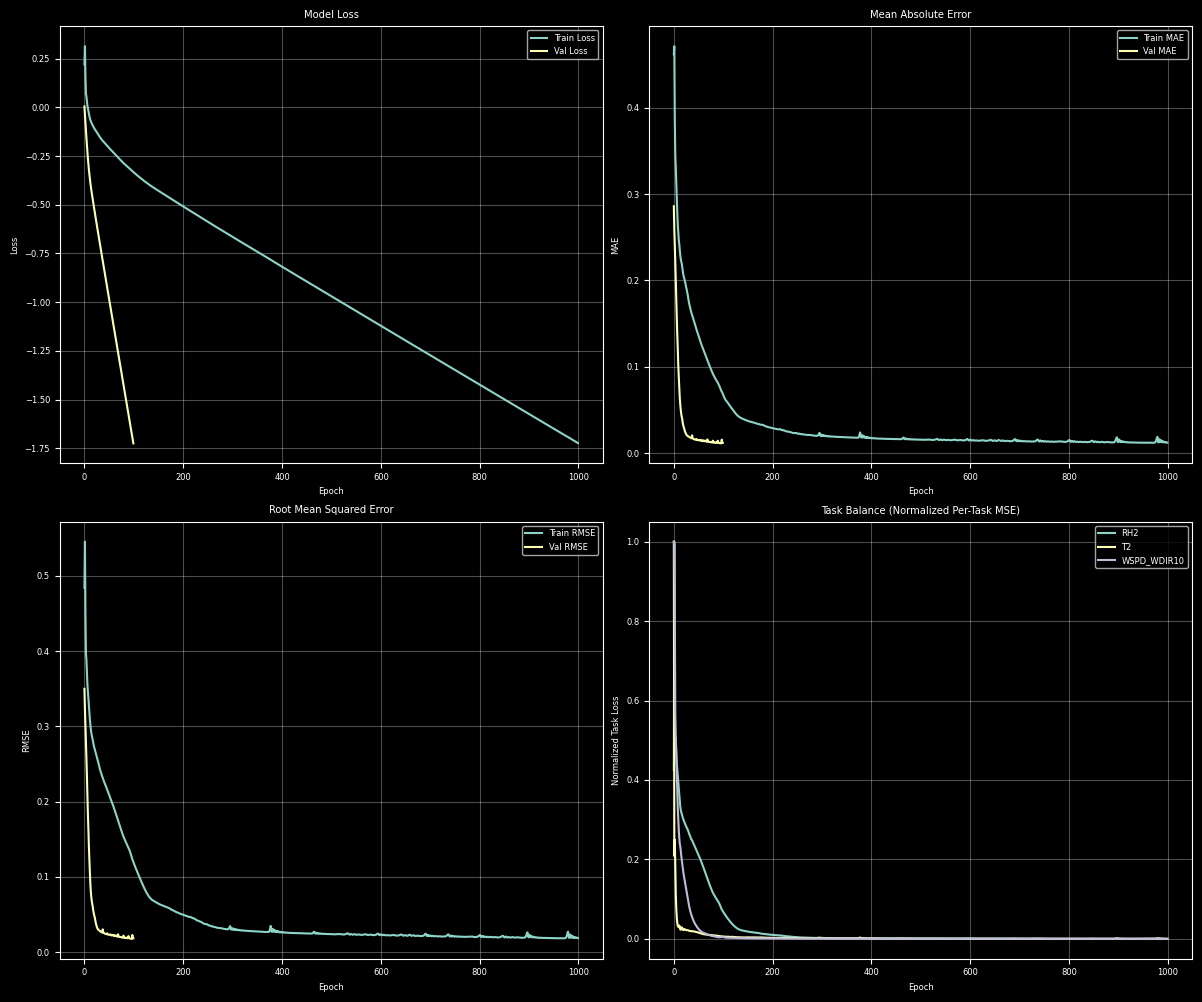

Analyzing task balance...
Note: plot_task_balance_simple is deprecated. Task balance is now included in plot_training_metrics.


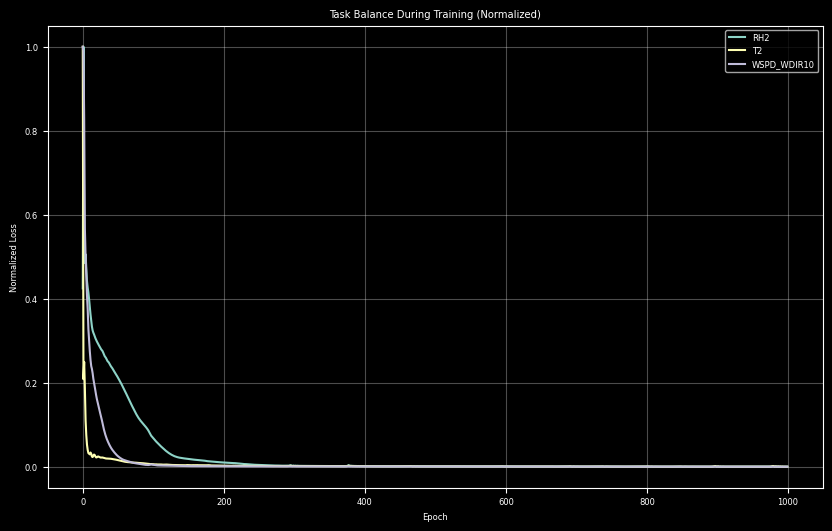


=== TASK PERFORMANCE ANALYSIS ===

=== Per-Task Performance Metrics (Single Batch) ===
⚠️  WARNING: This is based on ONE batch and may not be representative!

RH2:
  MSE: 0.000775
  MAE: 0.019147
  Correlation: 0.9889

T2:
  MSE: 0.000124
  MAE: 0.008259
  Correlation: 0.9841

WSPD_WDIR10:
  MSE: 0.000122
  MAE: 0.008653
  Correlation: 0.8547


Generating predictions for detailed analysis...
Creating prediction statistics...


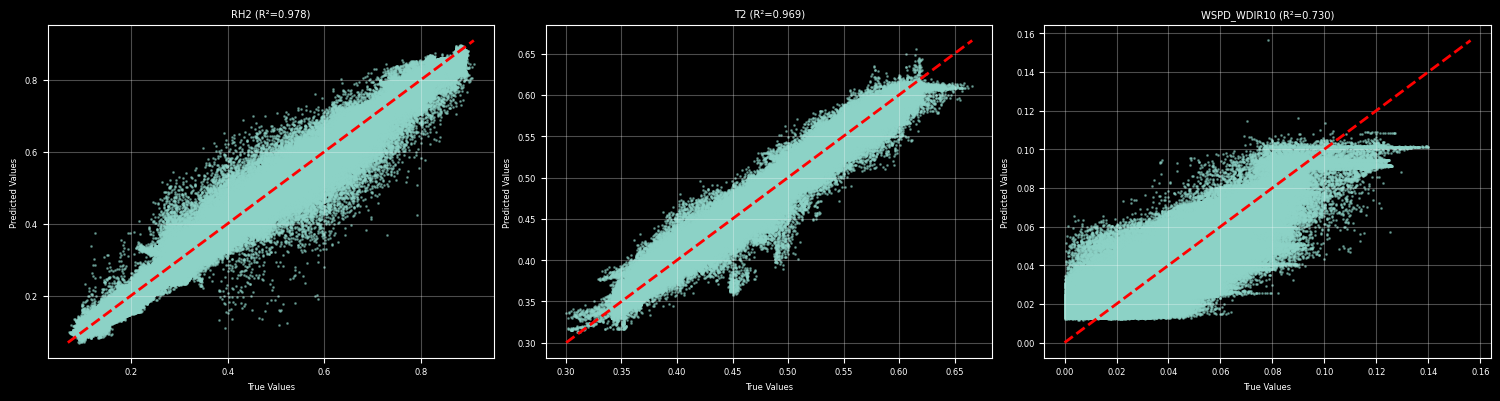


=== DETAILED VISUALIZATIONS ===


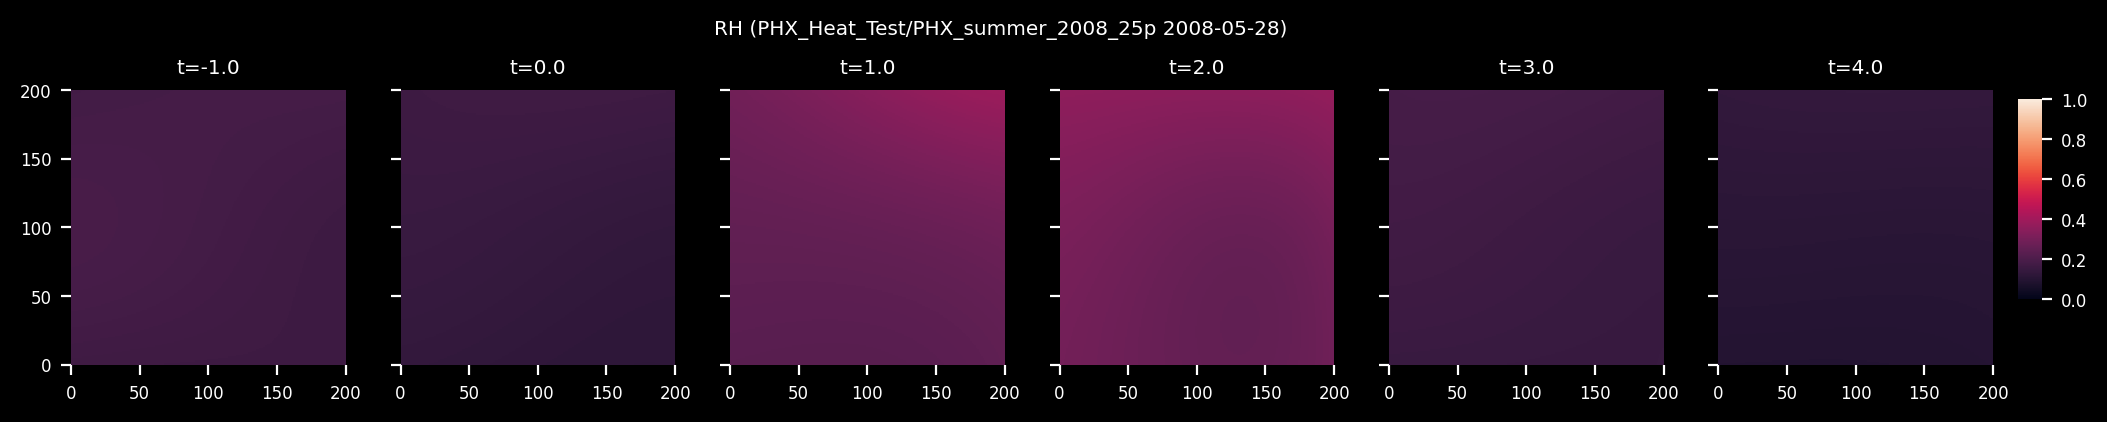

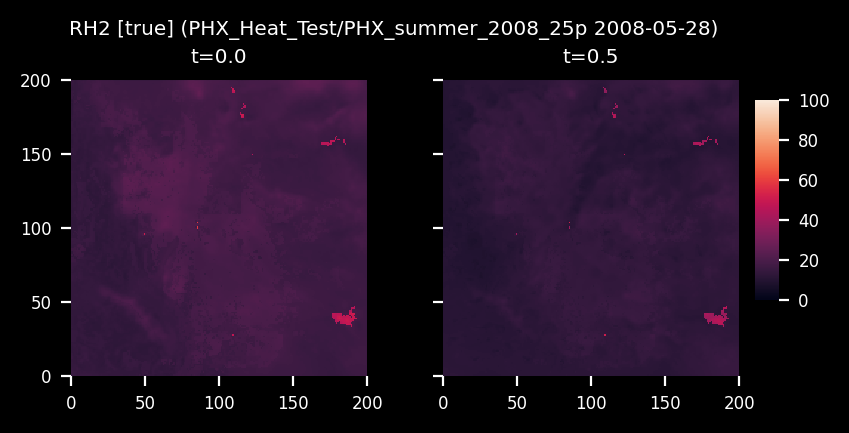

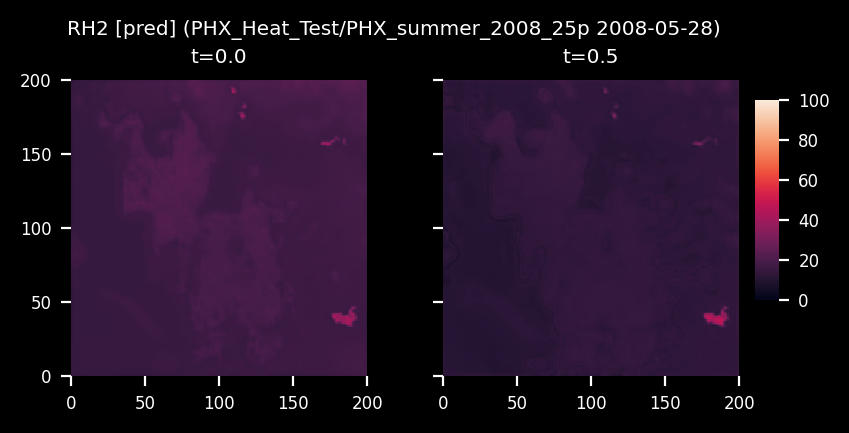

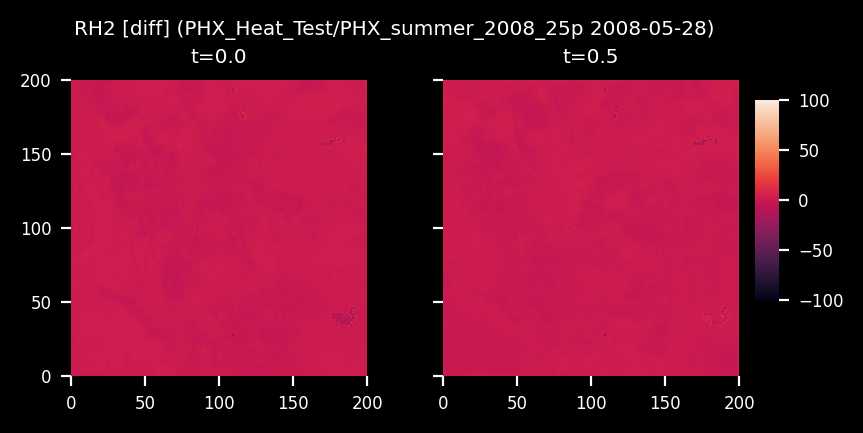

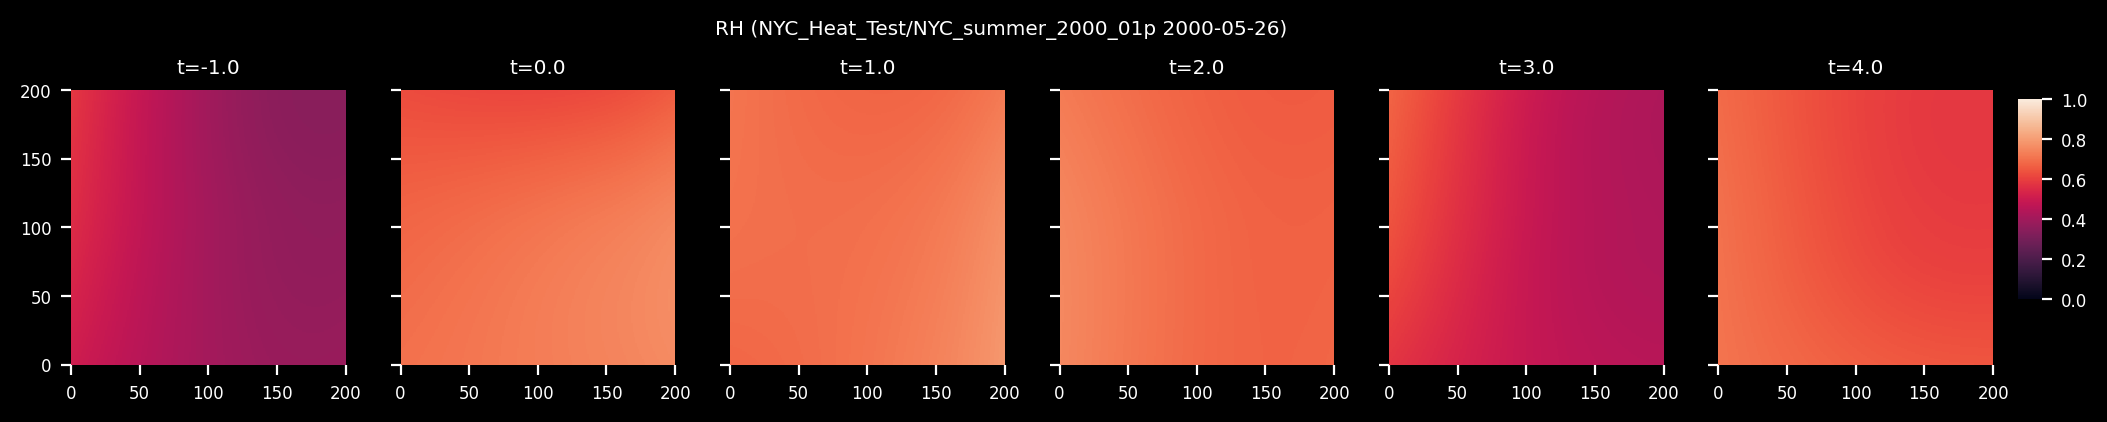

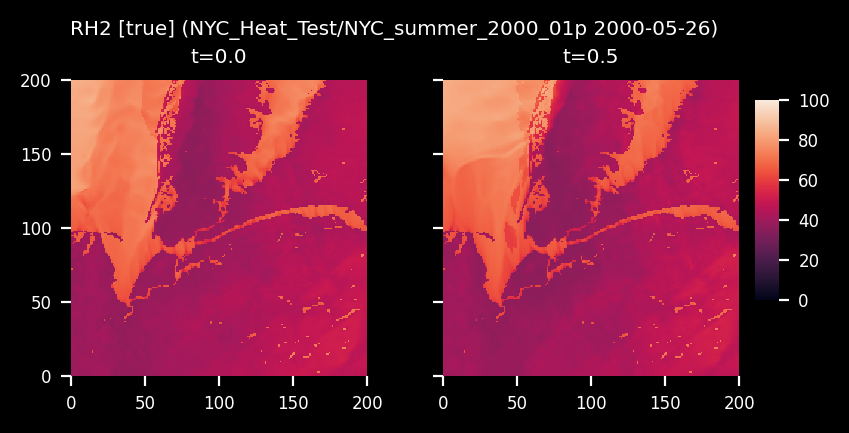

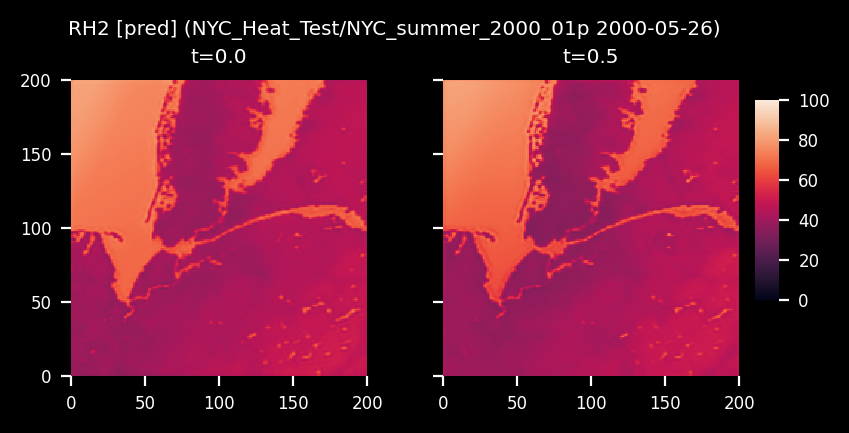

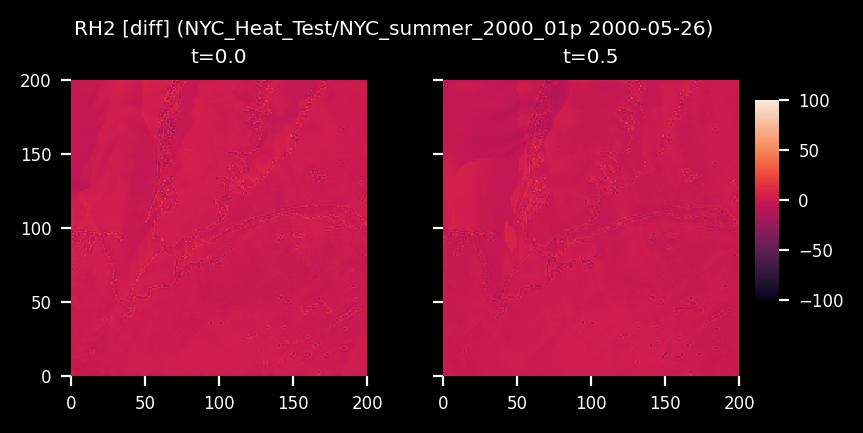

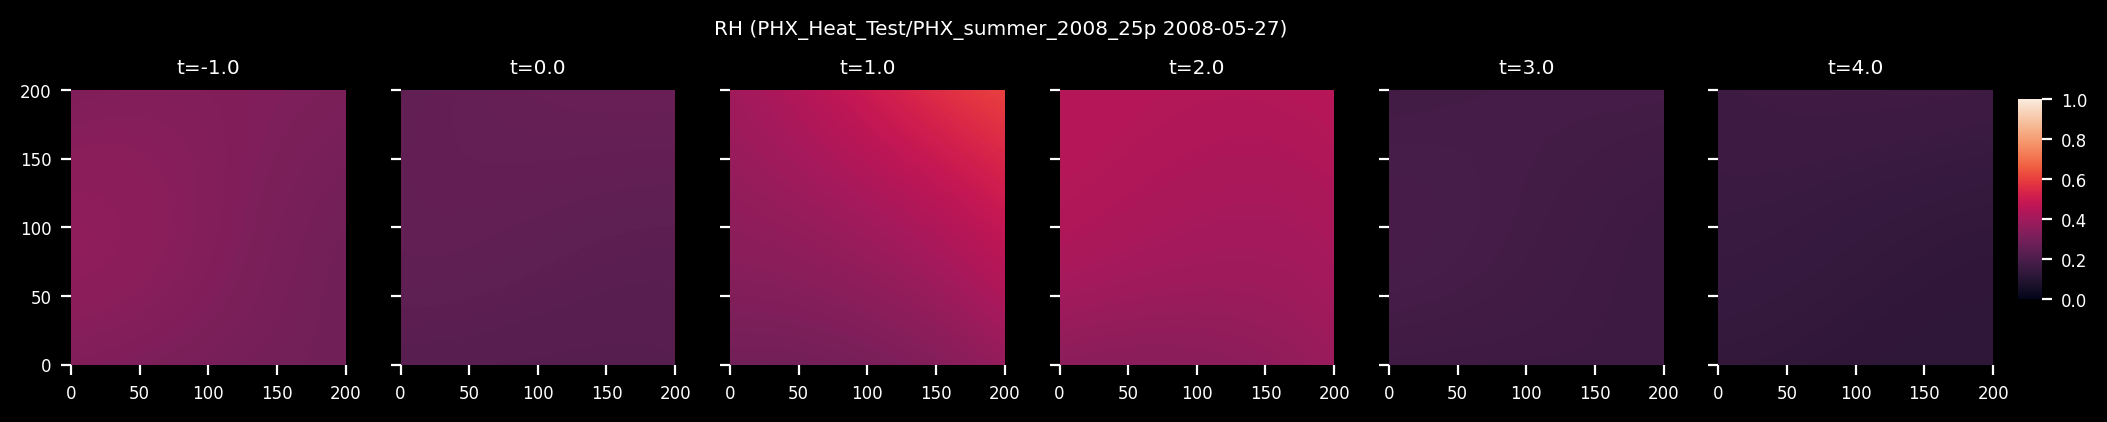

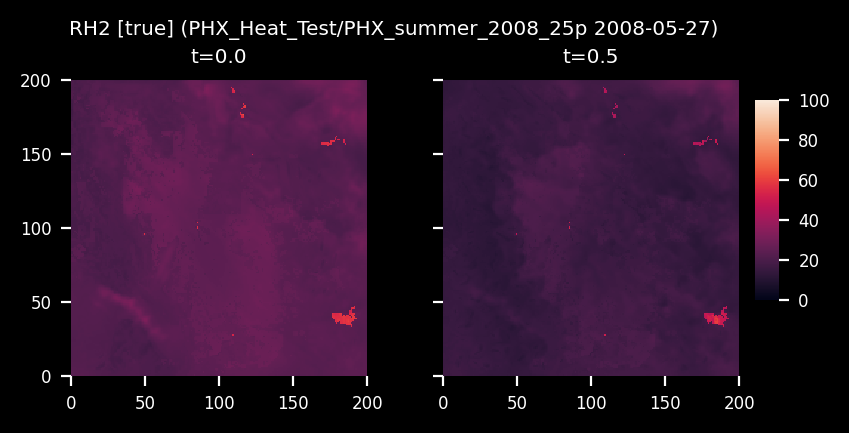

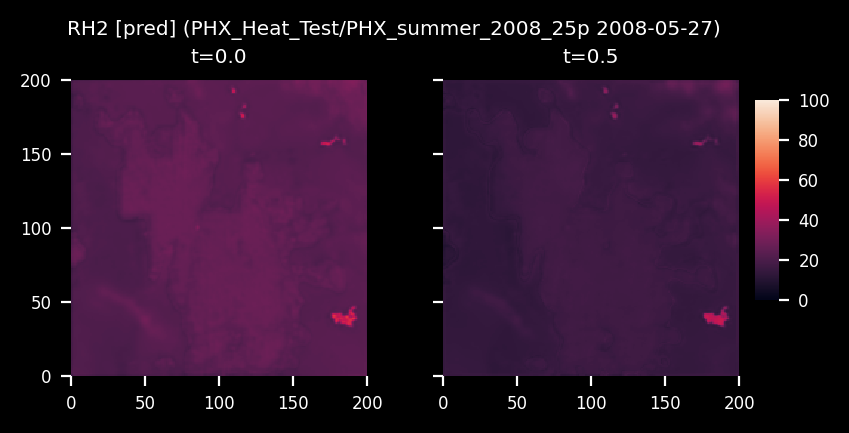

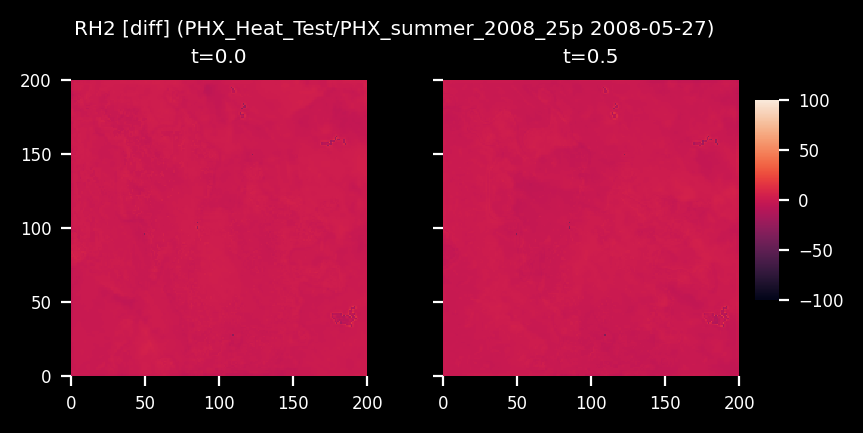

: 

In [ ]:
# Initialize visualization
visualizer.init_plt()

print("=== TRAINING ANALYSIS ===")

# 1. Plot comprehensive training metrics (now includes task balance in subplot 4)
print("Generating comprehensive training metrics with task balance...")
fig_metrics = visualizer.plot_training_metrics(
    history, 
    sto_vars=ds_config.sto_vars,  # IMPORTANT: Add this parameter
    save_path=f"{log_dir}/comprehensive_training_metrics.png"
)
plt.show()

# 2. Plot task balance separately (OPTIONAL - it's already in plot_training_metrics)
# Using local function now, not visualizer
print("Analyzing task balance...")
fig_balance = plot_task_balance_simple(
    history, ds_config.sto_vars, save_path=f"{log_dir}/task_balance.png"
)
plt.show()

# 3. Task performance analysis (using local function)
print("\n=== TASK PERFORMANCE ANALYSIS ===")
compare_task_performance(model, val_ds, ds_config)  # No 'visualizer.' prefix

# 4. Get predictions for analysis
print("\nGenerating predictions for detailed analysis...")
for batch in val_ds.take(1):
    input_batch, label_batch = batch
    pred_batch = model.call(input_batch)
    break

# 5. Prediction statistics (using local function)
print("Creating prediction statistics...")
fig_stats = plot_prediction_statistics(  # No 'visualizer.' prefix
    pred_batch.numpy(),
    label_batch.numpy(),
    ds_config.sto_vars,
    save_path=f"{log_dir}/prediction_statistics.png",
)
plt.show()

# 6. Continue using visualizer for core functions
print("\n=== DETAILED VISUALIZATIONS ===")
figs = list(
    visualizer.plot_batch(  # This stays with 'visualizer.' prefix
        ds_config,
        input_batch=input_batch,
        label_batch=label_batch,
        pred_batch=pred_batch,
        st_var=vars.Spatiotemporal.RH,
        sto_var=ds_config.sto_vars[0],
        max_examples=3,
        dynamic_colorscale=False,
        unscale=True,
    )
)


WIND SPEED PREDICTION DIAGNOSTIC
WIND SPEED DISTRIBUTION ANALYSIS

True Wind Speed Statistics:
  Min: 0.0000
  Max: 0.1400
  Mean: 0.0336
  Std: 0.0212
  Median: 0.0298

Predicted Wind Speed Statistics:
  Min: 0.0118
  Max: 0.1563
  Mean: 0.0335
  Std: 0.0178
  Median: 0.0286

Clustering Analysis:
  % predictions within 0.01 of 0.10: 1.6%


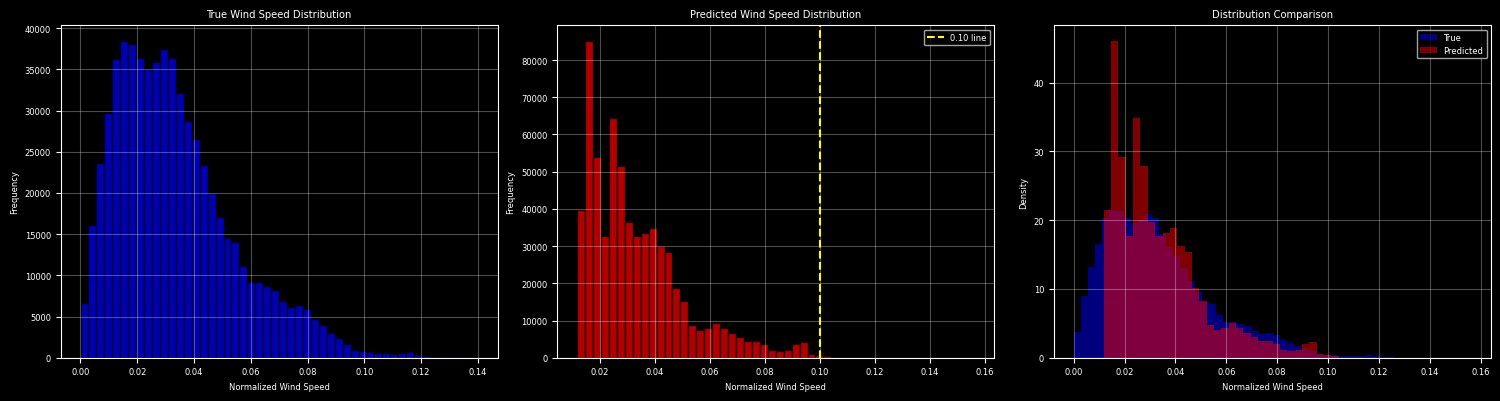


MODEL ARCHITECTURE CHECK

Wind Speed Output Head Configuration:
  Wind output head exists
  Layer: TimeDistributed

Model Parameters:
  Output activation: relu
  LSTM activation: tanh

ACTIVATION SATURATION TEST

Prediction range: 0.8846
✓ Prediction range seems reasonable

RECOMMENDED FIXES

1. DATA SCALING FIX:
   Check vars.py for WSPD_WDIR10 scaling:
   ```python
   # In vars.py, check/modify:
   STO_VAR_CONFIGS[SpatiotemporalOutput.WSPD_WDIR10] = VarConfig(
       vmin=0.0,    # Minimum wind speed
       vmax=30.0,   # Maximum wind speed (m/s)
       # Ensure this covers the actual data range
   )
   ```

2. MODEL ARCHITECTURE FIX:
   Remove sigmoid/tanh from wind output layer:
   ```python
   # In model.py, for wind output head:
   layers.Conv2D(1, OUTPUT_K_SIZE, activation='linear')  # Use linear
   ```

3. LOSS WEIGHTING FIX:
   Increase wind task weight during training:
   ```python
   params = AtmoModel.Params(
       task_loss_weights=(1.0, 1.0, 2.0),  # Double weight for w

In [7]:
"""
Wind Speed Prediction Diagnostic and Fix
=========================================
This notebook diagnoses why wind predictions cluster around 0.10 and provides fixes.
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats

# ============================================================================
# STEP 1: DIAGNOSE THE WIND SPEED DATA DISTRIBUTION
# ============================================================================

def analyze_wind_distribution(val_ds, model, config):
    """Analyze the distribution of wind speed values in data vs predictions."""
    
    print("=" * 60)
    print("WIND SPEED DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    # Collect actual and predicted values
    all_true = []
    all_pred = []
    
    for batch_idx, (inputs, labels) in enumerate(val_ds.take(5)):  # Sample 5 batches
        preds = model.call(inputs)
        
        # Find wind speed index
        wind_idx = None
        for i, var in enumerate(config.sto_vars):
            if var.name == "WSPD_WDIR10":
                wind_idx = i
                break
        
        if wind_idx is not None:
            all_true.append(labels[..., wind_idx].numpy().flatten())
            all_pred.append(preds[..., wind_idx].numpy().flatten())
    
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    
    # Print statistics
    print(f"\nTrue Wind Speed Statistics:")
    print(f"  Min: {np.min(all_true):.4f}")
    print(f"  Max: {np.max(all_true):.4f}")
    print(f"  Mean: {np.mean(all_true):.4f}")
    print(f"  Std: {np.std(all_true):.4f}")
    print(f"  Median: {np.median(all_true):.4f}")
    
    print(f"\nPredicted Wind Speed Statistics:")
    print(f"  Min: {np.min(all_pred):.4f}")
    print(f"  Max: {np.max(all_pred):.4f}")
    print(f"  Mean: {np.mean(all_pred):.4f}")
    print(f"  Std: {np.std(all_pred):.4f}")
    print(f"  Median: {np.median(all_pred):.4f}")
    
    # Check for clustering around specific values
    print(f"\nClustering Analysis:")
    pred_around_010 = np.sum(np.abs(all_pred - 0.10) < 0.01) / len(all_pred) * 100
    print(f"  % predictions within 0.01 of 0.10: {pred_around_010:.1f}%")
    
    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram of true values
    axes[0].hist(all_true, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('True Wind Speed Distribution')
    axes[0].set_xlabel('Normalized Wind Speed')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(alpha=0.3)
    
    # Histogram of predicted values
    axes[1].hist(all_pred, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1].set_title('Predicted Wind Speed Distribution')
    axes[1].set_xlabel('Normalized Wind Speed')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(x=0.10, color='yellow', linestyle='--', label='0.10 line')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Overlay comparison
    axes[2].hist(all_true, bins=50, alpha=0.5, color='blue', label='True', density=True)
    axes[2].hist(all_pred, bins=50, alpha=0.5, color='red', label='Predicted', density=True)
    axes[2].set_title('Distribution Comparison')
    axes[2].set_xlabel('Normalized Wind Speed')
    axes[2].set_ylabel('Density')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return all_true, all_pred


# ============================================================================
# STEP 2: CHECK THE ACTIVATION FUNCTIONS IN OUTPUT LAYERS
# ============================================================================

def check_model_architecture(model):
    """Check the wind speed output head configuration."""
    
    print("\n" + "=" * 60)
    print("MODEL ARCHITECTURE CHECK")
    print("=" * 60)
    
    # Check if wind output head exists and its configuration
    if hasattr(model._model, '_wspd10_output_cnn'):
        print("\nWind Speed Output Head Configuration:")
        wind_head = model._model._wspd10_output_cnn
        
        if wind_head is not None:
            print("  Wind output head exists")
            
            # Try to check the layers
            try:
                for layer in wind_head.layers:
                    print(f"  Layer: {layer.__class__.__name__}")
                    if hasattr(layer, 'layers'):  # TimeDistributed
                        for sub_layer in layer.layers:
                            if hasattr(sub_layer, 'layers'):  # Sequential
                                for conv_layer in sub_layer.layers:
                                    if hasattr(conv_layer, 'activation'):
                                        print(f"    - Conv2D with activation: {conv_layer.activation}")
            except:
                print("  Could not inspect layers in detail")
    
    # Check activation settings
    print("\nModel Parameters:")
    print(f"  Output activation: {model._params.output_activation}")
    print(f"  LSTM activation: {model._params.lstm_activation}")
    
    # Check for BatchNormalization or special activations
    if "sigmoid" in str(model._params.output_activation).lower():
        print("\n⚠️  WARNING: Sigmoid activation can cause saturation!")
        print("  This might explain clustering around certain values.")


# ============================================================================
# STEP 3: FIXES FOR WIND SPEED PREDICTION
# ============================================================================

def fix_wind_speed_scaling(config):
    """Suggest fixes for wind speed scaling issues."""
    
    print("\n" + "=" * 60)
    print("RECOMMENDED FIXES")
    print("=" * 60)
    
    print("\n1. DATA SCALING FIX:")
    print("   Check vars.py for WSPD_WDIR10 scaling:")
    print("   ```python")
    print("   # In vars.py, check/modify:")
    print("   STO_VAR_CONFIGS[SpatiotemporalOutput.WSPD_WDIR10] = VarConfig(")
    print("       vmin=0.0,    # Minimum wind speed") 
    print("       vmax=30.0,   # Maximum wind speed (m/s)")
    print("       # Ensure this covers the actual data range")
    print("   )")
    print("   ```")
    
    print("\n2. MODEL ARCHITECTURE FIX:")
    print("   Remove sigmoid/tanh from wind output layer:")
    print("   ```python")
    print("   # In model.py, for wind output head:")
    print("   layers.Conv2D(1, OUTPUT_K_SIZE, activation='linear')  # Use linear")
    print("   ```")
    
    print("\n3. LOSS WEIGHTING FIX:")
    print("   Increase wind task weight during training:")
    print("   ```python")
    print("   params = AtmoModel.Params(")
    print("       task_loss_weights=(1.0, 1.0, 2.0),  # Double weight for wind")
    print("       adaptive_weighting=True,")
    print("   )")
    print("   ```")
    
    print("\n4. DATA AUGMENTATION FIX:")
    print("   Add noise to prevent memorization:")
    print("   ```python")
    print("   # During training, add small noise to wind data")
    print("   wind_noise = tf.random.normal(shape=tf.shape(wind_data), stddev=0.01)")
    print("   wind_data = wind_data + wind_noise")
    print("   ```")


# ============================================================================
# STEP 4: RETRAIN WITH FIXES
# ============================================================================

def create_fixed_model_params():
    """Create model parameters with fixes for wind prediction."""
    
    from usl_models.atmo_ml.model import AtmoModel
    from usl_models.atmo_ml import vars
    
    params = AtmoModel.Params(
        # Increase wind task weight
        task_loss_weights=(1.0, 1.0, 2.0),  # RH2, T2, Wind (doubled)
        adaptive_weighting=True,
        
        # Ensure proper dropout
        lstm_dropout=0.2,
        lstm_recurrent_dropout=0.2,
        
        # Output parameters
        output_timesteps=2,
        
        # Variables
        sto_vars=(
            vars.SpatiotemporalOutput.RH2,
            vars.SpatiotemporalOutput.T2,
            vars.SpatiotemporalOutput.WSPD_WDIR10,
        ),
        
        # LSTM configuration
        lstm_units=64,
        lstm_kernel_size=5,
    )
    
    return params


# ============================================================================
# STEP 5: QUICK TEST FOR ACTIVATION SATURATION
# ============================================================================

def test_activation_saturation(model, val_ds):
    """Test if activations are saturating."""
    
    print("\n" + "=" * 60)
    print("ACTIVATION SATURATION TEST")
    print("=" * 60)
    
    # Get one batch
    for inputs, labels in val_ds.take(1):
        # Get intermediate outputs if possible
        try:
            # Run prediction
            preds = model.call(inputs)
            
            # Check if predictions are stuck in a narrow range
            pred_range = tf.reduce_max(preds) - tf.reduce_min(preds)
            print(f"\nPrediction range: {pred_range:.4f}")
            
            if pred_range < 0.5:
                print("⚠️  WARNING: Predictions have very narrow range!")
                print("  This suggests activation saturation.")
            else:
                print("✓ Prediction range seems reasonable")
                
        except Exception as e:
            print(f"Could not test activations: {e}")
        
        break


# ============================================================================
# MAIN DIAGNOSTIC FUNCTION
# ============================================================================

def diagnose_and_fix_wind_predictions(model, val_ds, config):
    """Run complete diagnostic and provide fixes."""
    
    print("\n" + "=" * 80)
    print("WIND SPEED PREDICTION DIAGNOSTIC")
    print("=" * 80)
    
    # Step 1: Analyze distributions
    true_vals, pred_vals = analyze_wind_distribution(val_ds, model, config)
    
    # Step 2: Check model architecture
    check_model_architecture(model)
    
    # Step 3: Test for saturation
    test_activation_saturation(model, val_ds)
    
    # Step 4: Provide fixes
    fix_wind_speed_scaling(config)
    
    # Step 5: Return diagnostic data
    return {
        'true_values': true_vals,
        'predicted_values': pred_vals,
        'clustering_percentage': np.sum(np.abs(pred_vals - 0.10) < 0.01) / len(pred_vals) * 100
    }


# ============================================================================
# USAGE IN YOUR NOTEBOOK
# ============================================================================

# Run this after training:
diagnostic_results = diagnose_and_fix_wind_predictions(model, val_ds, ds_config)

# If clustering is confirmed, implement the fixes:
if diagnostic_results['clustering_percentage'] > 20:
    print("\n⚠️  SIGNIFICANT CLUSTERING DETECTED!")
    print("Implement the suggested fixes and retrain the model.")
    
    # Create fixed parameters
    fixed_params = create_fixed_model_params()
    print("\nFixed parameters created. Retrain with these parameters.")

In [7]:
# Launch TensorBoard for interactive visualization
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006

Launching TensorBoard...


WIND SPEED UNITS AND SCALING INVESTIGATION

REVERSE NORMALIZATION ANALYSIS

Current scaling configuration:
  vmin: 0.0
  vmax: 100.0

Reconstructed original values:
  Min: 0.00
  Max: 14.00
  Mean: 3.36
  Std: 2.12
  95th percentile: 7.66
  99th percentile: 9.46

UNIT ANALYSIS:

If units are m/s:
  Max wind: 14.0 m/s = 31.3 mph
  ✓ This seems reasonable for typical conditions

If units are km/h:
  Max wind: 14.0 km/h = 8.7 mph

If units are knots:
  Max wind: 14.0 knots = 16.1 mph


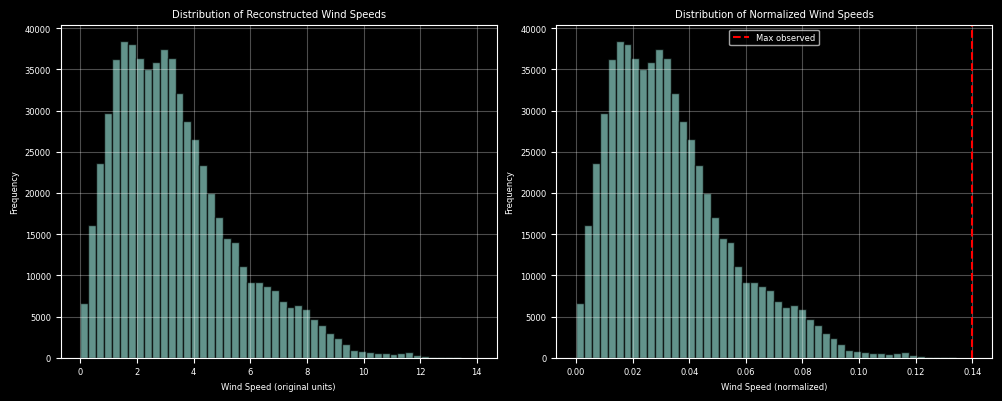


SUGGESTED VMAX VALUES

Data percentiles:
  95th: 7.66
  99th: 9.46
  99.9th: 11.89
  Max: 14.00

Suggested vmax options:
  Conservative (99th percentile + 20%): 11.3
  Moderate (99.9th percentile + 10%): 13.1
  Inclusive (max value + 5%): 14.7

✓ RECOMMENDED vmax: 15

TESTING DIFFERENT VMAX SCENARIOS


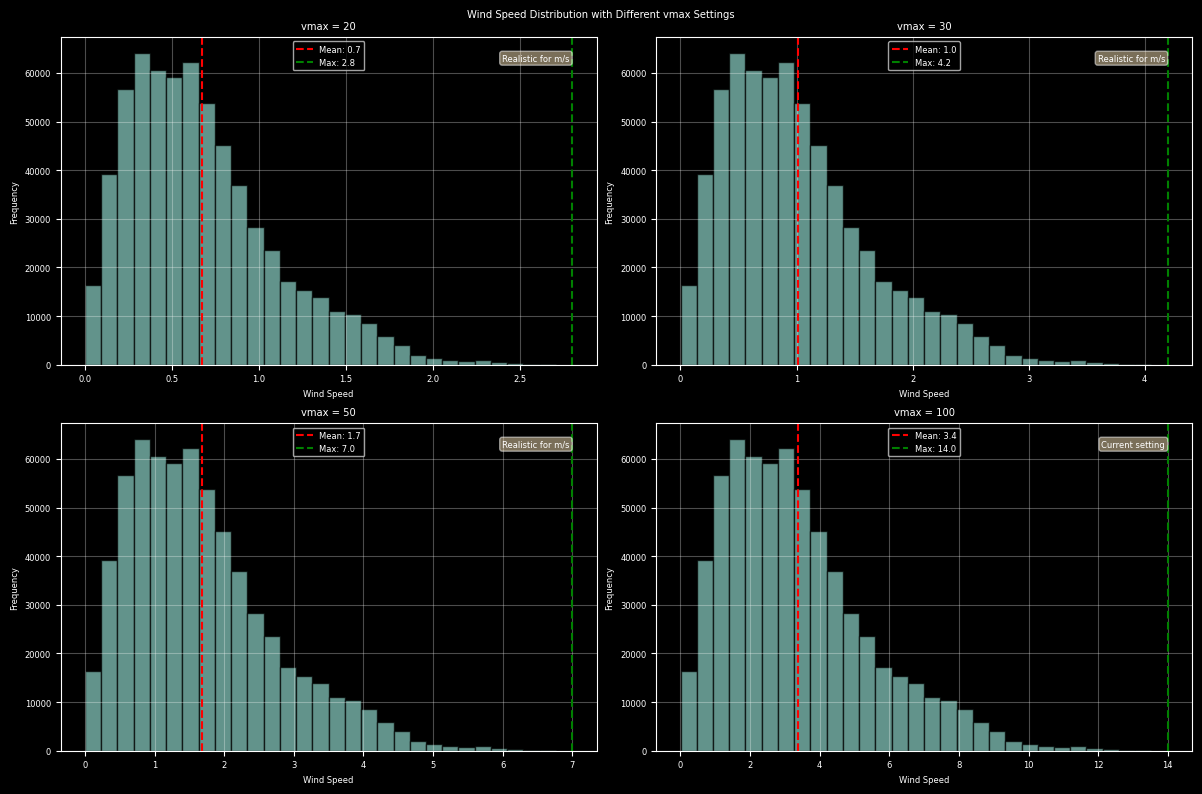


FINAL RECOMMENDATIONS

1. Current vmax=100.0 seems too high
2. Suggested vmax=15 based on your data
3. Update vars.py with:

    STO_VAR_CONFIGS[SpatiotemporalOutput.WSPD_WDIR10] = VarConfig(
        vmin=0.0,
        vmax=15,  # Changed from 100.0
    )
    

4. After changing vmax, you'll need to:
   - Re-normalize your data
   - Retrain the model
   - Or continue with current scaling if results are acceptable

INVESTIGATION COMPLETE


In [10]:
"""
Investigate Wind Speed Units and Scaling
========================================
This notebook helps determine the actual units and appropriate scaling for wind speed.
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from usl_models.atmo_ml import vars

# ============================================================================
# STEP 1: CHECK RAW DATA VALUES (BEFORE NORMALIZATION)
# ============================================================================

def check_raw_wind_values(dataset_or_path):
    """Check the raw wind speed values before any normalization."""
    
    print("=" * 60)
    print("RAW WIND SPEED INVESTIGATION")
    print("=" * 60)
    
    # Method 1: If you have access to raw data files
    print("\n1. CHECKING RAW DATA FILES:")
    print("Look for original .npy or .nc files with wind data")
    
    # Try to load a sample raw file (adjust path as needed)
    try:
        # Example paths - adjust based on your setup
        raw_file_paths = [
            "/Users/vupparal/Downloads/CPN_Heat_CPN_summer_2000_01p_spatiotemporal_met_em.d03.2000-06-03_18_00_00.npy",
 
        ]
        
        print("Searching for raw data files...")
        # You'll need to modify this based on your actual file structure
        
    except Exception as e:
        print(f"Could not load raw files: {e}")
    
    return None


# ============================================================================
# STEP 2: REVERSE ENGINEER FROM NORMALIZED DATA
# ============================================================================

def reverse_normalize_wind(val_ds, config):
    """Reverse the normalization to get original values."""
    
    print("\n" + "=" * 60)
    print("REVERSE NORMALIZATION ANALYSIS")
    print("=" * 60)
    
    # Get the scaling configuration
    wind_var = vars.SpatiotemporalOutput.WSPD_WDIR10
    wind_config = vars.STO_VAR_CONFIGS[wind_var]
    
    print(f"\nCurrent scaling configuration:")
    print(f"  vmin: {wind_config.vmin}")
    print(f"  vmax: {wind_config.vmax}")
    
    # Get normalized values from dataset
    normalized_values = []
    for batch_idx, (inputs, labels) in enumerate(val_ds.take(5)):
        wind_idx = config.sto_vars.index(wind_var)
        wind_normalized = labels[..., wind_idx].numpy().flatten()
        normalized_values.extend(wind_normalized)
    
    normalized_values = np.array(normalized_values)
    
    # Reverse the normalization
    # If normalized = (original - vmin) / (vmax - vmin)
    # Then original = normalized * (vmax - vmin) + vmin
    original_values = wind_config.unscale(normalized_values)
    
    print(f"\nReconstructed original values:")
    print(f"  Min: {np.min(original_values):.2f}")
    print(f"  Max: {np.max(original_values):.2f}")
    print(f"  Mean: {np.mean(original_values):.2f}")
    print(f"  Std: {np.std(original_values):.2f}")
    print(f"  95th percentile: {np.percentile(original_values, 95):.2f}")
    print(f"  99th percentile: {np.percentile(original_values, 99):.2f}")
    
    # Analyze if these values make sense
    print("\n" + "=" * 60)
    print("UNIT ANALYSIS:")
    print("=" * 60)
    
    max_wind = np.max(original_values)
    
    print(f"\nIf units are m/s:")
    print(f"  Max wind: {max_wind:.1f} m/s = {max_wind * 2.237:.1f} mph")
    if max_wind > 50:
        print("  ⚠️  This would be hurricane-force winds (unusual for normal data)")
    elif max_wind > 30:
        print("  ⚠️  This would be very strong winds")
    elif max_wind < 20:
        print("  ✓ This seems reasonable for typical conditions")
    
    print(f"\nIf units are km/h:")
    print(f"  Max wind: {max_wind:.1f} km/h = {max_wind * 0.621371:.1f} mph")
    
    print(f"\nIf units are knots:")
    print(f"  Max wind: {max_wind:.1f} knots = {max_wind * 1.15078:.1f} mph")
    
    # Plot distribution of reconstructed values
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(original_values, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Wind Speed (original units)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstructed Wind Speeds')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(normalized_values, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Wind Speed (normalized)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Normalized Wind Speeds')
    plt.axvline(x=0.14, color='red', linestyle='--', label='Max observed')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return original_values, normalized_values


# ============================================================================
# STEP 3: FIND APPROPRIATE VMAX
# ============================================================================

def find_appropriate_vmax(original_values):
    """Suggest appropriate vmax based on data distribution."""
    
    print("\n" + "=" * 60)
    print("SUGGESTED VMAX VALUES")
    print("=" * 60)
    
    # Calculate percentiles
    p95 = np.percentile(original_values, 95)
    p99 = np.percentile(original_values, 99)
    p999 = np.percentile(original_values, 99.9)
    max_val = np.max(original_values)
    
    print(f"\nData percentiles:")
    print(f"  95th: {p95:.2f}")
    print(f"  99th: {p99:.2f}")
    print(f"  99.9th: {p999:.2f}")
    print(f"  Max: {max_val:.2f}")
    
    # Suggest vmax values
    print(f"\nSuggested vmax options:")
    print(f"  Conservative (99th percentile + 20%): {p99 * 1.2:.1f}")
    print(f"  Moderate (99.9th percentile + 10%): {p999 * 1.1:.1f}")
    print(f"  Inclusive (max value + 5%): {max_val * 1.05:.1f}")
    
    # Round to nice numbers
    suggested_vmax = np.ceil(p999 * 1.1 / 5) * 5  # Round up to nearest 5
    print(f"\n✓ RECOMMENDED vmax: {suggested_vmax:.0f}")
    
    return suggested_vmax


# ============================================================================
# STEP 4: TEST DIFFERENT SCALING SCENARIOS
# ============================================================================

def test_scaling_scenarios(normalized_values):
    """Test how data would look with different vmax values."""
    
    print("\n" + "=" * 60)
    print("TESTING DIFFERENT VMAX SCENARIOS")
    print("=" * 60)
    
    # Test different vmax values
    test_vmax_values = [20, 30, 50, 100]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, vmax in enumerate(test_vmax_values):
        # Reconstruct with this vmax
        reconstructed = normalized_values * vmax
        
        axes[i].hist(reconstructed, bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'vmax = {vmax}')
        axes[i].set_xlabel('Wind Speed')
        axes[i].set_ylabel('Frequency')
        
        # Add statistics
        mean_val = np.mean(reconstructed)
        max_val = np.max(reconstructed)
        axes[i].axvline(mean_val, color='red', linestyle='--', 
                       label=f'Mean: {mean_val:.1f}')
        axes[i].axvline(max_val, color='green', linestyle='--', 
                       label=f'Max: {max_val:.1f}')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
        
        # Add interpretation
        if vmax == 100:
            interpretation = "Current setting"
        elif max_val < 15:
            interpretation = "Realistic for m/s"
        elif max_val < 30:
            interpretation = "High but possible"
        else:
            interpretation = "Likely too high"
        
        axes[i].text(0.95, 0.95, interpretation,
                    transform=axes[i].transAxes,
                    ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Wind Speed Distribution with Different vmax Settings')
    plt.tight_layout()
    plt.show()


# ============================================================================
# MAIN INVESTIGATION FUNCTION
# ============================================================================

def investigate_wind_units(val_ds, config):
    """Complete investigation of wind units and scaling."""
    
    print("\n" + "=" * 80)
    print("WIND SPEED UNITS AND SCALING INVESTIGATION")
    print("=" * 80)
    
    # Step 1: Reverse normalize to get original values
    original_values, normalized_values = reverse_normalize_wind(val_ds, config)
    
    # Step 2: Find appropriate vmax
    suggested_vmax = find_appropriate_vmax(original_values)
    
    # Step 3: Test different scenarios
    test_scaling_scenarios(normalized_values)
    
    # Step 4: Final recommendations
    print("\n" + "=" * 80)
    print("FINAL RECOMMENDATIONS")
    print("=" * 80)
    
    print(f"\n1. Current vmax={vars.STO_VAR_CONFIGS[vars.SpatiotemporalOutput.WSPD_WDIR10].vmax} seems too high")
    print(f"2. Suggested vmax={suggested_vmax:.0f} based on your data")
    print(f"3. Update vars.py with:")
    print(f"""
    STO_VAR_CONFIGS[SpatiotemporalOutput.WSPD_WDIR10] = VarConfig(
        vmin=0.0,
        vmax={suggested_vmax:.0f},  # Changed from 100.0
    )
    """)
    
    print("\n4. After changing vmax, you'll need to:")
    print("   - Re-normalize your data")
    print("   - Retrain the model")
    print("   - Or continue with current scaling if results are acceptable")
    
    return {
        'original_values': original_values,
        'normalized_values': normalized_values,
        'suggested_vmax': suggested_vmax
    }


# ============================================================================
# RUN THE INVESTIGATION
# ============================================================================

# Add this to your notebook:
investigation_results = investigate_wind_units(val_ds, ds_config)

print("\n" + "=" * 80)
print("INVESTIGATION COMPLETE")
print("=" * 80)

<_BatchDataset element_spec=({'spatiotemporal': TensorSpec(shape=(None, None, None, None, 12), dtype=tf.float32, name=None), 'spatial': TensorSpec(shape=(None, None, None, 22), dtype=tf.float32, name=None), 'lu_index': TensorSpec(shape=(None, None, None), dtype=tf.int32, name=None), 'sim_name': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'date': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None, 2, None, None, 3), dtype=tf.float32, name=None))>